In [390]:
import sys
sys.path.insert(0, '../scripts/')
from l5kit_modified.l5kit_modified import AgentDatasetModified, create_chopped_dataset
from l5kit_modified.map_api import *
from l5kit.data import ChunkedDataset, LocalDataManager
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from random import sample
from scipy.interpolate import interp1d
from scipy.spatial import KDTree
from collections import deque 
from tqdm.auto import tqdm
from copy import deepcopy
%matplotlib inline

In [2]:
world_to_ecef = np.asarray(
        [
            [8.46617444e-01, 3.23463078e-01, -4.22623402e-01, -2.69876744e06],
            [-5.32201938e-01, 5.14559352e-01, -6.72301845e-01, -4.29315158e06],
            [-3.05311332e-16, 7.94103464e-01, 6.07782600e-01, 3.85516476e06],
            [0.00000000e00, 0.00000000e00, 0.00000000e00, 1.00000000e00],
        ],
        dtype=np.float64,
    )

semantic_map_key = 'semantic_map/semantic_map.pb'

In [3]:
FILTER_AGENTS_THRESHOLD = 0.5
NUM_FRAMES_TO_CHOP = 100
FUTURE_NUM_FRAMES = 50
MIN_FUTURE_STEPS = 10
BATCH_SIZE = 256
os.environ["L5KIT_DATA_FOLDER"] = "../input/"

In [4]:
cfg = {"model_params": {"history_num_frames": 10,
                                    "history_step_size": 10,
                                    "future_num_frames": 50,
                                    "future_step_size": 1},
                   "raster_params": {"filter_agents_threshold": FILTER_AGENTS_THRESHOLD}}

dataset_path = 'scenes/sample.zarr'

dm  = LocalDataManager(None)
percentage_of_dataset_scenes = 1
# eval_base_path = create_chopped_dataset(dm.require(dataset_path),
#                                                      FILTER_AGENTS_THRESHOLD,
#                                                      NUM_FRAMES_TO_CHOP,
#                                                      FUTURE_NUM_FRAMES,
#                                                      MIN_FUTURE_STEPS,
#                                                      percentage_of_dataset_scenes)
# eval_gt_path = os.path.join(eval_base_path, 'gt.csv')

# eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(dataset_path)).name)
# eval_mask_path = str(Path(eval_base_path) / "mask.npz")
# eval_zarr = ChunkedDataset(eval_zarr_path).open()
# eval_mask = np.load(eval_mask_path)["arr_0"]
        
# dataset = AgentDatasetModified(cfg, eval_zarr, agents_mask=eval_mask)

eval_zarr = ChunkedDataset(dm.require(dataset_path)).open()
dataset = AgentDatasetModified(cfg, eval_zarr)
dataset[0]         

{'target_positions': array([[0.4342041 , 0.72998047],
        [0.8635254 , 1.473877  ],
        [1.3000488 , 2.2026367 ],
        [1.7033691 , 2.9501953 ],
        [2.1296997 , 3.6855469 ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.     

In [5]:
centroid = dataset[0]['centroid']
centroid

array([  671.78094482, -2196.83374023])

In [6]:
semantic_map_path = dm.require(semantic_map_key)
proto_API = MapAPI(semantic_map_path, world_to_ecef)

In [7]:
def get_bounds(proto_API) -> dict:
    """
    For each elements of interest returns bounds [[min_x, min_y],[max_x, max_y]] and proto ids
    Coords are computed by the MapAPI and, as such, are in the world ref system.

    Returns:
        dict: keys are classes of elements, values are dict with `bounds` and `ids` keys
    """
    lanes_ids = []
    crosswalks_ids = []
    center_line_coords = []
    xy_left_coords = []
    xy_right_coords = []

    lanes_bounds = np.empty((0, 2, 2), dtype=np.float)  # [(X_MIN, Y_MIN), (X_MAX, Y_MAX)]
    crosswalks_bounds = np.empty((0, 2, 2), dtype=np.float)  # [(X_MIN, Y_MIN), (X_MAX, Y_MAX)]

    for element in proto_API:
        element_id = MapAPI.id_as_str(element.id)

        if proto_API.is_lane(element):
            lane = proto_API.get_lane_coords(element_id)
            x_min = min(np.min(lane["xyz_left"][:, 0]), np.min(lane["xyz_right"][:, 0]))
            y_min = min(np.min(lane["xyz_left"][:, 1]), np.min(lane["xyz_right"][:, 1]))
            x_max = max(np.max(lane["xyz_left"][:, 0]), np.max(lane["xyz_right"][:, 0]))
            y_max = max(np.max(lane["xyz_left"][:, 1]), np.max(lane["xyz_right"][:, 1]))
            
            if len(lane["xyz_left"][:, 0]) == len(lane["xyz_right"][:, 0]):
                x_right = lane["xyz_right"][:, 0]
                x_left = lane["xyz_left"][:, 0]
                
                y_right = lane["xyz_right"][:, 1]
                y_left = lane["xyz_left"][:, 1]
                
            elif len(lane["xyz_left"][:, 0]) < len(lane["xyz_right"][:, 0]):
                x_right = lane["xyz_right"][:, 0]
                x_left_ = lane["xyz_left"][:, 0]
                x_left = np.interp(np.linspace(0, len(x_left_)-1, len(x_right)),
                                   np.arange(len(x_left_)), x_left_)
                
                y_right = lane["xyz_right"][:, 1]
                y_left_ = lane["xyz_left"][:, 1]
                y_left = np.interp(np.linspace(0, len(y_left_)-1, len(y_right)), 
                                   np.arange(len(y_left_)), y_left_)
                
            elif len(lane["xyz_left"][:, 0]) > len(lane["xyz_right"][:, 0]):
                x_left = lane["xyz_left"][:, 0]
                x_right_ = lane["xyz_right"][:, 0]
                x_right = np.interp(np.linspace(0, len(x_right_)-1, len(x_left)), 
                                    np.arange(len(x_right_)), x_right_)
                
                y_left = lane["xyz_left"][:, 1]
                y_right_ = lane["xyz_right"][:, 1]
                y_right = np.interp(np.linspace(0, len(y_right_)-1, len(y_left)), 
                                    np.arange(len(y_right_)), y_right_)
            else:
                raise Exception('Bug in lane length comparison')
            
            center_line = np.transpose(np.vstack(((x_left + x_right)/2,
                                                  (y_left + y_right)/2)))

            lanes_bounds = np.append(lanes_bounds, np.asarray([[[x_min, y_min], [x_max, y_max]]]), axis=0)
            lanes_ids.append(element_id)
            center_line_coords.append(center_line)
            xy_left_coords.append(lane["xyz_left"][:, :2])
            xy_right_coords.append(lane["xyz_right"][:, :2])

        if proto_API.is_crosswalk(element):
            crosswalk = proto_API.get_crosswalk_coords(element_id)
            x_min = np.min(crosswalk["xyz"][:, 0])
            y_min = np.min(crosswalk["xyz"][:, 1])
            x_max = np.max(crosswalk["xyz"][:, 0])
            y_max = np.max(crosswalk["xyz"][:, 1])

            crosswalks_bounds = np.append(
                crosswalks_bounds, np.asarray([[[x_min, y_min], [x_max, y_max]]]), axis=0,
            )
            crosswalks_ids.append(element_id)

    return {
        "lanes": {"bounds": lanes_bounds, "ids": lanes_ids, 
                  "center_line": center_line_coords, 
                  "xy_left": xy_left_coords, "xy_right": xy_right_coords
                 },
        "crosswalks": {"bounds": crosswalks_bounds, "ids": crosswalks_ids},
    }

In [8]:
lanes_crosswalks = get_bounds(proto_API)

In [9]:
len(lanes_crosswalks['lanes']['ids'])

8505

In [10]:
center_line_lens_list = [len(x) for x in lanes_crosswalks['lanes']['center_line']]
np.mean(center_line_lens_list), np.std(center_line_lens_list), np.max(center_line_lens_list)

(20.99611992945326, 30.863471846344073, 537)

<AxesSubplot:>

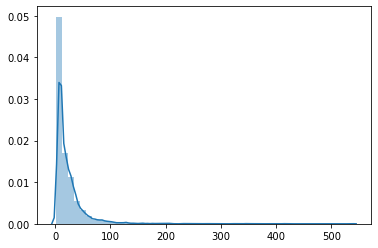

In [11]:
sns.distplot(center_line_lens_list)

In [12]:
conseq_dists = []
sparsely_sampled_lane_ids = []
for i, center_line in enumerate(lanes_crosswalks['lanes']['center_line']):
    for i in range(len(center_line) - 1):
        steps = center_line[i + 1] - center_line[i]
        dist_next = np.hypot(steps[0], steps[1])
        conseq_dists.append(dist_next)
        if dist_next > 10:
            sparsely_sampled_lane_ids.append(lanes_crosswalks['lanes']['ids'][i])
np.mean(conseq_dists), np.std(conseq_dists), np.max(conseq_dists)

(1.0920736340883022, 3.402733278576619, 181.690196764611)

<AxesSubplot:>

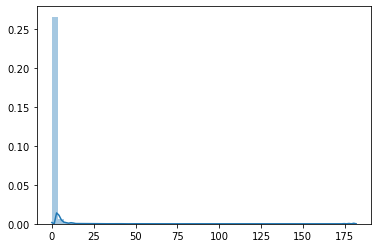

In [13]:
sns.distplot(conseq_dists)

In [14]:
len(sparsely_sampled_lane_ids)

1538

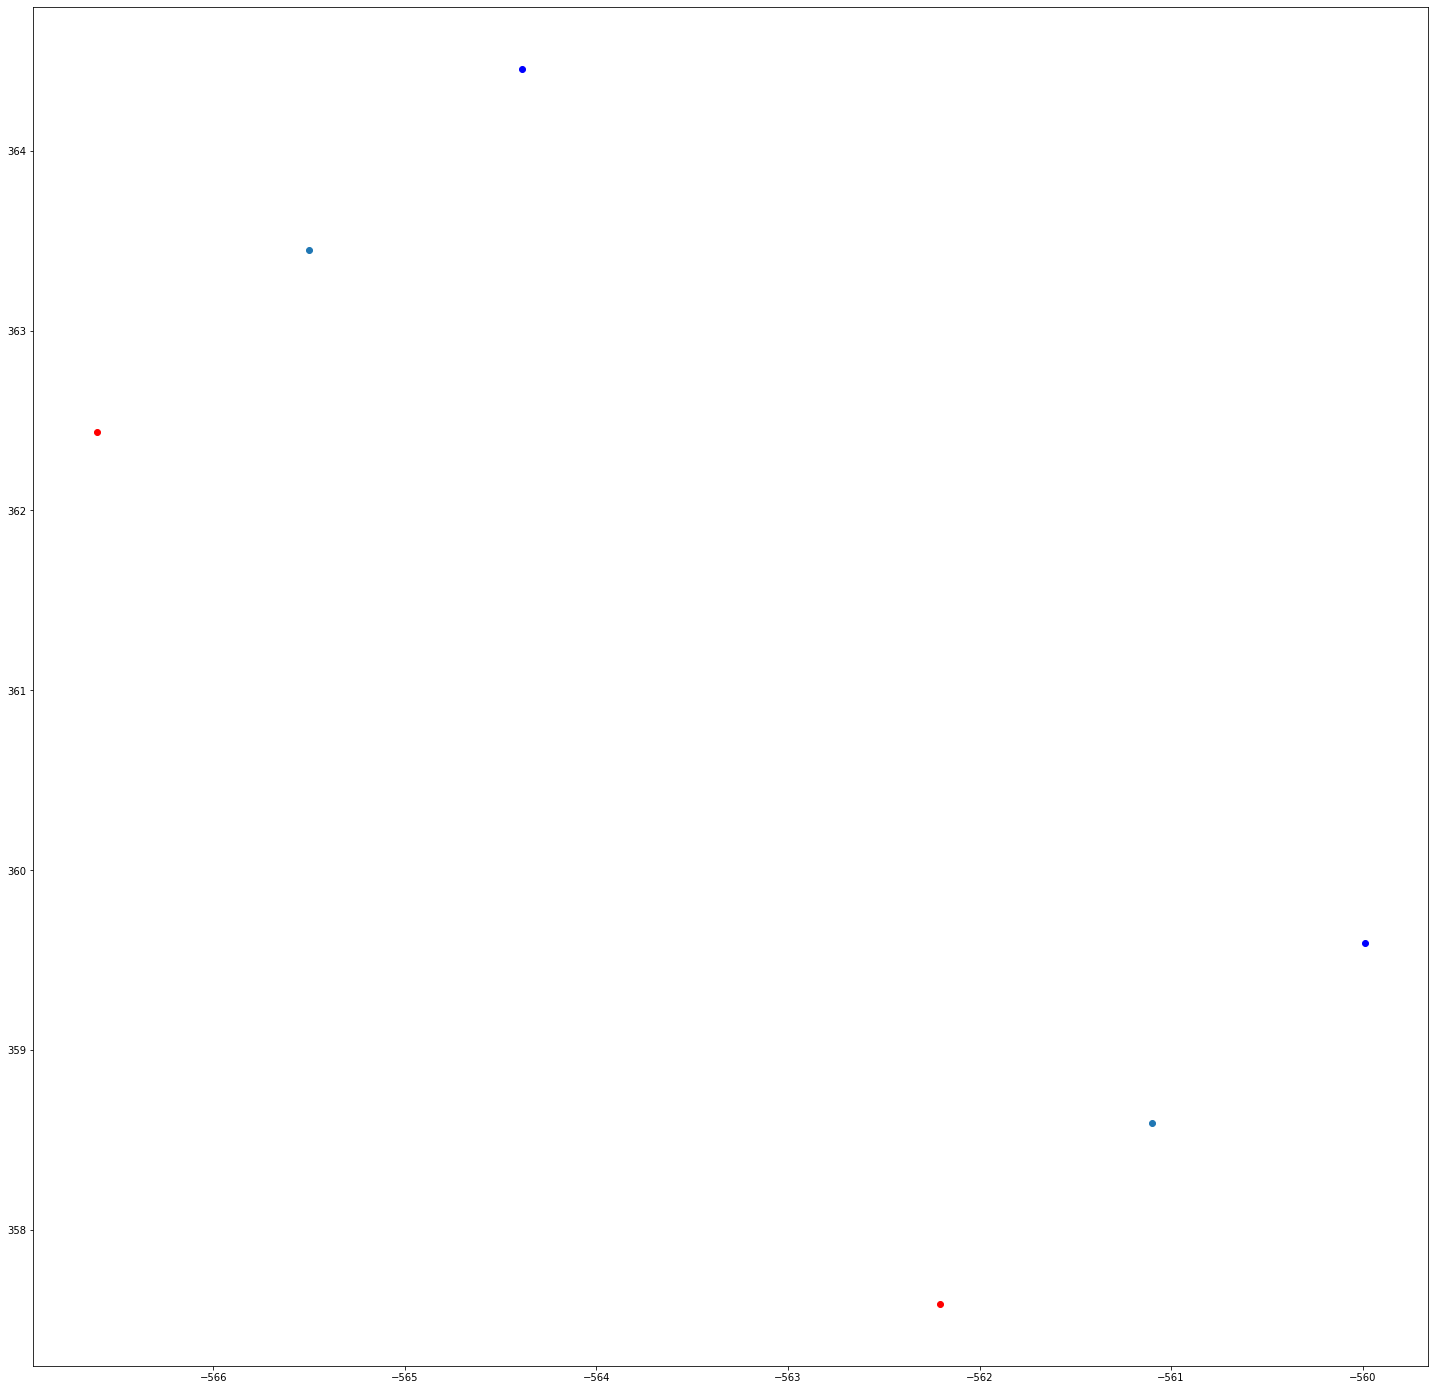

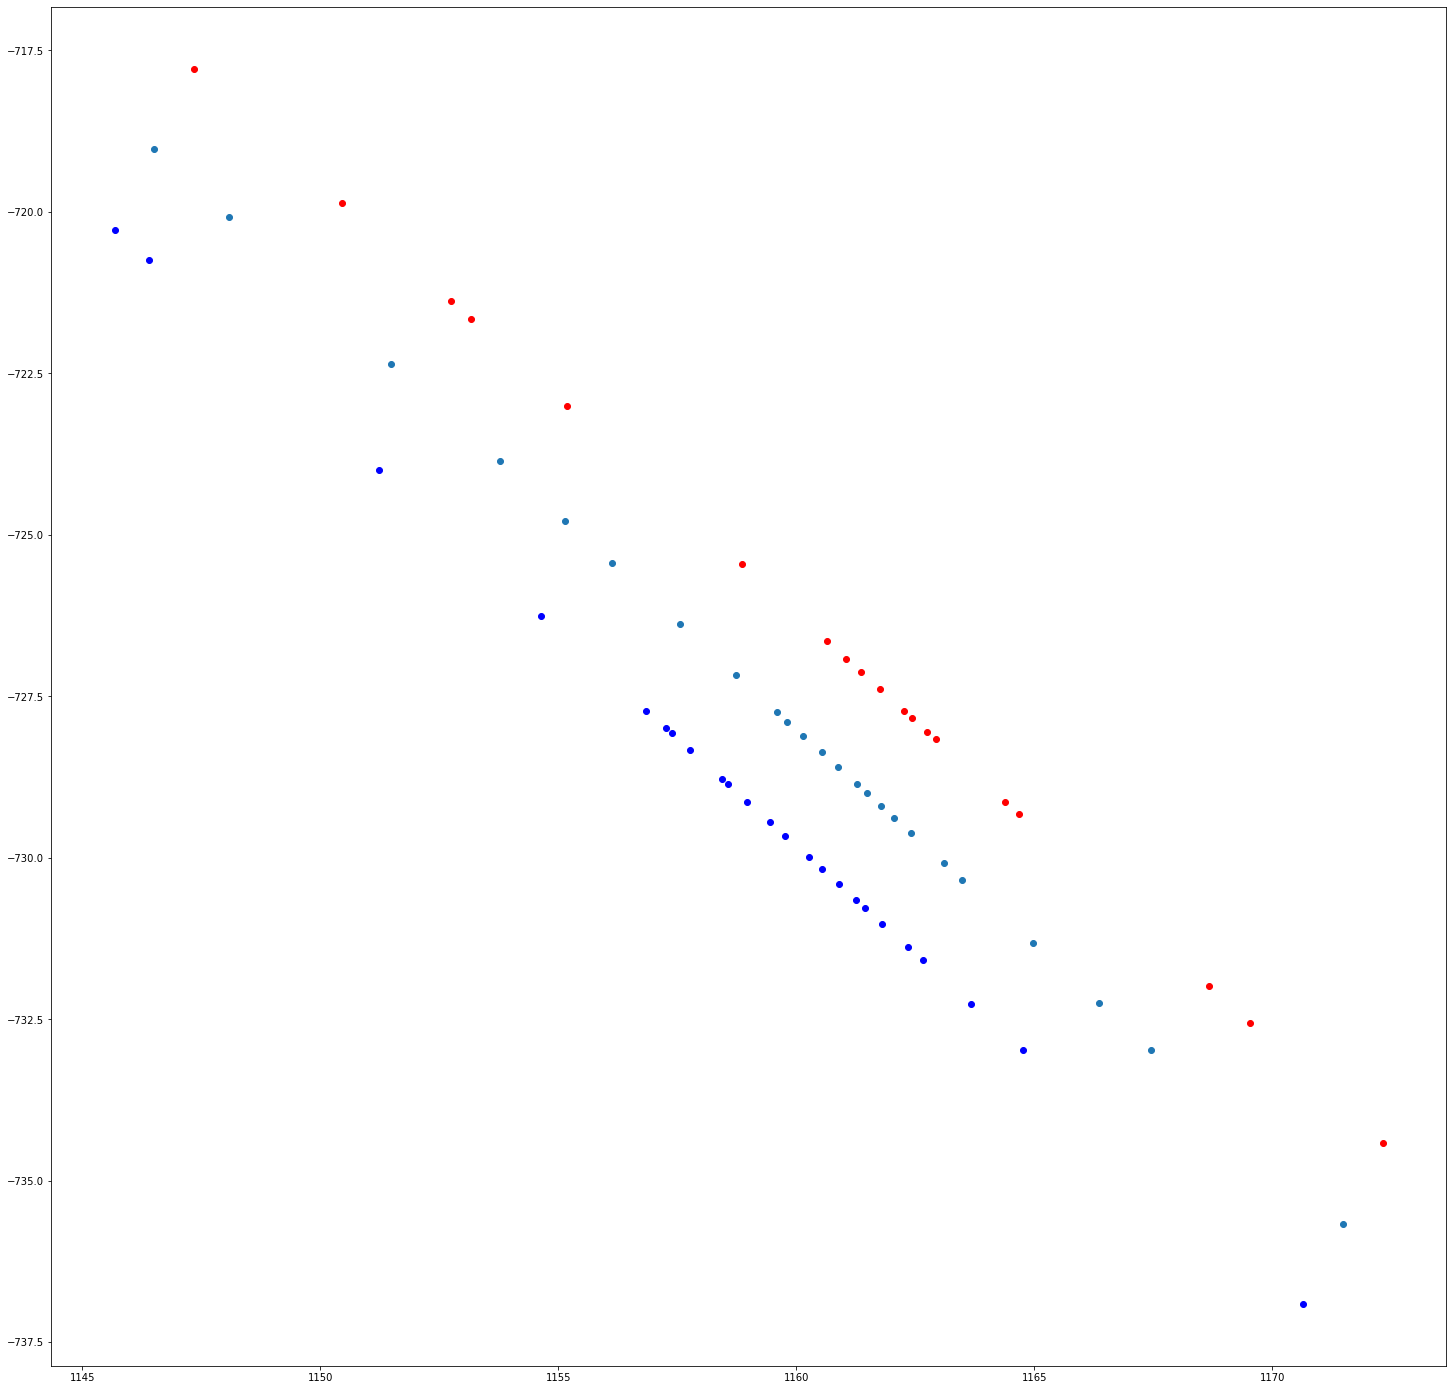

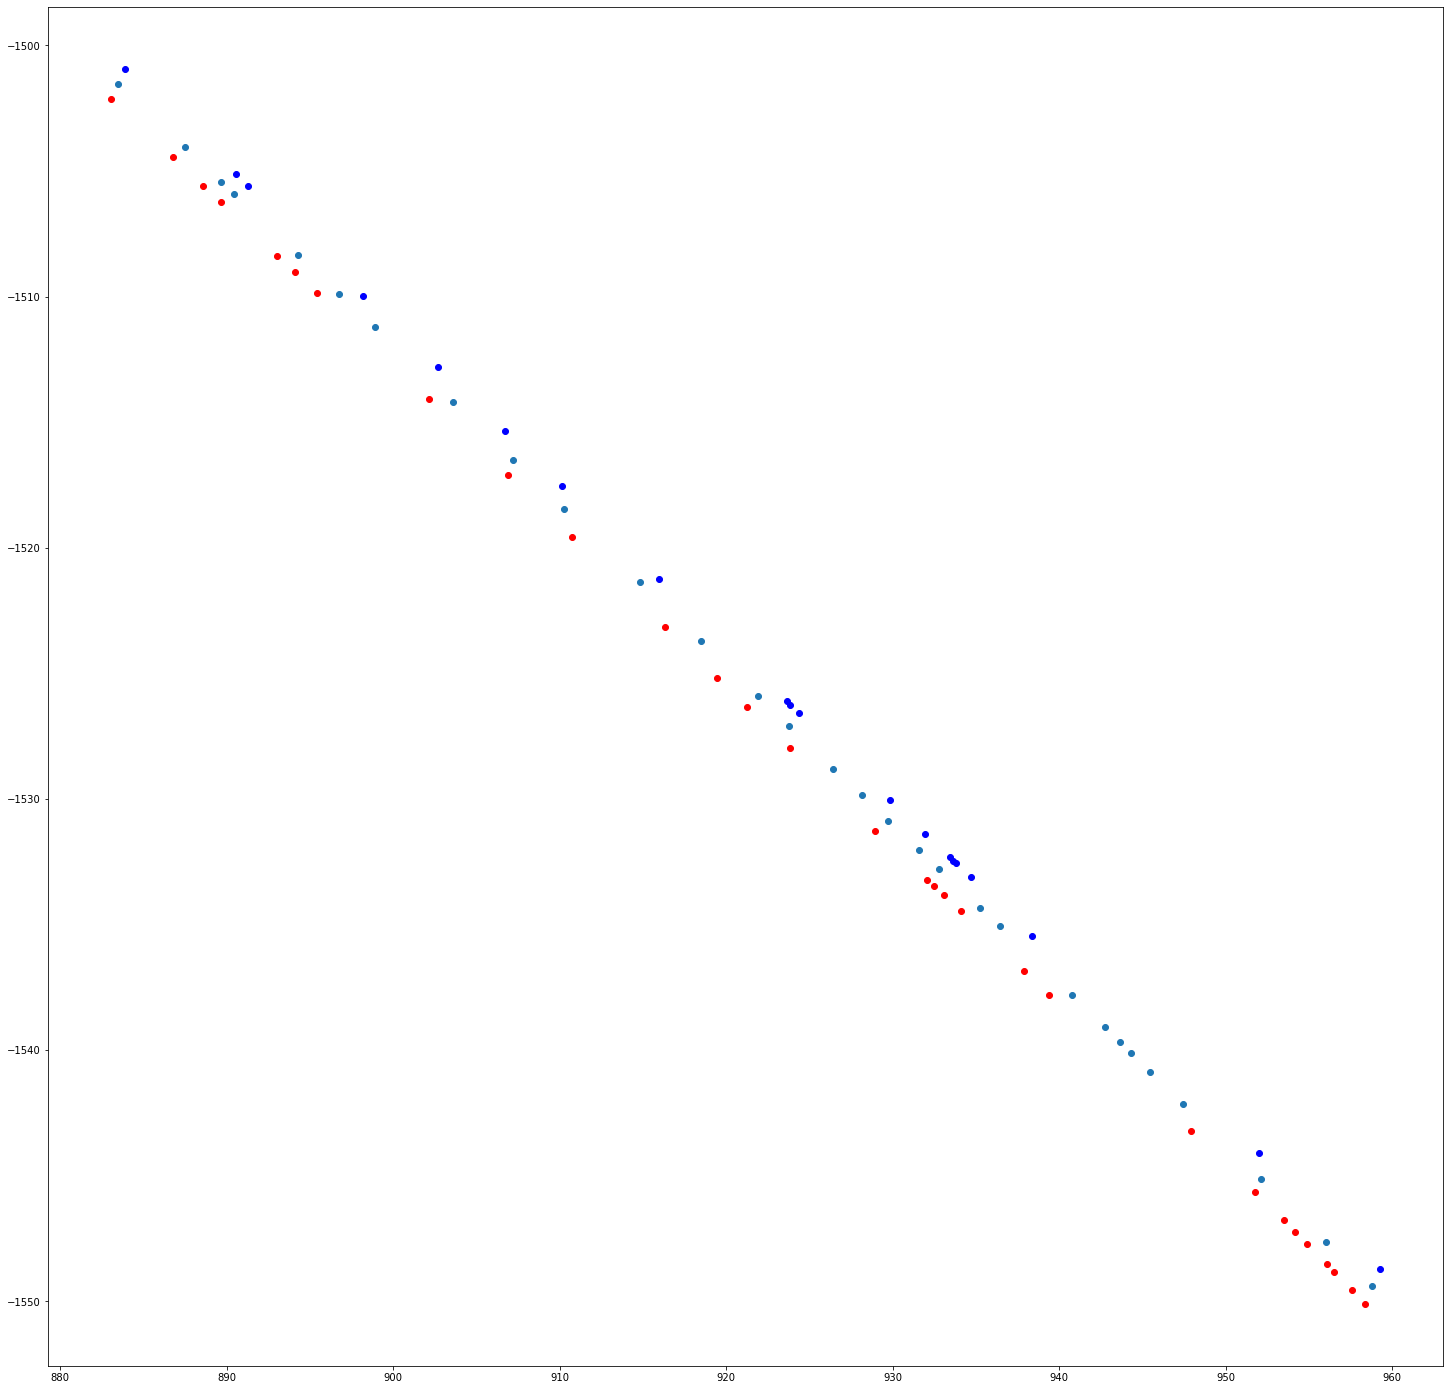

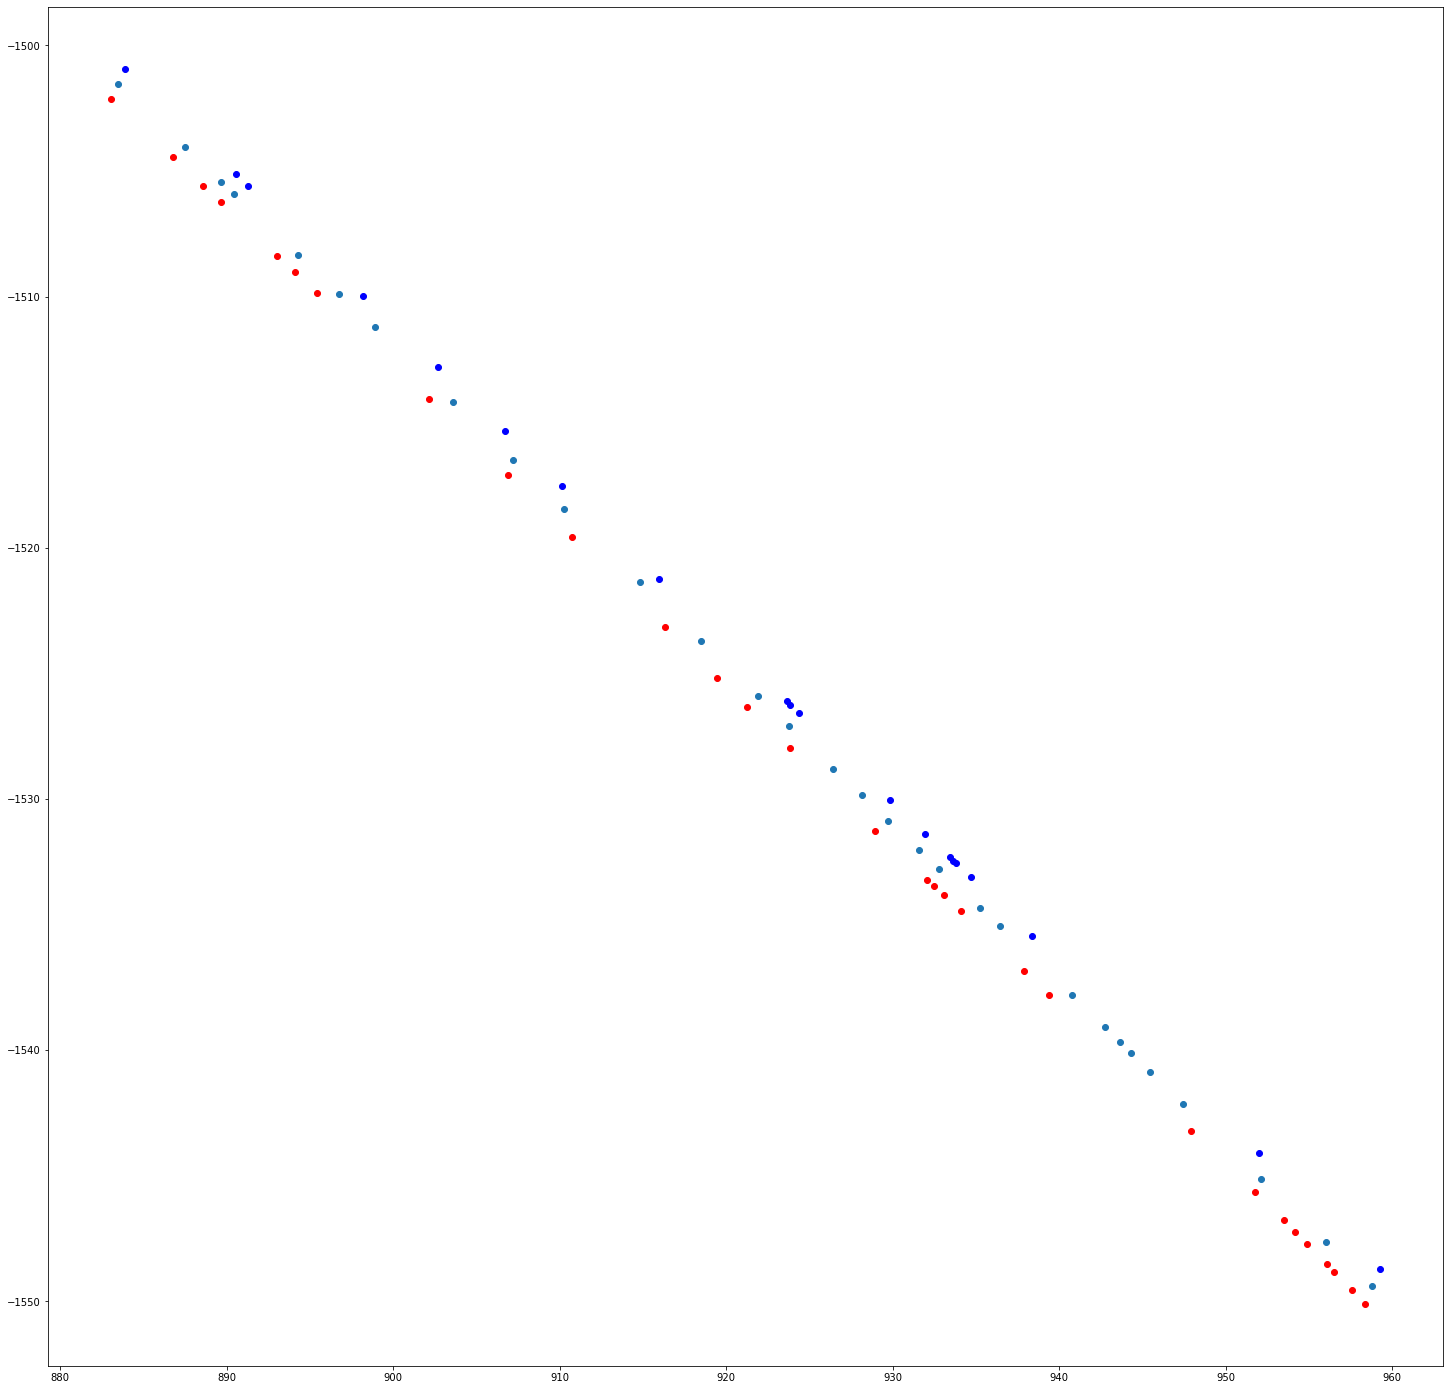

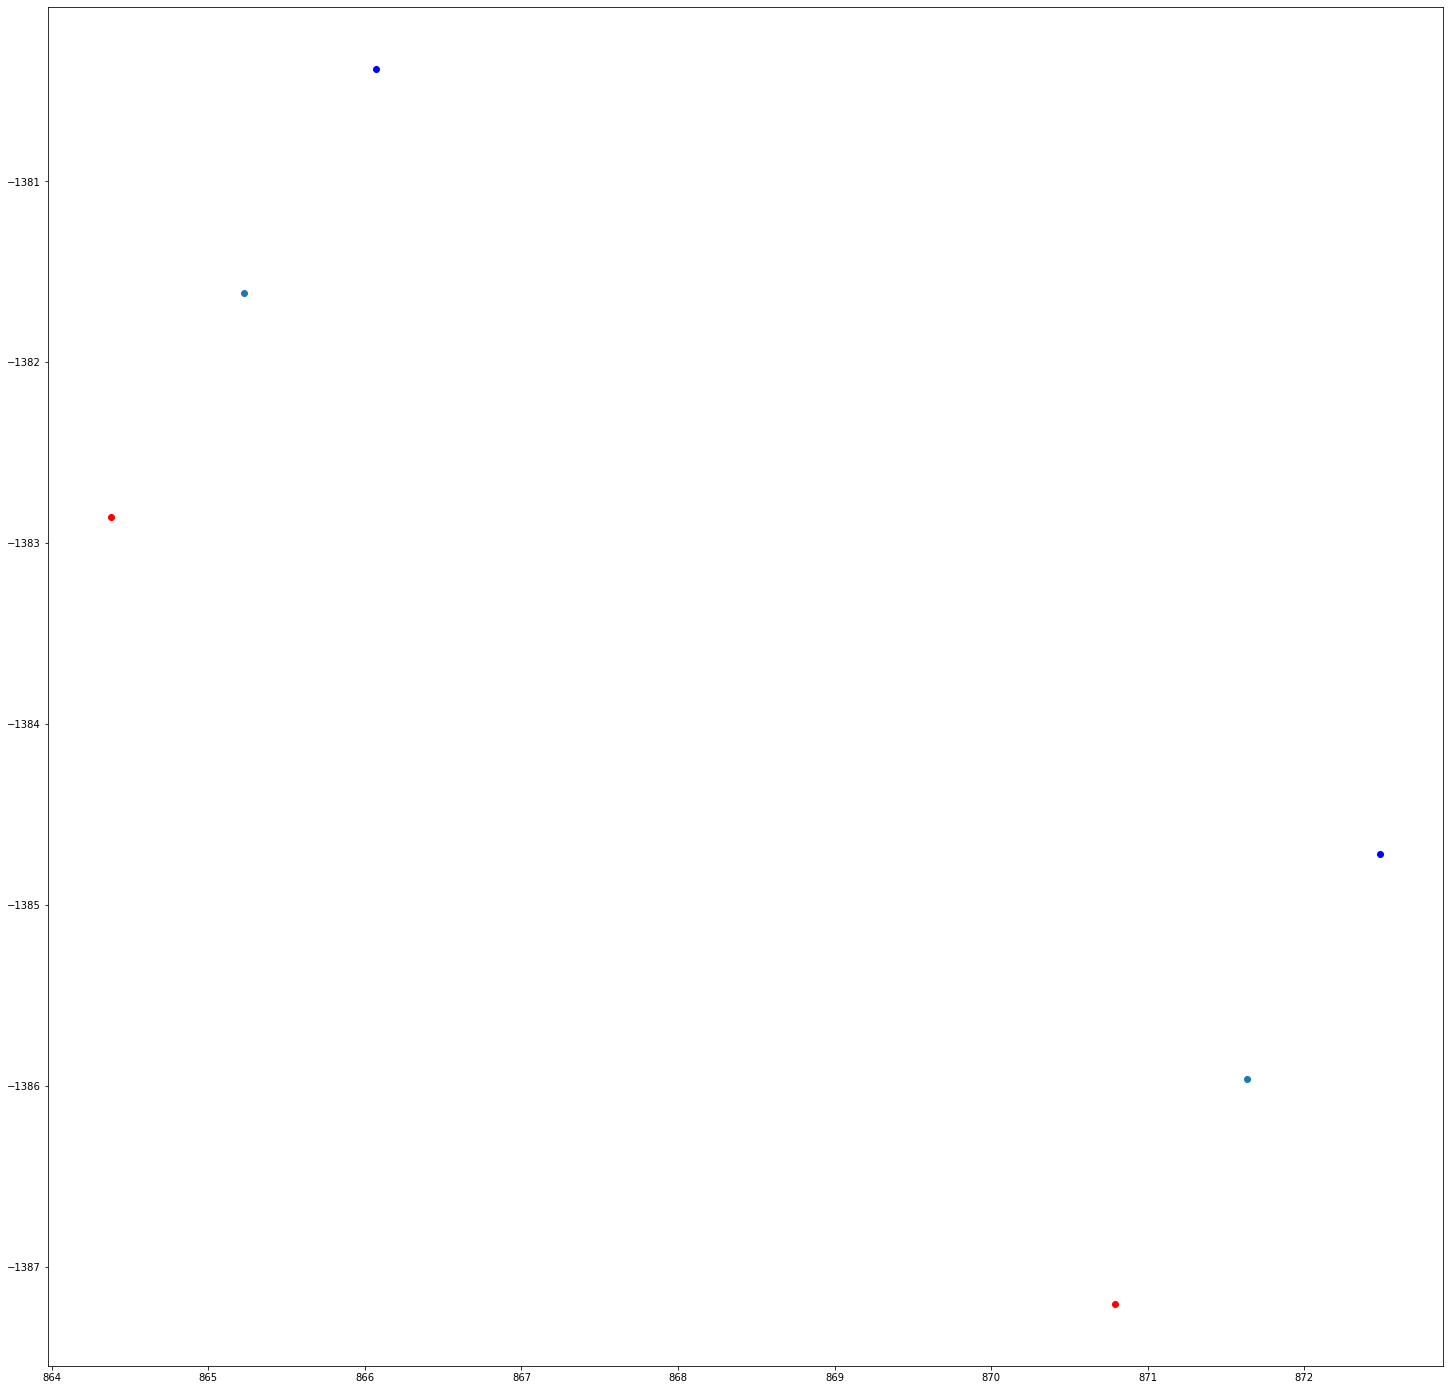

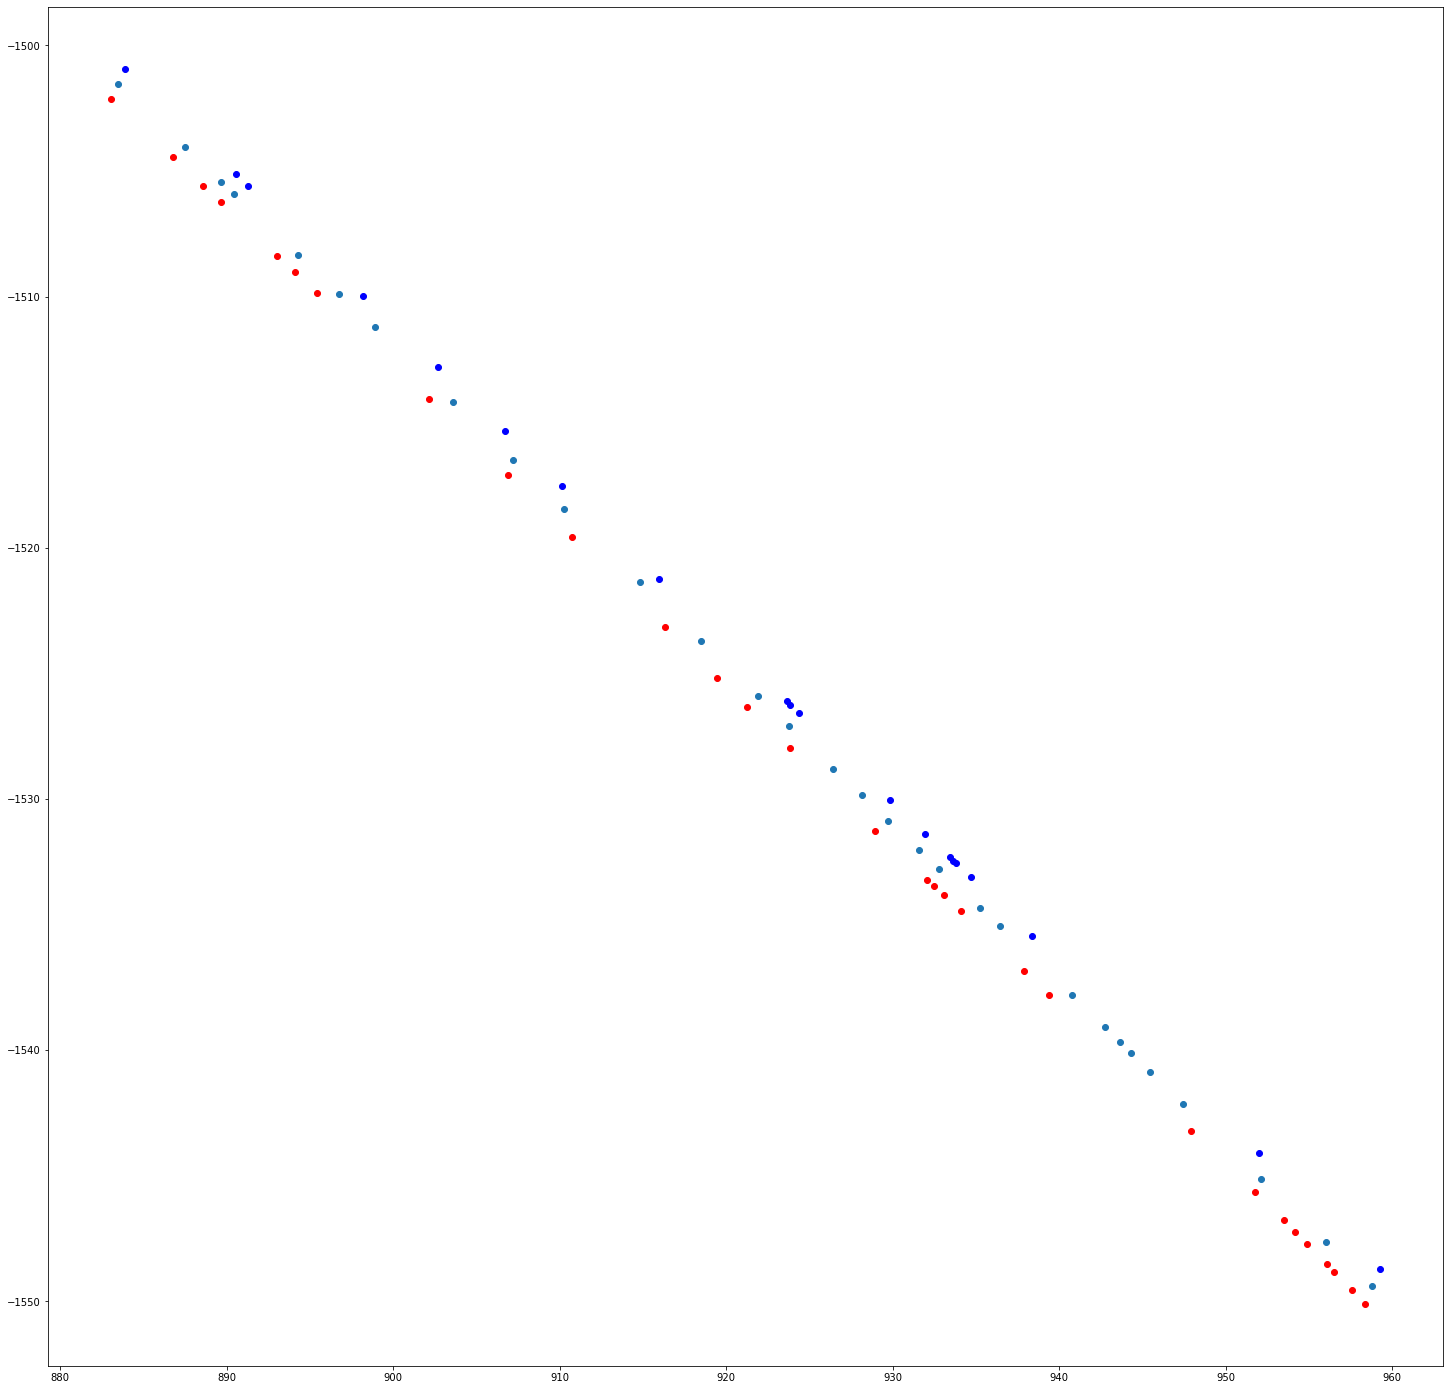

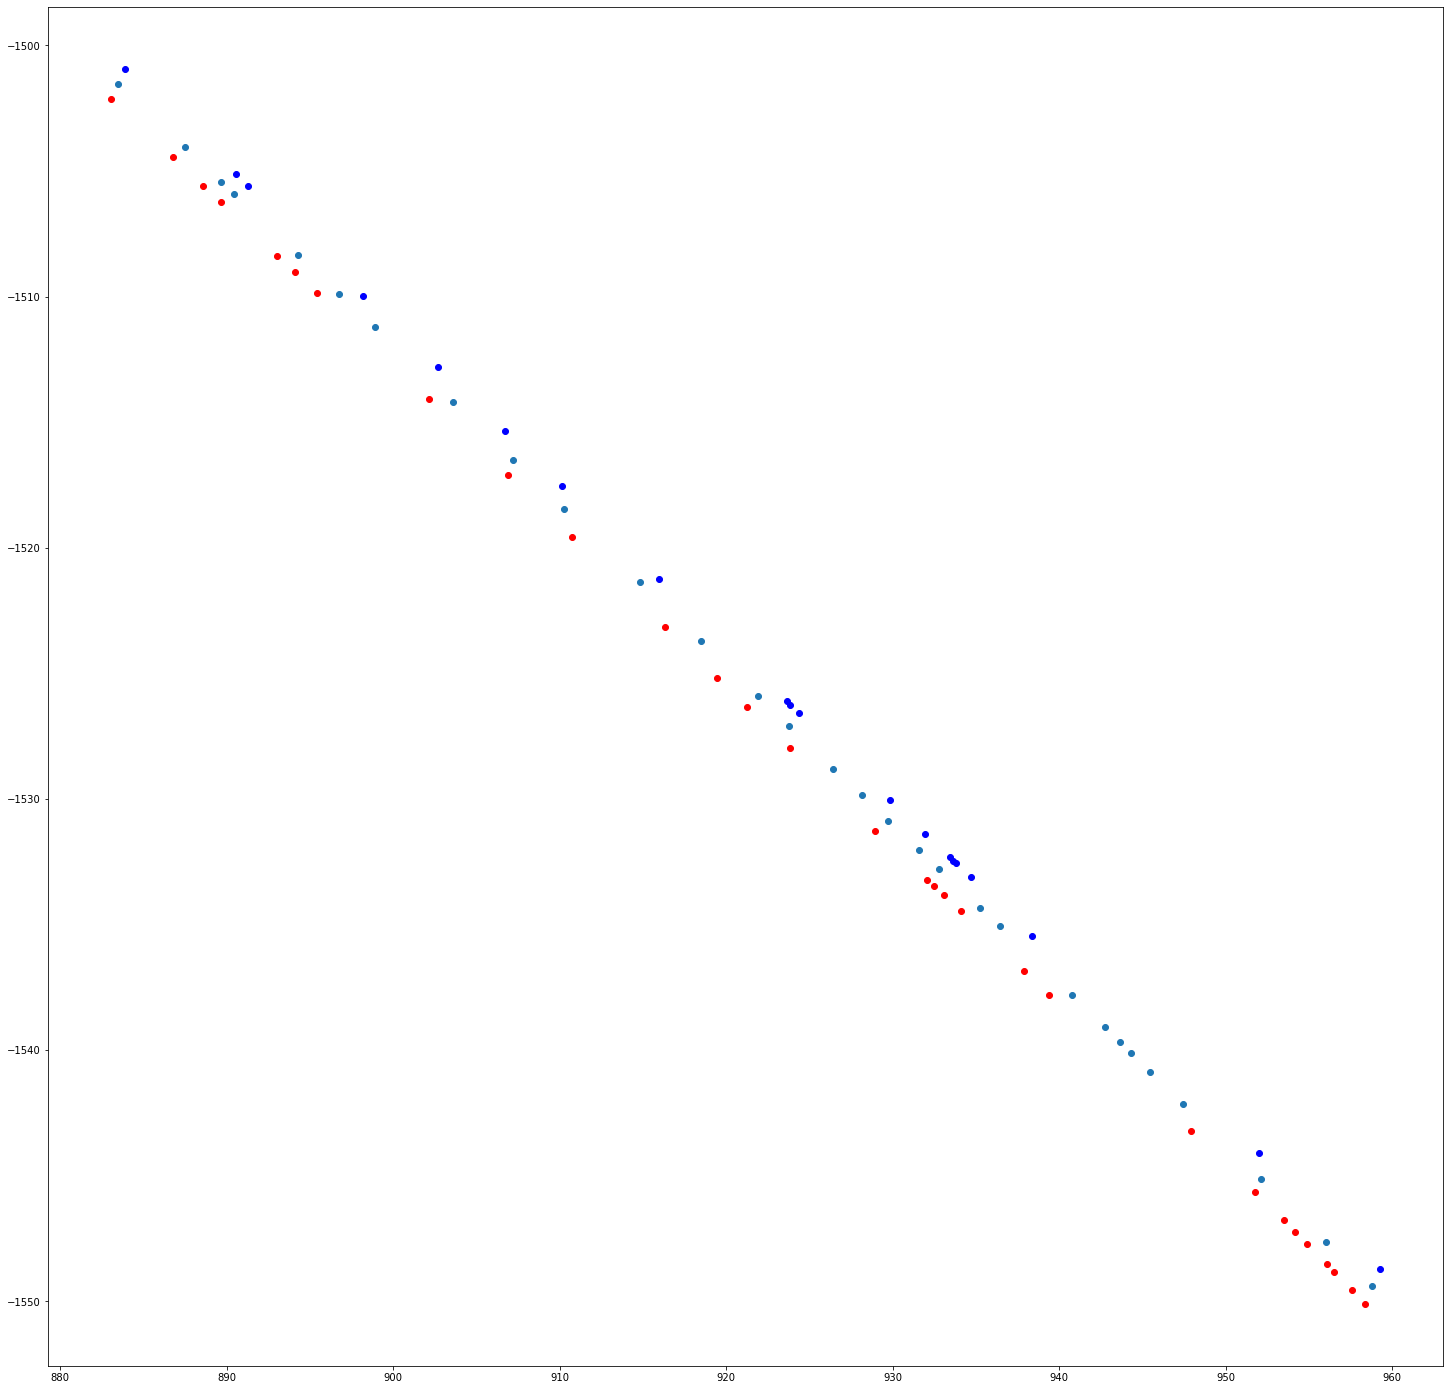

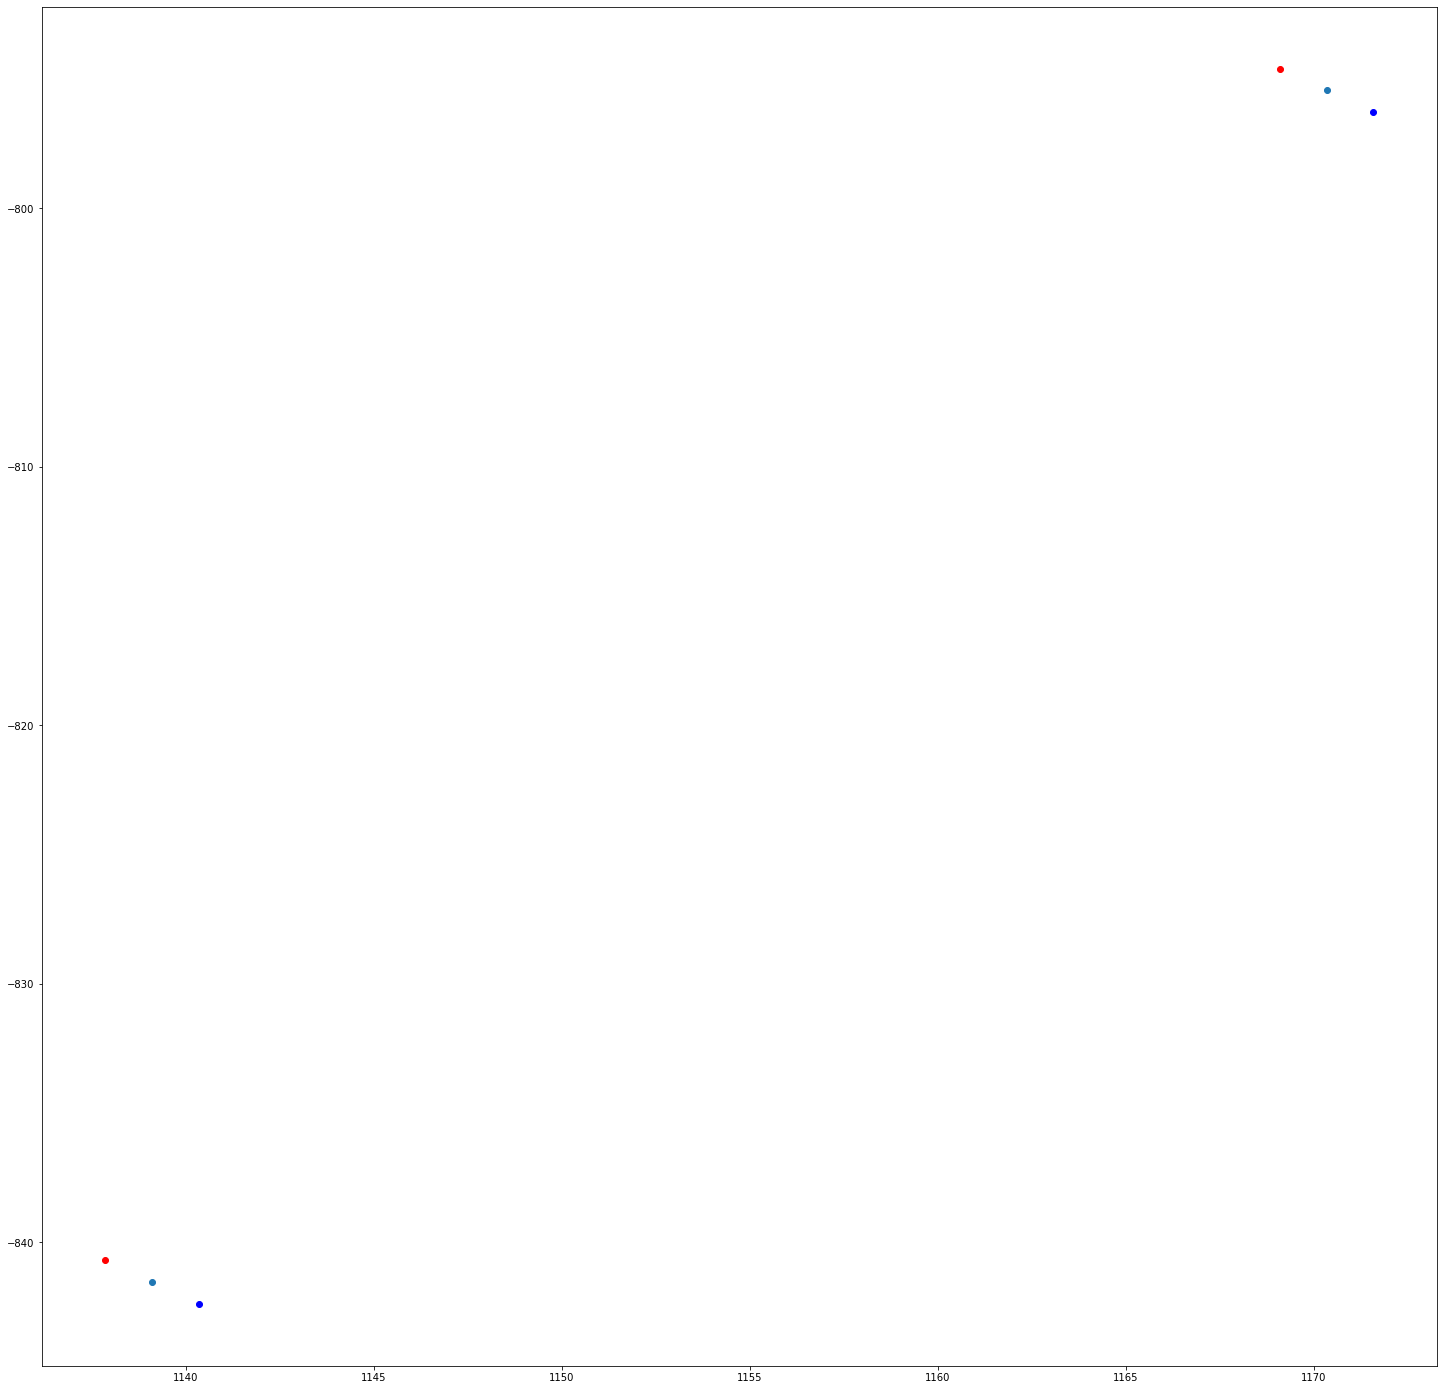

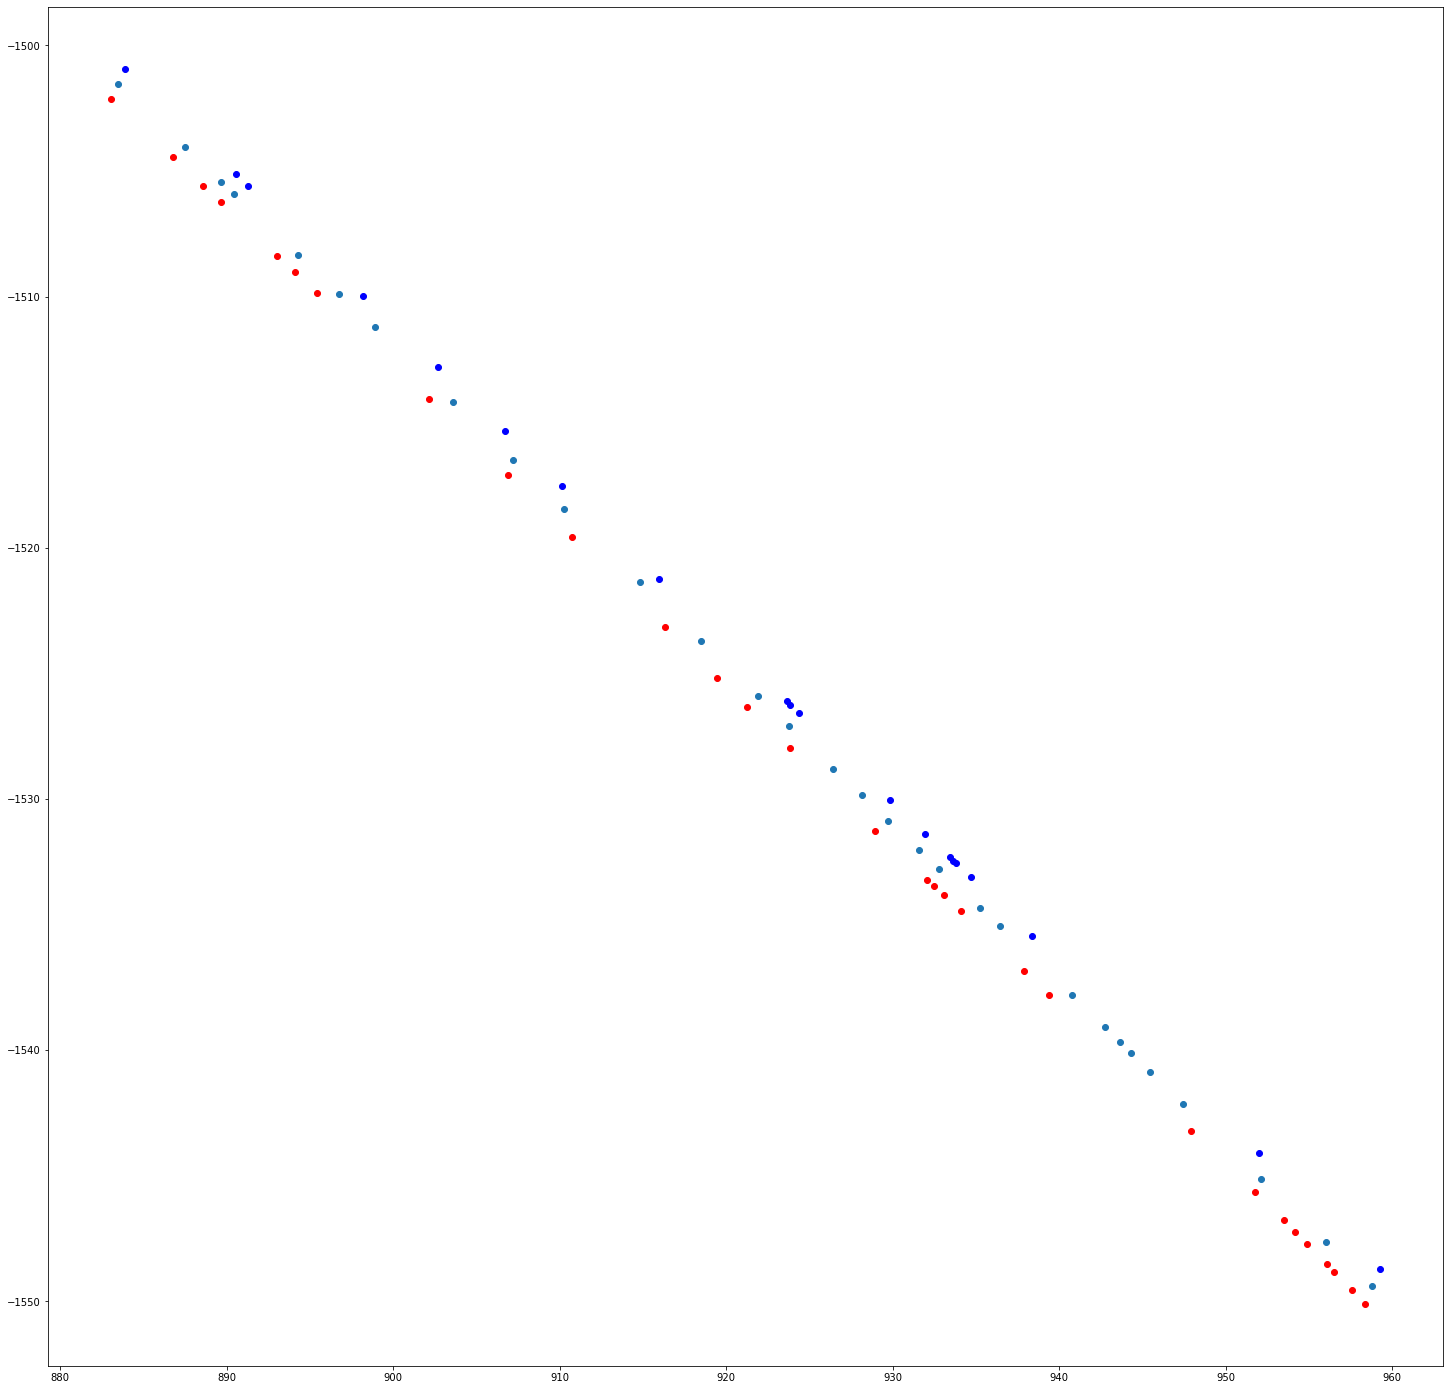

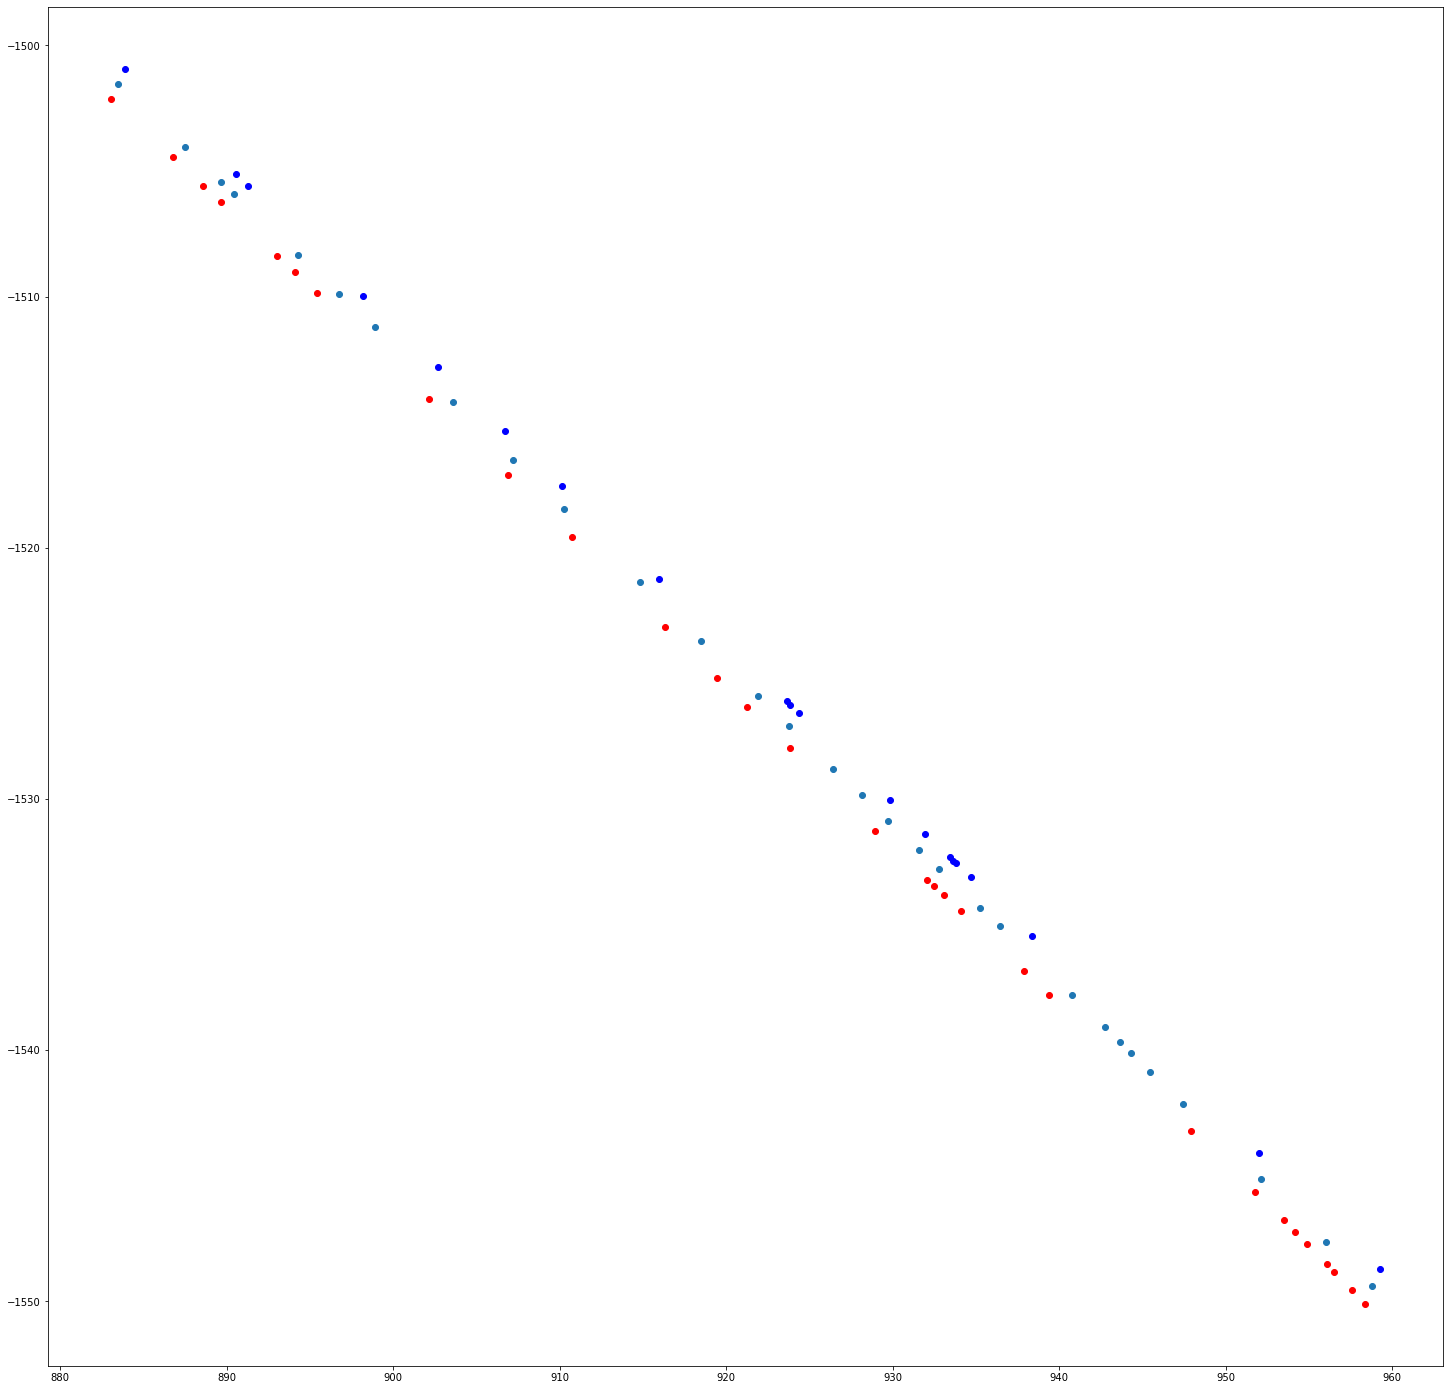

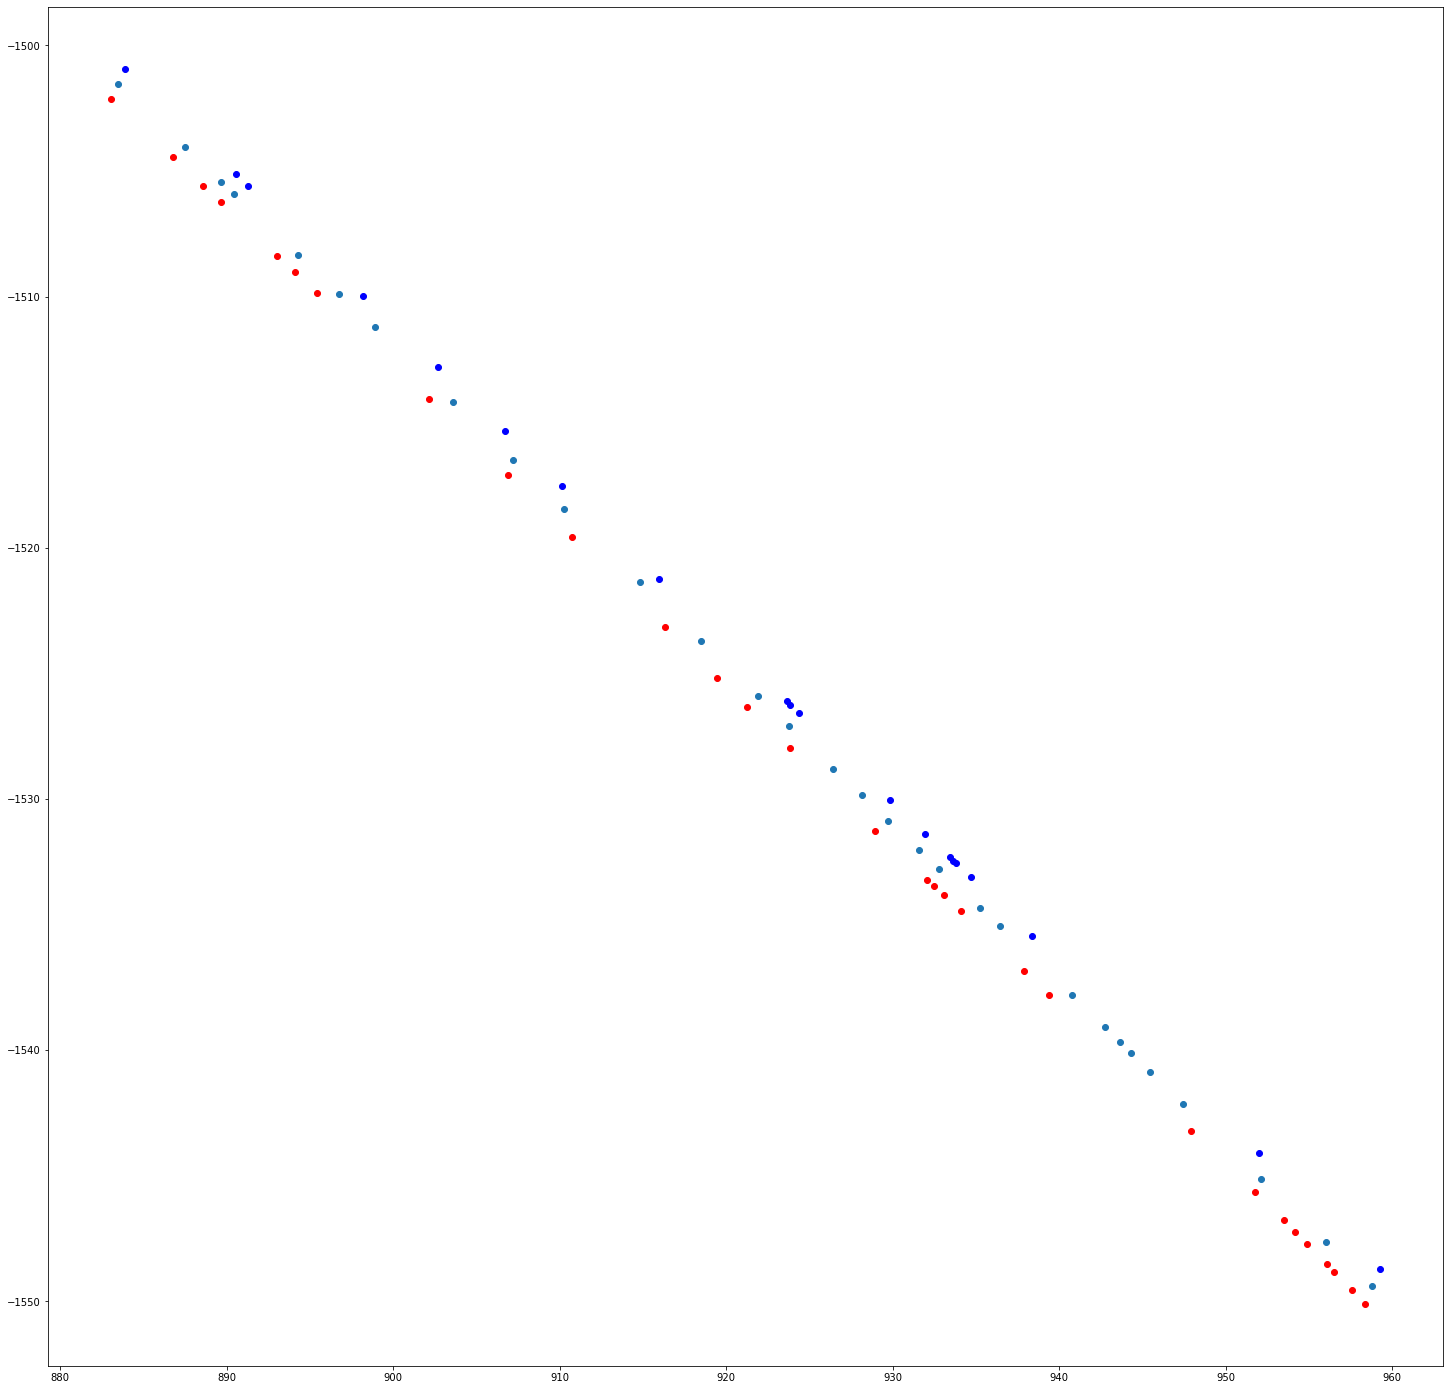

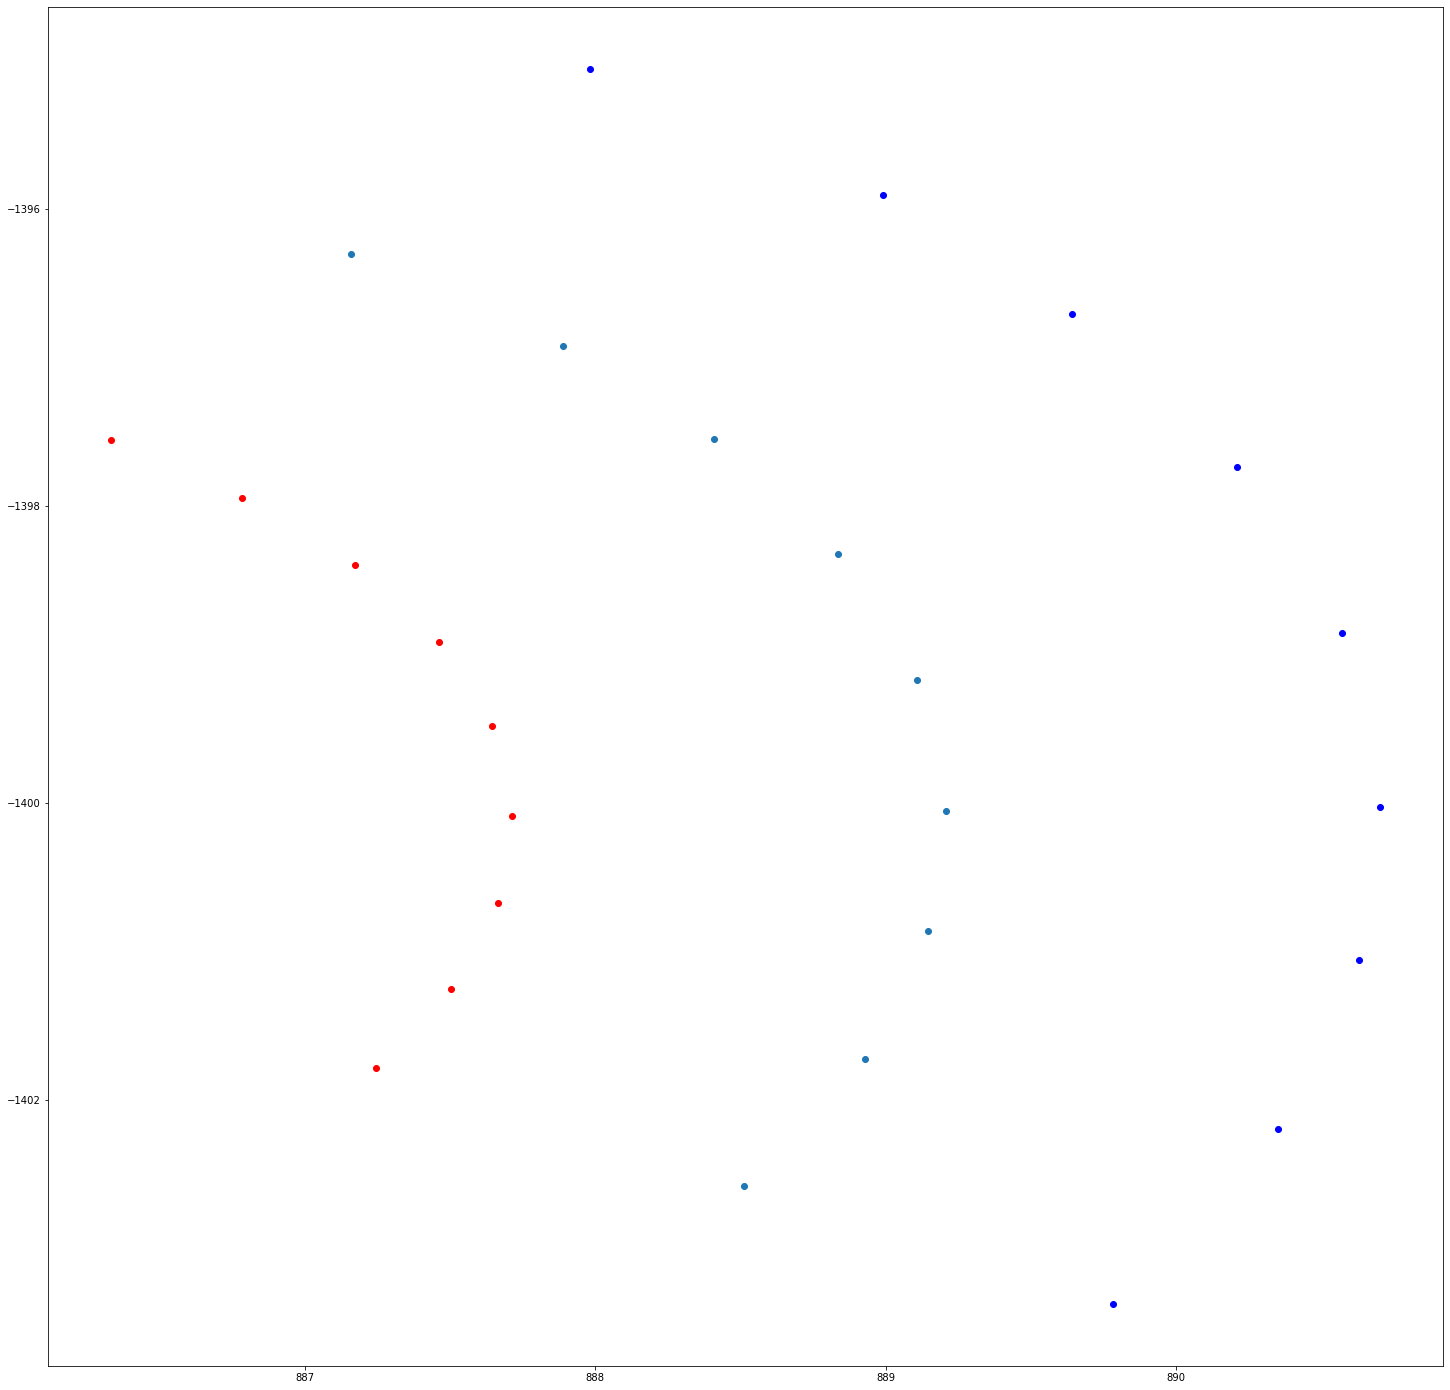

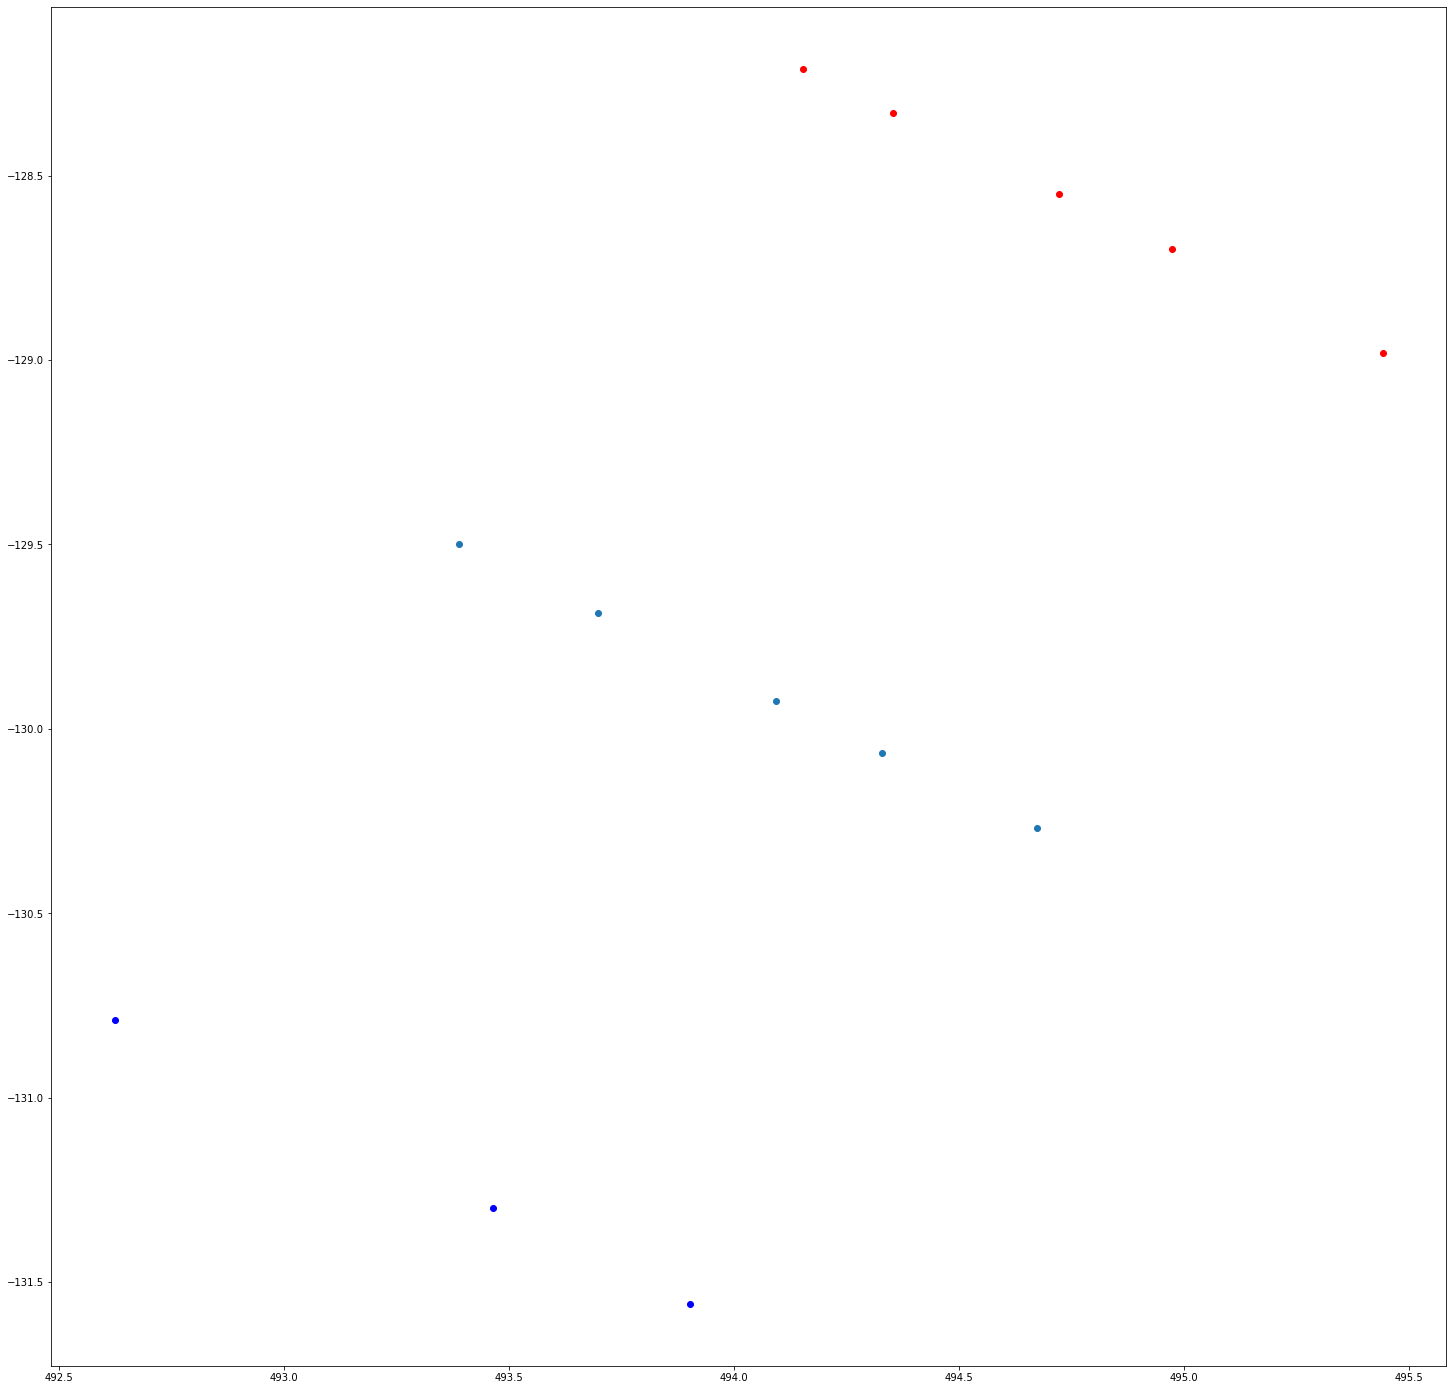

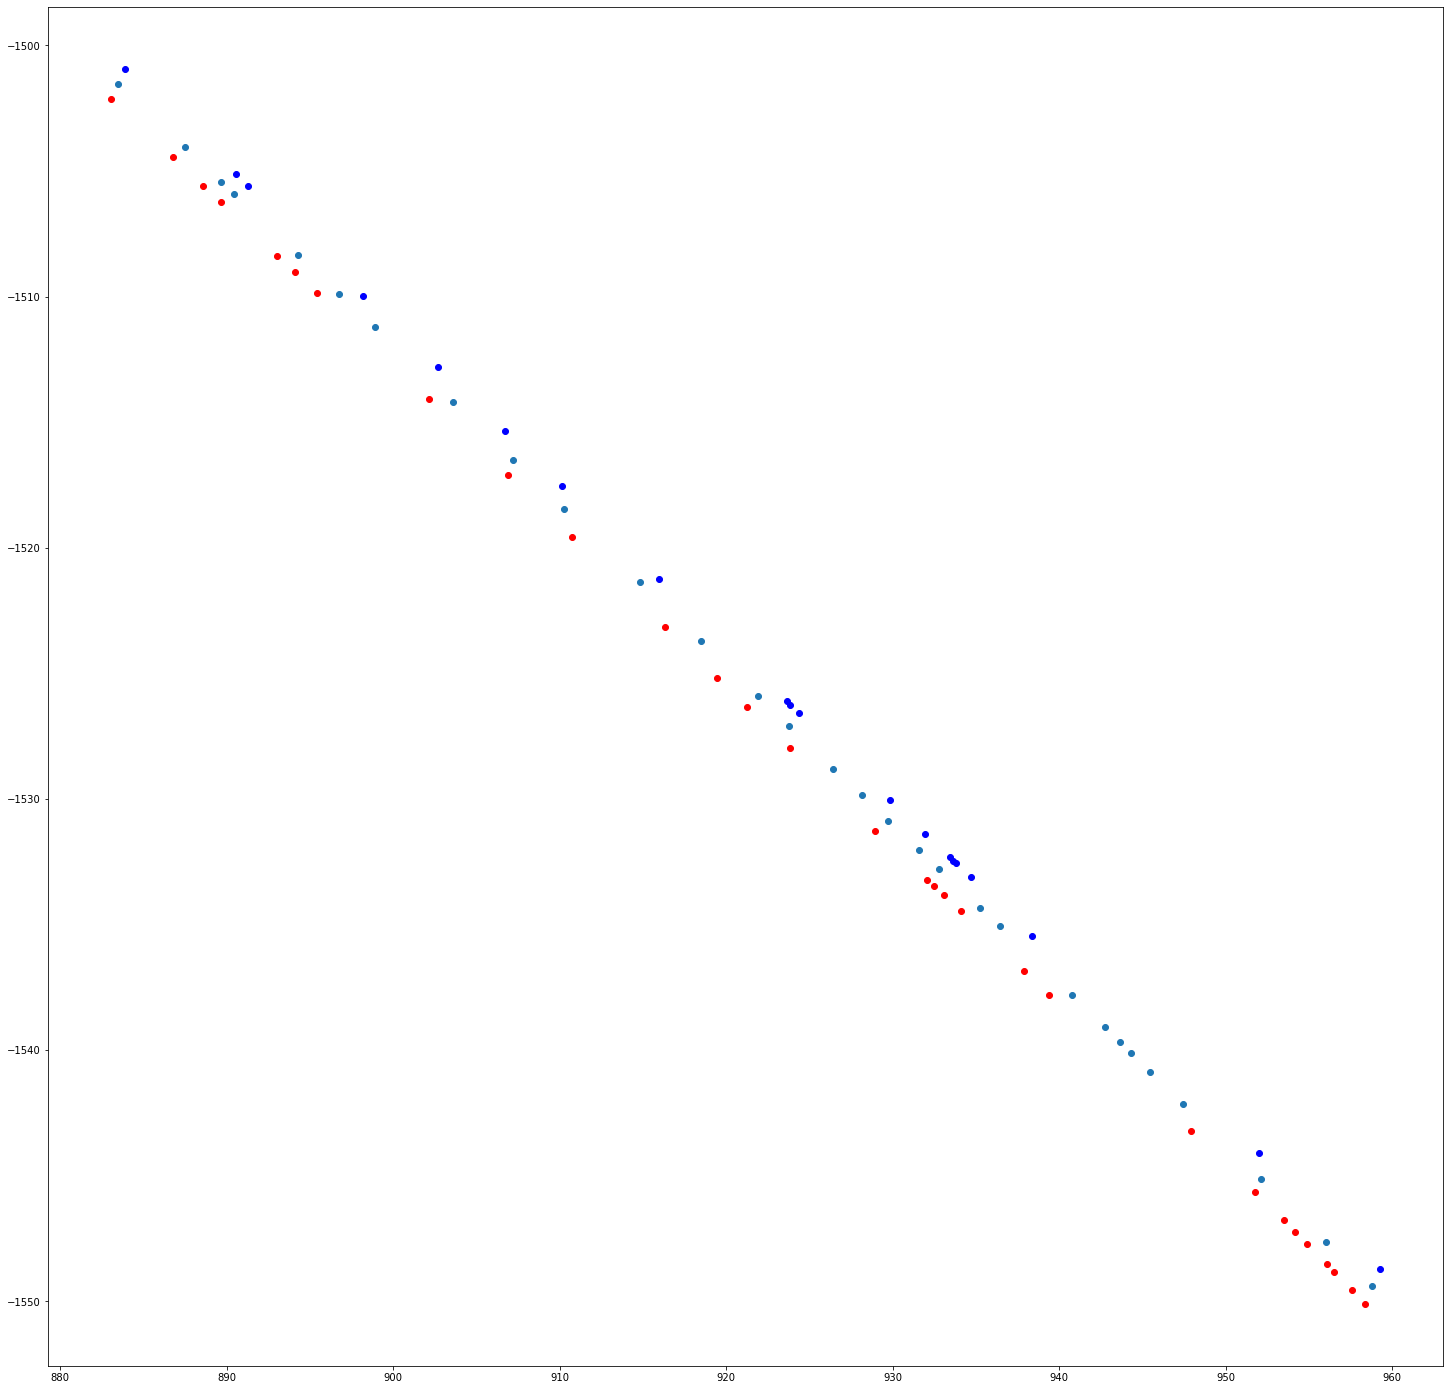

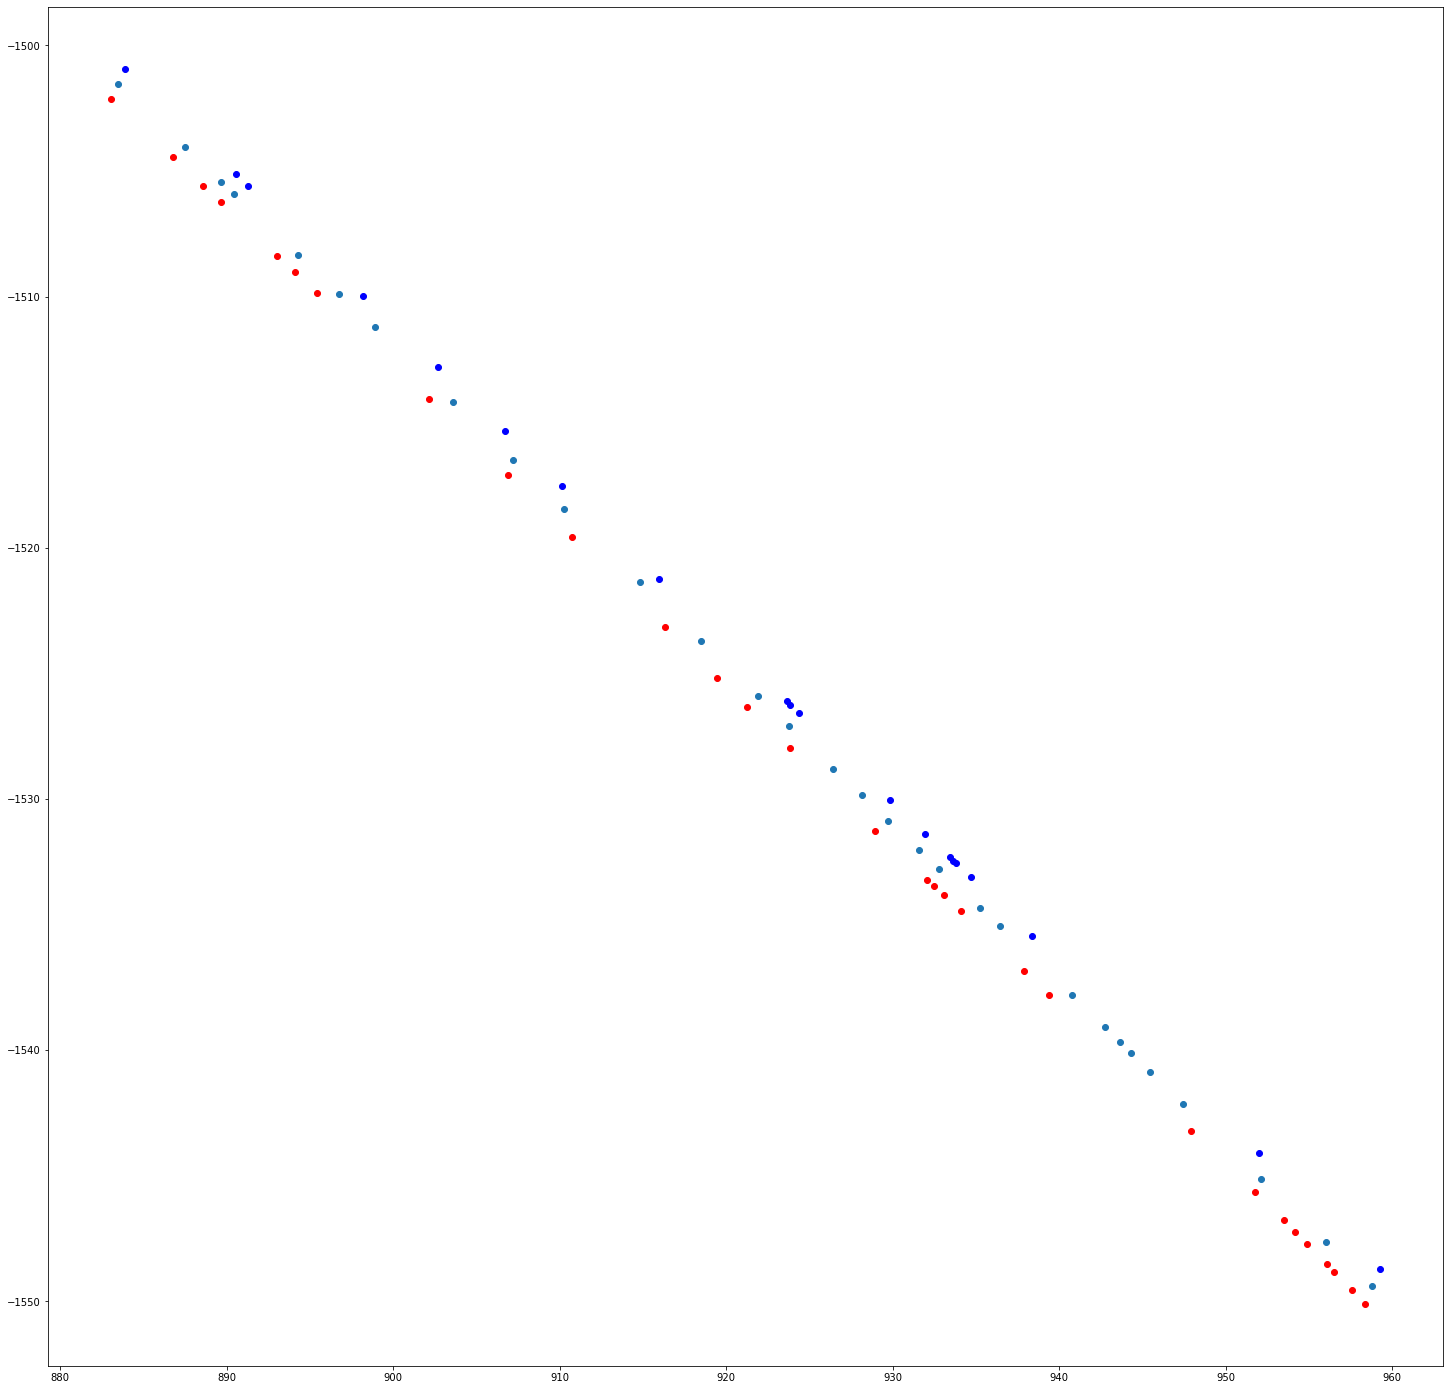

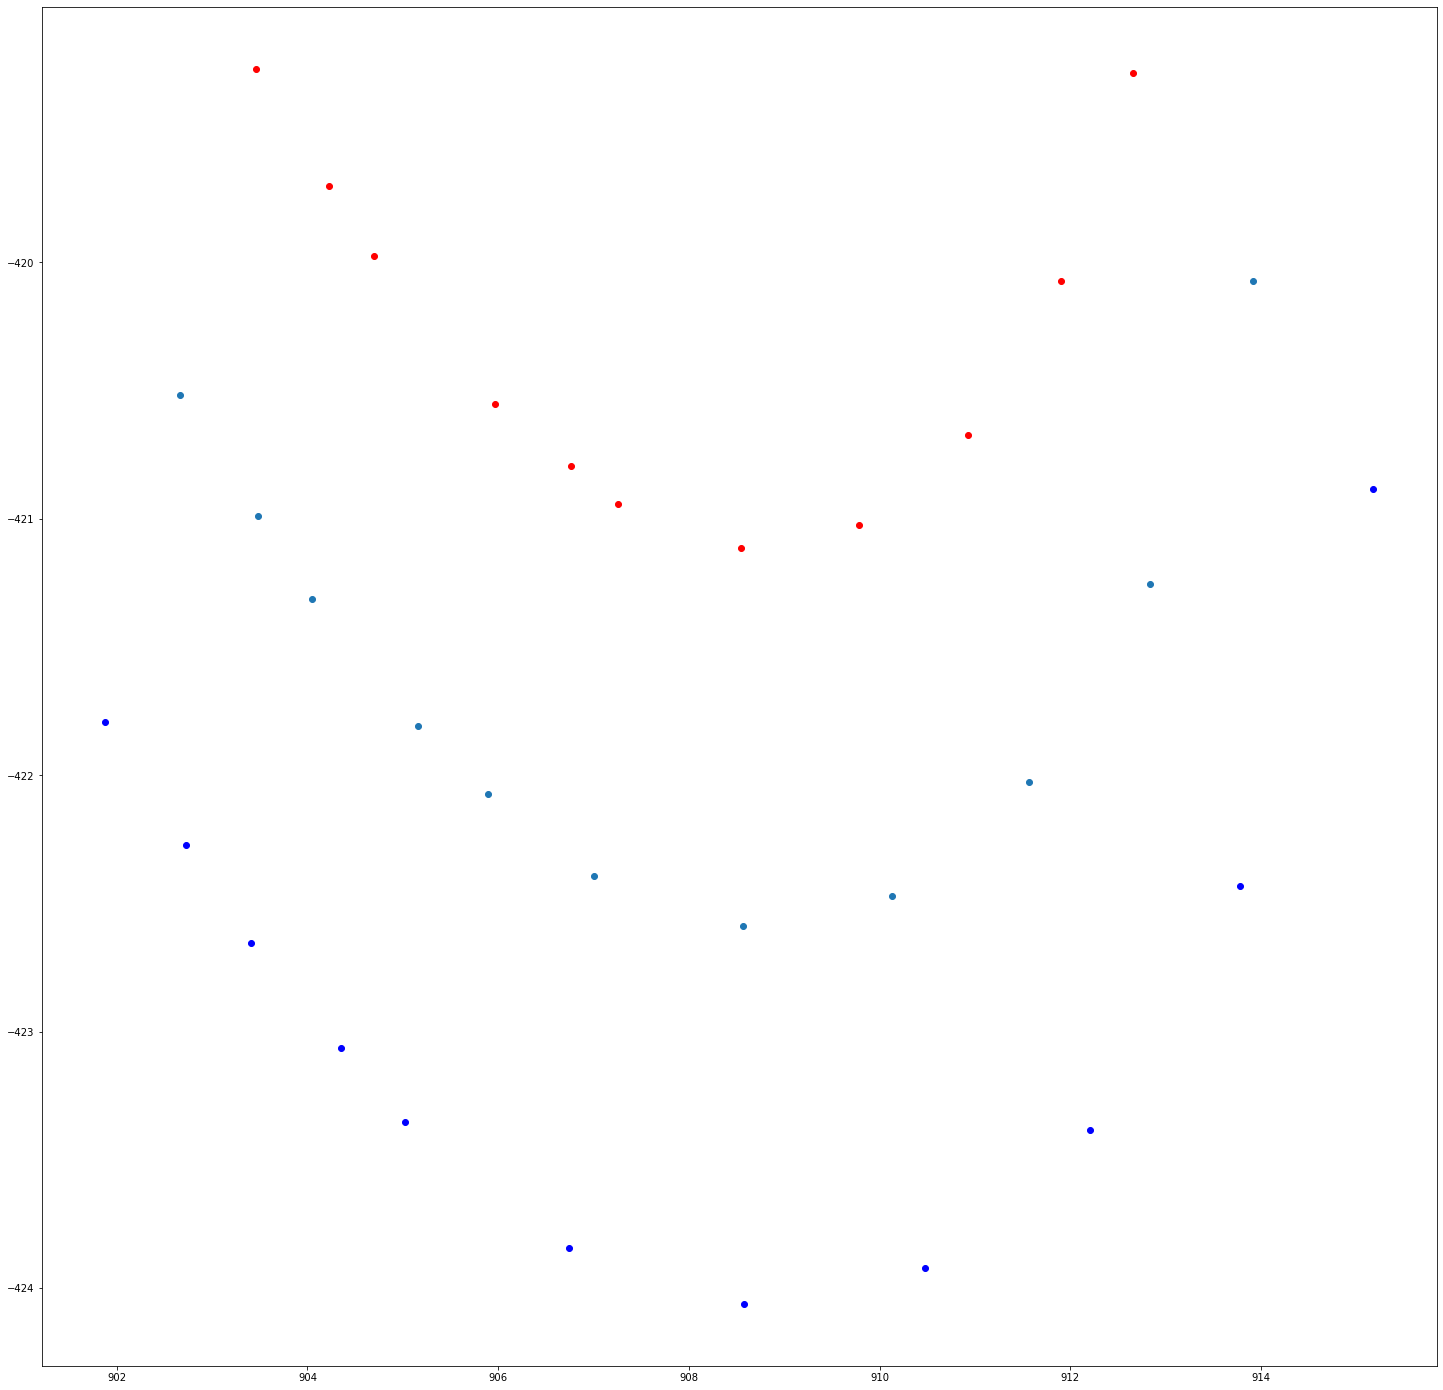

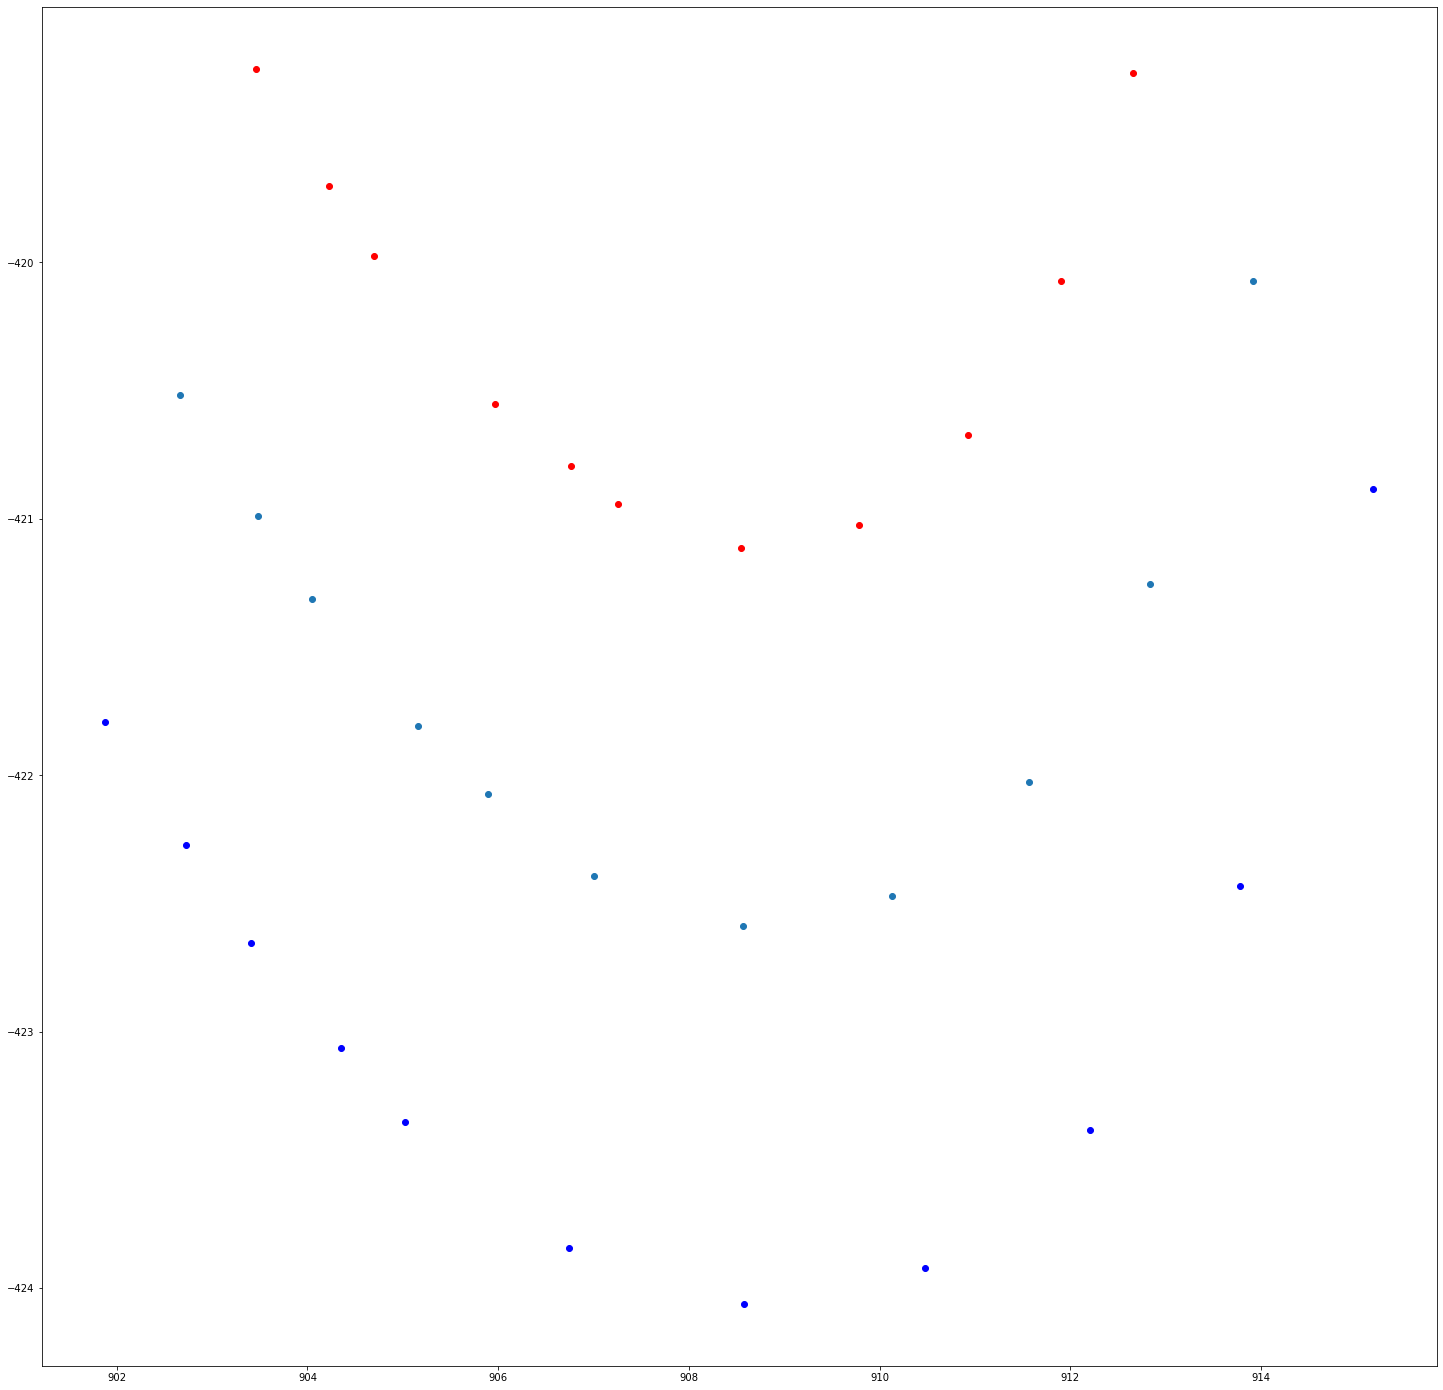

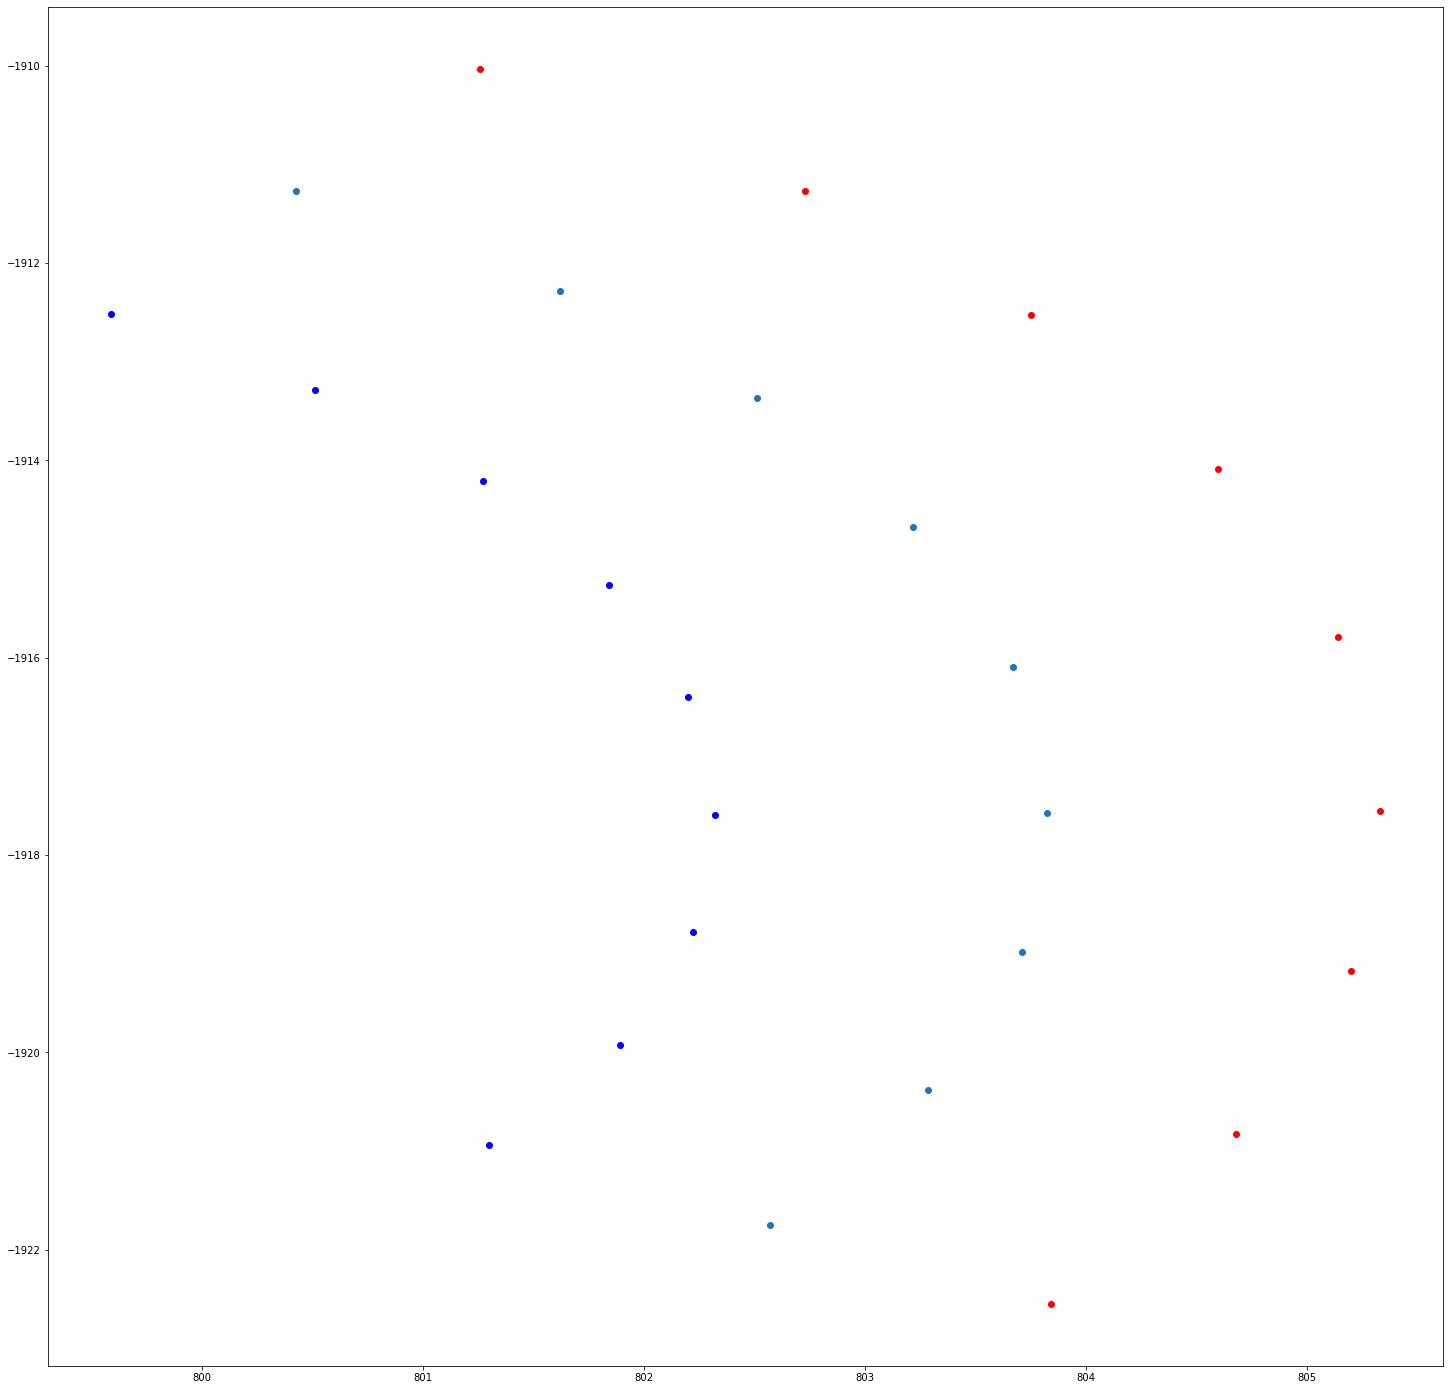

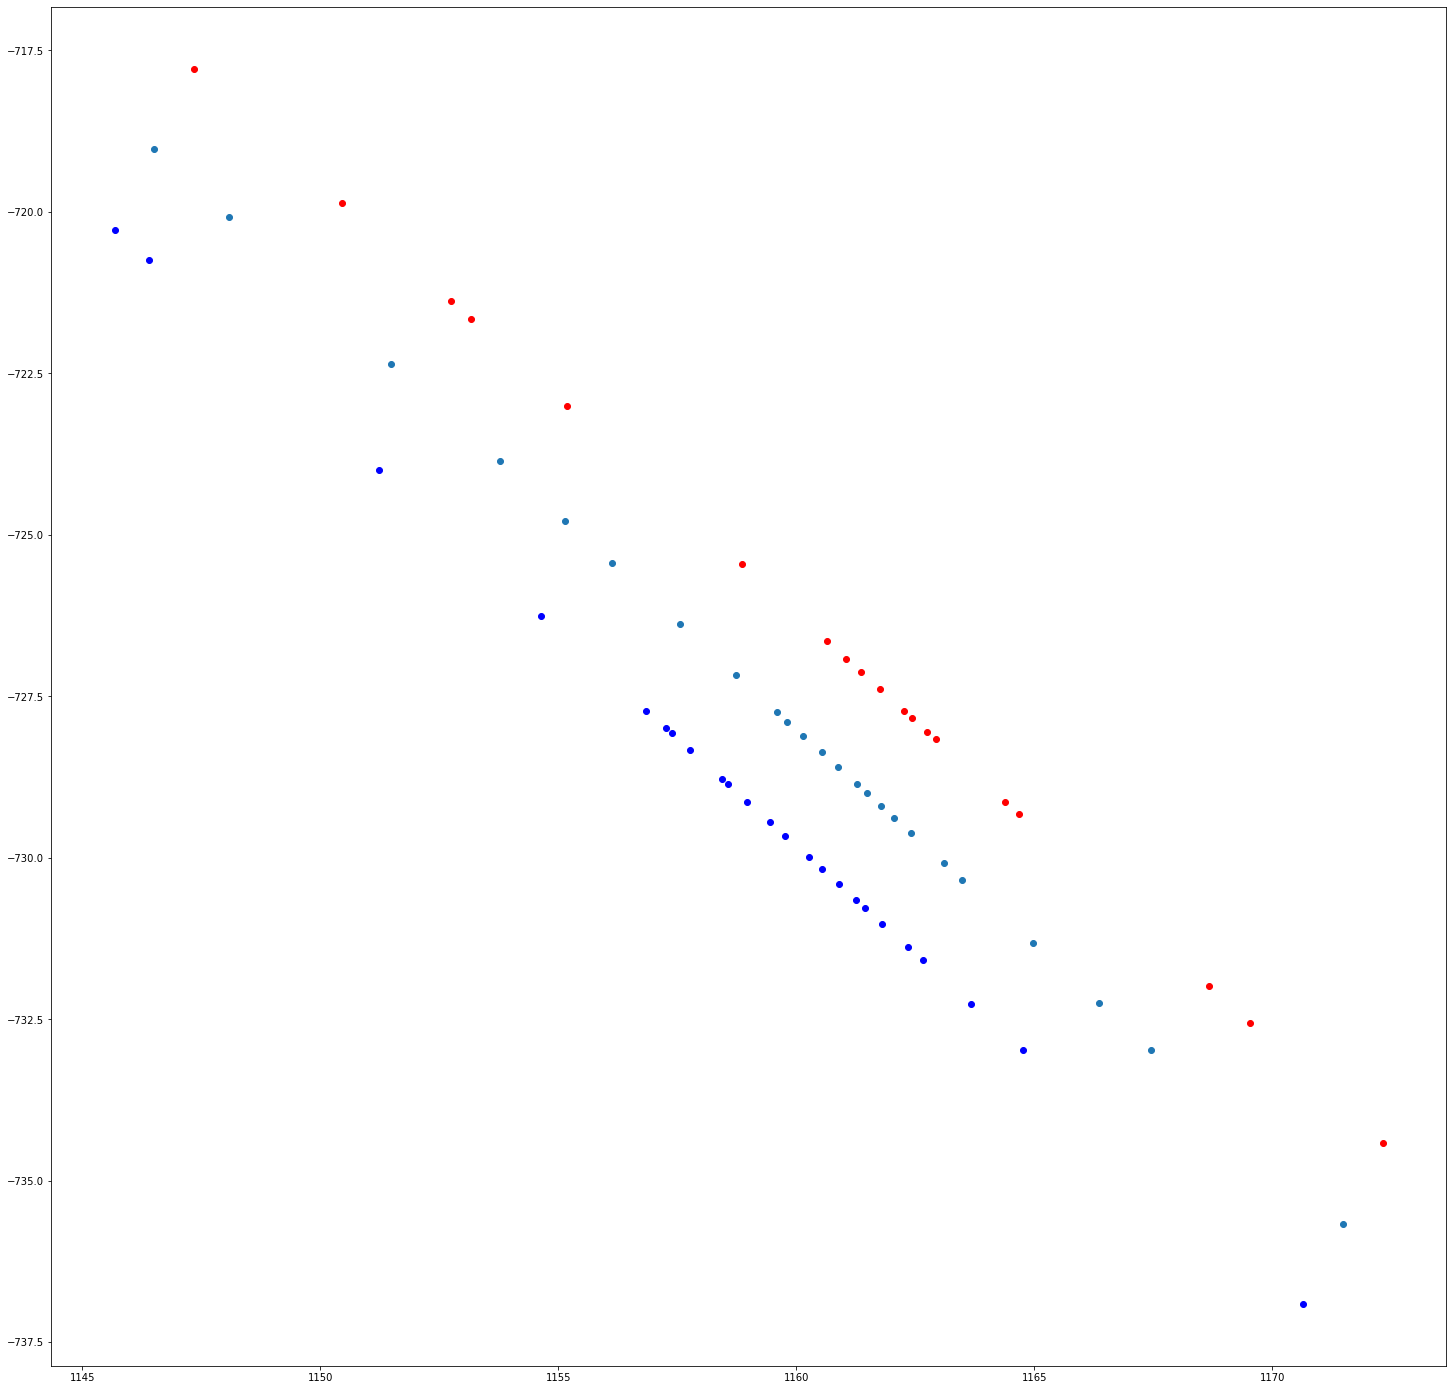

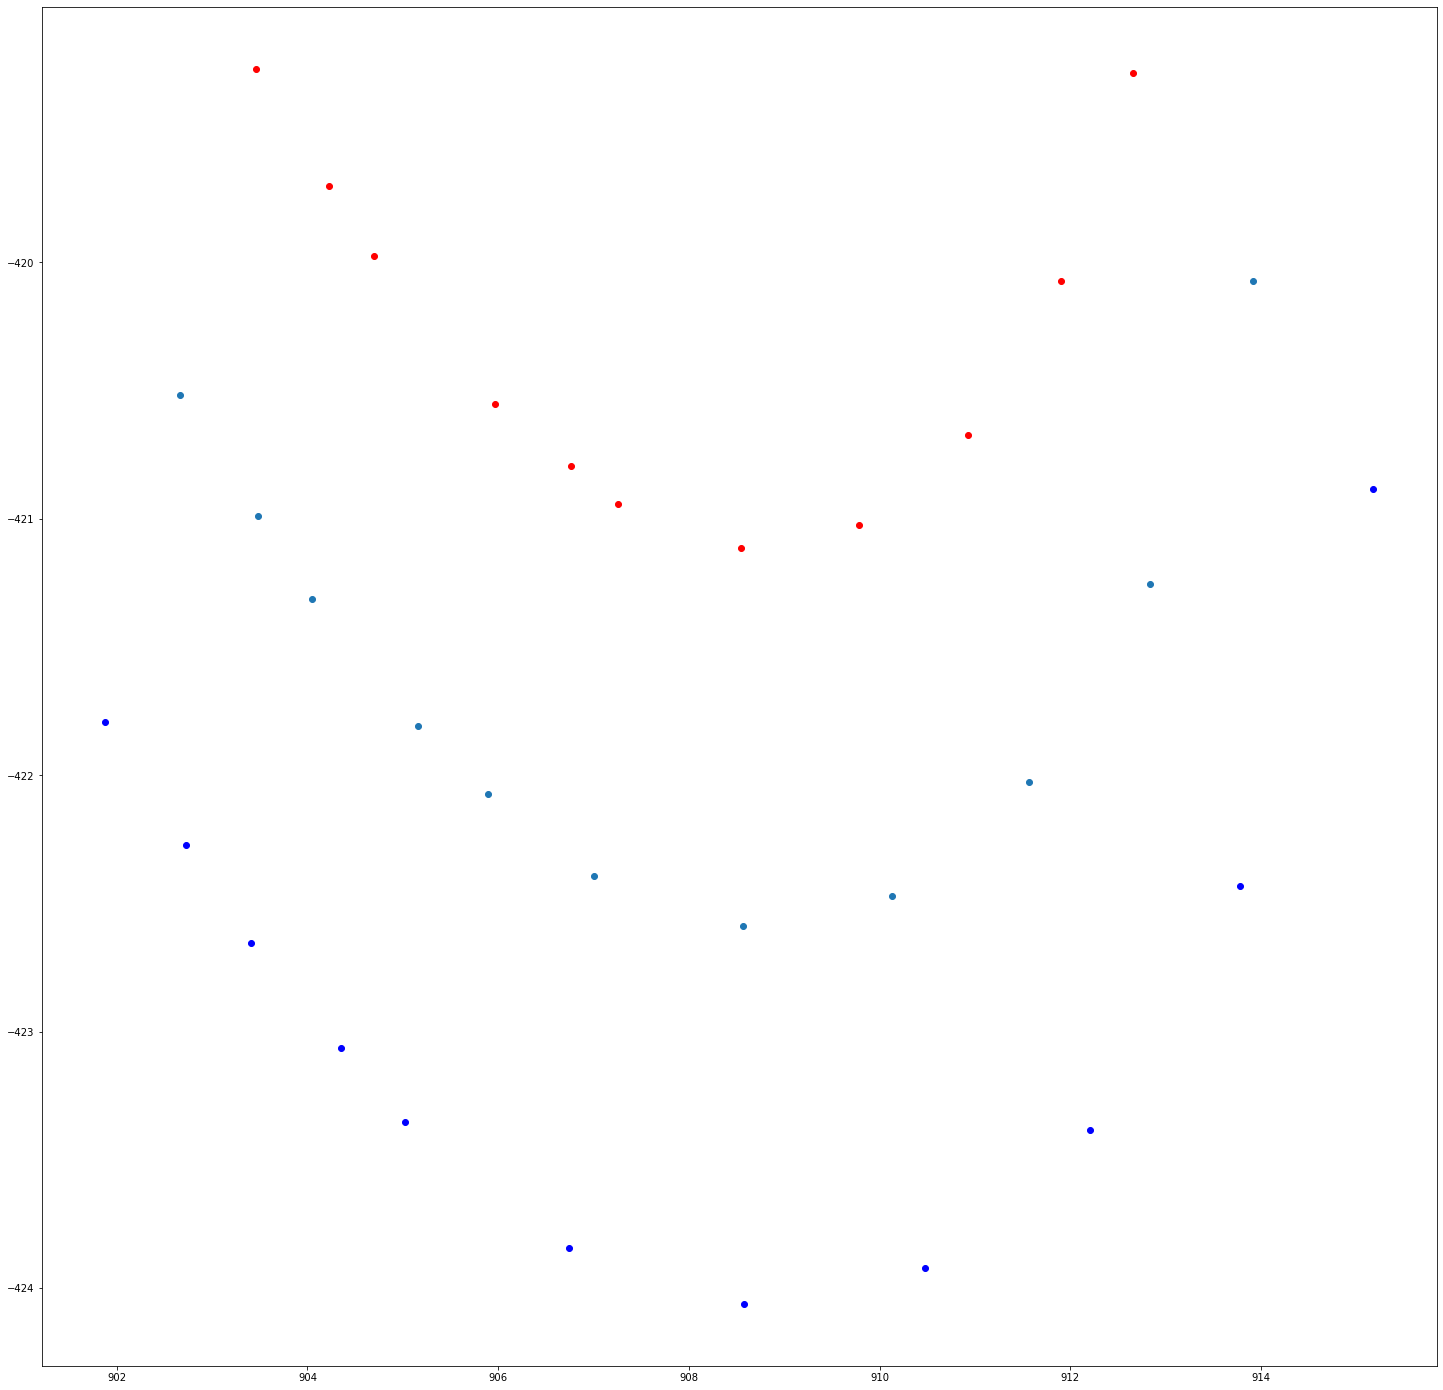

In [15]:
id_2_idx = {lane_id:i for i, lane_id in enumerate(lanes_crosswalks['lanes']['ids'])}
for lane_id in sample(sparsely_sampled_lane_ids, 20):
    plt.figure(figsize=(25, 25))
    lane_center = lanes_crosswalks['lanes']['center_line'][id_2_idx[lane_id]]
    xy_left = lanes_crosswalks['lanes']['xy_left'][id_2_idx[lane_id]]
    xy_right = lanes_crosswalks['lanes']['xy_right'][id_2_idx[lane_id]]
    plt.scatter(lane_center[:, 0], lane_center[:, 1])
    plt.scatter(xy_left[:, 0], xy_left[:, 1], c='b')
    plt.scatter(xy_right[:, 0], xy_right[:, 1], c='r')

# Goal: avoid sparse sampling

In [16]:
x = np.array([12,2,4])
np.append(x, np.array([23, 23]), axis=0)

array([12,  2,  4, 23, 23])

In [17]:
np.linspace(0, 2-1, 4)

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [18]:
np.interp(np.linspace(0, 2-1, 4), np.arange(2), np.array([1, 8]))

array([1.        , 3.33333333, 5.66666667, 8.        ])

In [391]:
def densify_sparse_segments(x_coordinates_seq_np, y_coordinates_seq_np, max_diff=0.01):
    # the operation is done just once, so performing it naively
    assert len(x_coordinates_seq_np) == len(y_coordinates_seq_np), "Different lens of x/y coordinates"
    x_final_seq_np = np.array([])
    y_final_seq_np = np.array([])
    for i in range(0, len(x_coordinates_seq_np) - 1):
        abs_diff = np.hypot(x_coordinates_seq_np[i + 1] - x_coordinates_seq_np[i], 
                            y_coordinates_seq_np[i + 1] - y_coordinates_seq_np[i])
        if abs_diff > max_diff:
            n_interpolated_points = int(np.ceil(abs_diff / max_diff)) + 1
            x_points_to_append = np.interp(np.linspace(0, 1, n_interpolated_points),
                                           np.arange(2), x_coordinates_seq_np[i:i+2])
            
            y_points_to_append = np.interp(np.linspace(0, 1, n_interpolated_points),
                                           np.arange(2), y_coordinates_seq_np[i:i+2])
            
        else:
            x_points_to_append = x_coordinates_seq_np[i:i+2]
            y_points_to_append = y_coordinates_seq_np[i:i+2]
        if i > 0:
            x_points_to_append = x_points_to_append[1:]
            y_points_to_append = y_points_to_append[1:]
        x_final_seq_np = np.append(x_final_seq_np, x_points_to_append)
        y_final_seq_np = np.append(y_final_seq_np, y_points_to_append)
    return x_final_seq_np, y_final_seq_np   

def sparsify(xy_seq_np, final_min_coord_dist_metr=2):
    prev_point = xy_seq_np[0]
    final_list = [prev_point]
    for i in range(1, len(xy_seq_np)):
        delta_x = prev_point[0] - xy_seq_np[i, 0]
        delta_y = prev_point[1] - xy_seq_np[i, 1]
        dist = np.hypot(delta_x, delta_y)
        if dist >= final_min_coord_dist_metr:
            final_list.append(xy_seq_np[i])
            prev_point = xy_seq_np[i]
    if np.any(prev_point != xy_seq_np[-1]):
        final_list.append(xy_seq_np[-1])
    return np.array(final_list)

def get_lane_cumul_distances(xy_seq_np):
    idx_2_cumul_distances = [[] for _ in range(len(xy_seq_np))]    
    
    def get_dist(idx_0, idx_1):
        deltas = xy_seq_np[idx_0] - xy_seq_np[idx_1]
        return np.hypot(deltas[0], deltas[1])
    
    for i in range(len(xy_seq_np)):
        # computing backward along the lane
        dist_backward = 0
        backward_dists = []
        for k in range(i - 1, -1, -1):
            segment_len = get_dist(k, k+1)
            dist_backward += segment_len
            backward_dists.append(dist_backward)
        idx_2_cumul_distances[i].extend(reversed(backward_dists))
        idx_2_cumul_distances[i].append(0)
            
        # computing forward along the lane
        dist_forward = 0
        for k in range(i + 1, len(xy_seq_np), 1):
            segment_len = get_dist(k, k-1)
            dist_forward += segment_len
            idx_2_cumul_distances[i].append(dist_forward)
    return idx_2_cumul_distances


def get_helping_angle(vector_1):
        vector_0 = np.array([1, 0])
        angle_cos = np.dot(vector_0, vector_1)/np.linalg.norm(vector_1)
        alpha = np.arccos(angle_cos)    
        if vector_1[1] < 0:
            alpha = 2*np.pi - alpha
        return alpha
    
def get_lane_segments_sin_cosine(xy_seq_np):    
    idx_2_sin_cos_forward = []
    for i in range(len(xy_seq_np) - 1):
        vector_1 = xy_seq_np[i + 1] - xy_seq_np[i]
        helping_angle = get_helping_angle(vector_1)
        idx_2_sin_cos_forward.append((np.sin(helping_angle), np.cos(helping_angle)))
    idx_2_sin_cos_forward.append((np.nan, np.nan))
        
    idx_2_sin_cos_backward = []   
    for i in range(len(xy_seq_np) - 1, 0, -1):
        vector_1 = xy_seq_np[i - 1] - xy_seq_np[i]
        helping_angle = get_helping_angle(vector_1)
        idx_2_sin_cos_backward.append((np.sin(helping_angle), np.cos(helping_angle)))
    idx_2_sin_cos_backward.append((np.nan, np.nan))
    return idx_2_sin_cos_forward, list(reversed(idx_2_sin_cos_backward))
            
    
def get_bounds(proto_API, final_min_coord_dist_metr=2) -> dict:
    """
    For each elements of interest returns bounds [[min_x, min_y],[max_x, max_y]] and proto ids
    Coords are computed by the MapAPI and, as such, are in the world ref system.

    Returns:
        dict: keys are classes of elements, values are dict with `bounds` and `ids` keys
    """
    lanes_ids = []
    crosswalks_ids = []
    center_line_coords = []
    xy_left_coords = []
    xy_right_coords = []
    xy_left_coords_ = []
    xy_right_coords_ = []
    
    lane_point_idx_2_cumul_distances = []
    lane_point_idx_2_sin_cos_forward = []
    lane_point_idx_2_sin_cos_backward = []

    lanes_bounds = np.empty((0, 2, 2), dtype=np.float)  # [(X_MIN, Y_MIN), (X_MAX, Y_MAX)]
    crosswalks_bounds = np.empty((0, 2, 2), dtype=np.float)  # [(X_MIN, Y_MIN), (X_MAX, Y_MAX)]

    for element in tqdm(proto_API):
        element_id = MapAPI.id_as_str(element.id)
        
#         if element_id == '0uoE':

        if proto_API.is_lane(element):
            lane = proto_API.get_lane_coords(element_id)
            x_min = min(np.min(lane["xyz_left"][:, 0]), np.min(lane["xyz_right"][:, 0]))
            y_min = min(np.min(lane["xyz_left"][:, 1]), np.min(lane["xyz_right"][:, 1]))
            x_max = max(np.max(lane["xyz_left"][:, 0]), np.max(lane["xyz_right"][:, 0]))
            y_max = max(np.max(lane["xyz_left"][:, 1]), np.max(lane["xyz_right"][:, 1]))

            x_left_, y_left_ = densify_sparse_segments(lane["xyz_left"][:, 0], 
                                                       lane["xyz_left"][:, 1])
            x_right_, y_right_ = densify_sparse_segments(lane["xyz_right"][:, 0],
                                                         lane["xyz_right"][:, 1])

            if len(x_left_) == len(x_right_):
                x_right = x_right_
                x_left = x_left_

                y_right = y_right_
                y_left = y_left_

            elif len(x_left_) < len(x_right_):
                x_right = x_right_
                x_left = np.interp(np.linspace(0, len(x_left_)-1, len(x_right)),
                                   np.arange(len(x_left_)), x_left_)

                y_right = y_right_
                y_left = np.interp(np.linspace(0, len(y_left_)-1, len(y_right)), 
                                   np.arange(len(y_left_)), y_left_)

            elif len(x_left_) > len(x_right_):
                x_left = x_left_
                x_right = np.interp(np.linspace(0, len(x_right_)-1, len(x_left)), 
                                    np.arange(len(x_right_)), x_right_)

                y_left = y_left_
                y_right = np.interp(np.linspace(0, len(y_right_)-1, len(y_left)), 
                                    np.arange(len(y_right_)), y_right_)
            else:
                raise Exception('Bug in lane length comparison')
            assert len(x_left) == len(x_right)

            center_line = np.transpose(np.vstack(((x_left + x_right)/2,
                                                  (y_left + y_right)/2)))
            center_line = sparsify(center_line)

            lanes_bounds = np.append(lanes_bounds, np.asarray([[[x_min, y_min], [x_max, y_max]]]), axis=0)
            lanes_ids.append(element_id)
            center_line_coords.append(center_line)
            xy_left_coords.append(lane["xyz_left"][:, :2])
            xy_right_coords.append(lane["xyz_right"][:, :2])
            xy_left_dense = np.transpose(np.vstack((x_left, y_left)))
            xy_right_dense = np.transpose(np.vstack((x_right, y_right)))
            xy_left_coords_.append(sparsify(xy_left_dense))
            xy_right_coords_.append(sparsify(xy_right_dense))

            lane_point_idx_2_cumul_distances.append(get_lane_cumul_distances(center_line))
            idx_2_sin_cos_forward, idx_2_sin_cos_backward = get_lane_segments_sin_cosine(center_line)
            lane_point_idx_2_sin_cos_forward.append(idx_2_sin_cos_forward)
            lane_point_idx_2_sin_cos_backward.append(idx_2_sin_cos_backward)
            assert len(idx_2_sin_cos_forward) == len(idx_2_sin_cos_backward) == len(center_line)

        if proto_API.is_crosswalk(element):
            crosswalk = proto_API.get_crosswalk_coords(element_id)
            x_min = np.min(crosswalk["xyz"][:, 0])
            y_min = np.min(crosswalk["xyz"][:, 1])
            x_max = np.max(crosswalk["xyz"][:, 0])
            y_max = np.max(crosswalk["xyz"][:, 1])

            crosswalks_bounds = np.append(
                crosswalks_bounds, np.asarray([[[x_min, y_min], [x_max, y_max]]]), axis=0,
            )
            crosswalks_ids.append(element_id)

    return {
        "lanes": {"bounds": lanes_bounds, "ids": lanes_ids, 
                  "center_line": center_line_coords, 
                  "xy_left": xy_left_coords, "xy_right": xy_right_coords, 
                  "xy_left_": xy_left_coords_, "xy_right_": xy_right_coords_,
                  "lane_point_idx_2_cumul_distances": lane_point_idx_2_cumul_distances,
                  "lane_point_idx_2_sin_cos_forward": lane_point_idx_2_sin_cos_forward,
                  "lane_point_idx_2_sin_cos_backward": lane_point_idx_2_sin_cos_backward
                 },
        "crosswalks": {"bounds": crosswalks_bounds, "ids": crosswalks_ids},
    }

In [392]:
lanes_crosswalks = get_bounds(proto_API)

In [331]:
# lane_idx = 0
# center_line = lanes_crosswalks['lanes']['center_line'][lane_idx]
# xy_left = lanes_crosswalks['lanes']['xy_left'][lane_idx]
# xy_right = lanes_crosswalks['lanes']['xy_right'][lane_idx]

# xy_left_ = lanes_crosswalks['lanes']['xy_left_'][lane_idx]
# xy_right_ = lanes_crosswalks['lanes']['xy_right_'][lane_idx]


# plt.figure(figsize=(25, 25))
# plt.scatter(center_line[:, 0], center_line[:, 1])

# plt.plot(center_line[:, 0], center_line[:, 1])

# plt.scatter(xy_left_[:, 0], xy_left_[:, 1], c='grey', s=200)
# plt.scatter(xy_right_[:, 0], xy_right_[:, 1], c='grey', s=200)
# plt.scatter(xy_left[:, 0], xy_left[:, 1], c='b')
# plt.scatter(xy_right[:, 0], xy_right[:, 1], c='r')


In [23]:
center_line_lens_list = [len(x) for x in lanes_crosswalks['lanes']['center_line']]
np.mean(center_line_lens_list), np.std(center_line_lens_list), np.max(center_line_lens_list)

(12.360964138741917, 13.992447110593162, 215)

<AxesSubplot:>

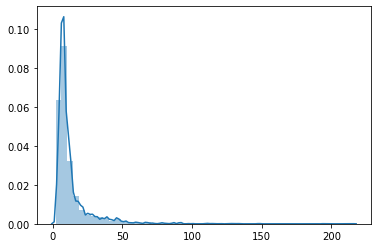

In [24]:
sns.distplot(center_line_lens_list)

In [25]:
conseq_dists = []
sparsely_sampled_lane_ids = []
for i, center_line in enumerate(lanes_crosswalks['lanes']['center_line']):
    for j in range(len(center_line) - 1):
        steps = center_line[j + 1] - center_line[j]
        dist_next = np.hypot(steps[0], steps[1])
        conseq_dists.append(dist_next)
        if dist_next > 0.8:
            sparsely_sampled_lane_ids.append(lanes_crosswalks['lanes']['ids'][i])
np.mean(conseq_dists), np.std(conseq_dists), np.max(conseq_dists)

(1.9212239206746116, 0.3312727528453364, 2.0099999038499687)

<AxesSubplot:>

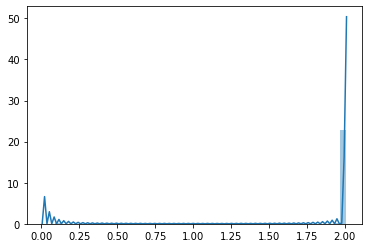

In [26]:
sns.distplot(conseq_dists)

In [657]:
id_2_idx = {lane_id:i for i, lane_id in enumerate(lanes_crosswalks['lanes']['ids'])}
lane_adj_list_forward = [[] for _ in range(len(id_2_idx))]
lane_adj_list_backward = [[] for _ in range(len(id_2_idx))]

for element in tqdm(proto_API, desc='Computing lane adjacency lists'):
    element_id = MapAPI.id_as_str(element.id)
    if proto_API.is_lane(element):
        lanes_ahead = [proto_API.id_as_str(x) for x in proto_API.get_lanes_ahead(element_id)]
        lane_adj_list_forward[id_2_idx[element_id]].extend(lanes_ahead)
        for lane_ahead_id in lanes_ahead:
            lane_adj_list_backward[id_2_idx[lane_ahead_id]].append(element_id)

def get_predicted_coordinates(start_point_coord, lane_id, lane_point_idx, forward, speed_m_per_frame, 
                              current_overshoot_m=0, n_prediction_steps=50, include_start=False):
    print('started')
    adj_list = lane_adj_list_forward if forward else lane_adj_list_backward
    lane_idx = id_2_idx[lane_id]
    lane_point_idx_2_cumul_distances = deepcopy(lanes_crosswalks['lanes']['lane_point_idx_2_cumul_distances'][lane_idx])
    center_line = deepcopy(lanes_crosswalks['lanes']['center_line'][lane_idx])
    center_line[lane_point_idx] = start_point_coord
  
    boarder_idx = len(center_line) - 1 if forward else 0
    
    # when already on the edge of the lane, proceed to the next lane
    if lane_point_idx == boarder_idx:        
        consec_future_coordinates_tracks = []
        for consecutive_lane_id in adj_list[lane_idx]:
            consec_lane_point_idx = 0 if forward else len(lanes_crosswalks['lanes']['center_line'][id_2_idx[consecutive_lane_id]]) - 1
            consec_future_coordinates_tracks.extend(get_predicted_coordinates(start_point_coord, consecutive_lane_id, 
                                      consec_lane_point_idx, forward, speed_m_per_frame, current_overshoot_m, 
                                                                              n_prediction_steps=n_prediction_steps, include_start=True))
        if n_prediction_steps == 50 and len(consec_future_coordinates_tracks) == 0:
            return [start_point_coord.reshape(1, 2)]
        return consec_future_coordinates_tracks
    
    direction_multiplier = 1 if forward else -1
    # constant speed
    travelled_dist = speed_m_per_frame
    
    # fixing distances after insertion of optional start point into lane
    deltas = center_line[lane_point_idx + direction_multiplier] - start_point_coord
    dist_to_next_point = np.hypot(deltas[0], deltas[1])
    dist_from_start = dist_to_next_point
    dist_delta = dist_to_next_point - lane_point_idx_2_cumul_distances[lane_point_idx][lane_point_idx + direction_multiplier]
    lane_point_idx_2_cumul_distances[lane_point_idx][lane_point_idx + direction_multiplier] += dist_delta
    fix_k = 2*direction_multiplier
    while 0 <= lane_point_idx + fix_k < len(center_line):
        lane_point_idx_2_cumul_distances[lane_point_idx][lane_point_idx + fix_k] += dist_delta
        dist_from_start += lane_point_idx_2_cumul_distances[lane_point_idx][lane_point_idx + fix_k]
        fix_k += direction_multiplier  
                
    if forward:
        lane_point_idx_2_sin_cos = deepcopy(lanes_crosswalks['lanes']['lane_point_idx_2_sin_cos_forward'][lane_idx])
    else:        
        lane_point_idx_2_sin_cos = deepcopy(lanes_crosswalks['lanes']['lane_point_idx_2_sin_cos_backward'][lane_idx])
        
    # computing new sin/cos
    vector_1 = center_line[lane_point_idx + direction_multiplier] - start_point_coord
    helping_angle = get_helping_angle(vector_1)
    lane_point_idx_2_sin_cos[lane_point_idx] = (np.sin(helping_angle), np.cos(helping_angle))        
    
    def find_next_point_idx_and_overshoot(travelled_dist, start_point_idx, current_overshoot_m, forward):
        point_idx = start_point_idx + direction_multiplier
        cumul_distances = lane_point_idx_2_cumul_distances[start_point_idx]
        while 0 <= point_idx < len(cumul_distances) and cumul_distances[point_idx] - current_overshoot_m < travelled_dist:
            point_idx += direction_multiplier
            
        point_idx -= direction_multiplier
        overshoot = travelled_dist - cumul_distances[point_idx] + current_overshoot_m
        return point_idx, overshoot
    
    current_point_idx = lane_point_idx
    if not include_start:
        future_coordinates = []
    else:
        future_coordinates = [start_point_coord + current_overshoot_m*np.array([np.cos(helping_angle), np.sin(helping_angle)])] 
        n_prediction_steps -= 1
        
    prediction_finished = False
    print('before loop')
    
    for step_i in range(n_prediction_steps):
        if prediction_finished:
            # to be able to check if there were consecutive lanes using step_i
            step_i -= 1
            break
        travelled_dist = speed_m_per_frame
        current_point_idx, current_overshoot_m = find_next_point_idx_and_overshoot(travelled_dist, current_point_idx, 
                                                                                   current_overshoot_m, forward)
        current_point_coords = center_line[current_point_idx]
        if current_point_idx == boarder_idx:
            prediction_finished = True
            # process consecutive lane(s)
            possible_subfutures = []
            consec_future_coordinates_tracks = []
            for consecutive_lane_id in adj_list[lane_idx]:
                consec_lane_point_idx = 0 if forward else len(lanes_crosswalks['lanes']['center_line'][id_2_idx[consecutive_lane_id]]) - 1
                consec_future_coordinates_tracks.extend(get_predicted_coordinates(center_line[boarder_idx], consecutive_lane_id, 
                                          consec_lane_point_idx, forward, speed_m_per_frame, current_overshoot_m, 
                                                                                  n_prediction_steps=n_prediction_steps-step_i, include_start=True))
            consec_future_coordinates_tracks = [x for x in consec_future_coordinates_tracks if len(x) > 0]  
            if len(future_coordinates):
                future_coordinates = np.vstack(future_coordinates)
                if len(consec_future_coordinates_tracks):
                    future_coordinates_tracks = [np.concatenate((future_coordinates, x), axis=0) 
                                                 for x in consec_future_coordinates_tracks]  
                else:
                    future_coordinates_tracks = [future_coordinates]
            elif len(consec_future_coordinates_tracks):
                future_coordinates_tracks = consec_future_coordinates_tracks
            elif current_point_idx > 0: # there was at least one prev point
                sin_, cos_ = lane_point_idx_2_sin_cos[current_point_idx - 1]
                next_position_coordinates = current_point_coords + current_overshoot_m*np.array([cos_, sin_])
                future_coordinates_tracks = [next_position_coordinates.reshape(1, 2)]
            else:
                future_coordinates_tracks = [current_point_coords.reshape(1, 2)]
    
        else:
            sin_, cos_ = lane_point_idx_2_sin_cos[current_point_idx]
            next_position_coordinates = current_point_coords + current_overshoot_m*np.array([cos_, sin_])
            future_coordinates.append(next_position_coordinates)
    if n_prediction_steps == 0 or step_i == n_prediction_steps - 1:
        if len(future_coordinates):
            future_coordinates_tracks = [np.vstack(future_coordinates)]
        elif n_prediction_steps == 50:  # not a recursive call
            future_coordinates_tracks = [start_point_coord.reshape(1, 2)]
        else:
            future_coordinates_tracks = []
    
    return future_coordinates_tracks

In [658]:
# lane_idx = id_2_idx['0uoE']
# center_line = lanes_crosswalks['lanes']['center_line'][lane_idx]
# xy_left = lanes_crosswalks['lanes']['xy_left'][lane_idx]
# xy_right = lanes_crosswalks['lanes']['xy_right'][lane_idx]

# xy_left_ = lanes_crosswalks['lanes']['xy_left_'][lane_idx]
# xy_right_ = lanes_crosswalks['lanes']['xy_right_'][lane_idx]


# plt.figure(figsize=(25, 25))
# plt.scatter(center_line[:, 0], center_line[:, 1])

# plt.plot(center_line[:, 0], center_line[:, 1])

# plt.scatter(xy_left_[:, 0], xy_left_[:, 1], c='grey', s=200)
# plt.scatter(xy_right_[:, 0], xy_right_[:, 1], c='grey', s=200)
# plt.scatter(xy_left[:, 0], xy_left[:, 1], c='b')
# plt.scatter(xy_right[:, 0], xy_right[:, 1], c='r')

In [659]:
chosen_lane_id, lane_point_idx

('kVZG', 0)

WNum 13
next_point [-998.82745361 1359.81311031]
started
before loop
current_point_idx, current_overshoot_m 1 0.3188226461053335
on boarder
n_prediction_steps 50
[array([[-998.32817074, 1359.72569957]])]


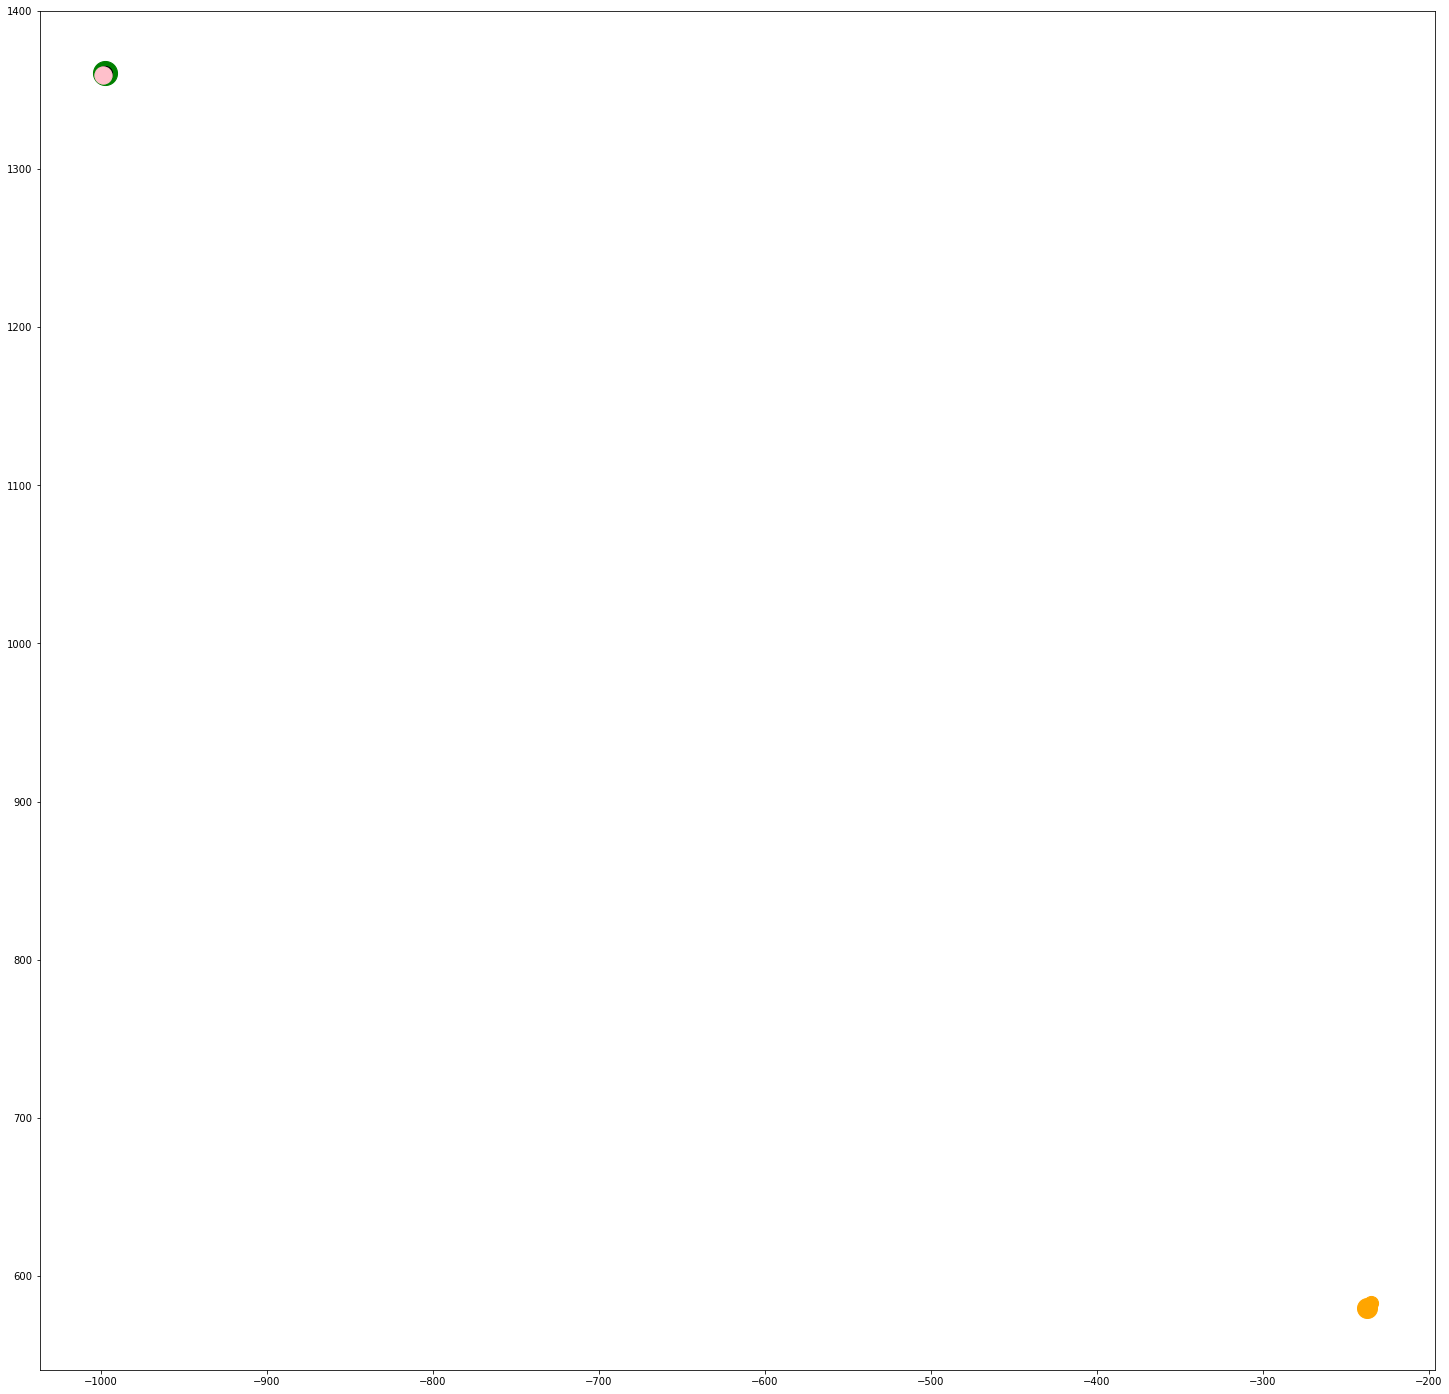

In [660]:
# for lane_id in [lanes_crosswalks['lanes']['ids'][x] for x in [6974, 6429, 1487, id_2_idx['+O33'], 2997,4029,  4641]] + sample(sparsely_sampled_lane_ids, 5):
plt.figure(figsize=(25, 25))
start_coordinates = np.array([-998.35510254, 1361.04150391])
speed = np.array([-0.47235107, -1.2283936 ])
for lane_id, lane_point_idx in [idx_2_lane_id_idx[k] for k in kd_tree.query(start_coordinates, k = 5)[1]]:
    print(lane_id, lane_point_idx)
    
    lane_id = chosen_lane_id
    lane_point_idx = 0
    forward = True 
    start_speed_m_per_frame = np.hypot(speed[0], speed[1])
    next_point = start_coordinates + speed
    print('next_point', next_point)
    
    center_line = lanes_crosswalks['lanes']['center_line'][id_2_idx[lane_id]]
    xy_left = lanes_crosswalks['lanes']['xy_left'][id_2_idx[lane_id]]
    xy_right = lanes_crosswalks['lanes']['xy_right'][id_2_idx[lane_id]]
    
    xy_left_ = lanes_crosswalks['lanes']['xy_left_'][id_2_idx[lane_id]]
    xy_right_ = lanes_crosswalks['lanes']['xy_right_'][id_2_idx[lane_id]]
    
#     lane_point_idx = 0 #sample(list(range(len(center_line) - 2)), 1)[0]
#     print(f'chosen coordinate {lane_point_idx} out of {len(center_line) - 3}')
#     future_coordinates_tracks = get_predicted_coordinates(center_line[lane_point_idx] + np.array([0.7, 0.8]), lane_id, lane_point_idx, forward=False, speed_m_per_frame=1.1, n_prediction_steps=50)
    future_coordinates_tracks = get_predicted_coordinates(start_coordinates, lane_id, lane_point_idx, forward=forward, speed_m_per_frame=start_speed_m_per_frame, n_prediction_steps=50)
    print(future_coordinates_tracks)
    for future_coordinates in future_coordinates_tracks:
        plt.scatter(center_line[:, 0], center_line[:, 1])
        plt.scatter(start_coordinates[0], start_coordinates[1], c='red', s=420)
#         plt.scatter([760.2], [-2434.1], c='black', s=420)
#         plt.scatter([759.40942486], [-2433.85353823], c='green', s=420)
#         plt.scatter([761.65674414], [-2430.53722753], c='pink', s=420)
        
#         plt.scatter(xy_left_[:, 0], xy_left_[:, 1], c='grey', s=200)
#         plt.scatter(xy_right_[:, 0], xy_right_[:, 1], c='grey', s=200)
#         plt.scatter(xy_left[:, 0], xy_left[:, 1], c='b')
#         plt.scatter(xy_right[:, 0], xy_right[:, 1], c='r')

        plt.scatter([-234.61312324],  [ 582.7502008 ], s=200, c='orange')
        plt.scatter([-237.21188478], [579.70084463], s=400, c='orange')

        plt.scatter(center_line[lane_point_idx, 0], 
                    center_line[lane_point_idx, 1], c='green', s=580, label='prediction_start') 
        plt.scatter(center_line[0, 0], 
                        center_line[0, 1], c='black', s=200) 
#         plt.title(f'lane_id: {lane_id}, lane_point_idx: {lane_point_idx}')
    
        plt.scatter(future_coordinates[:, 0], future_coordinates[:, 1], c='orange', s=150)
        plt.scatter(next_point[0], next_point[1], c='pink', s=300)
#     for i in range(len(center_line) - 1):
#         steps = center_line[i + 1] - center_line[i]
#         dist_next = np.hypot(steps[0], steps[1])
#         if dist_next > 0.8:
#             plt.plot(center_line[i:i+2, 0], center_line[i:i+2, 1], linewidth=2, c='black')
#         plt.title(f'element_id: {lane_id}, idx: {id_2_idx[lane_id]}')
    break


In [543]:
def is_lane_direction_forward(coordinates, lane_id, lane_point_idx, speed_vector):
    lane_idx = id_2_idx[lane_id]
    center_line = lanes_crosswalks['lanes']['center_line'][lane_idx]
    if lane_point_idx < len(center_line) - 1:
        forward_point = center_line[lane_point_idx + 1]
    elif len(lane_adj_list_forward[lane_idx]):
        consecutive_lane_id = lane_adj_list_forward[lane_idx][0]
        forward_point = lanes_crosswalks['lanes']['center_line'][id_2_idx[consecutive_lane_id]][0]
    else:
        forward_point = center_line[lane_point_idx]

    if lane_point_idx > 0:
        backward_point = center_line[lane_point_idx - 1]
    elif len(lane_adj_list_backward[lane_idx]):
        consecutive_lane_id = lane_adj_list_backward[lane_idx][0]
        backward_point = lanes_crosswalks['lanes']['center_line'][id_2_idx[consecutive_lane_id]][-1]
    else:
        backward_point = center_line[lane_point_idx]
    next_point = coordinates + speed_vector * 10
    diff_backward = next_point - backward_point
    diff_forward = next_point - forward_point
        
    print('forward point', forward_point, 'backward point', backward_point, 'next point', next_point, 
         'np.hypot(diff_forward[0], diff_forward[1])', np.hypot(diff_forward[0], diff_forward[1]),
         'np.hypot(diff_backward[0], diff_backward[1])', np.hypot(diff_backward[0], diff_backward[1]))

    return np.hypot(diff_forward[0], diff_forward[1]) < np.hypot(diff_backward[0], diff_backward[1])

In [544]:
%%time

is_lane_direction_forward(np.array([-235.78379822,  581.04144287]), 'OQrT', 8, np.array([2.1582031, -2.53833]))

forward point [-234.61312324  582.7502008 ] backward point [-237.21188478  579.70084463] next point [-214.20176722  555.65814287] np.hypot(diff_forward[0], diff_forward[1]) 33.92054034452514 np.hypot(diff_backward[0], diff_backward[1]) 33.27937827114989
CPU times: user 2.08 ms, sys: 1 µs, total: 2.08 ms
Wall time: 1.6 ms


False

/home/raman/anaconda3/envs/trajectory/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


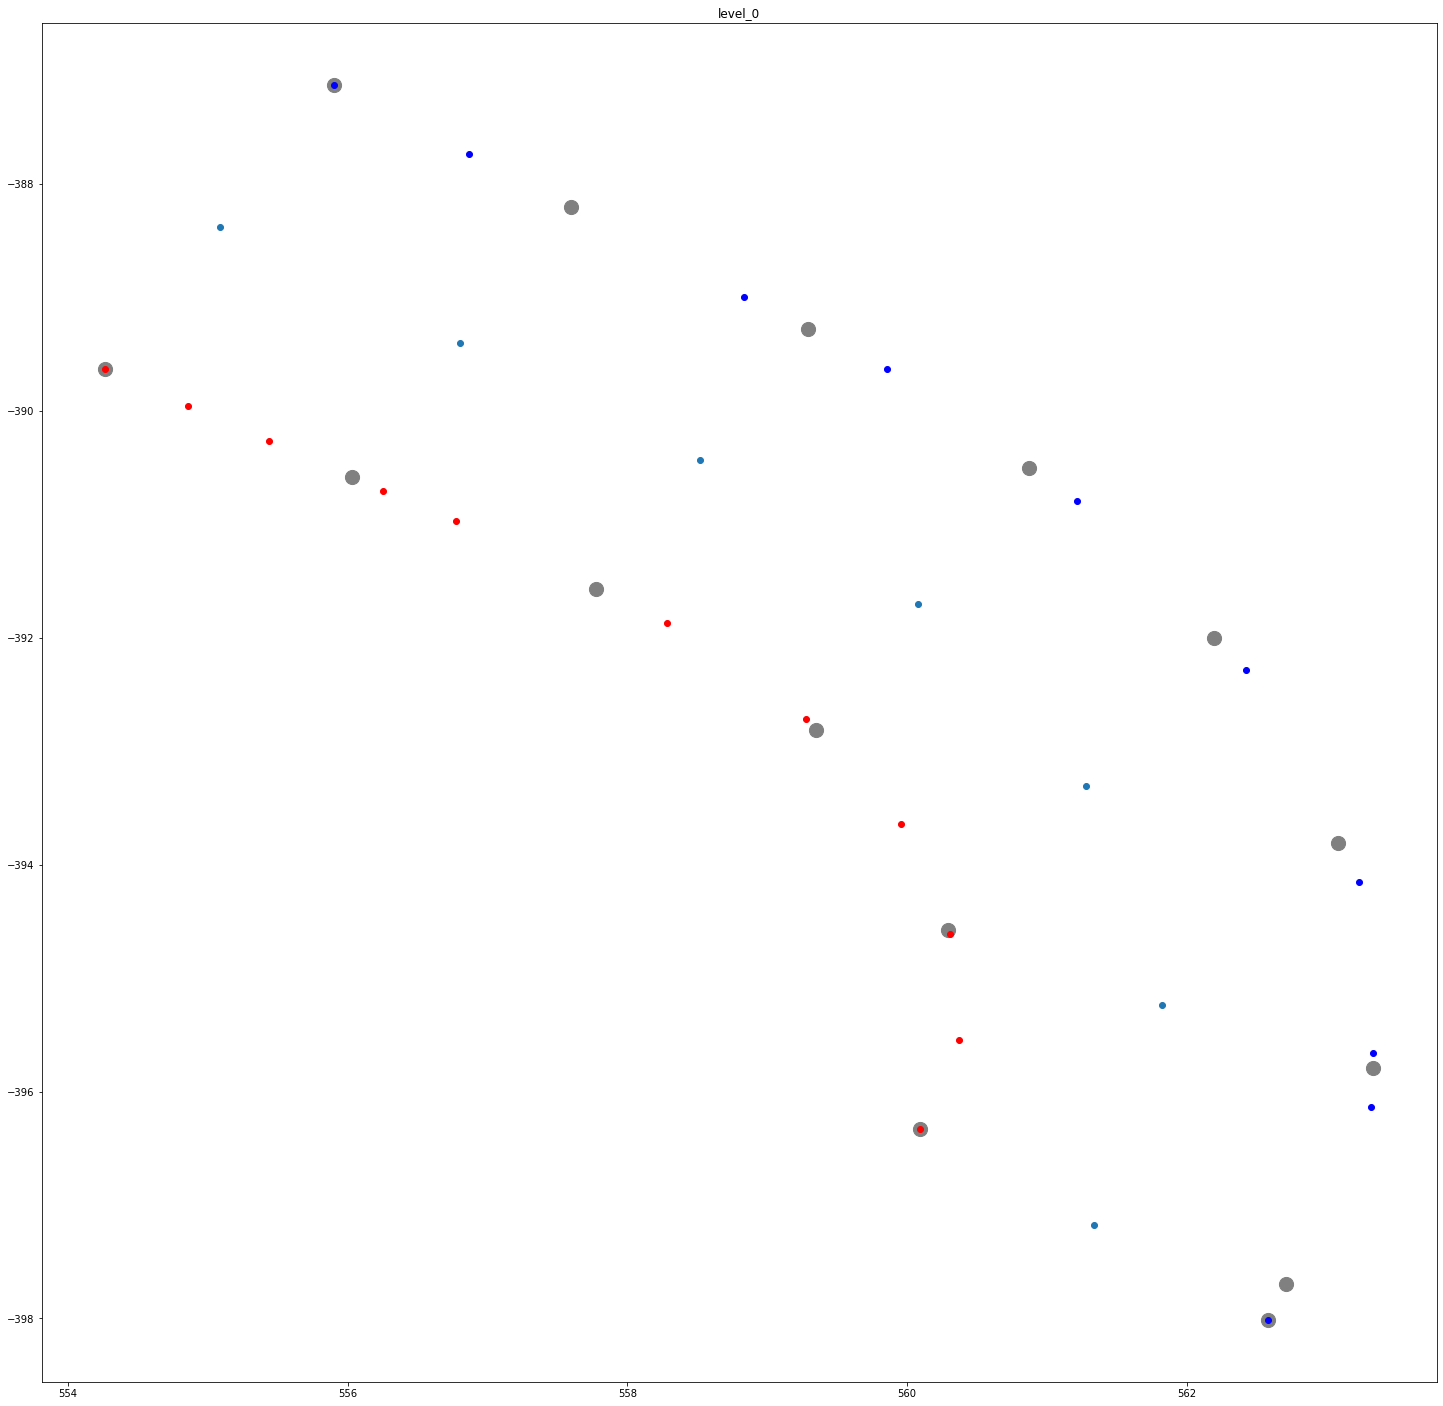

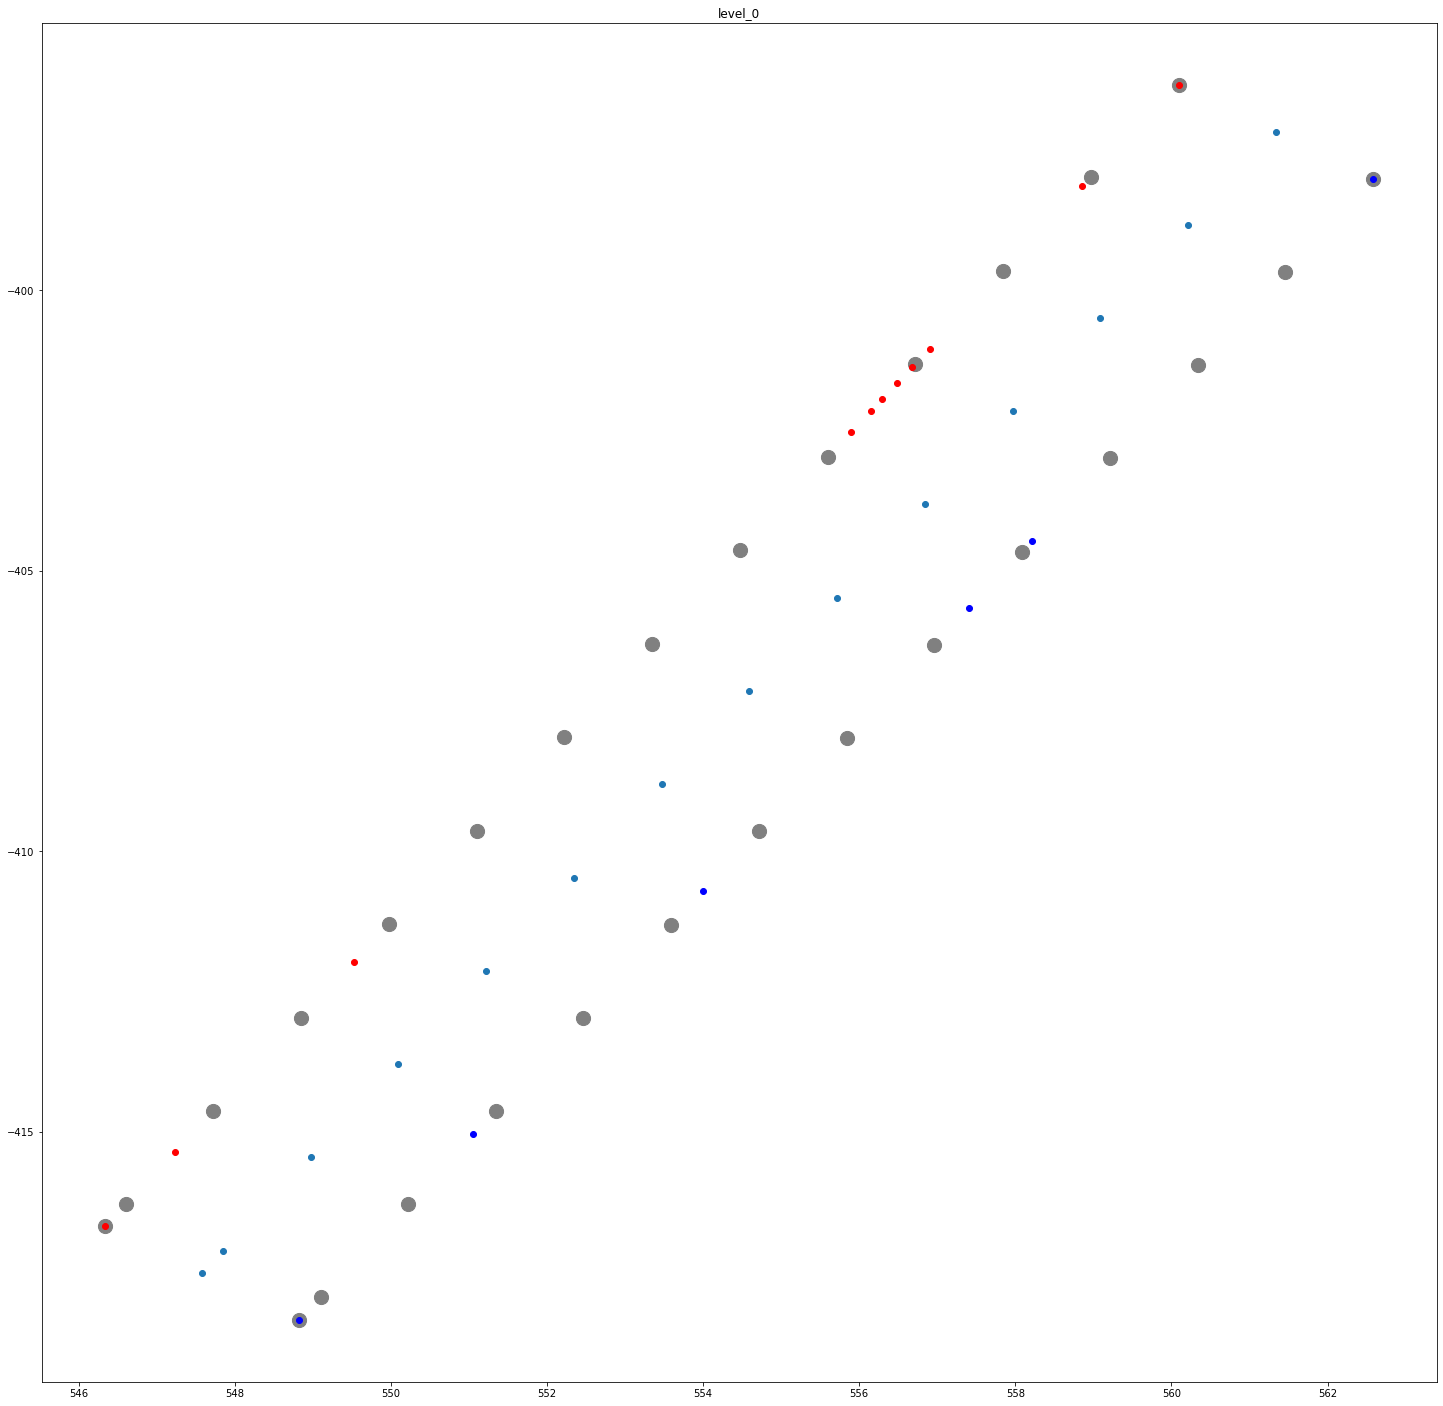

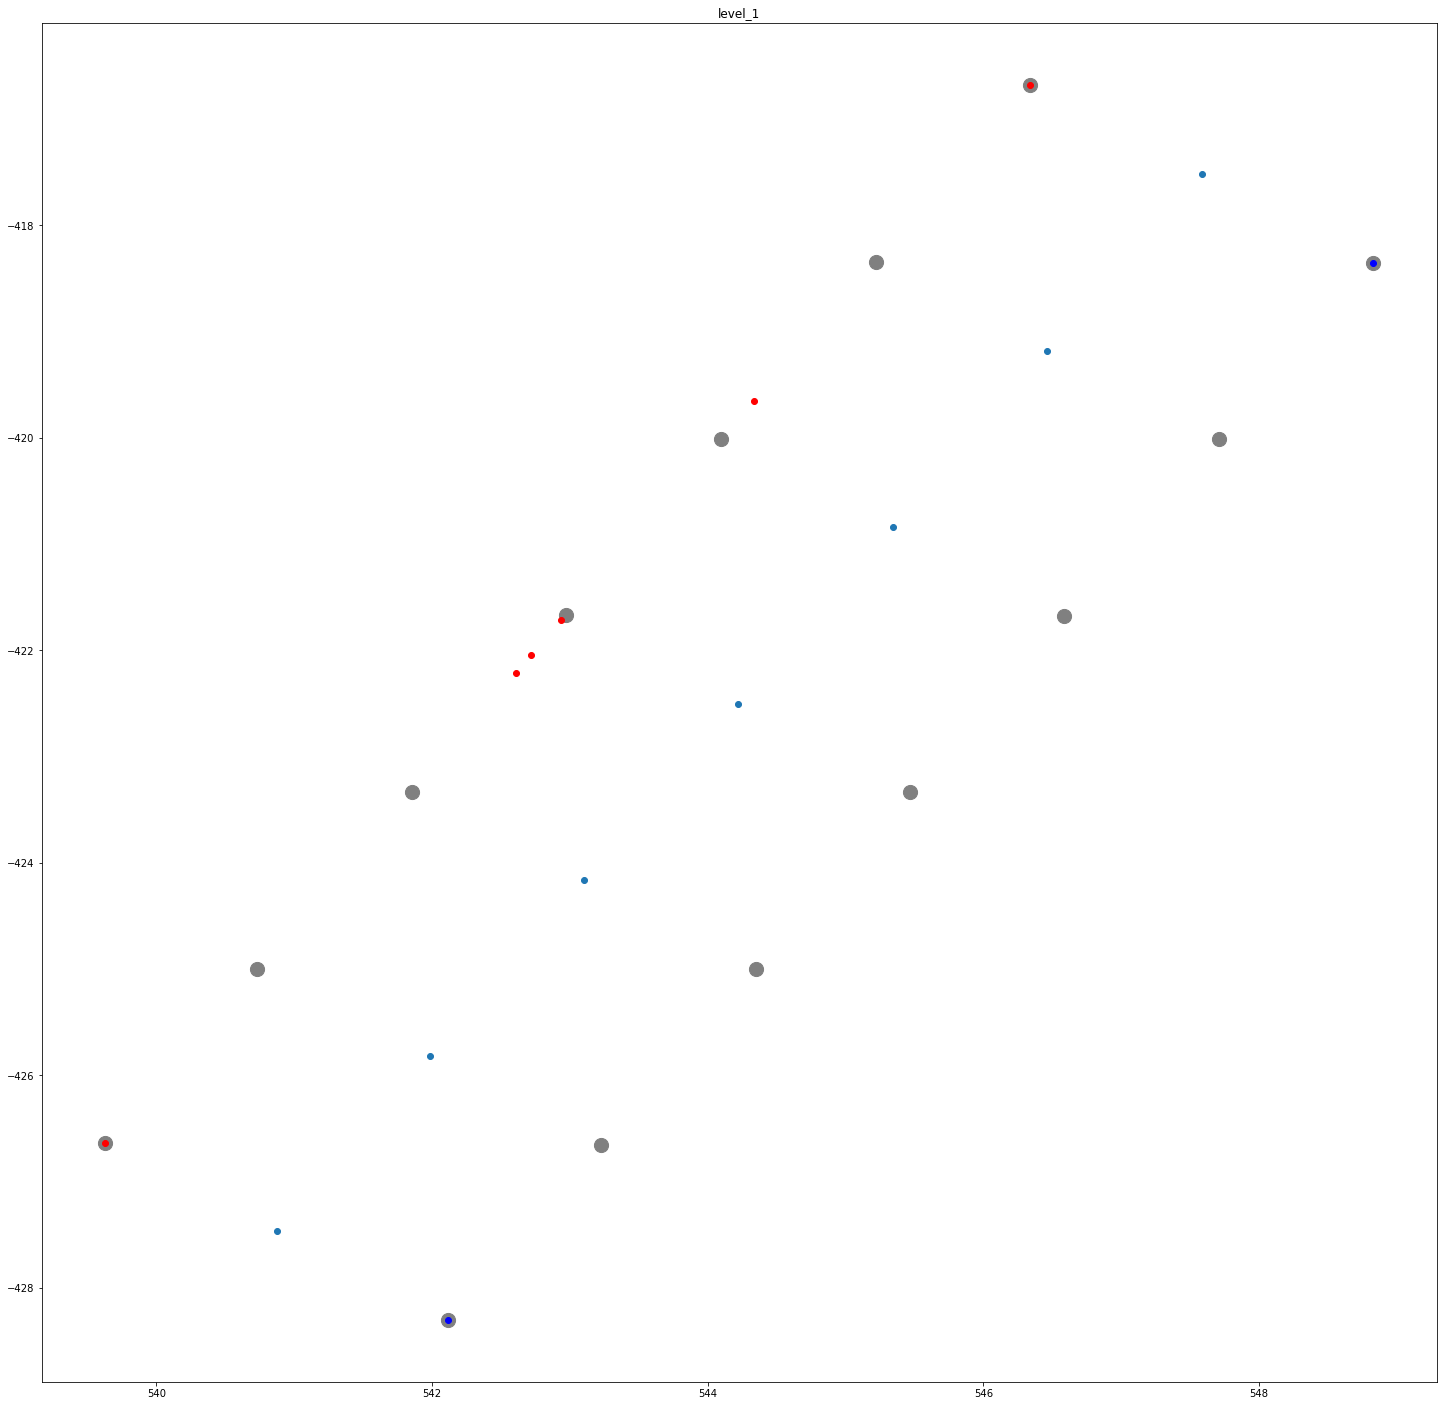

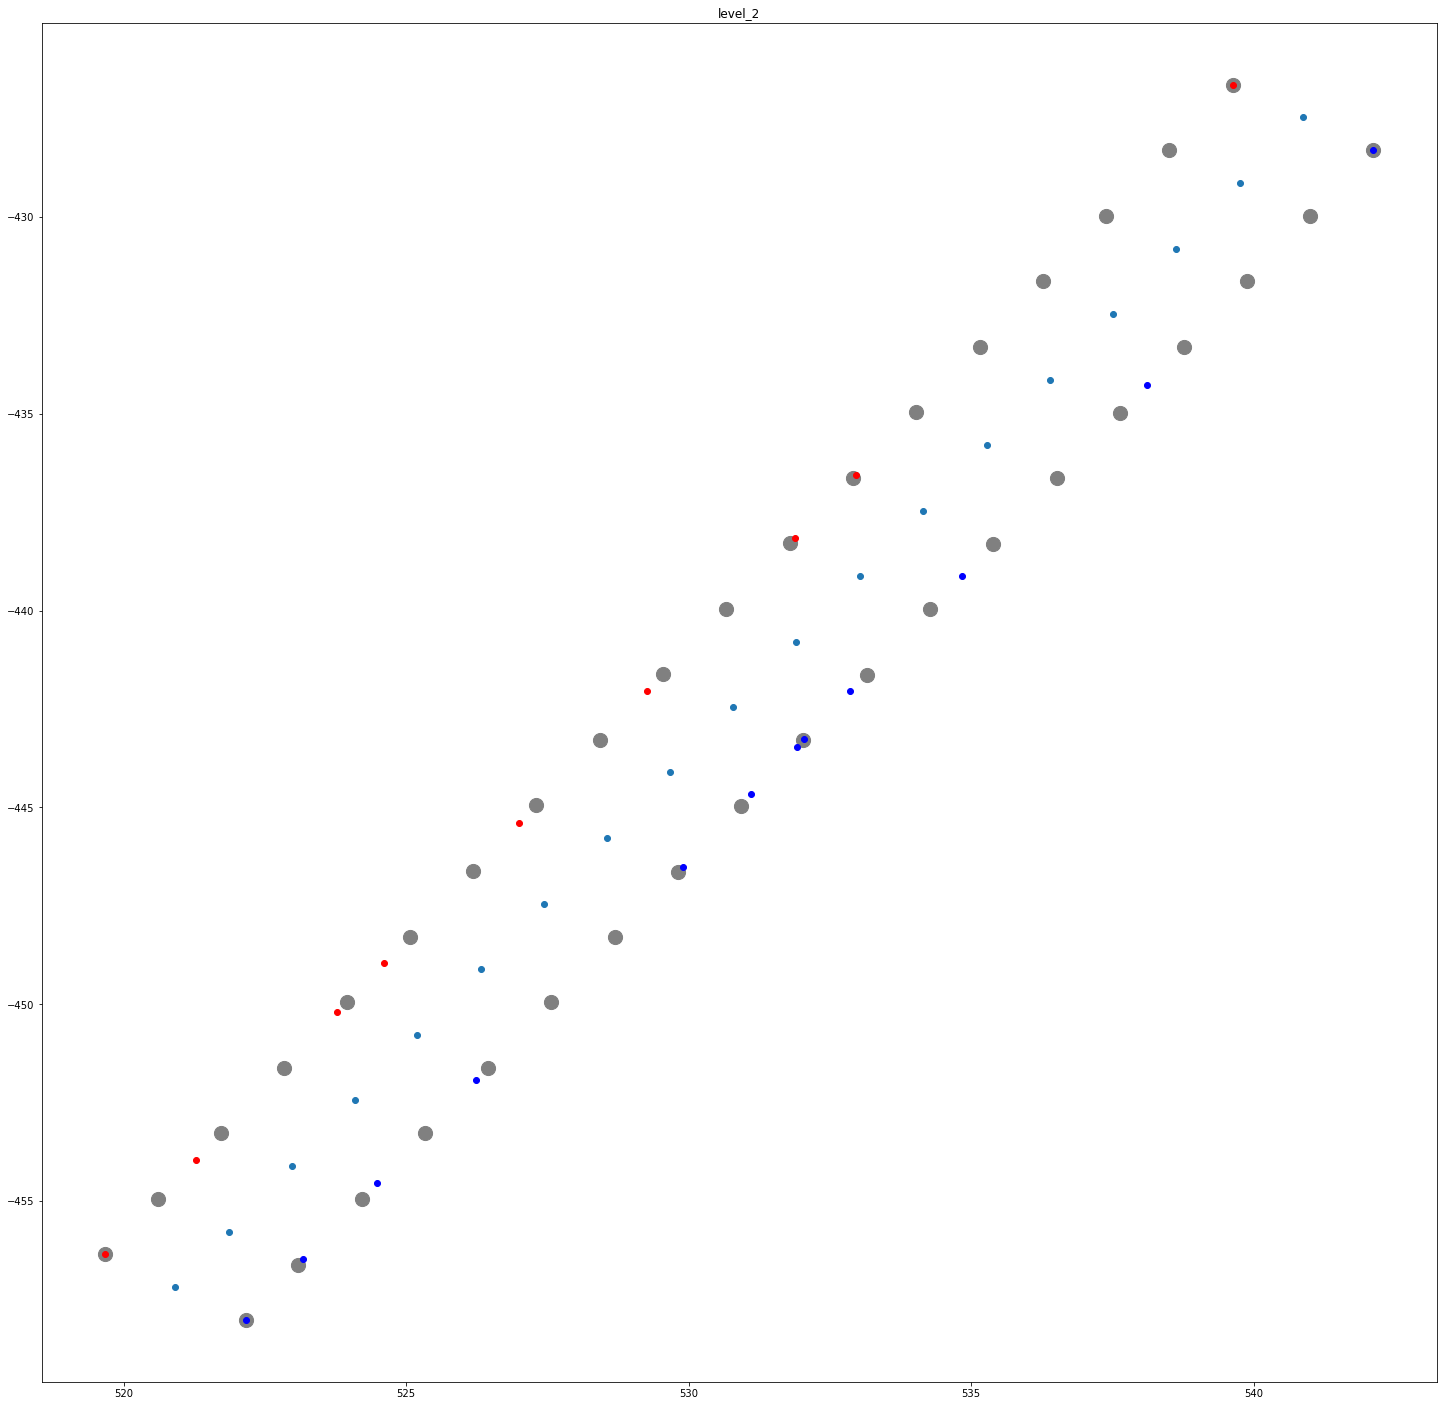

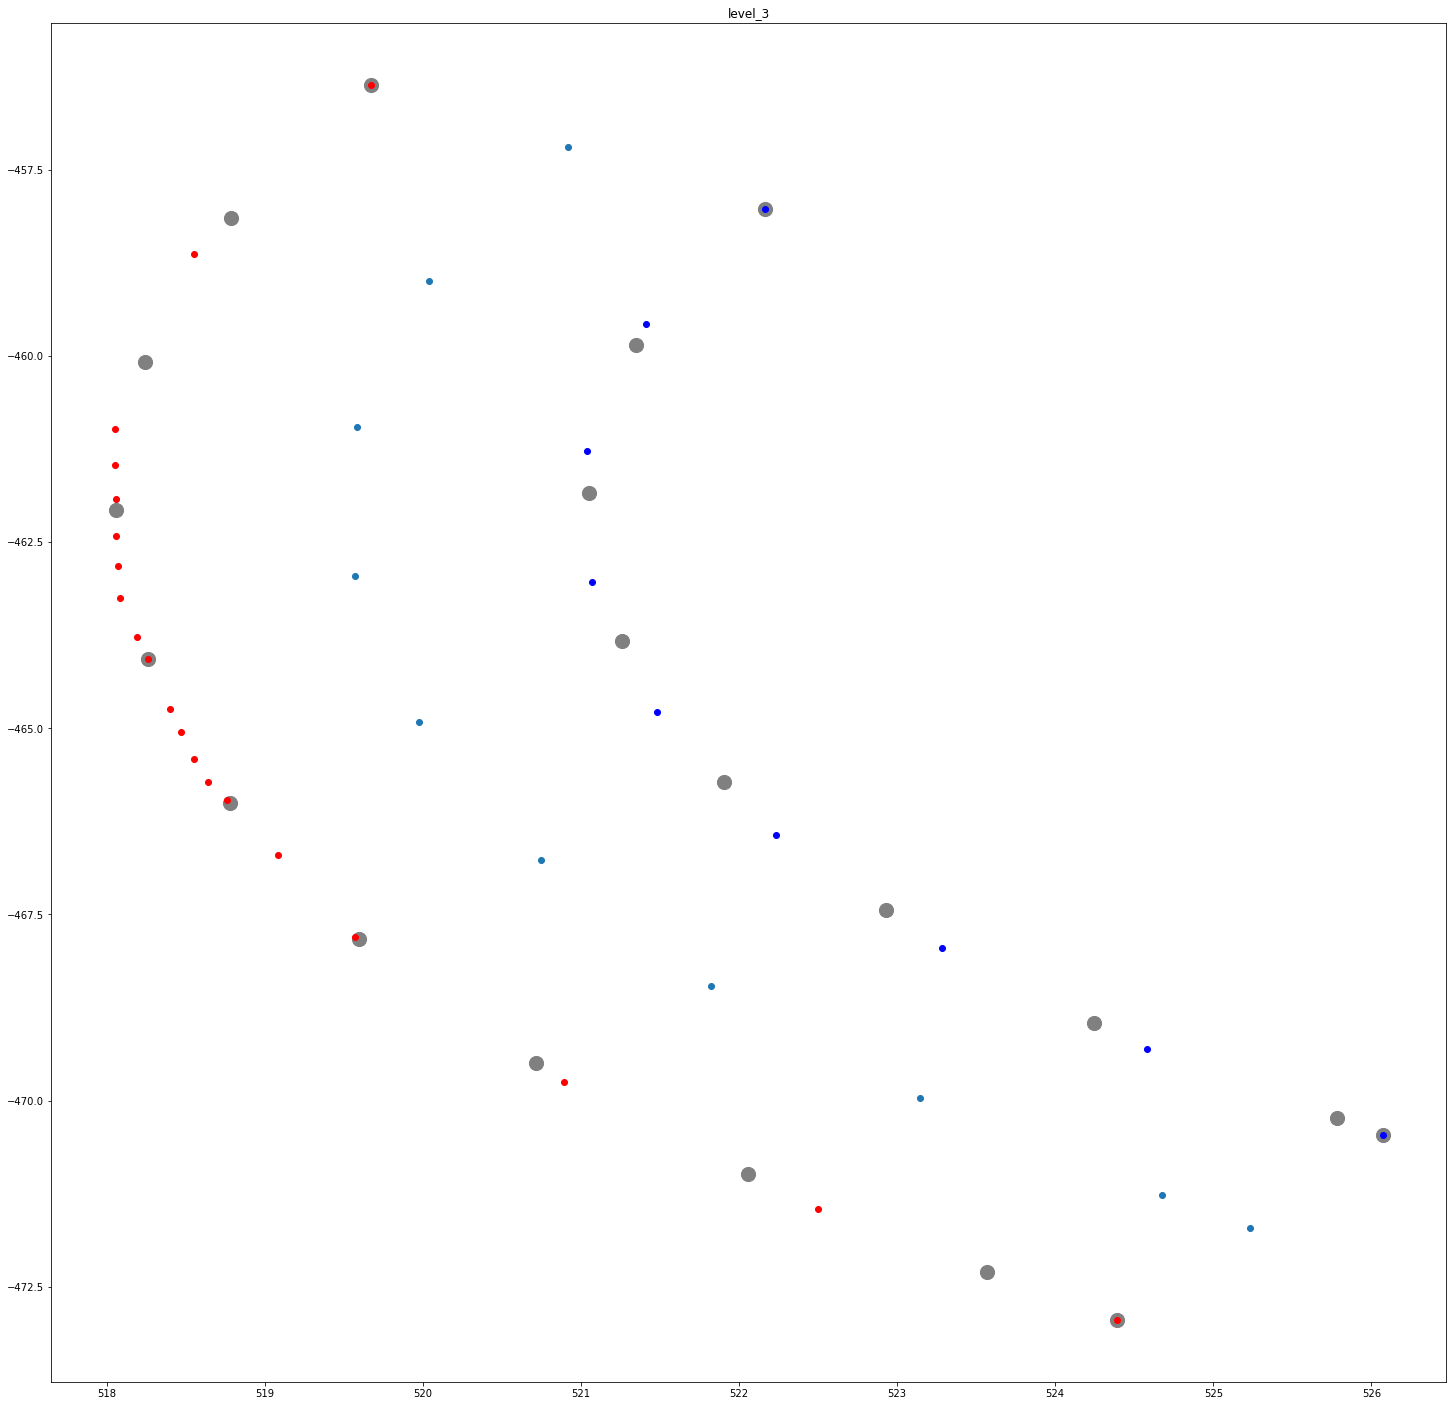

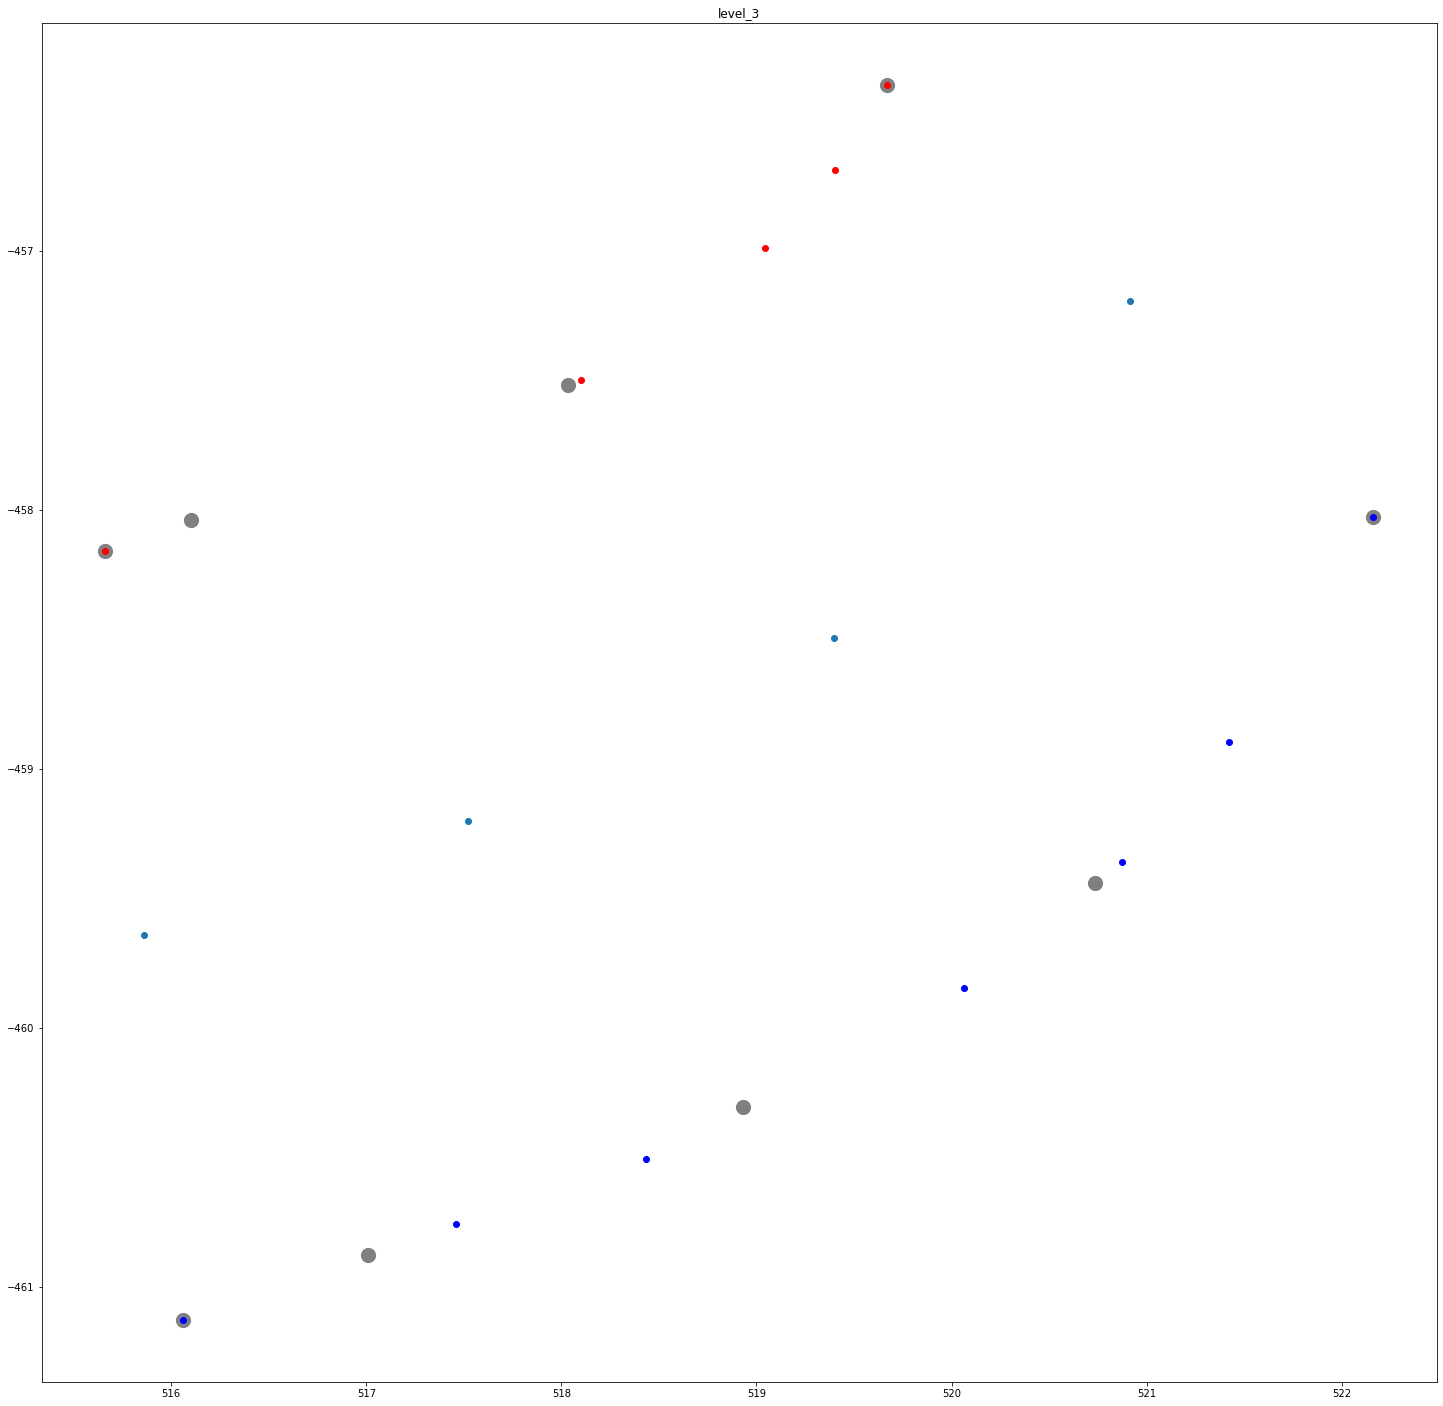

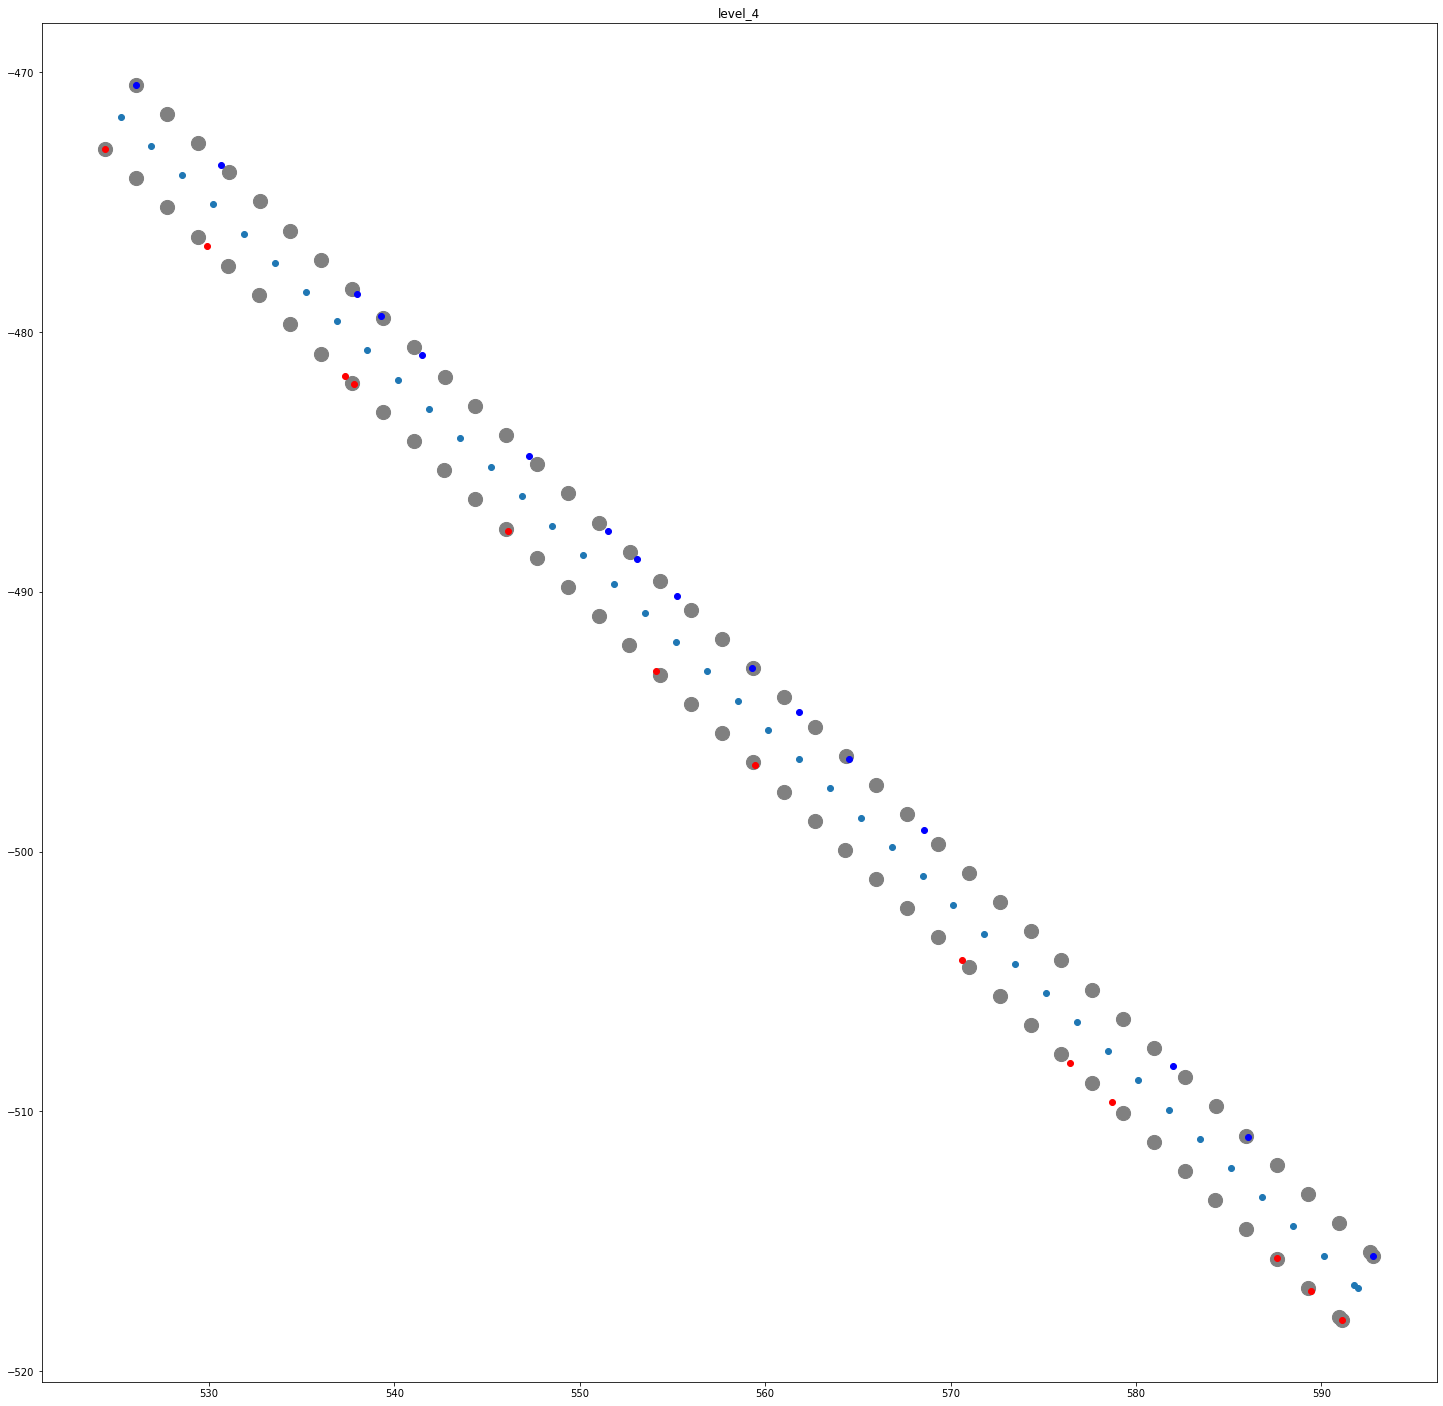

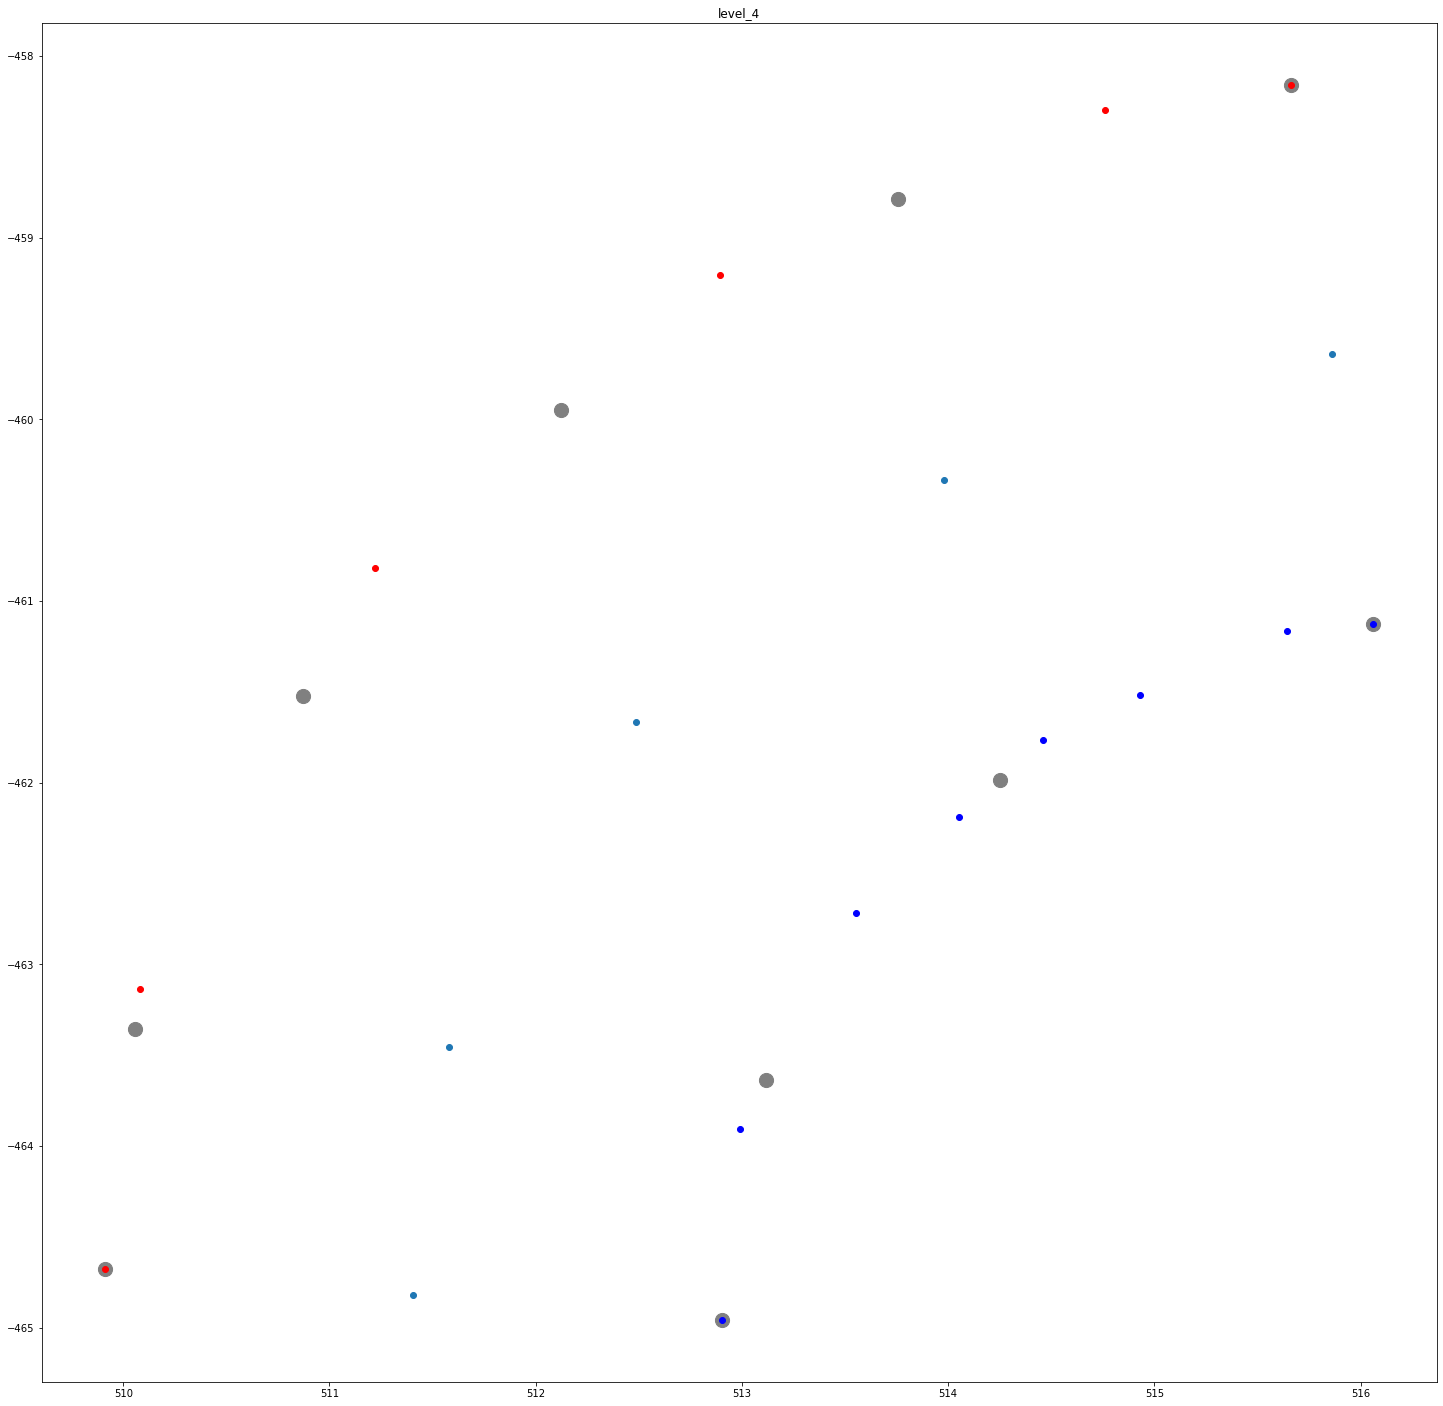

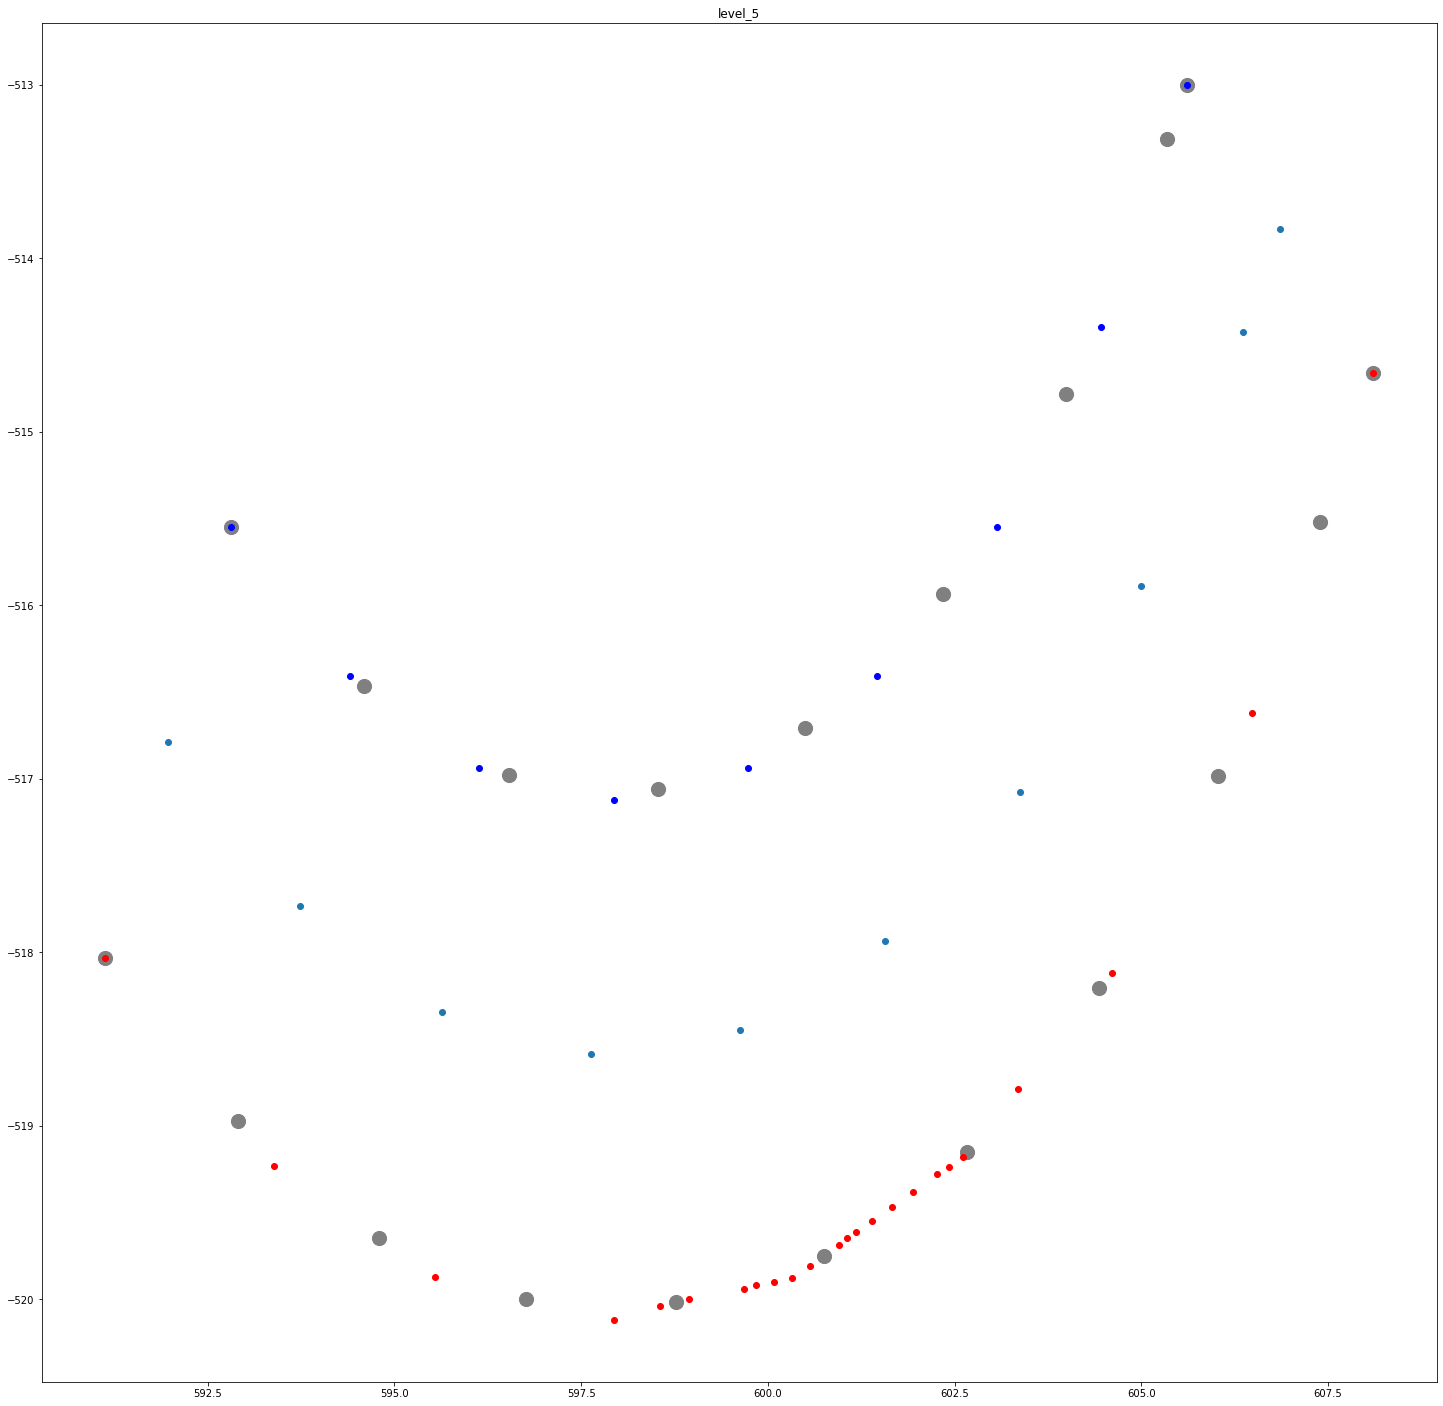

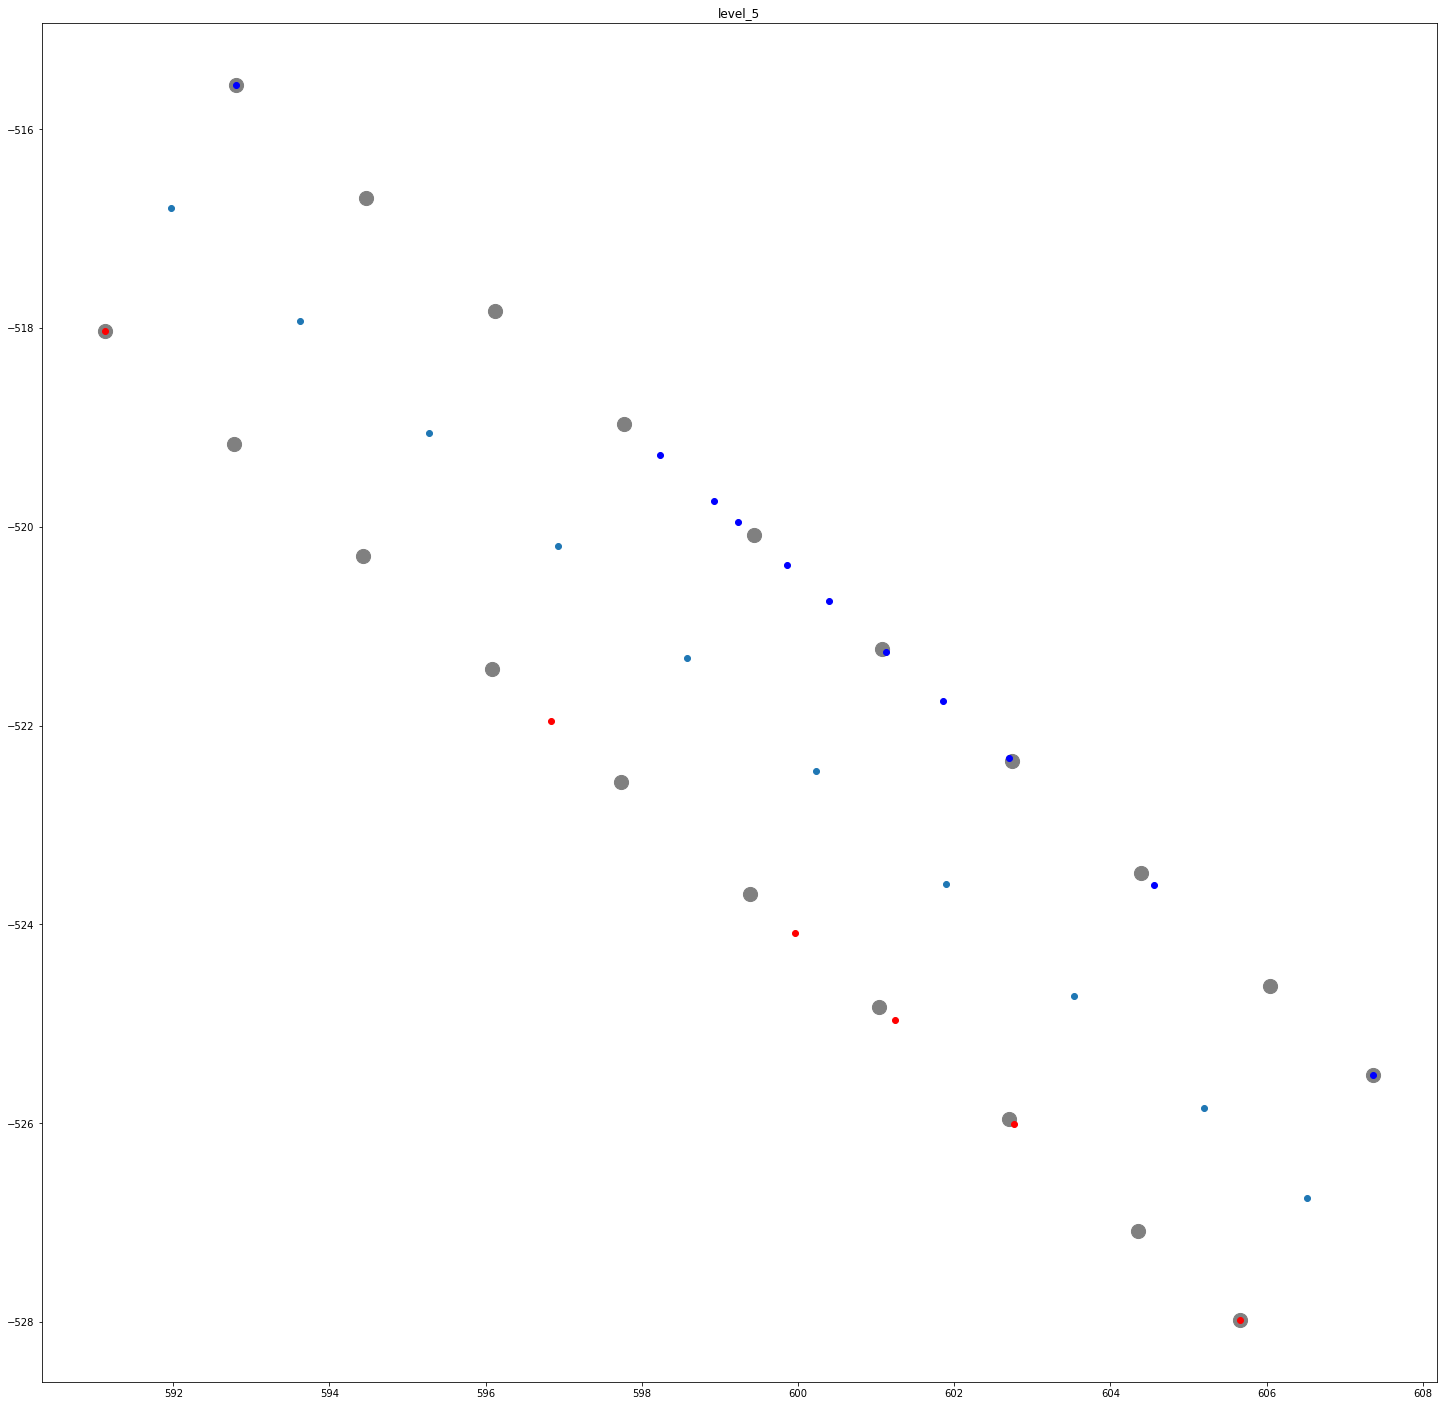

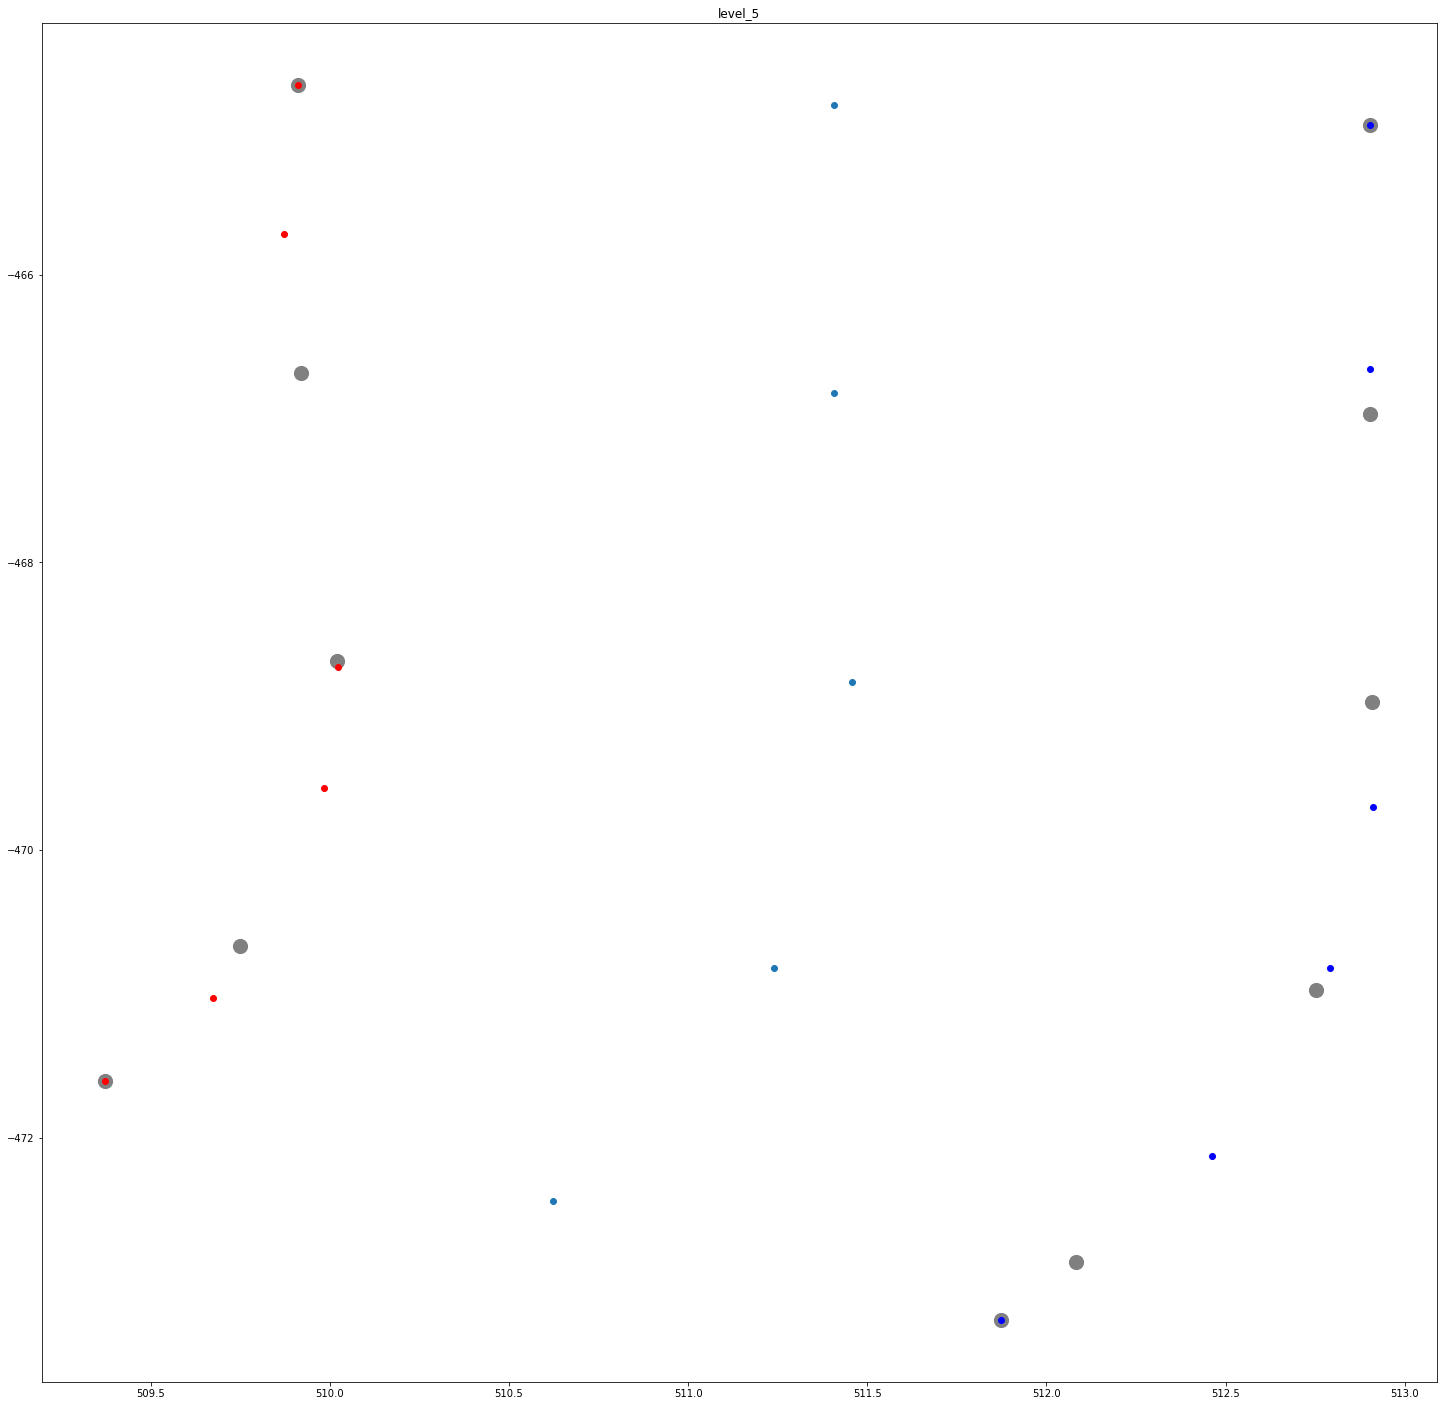

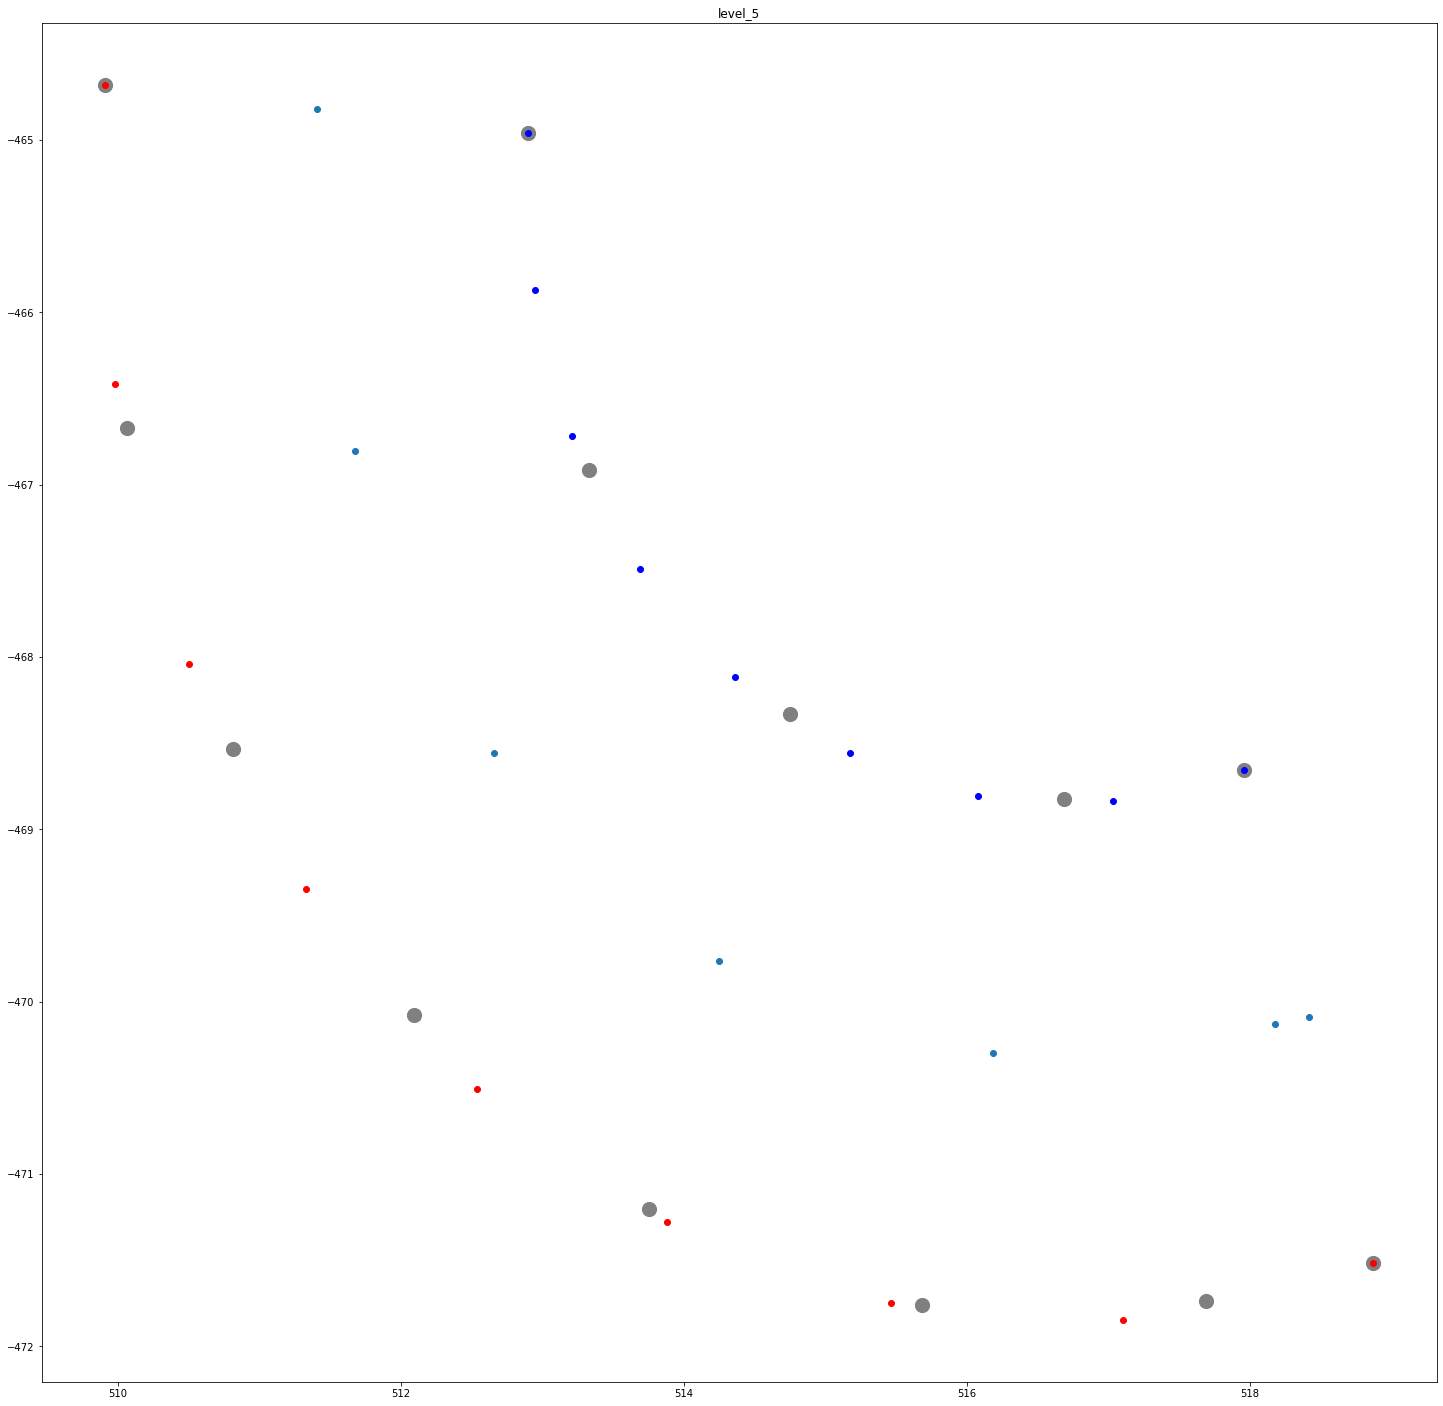

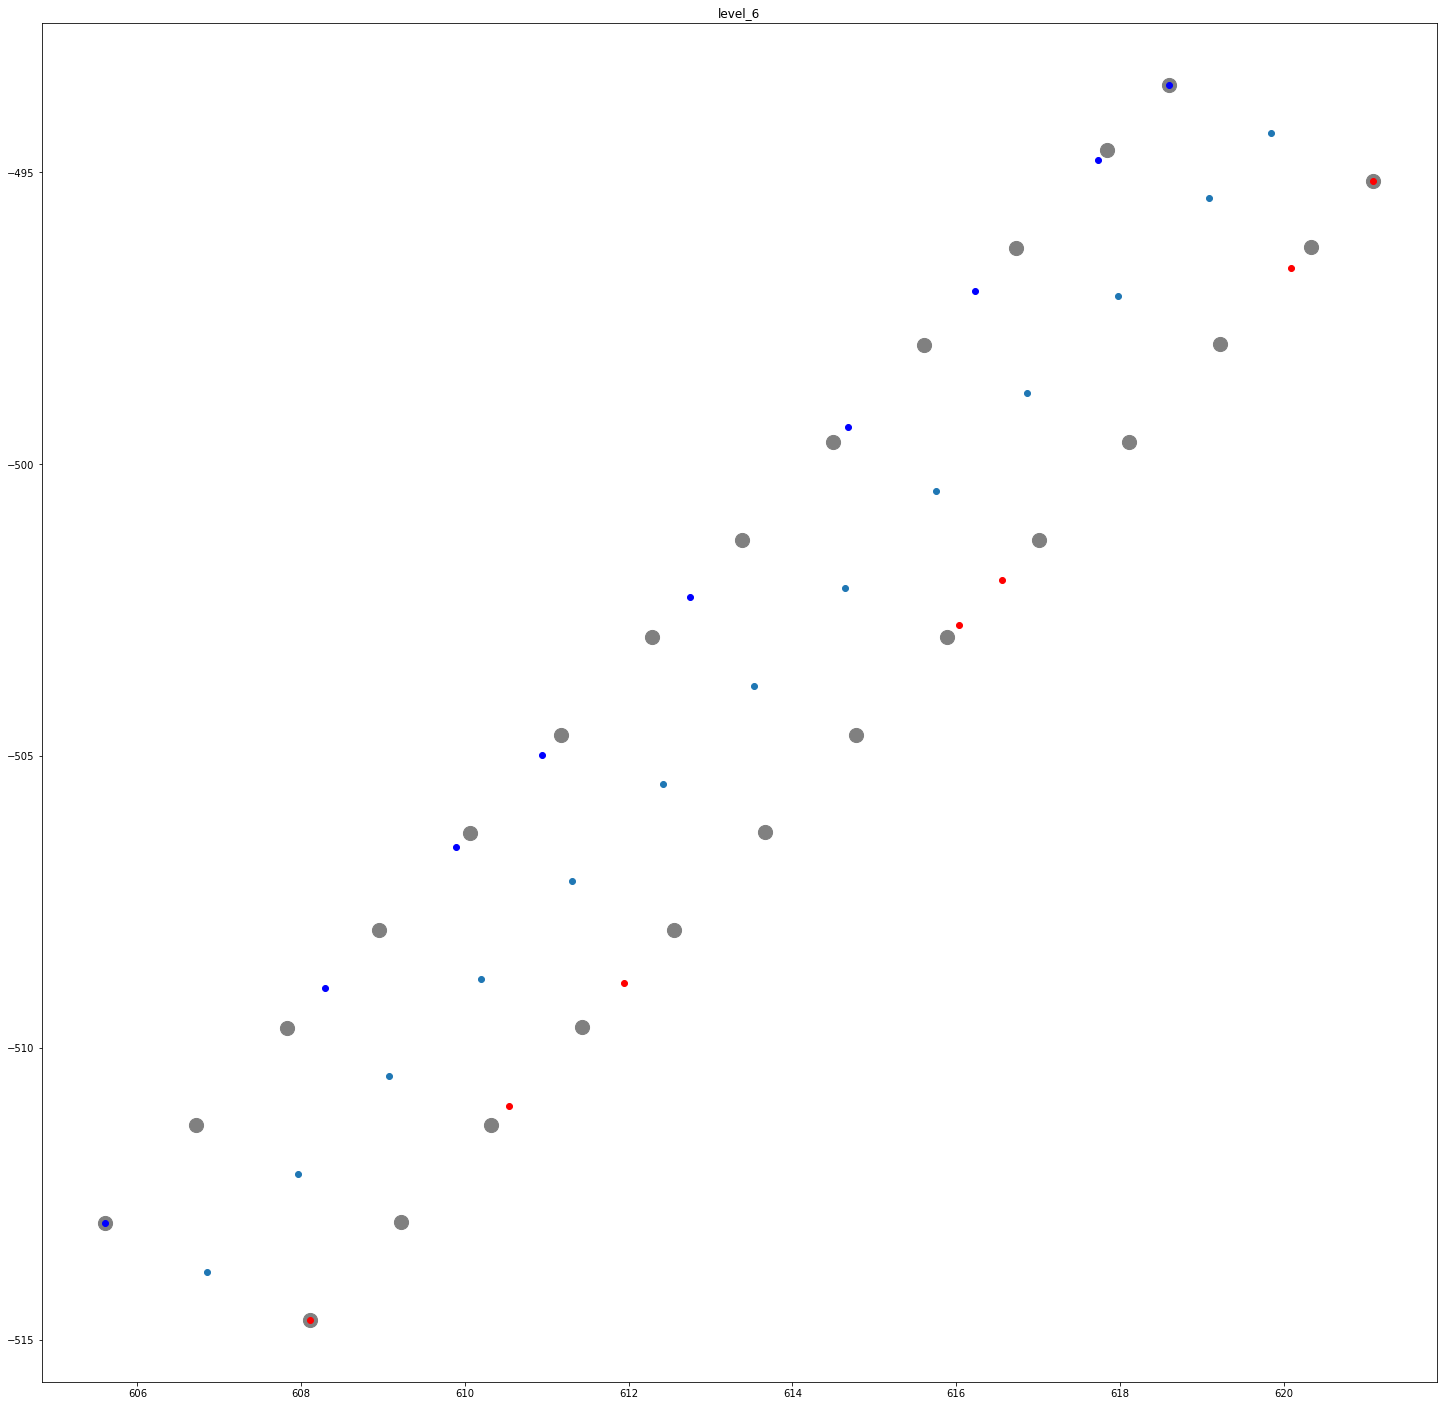

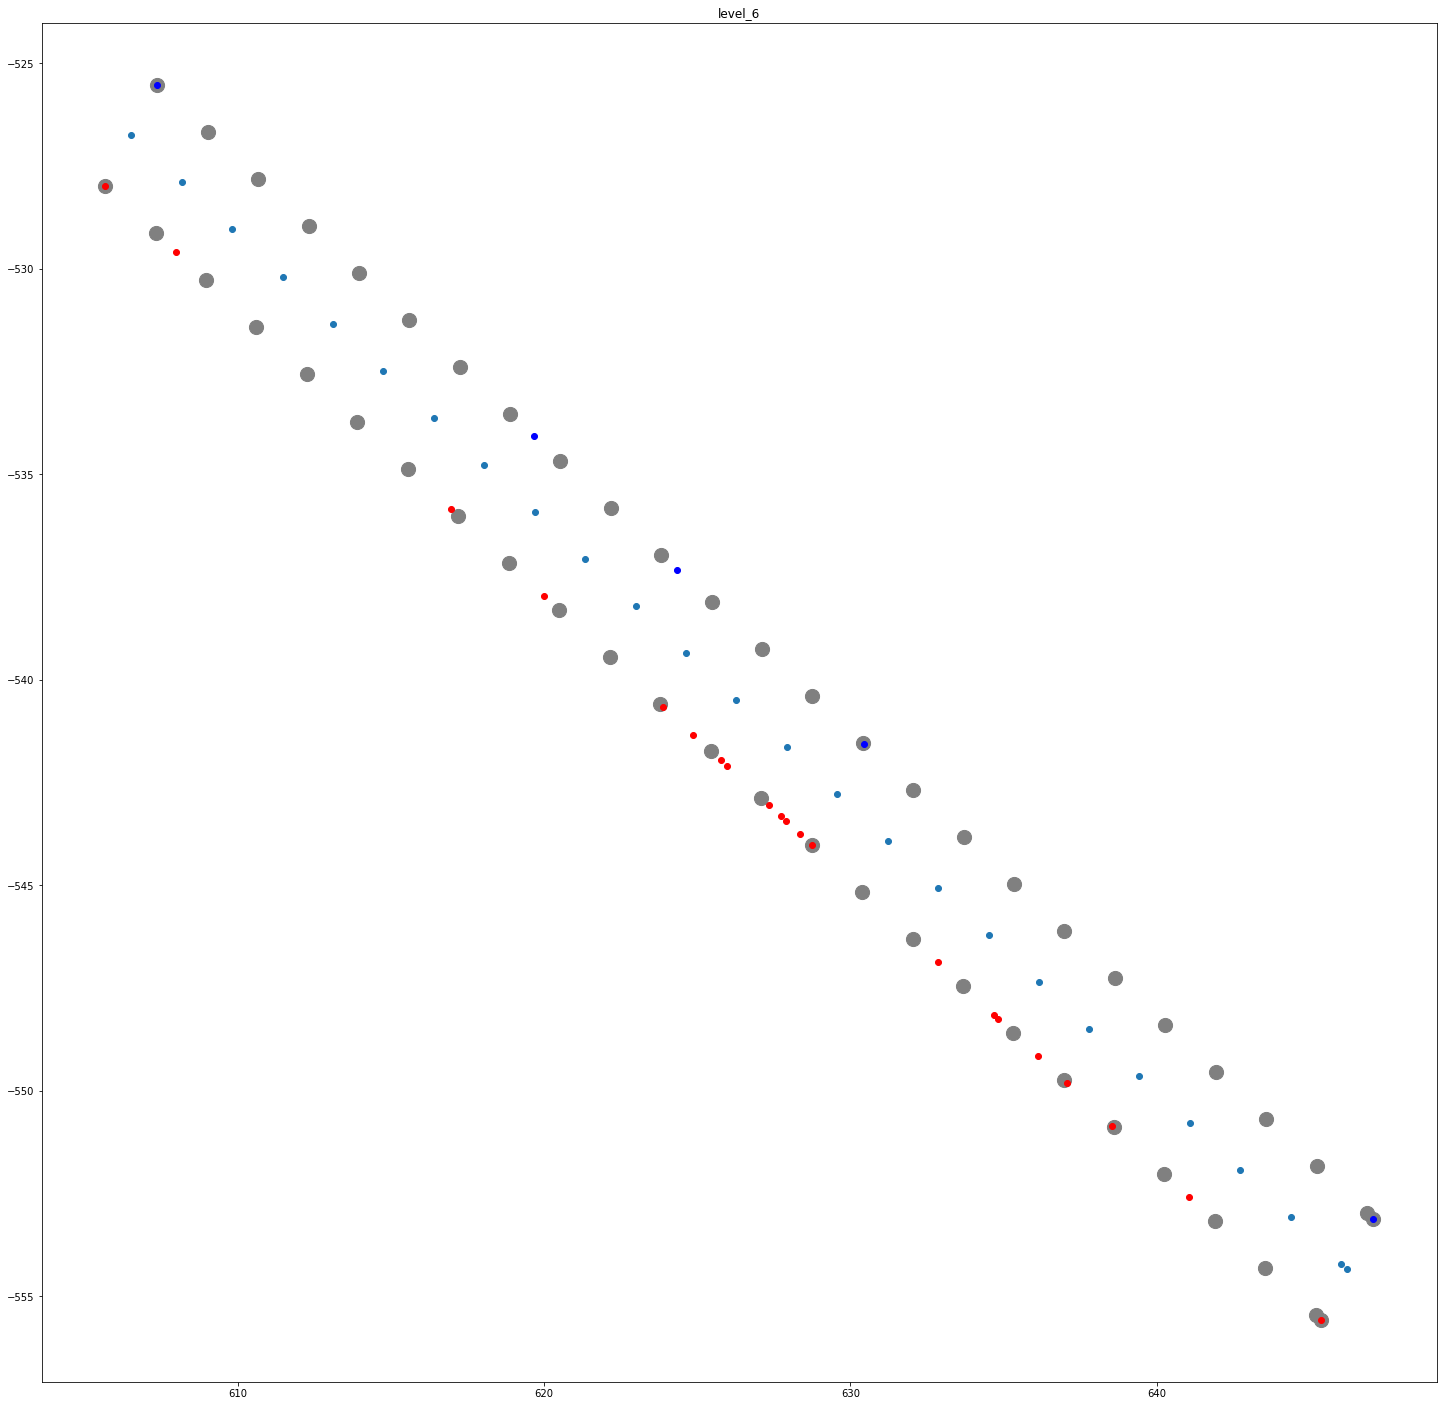

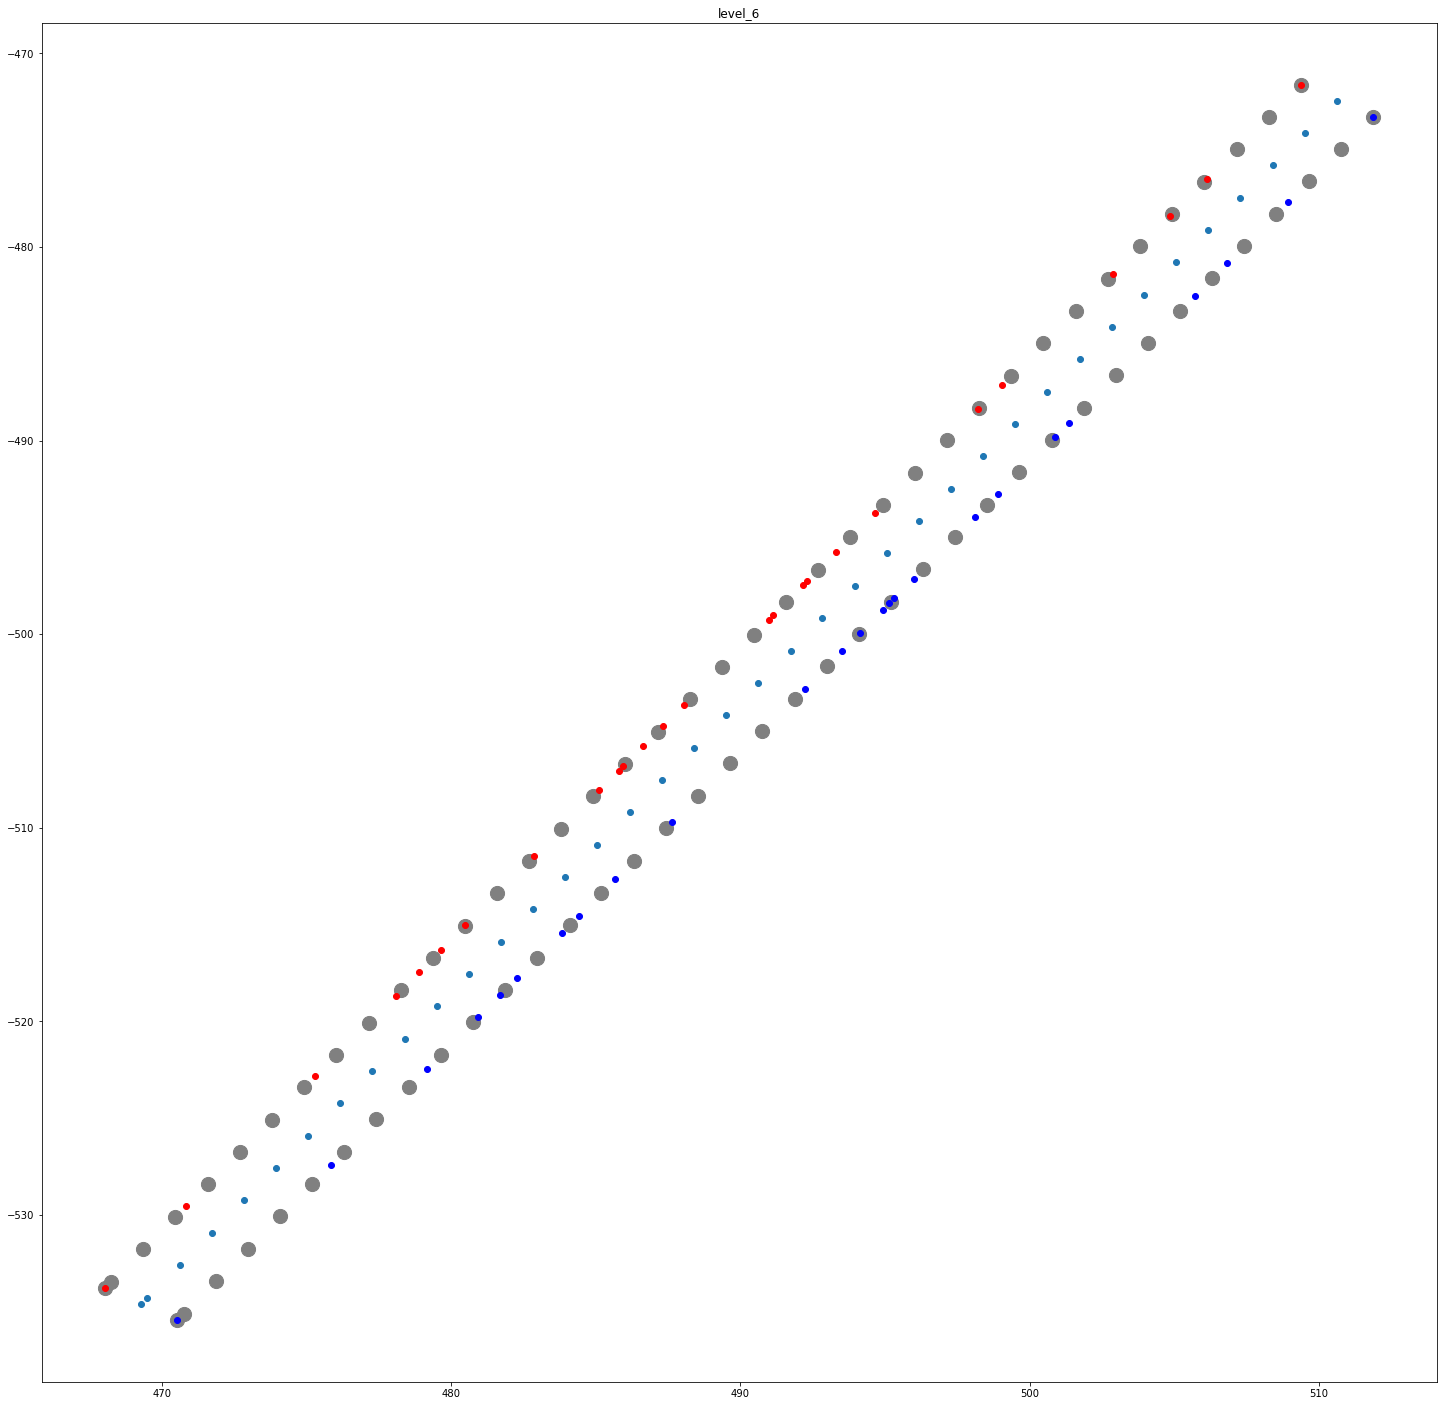

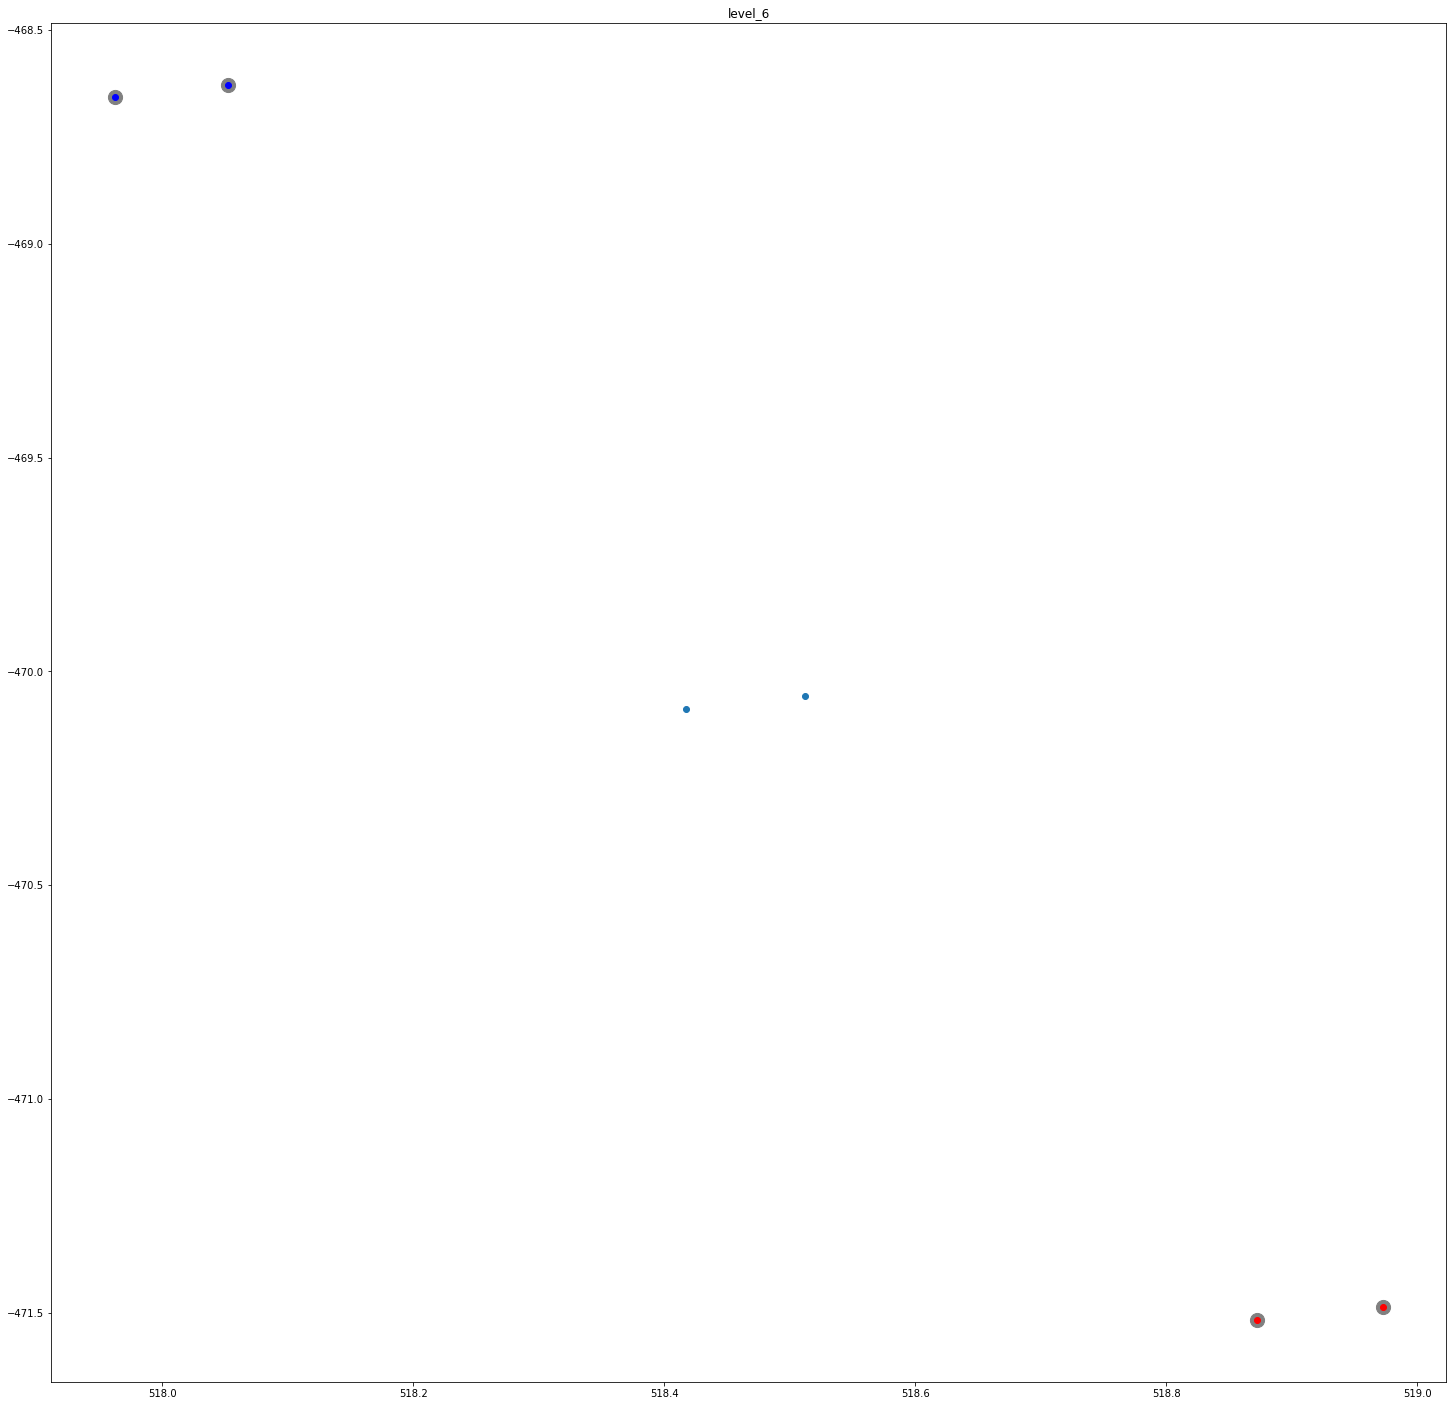

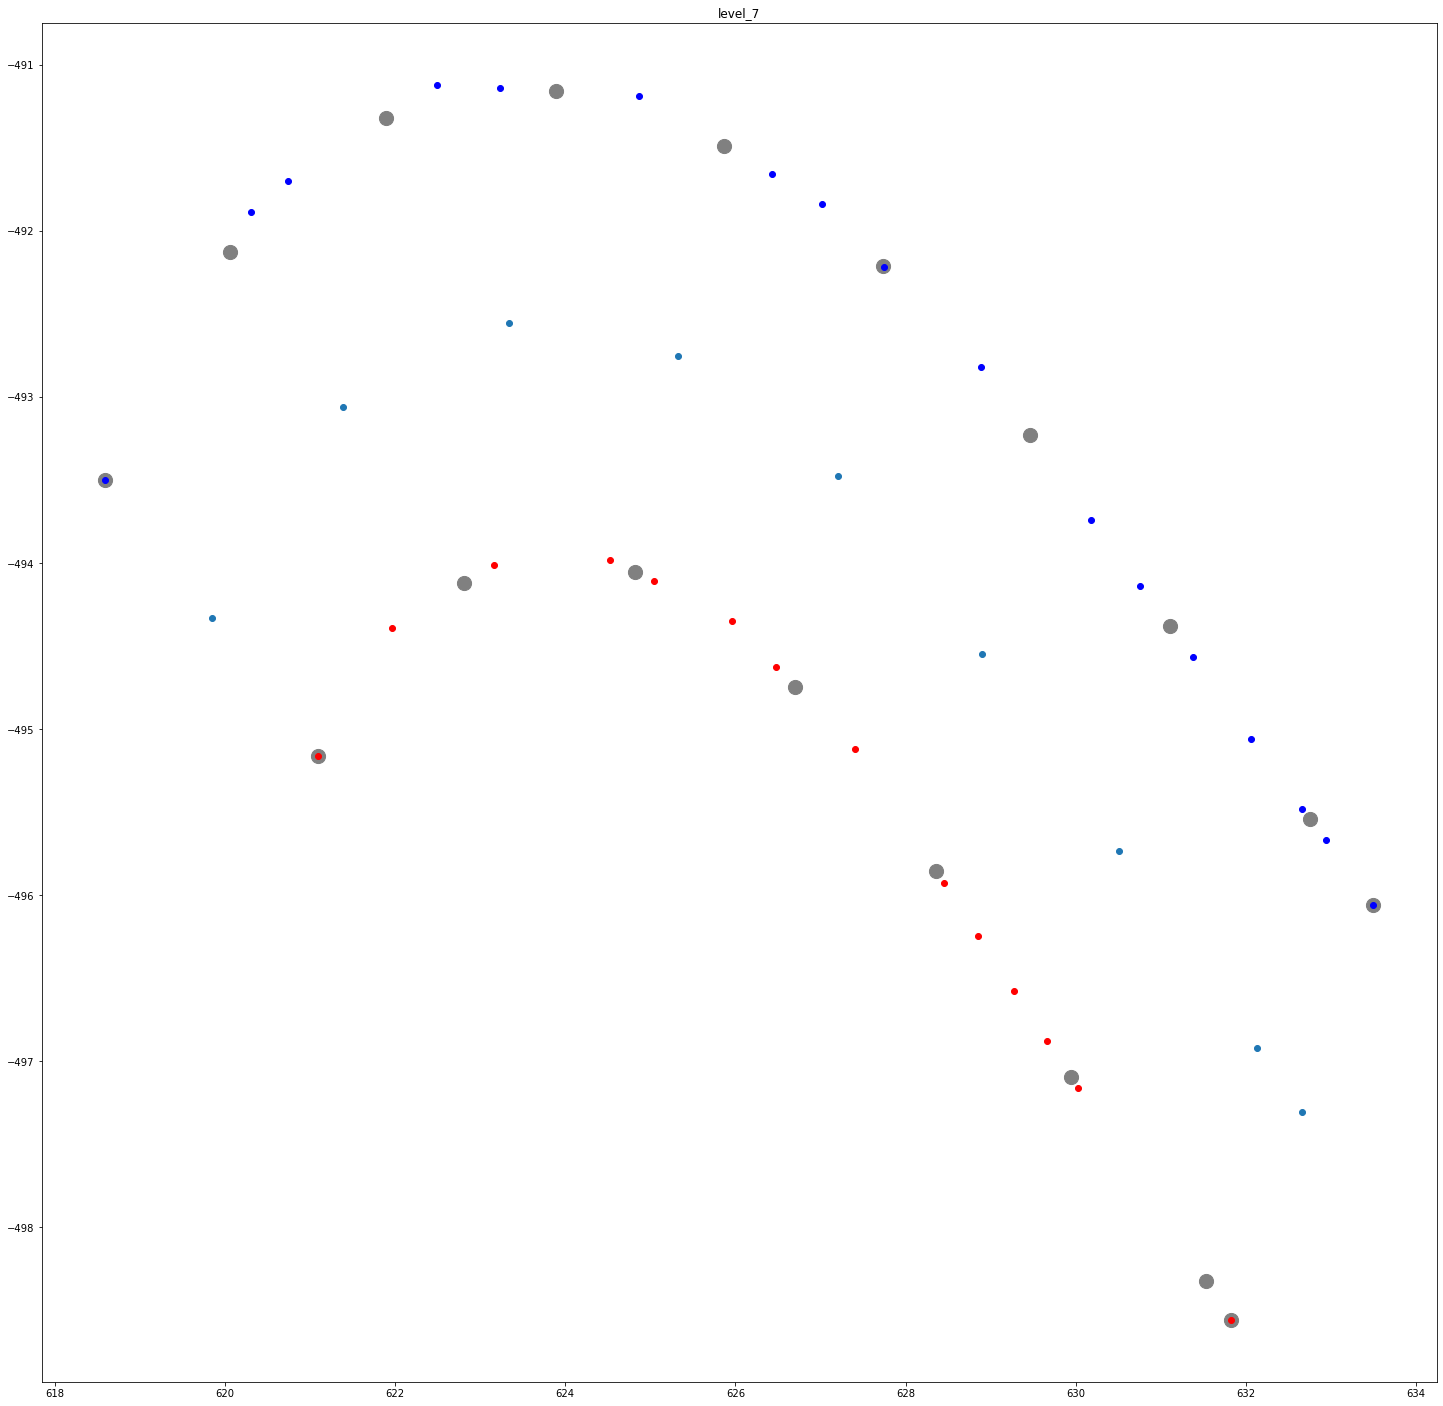

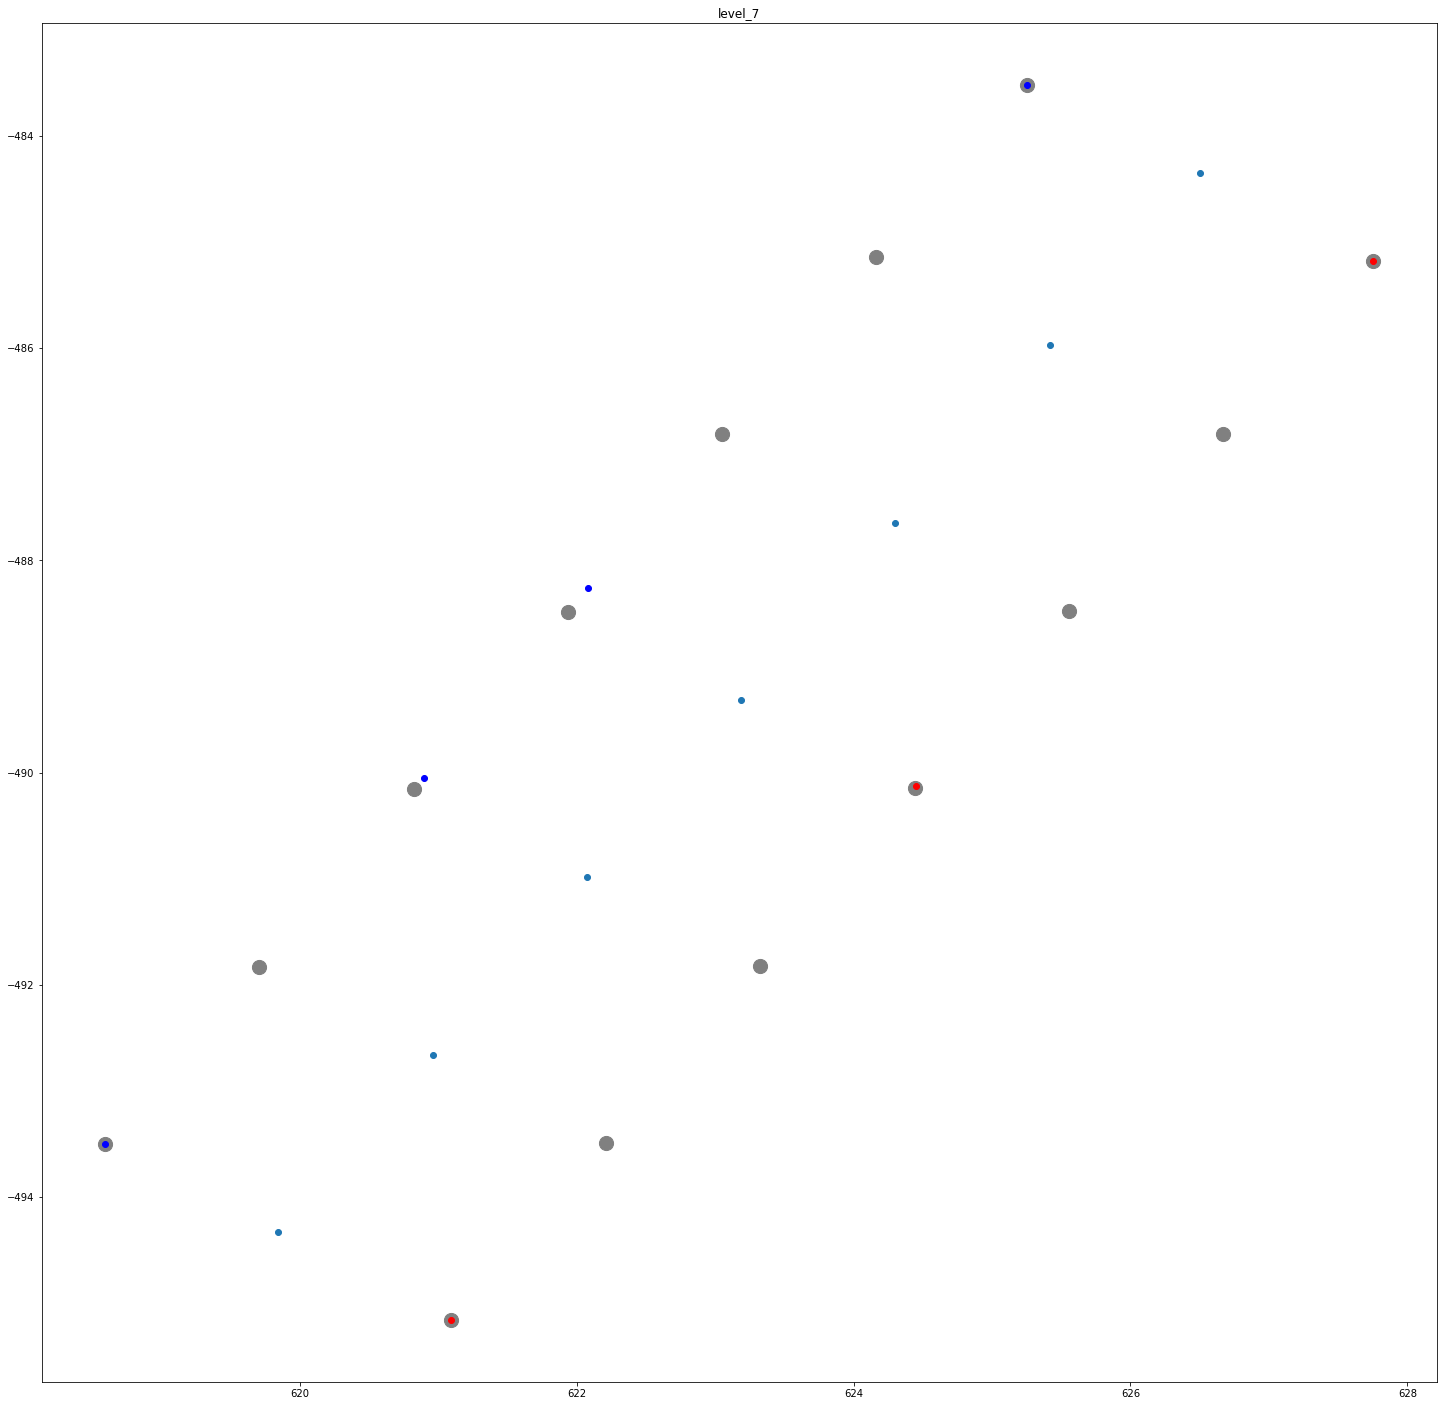

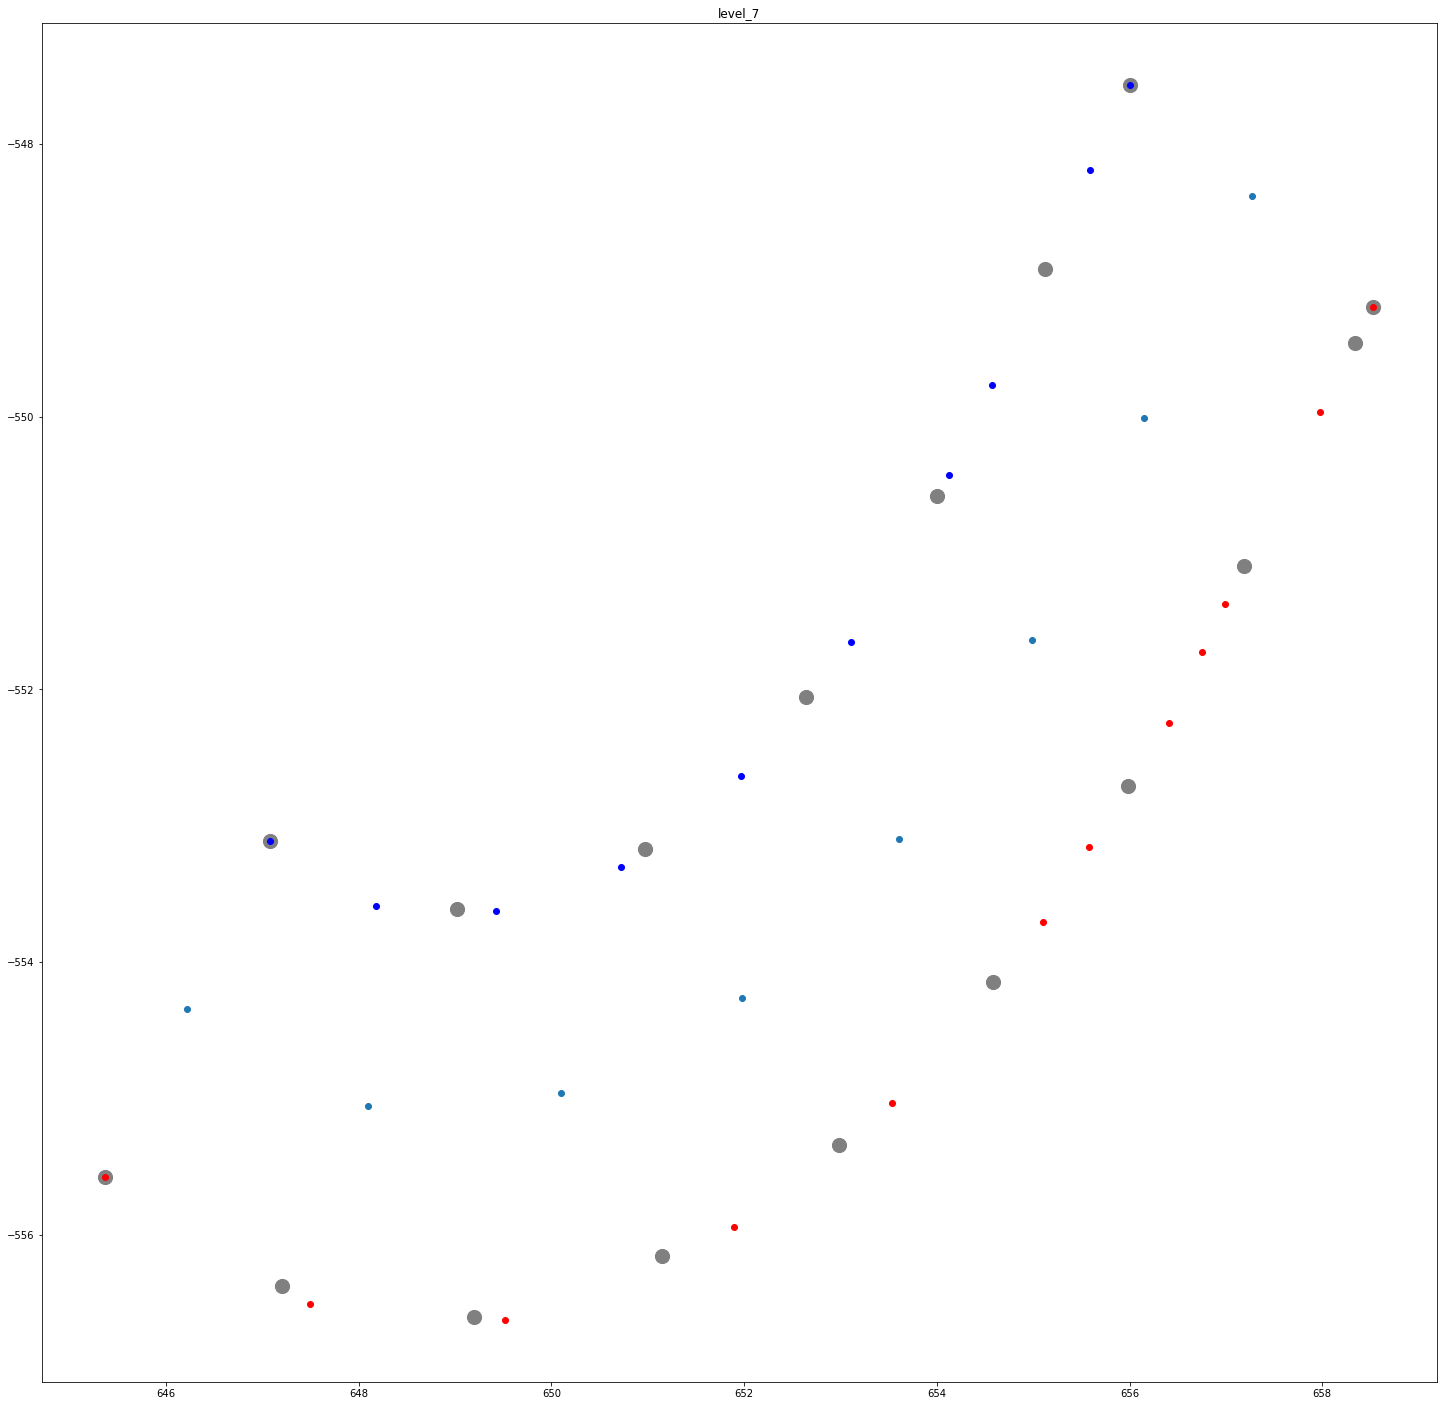

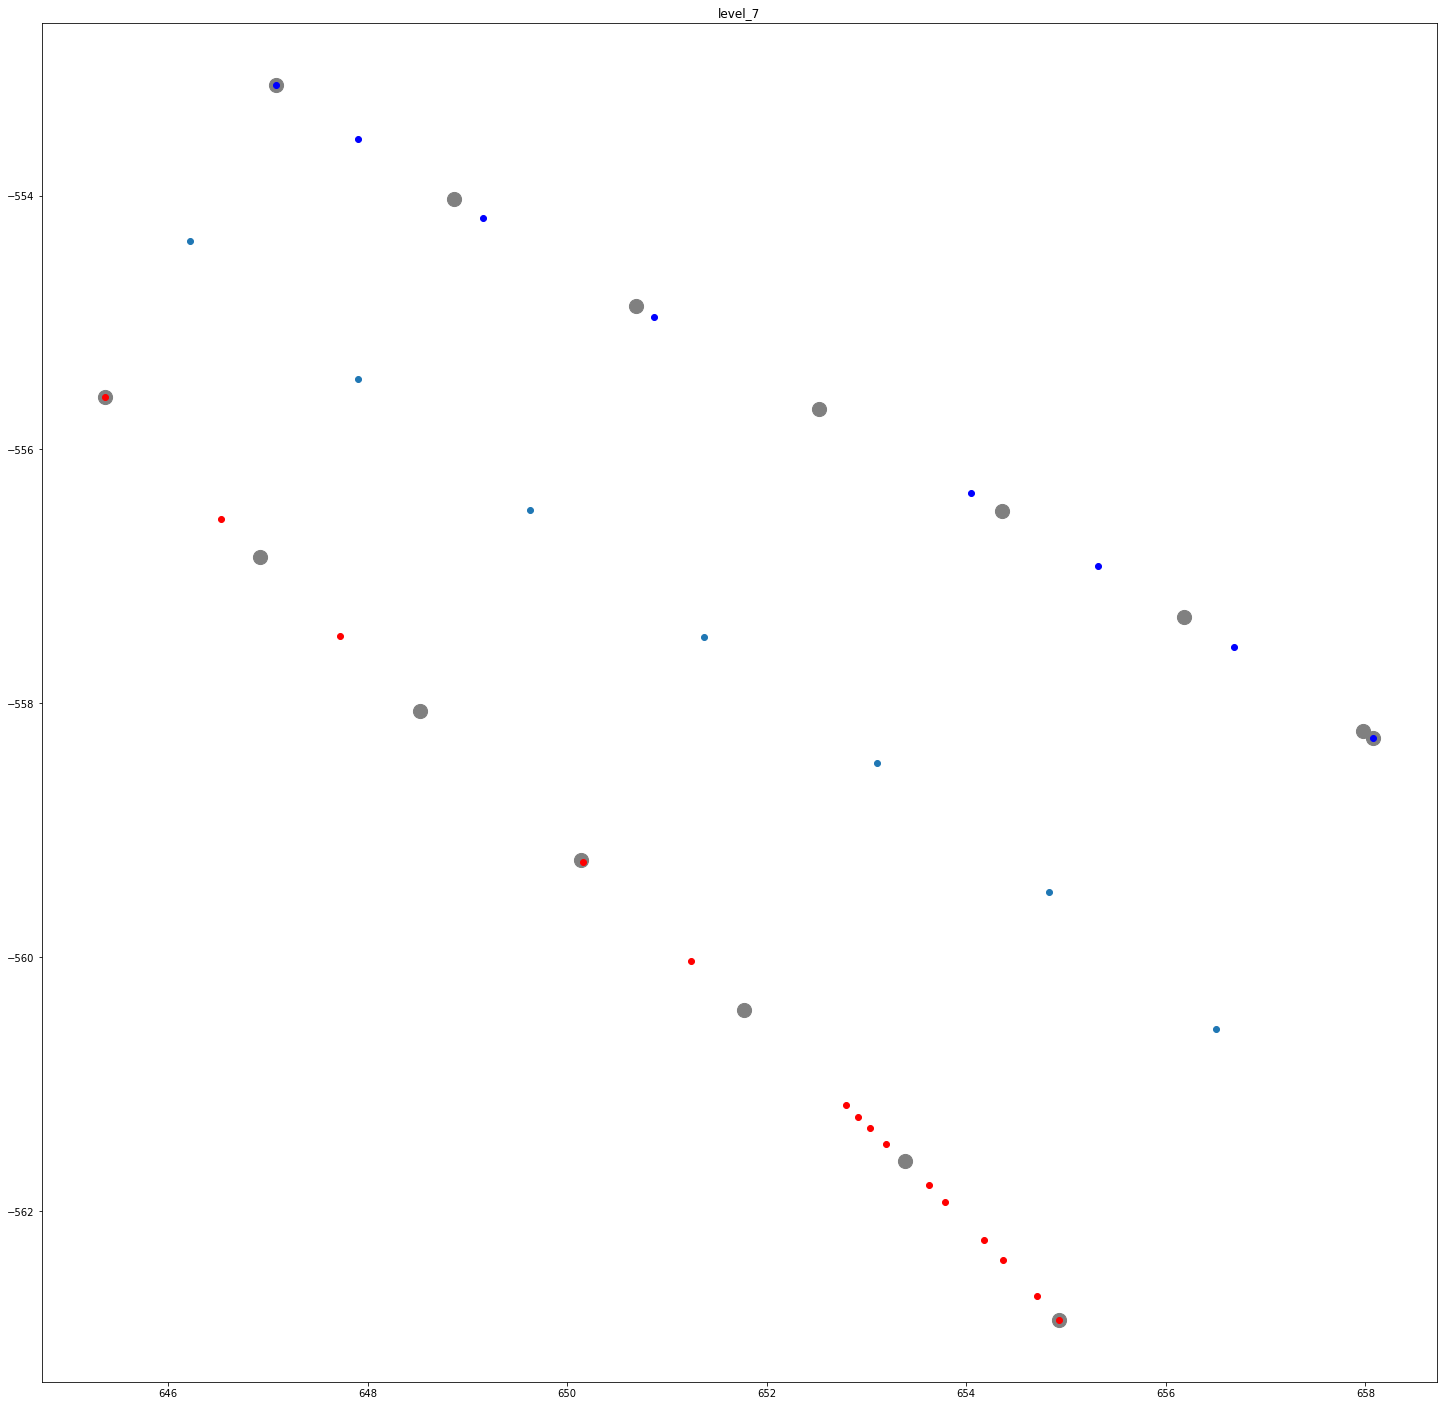

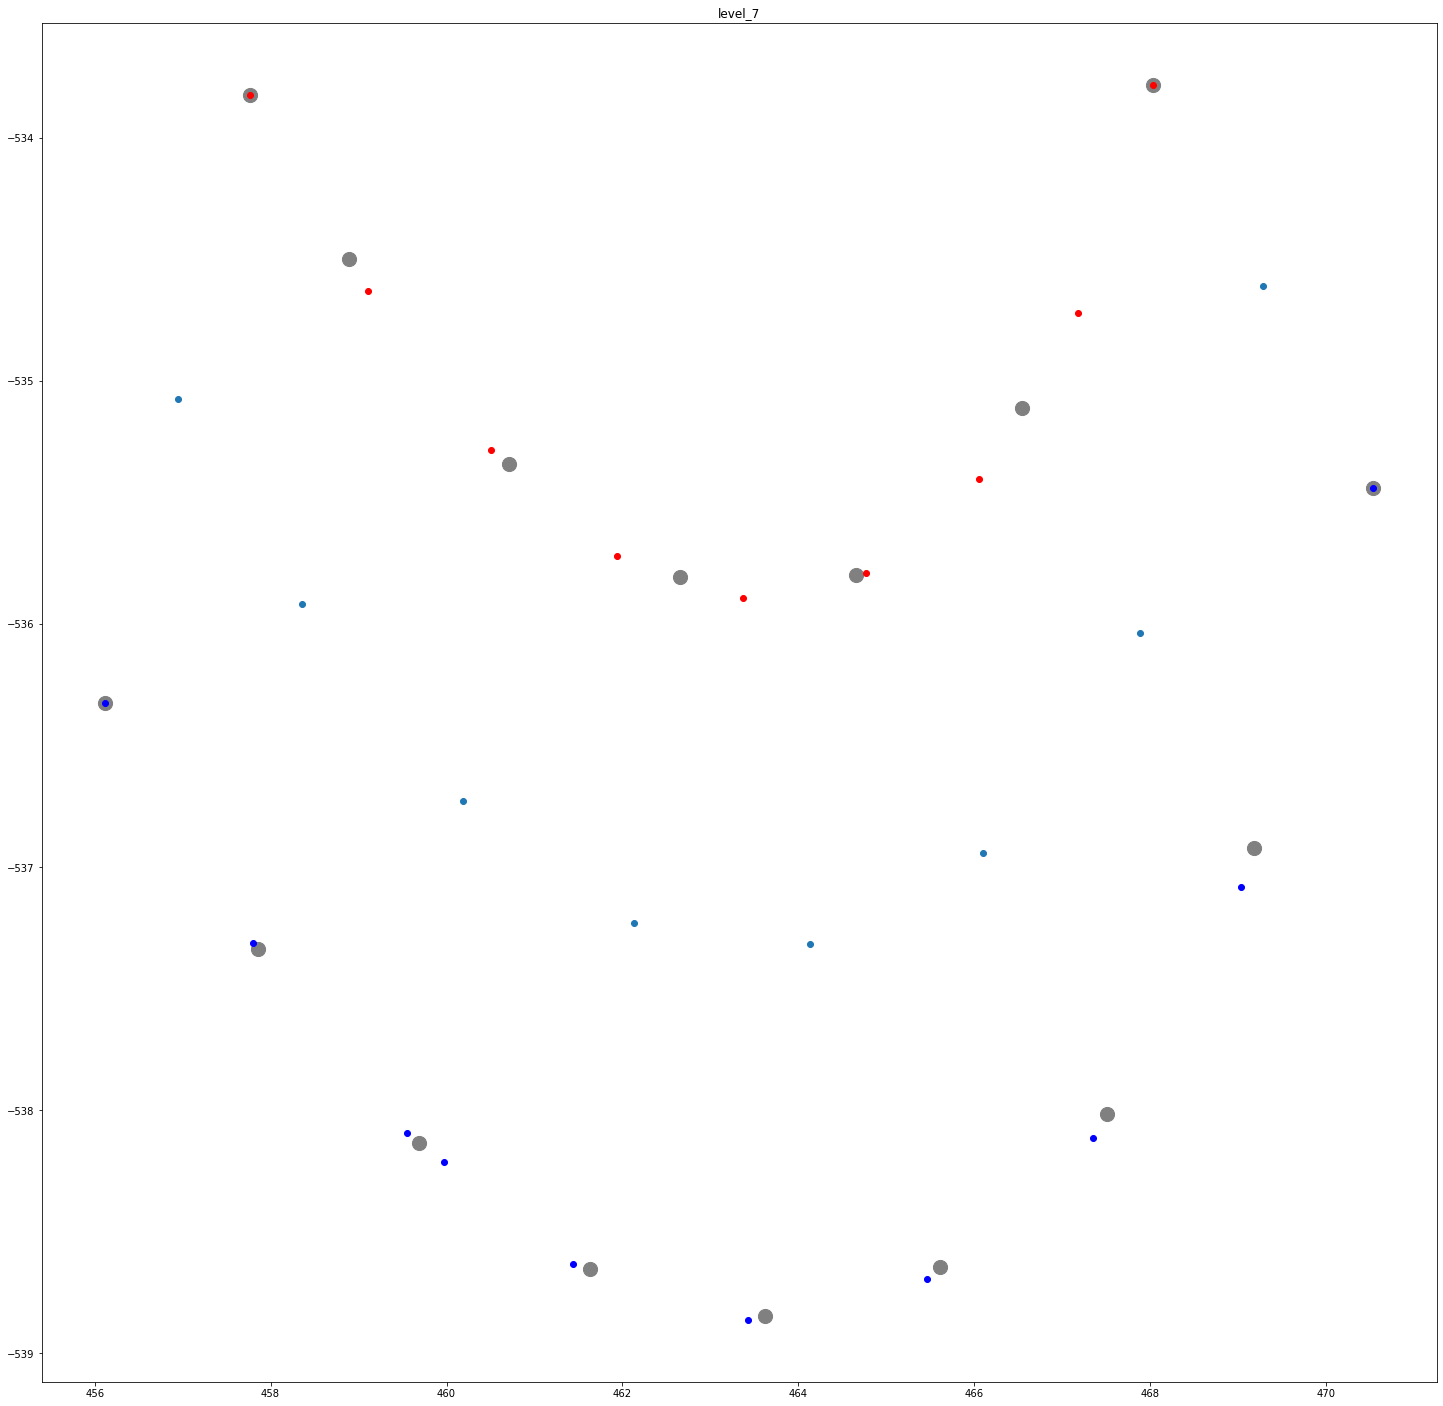

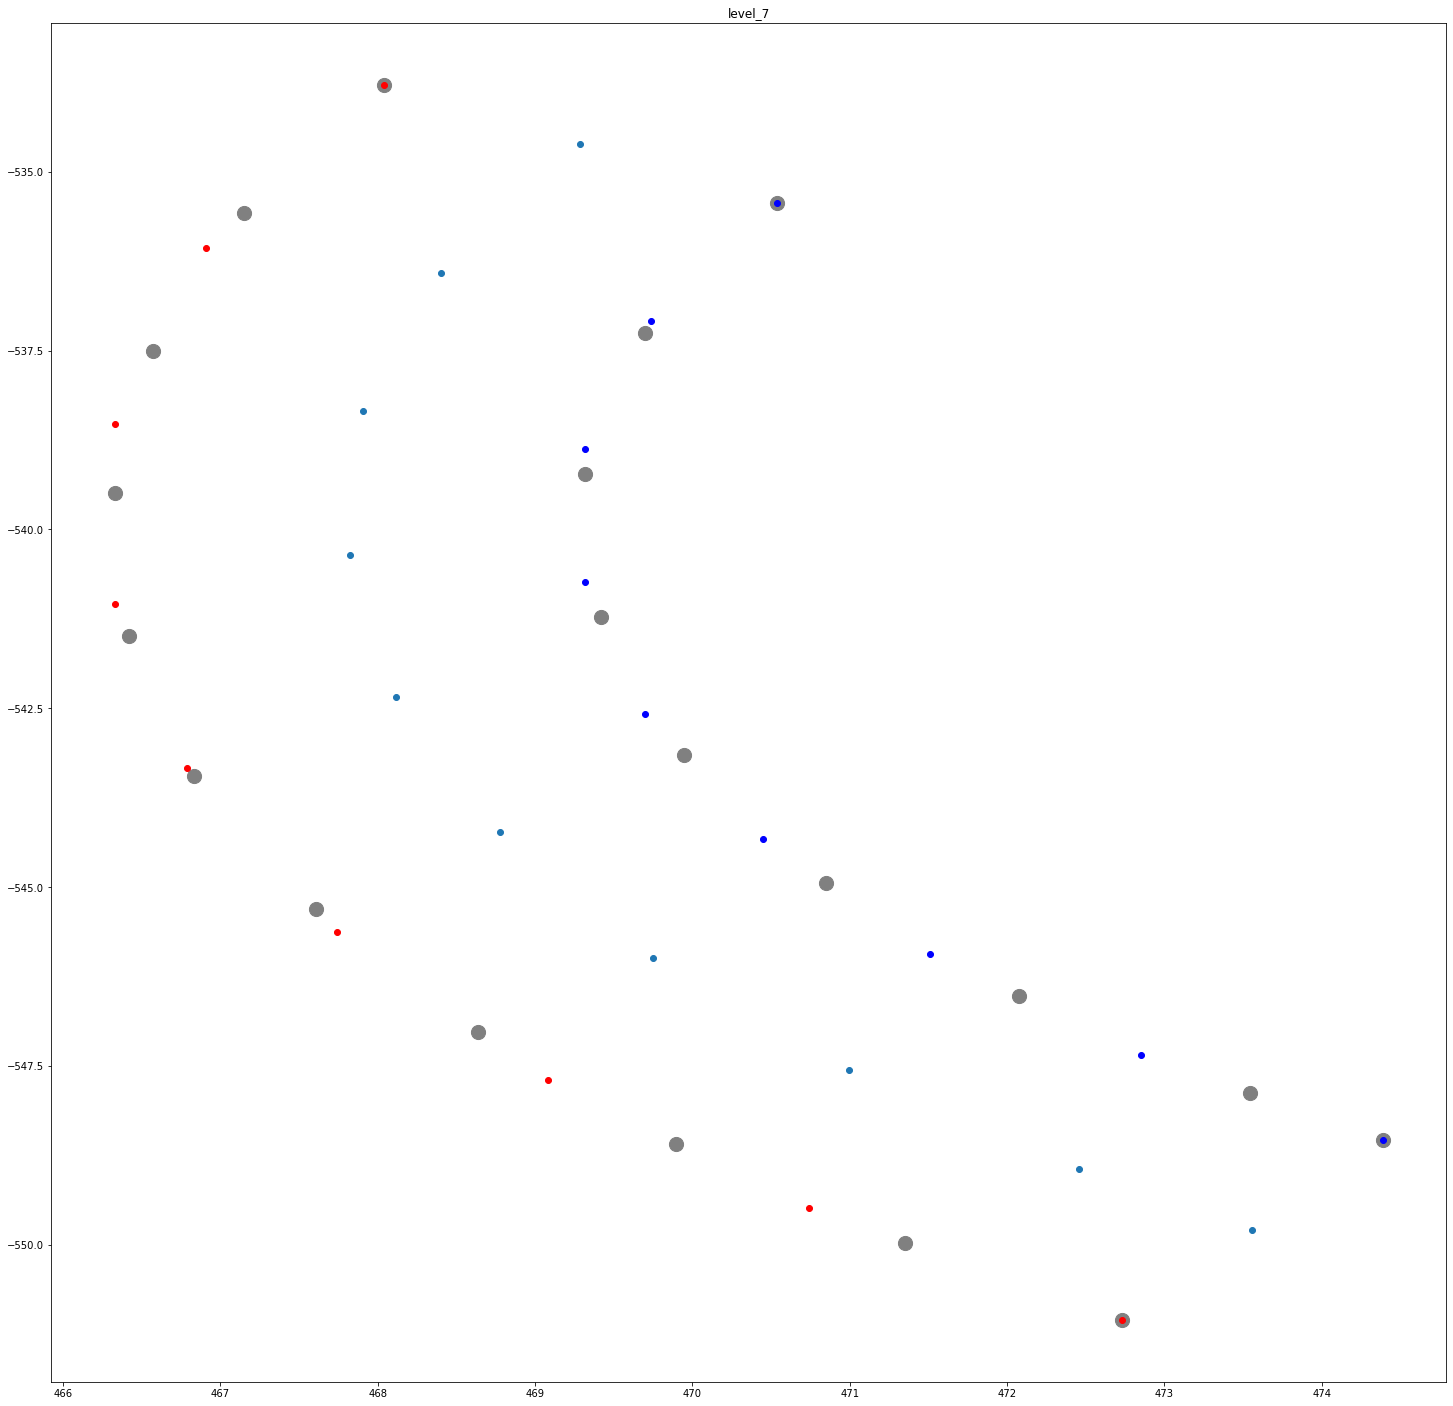

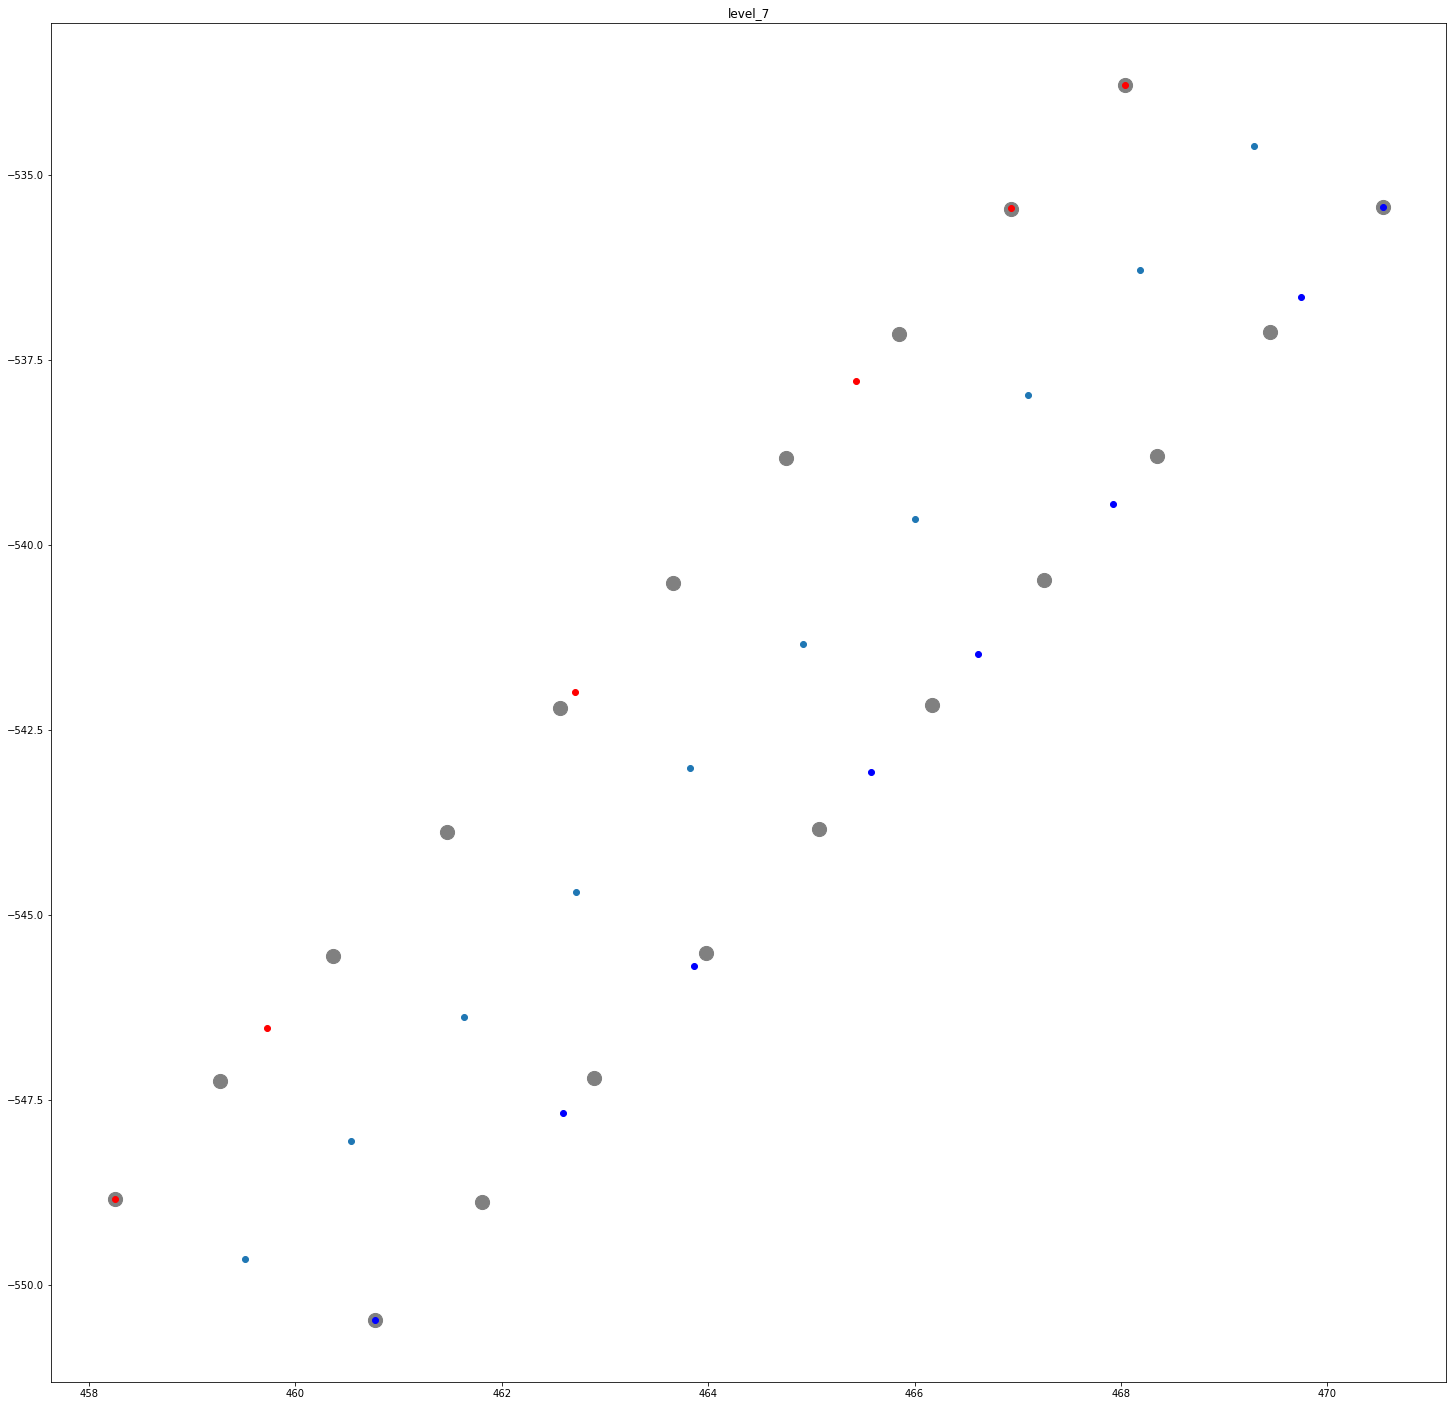

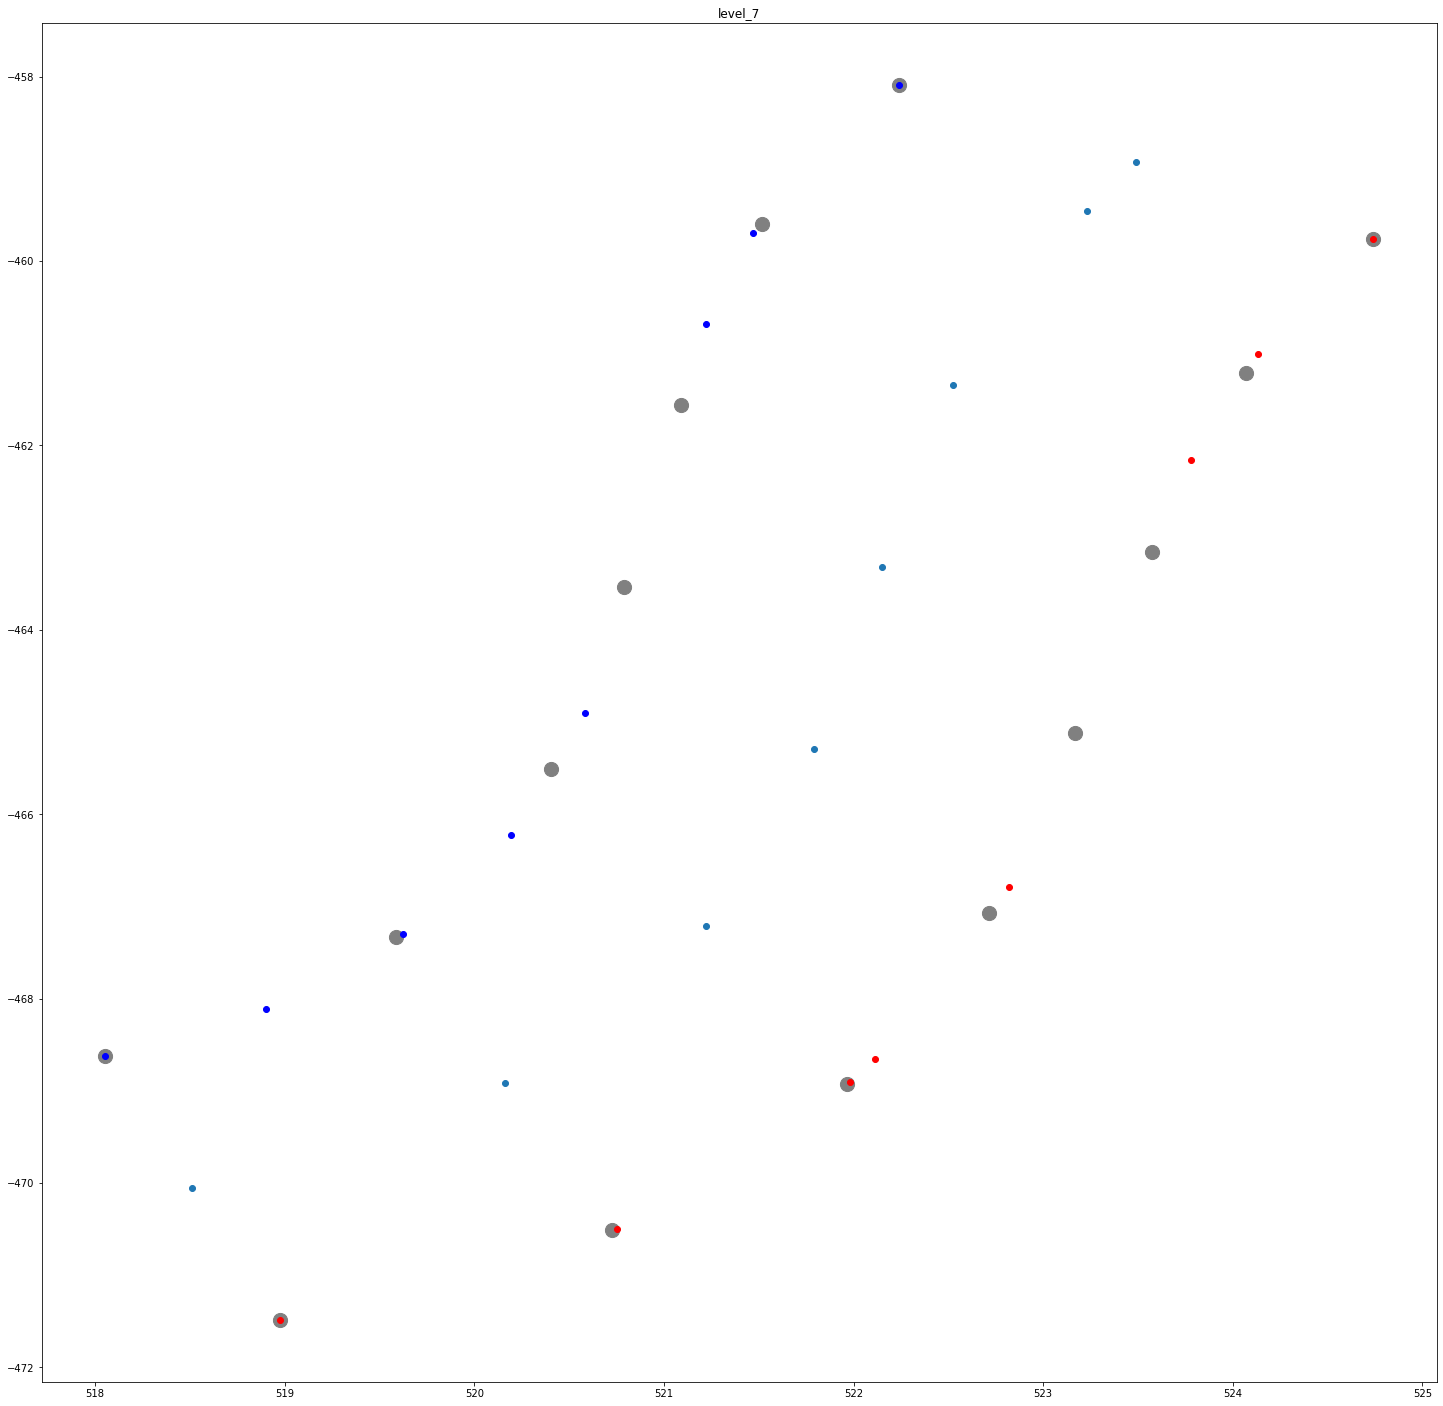

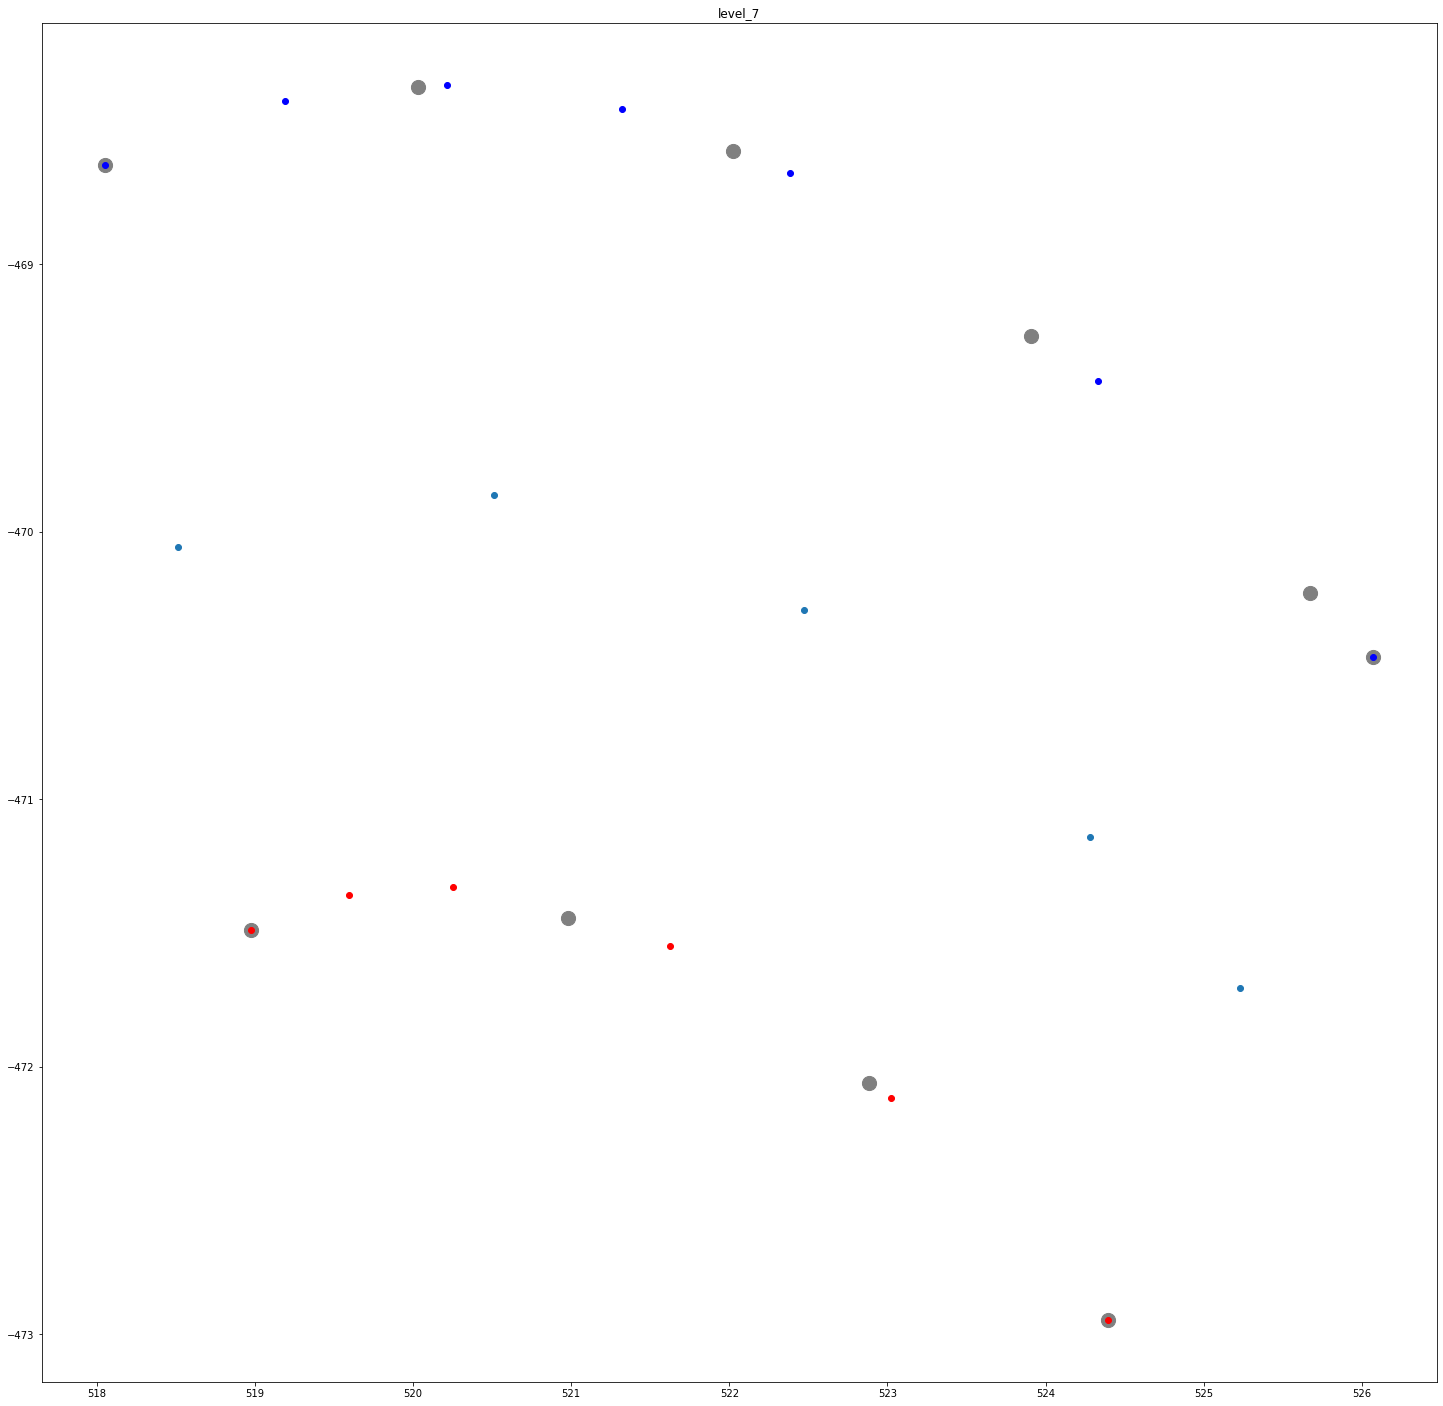

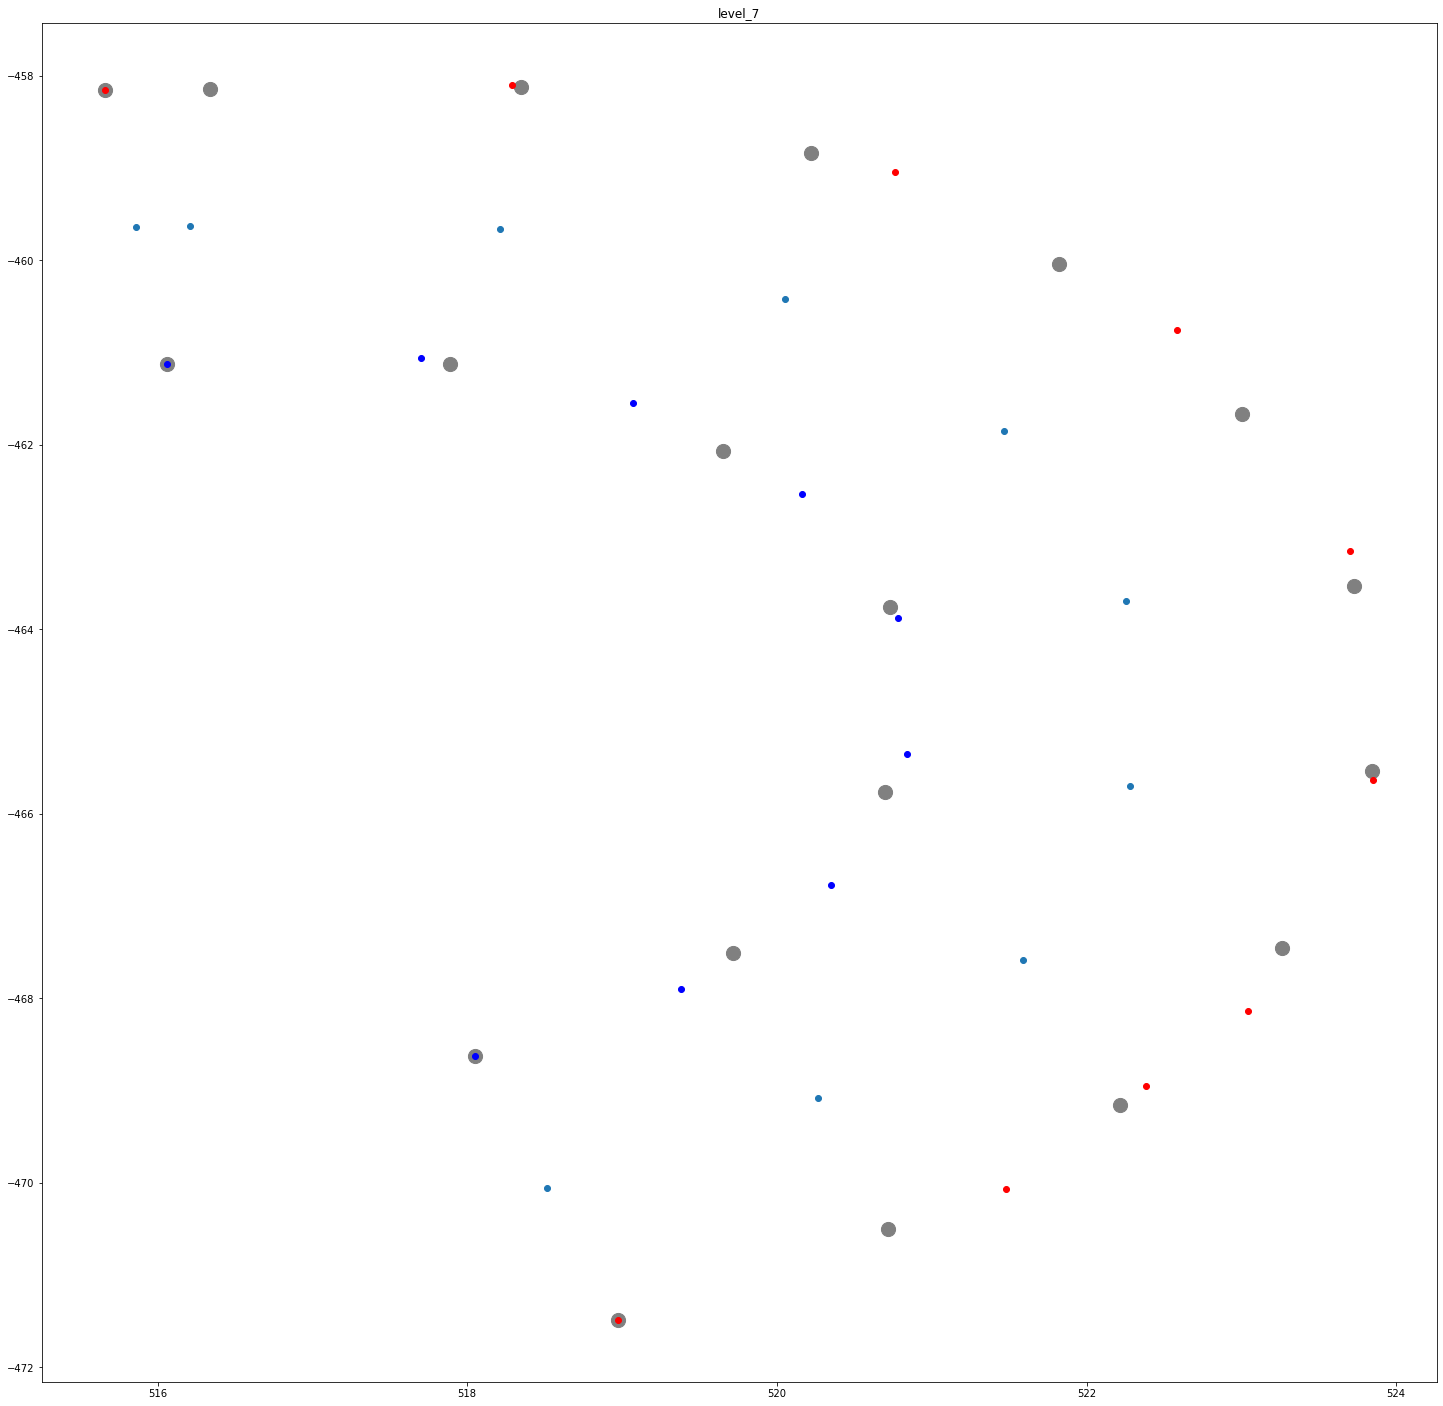

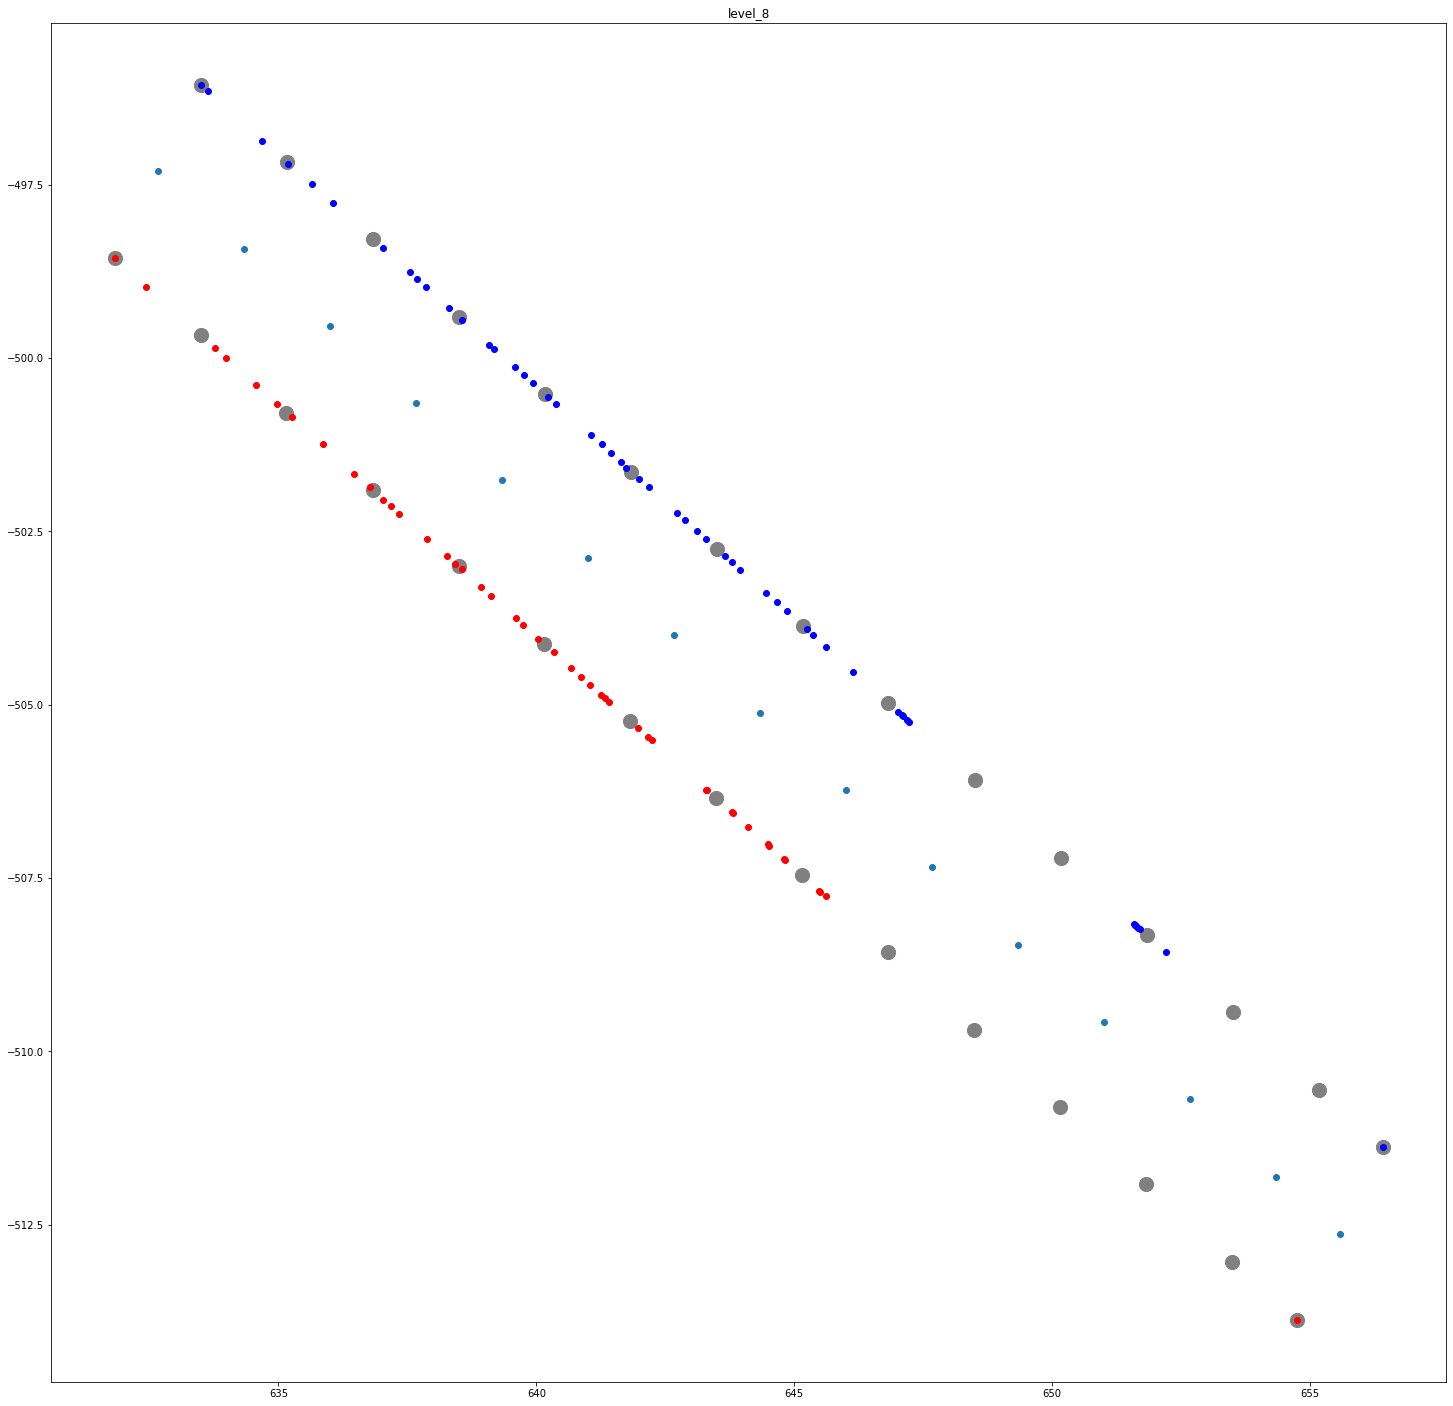

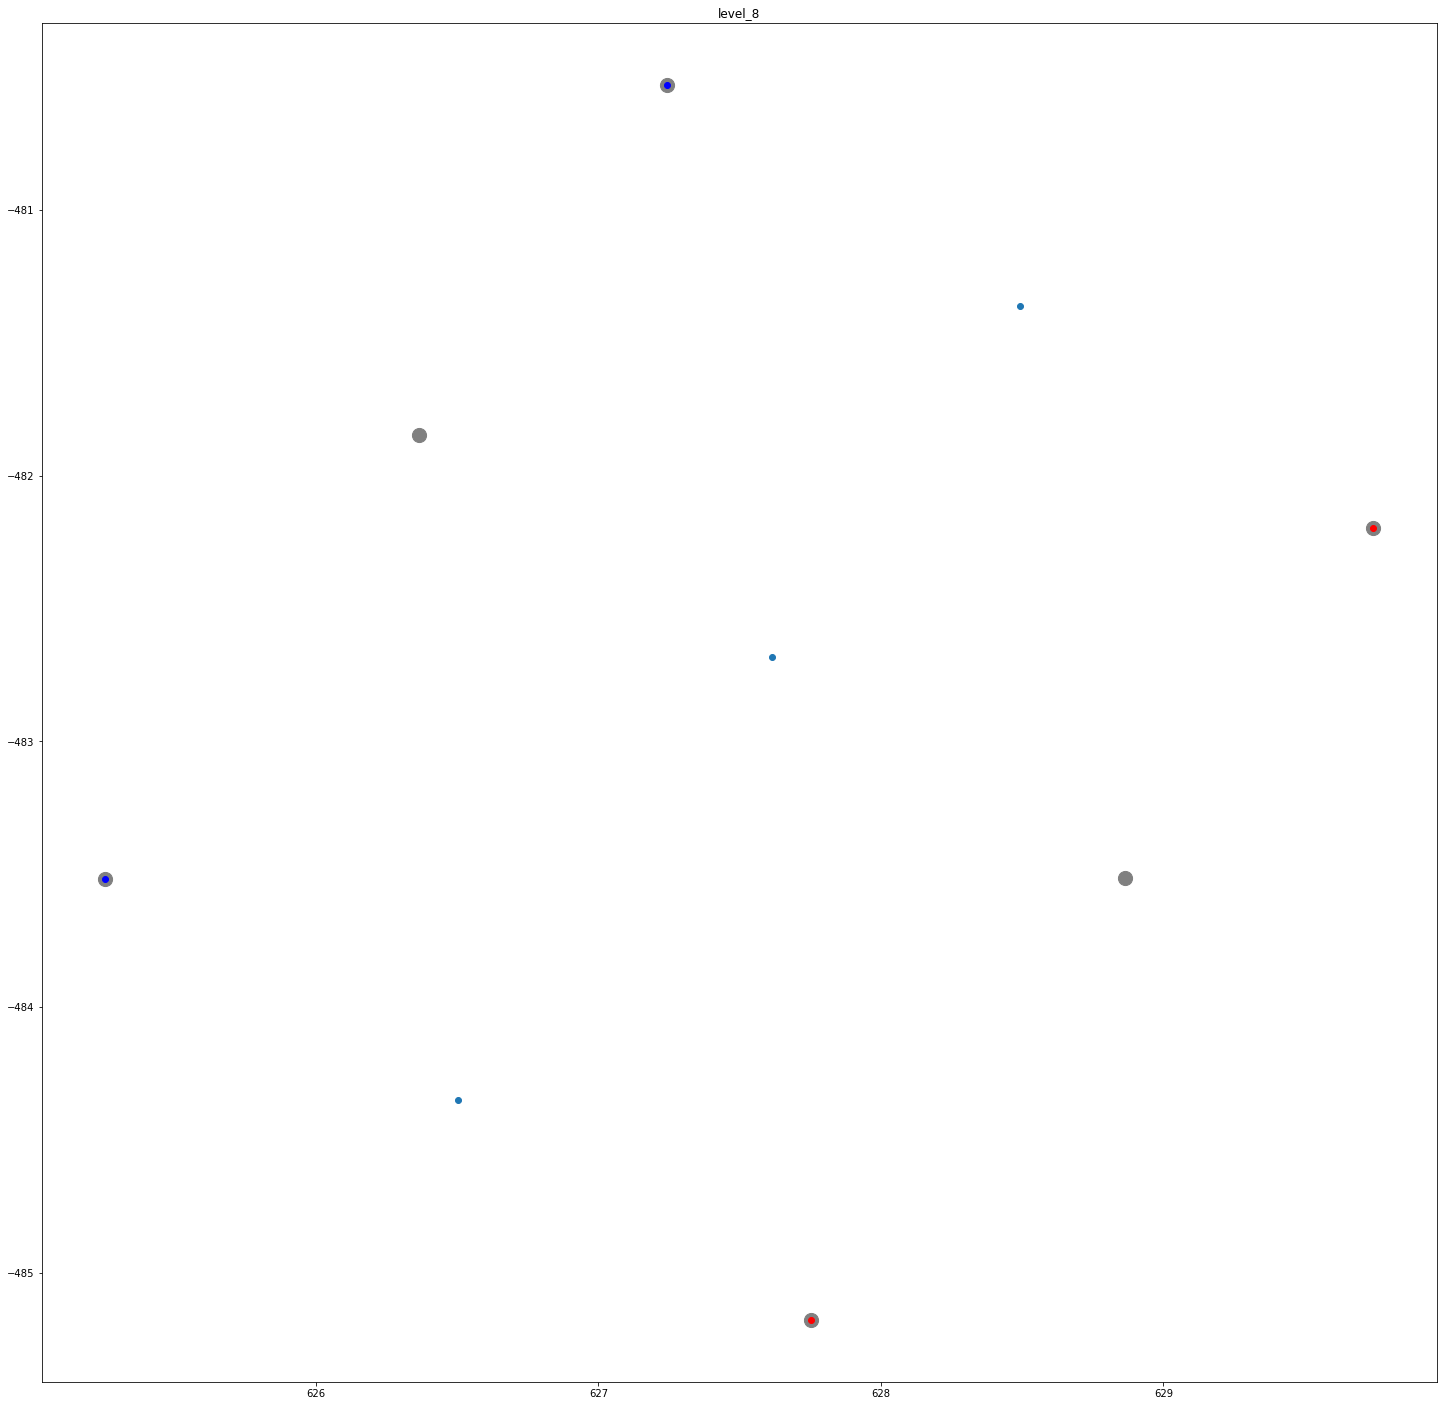

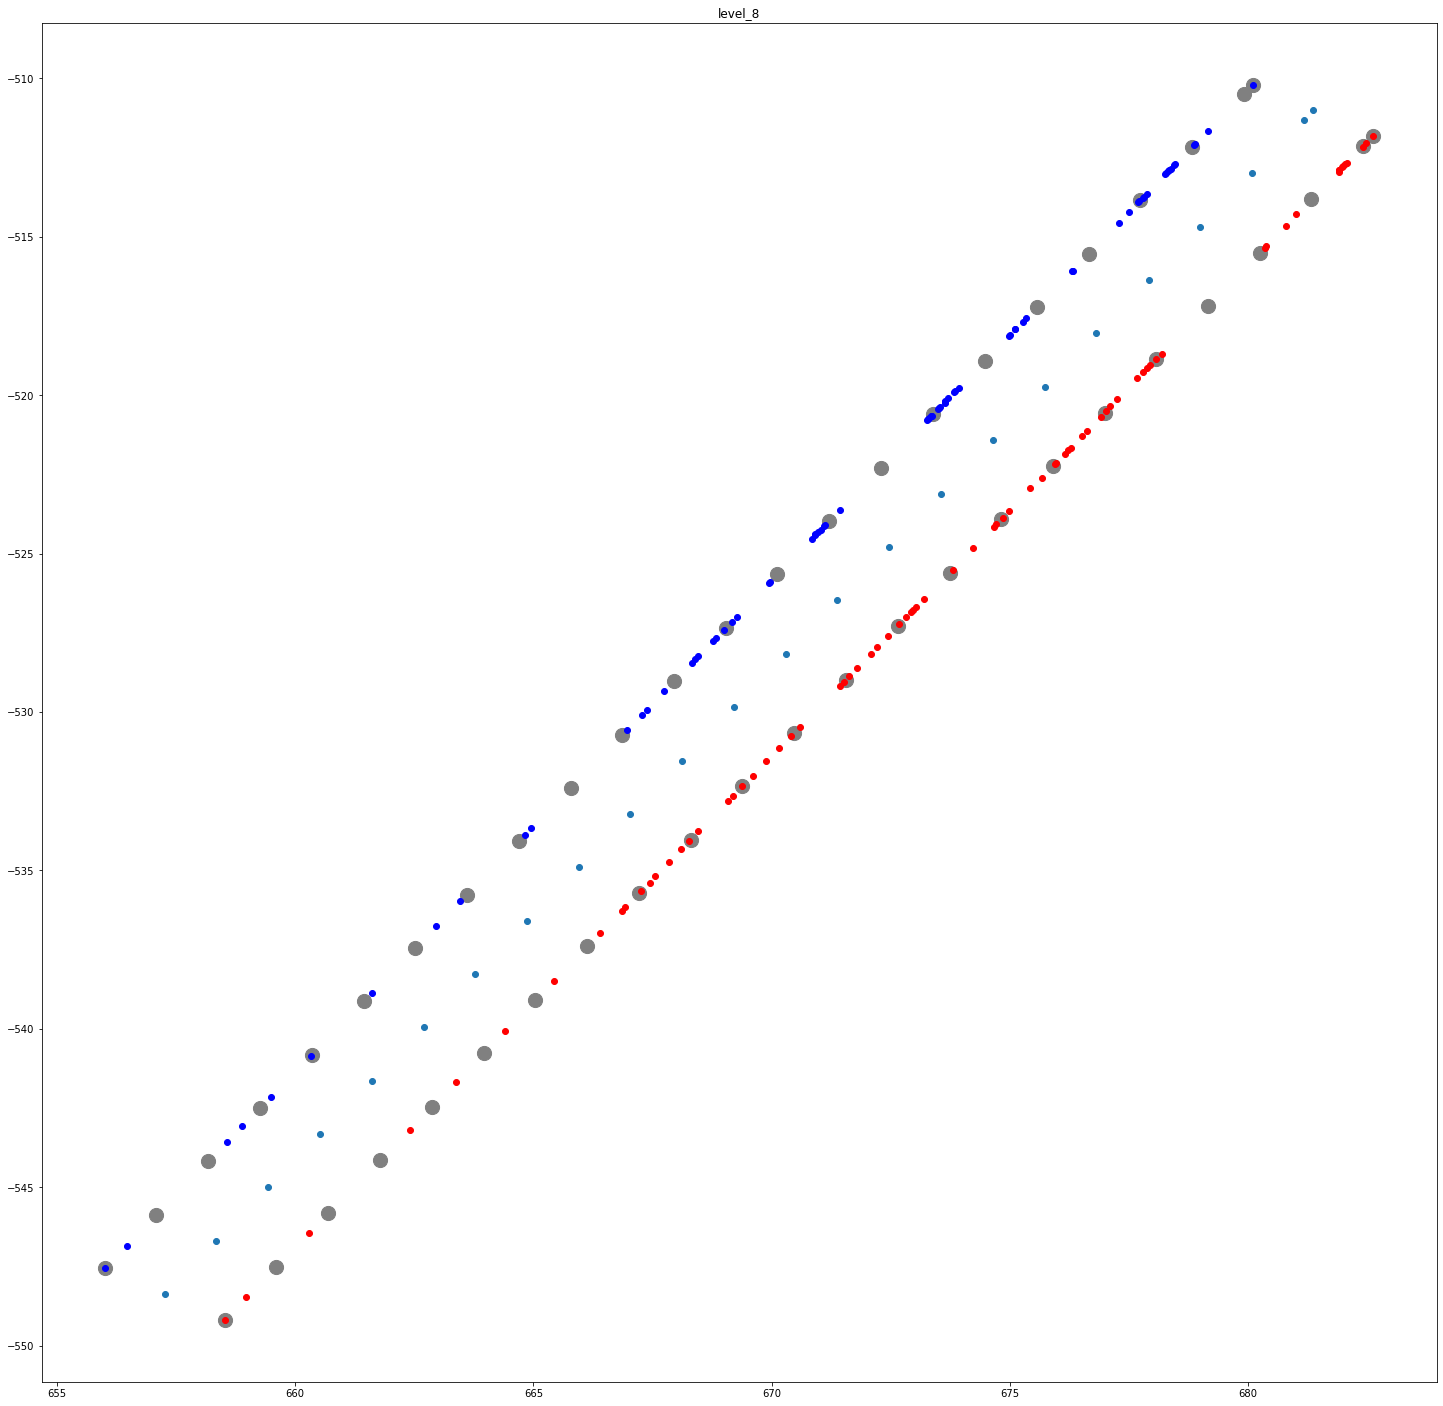

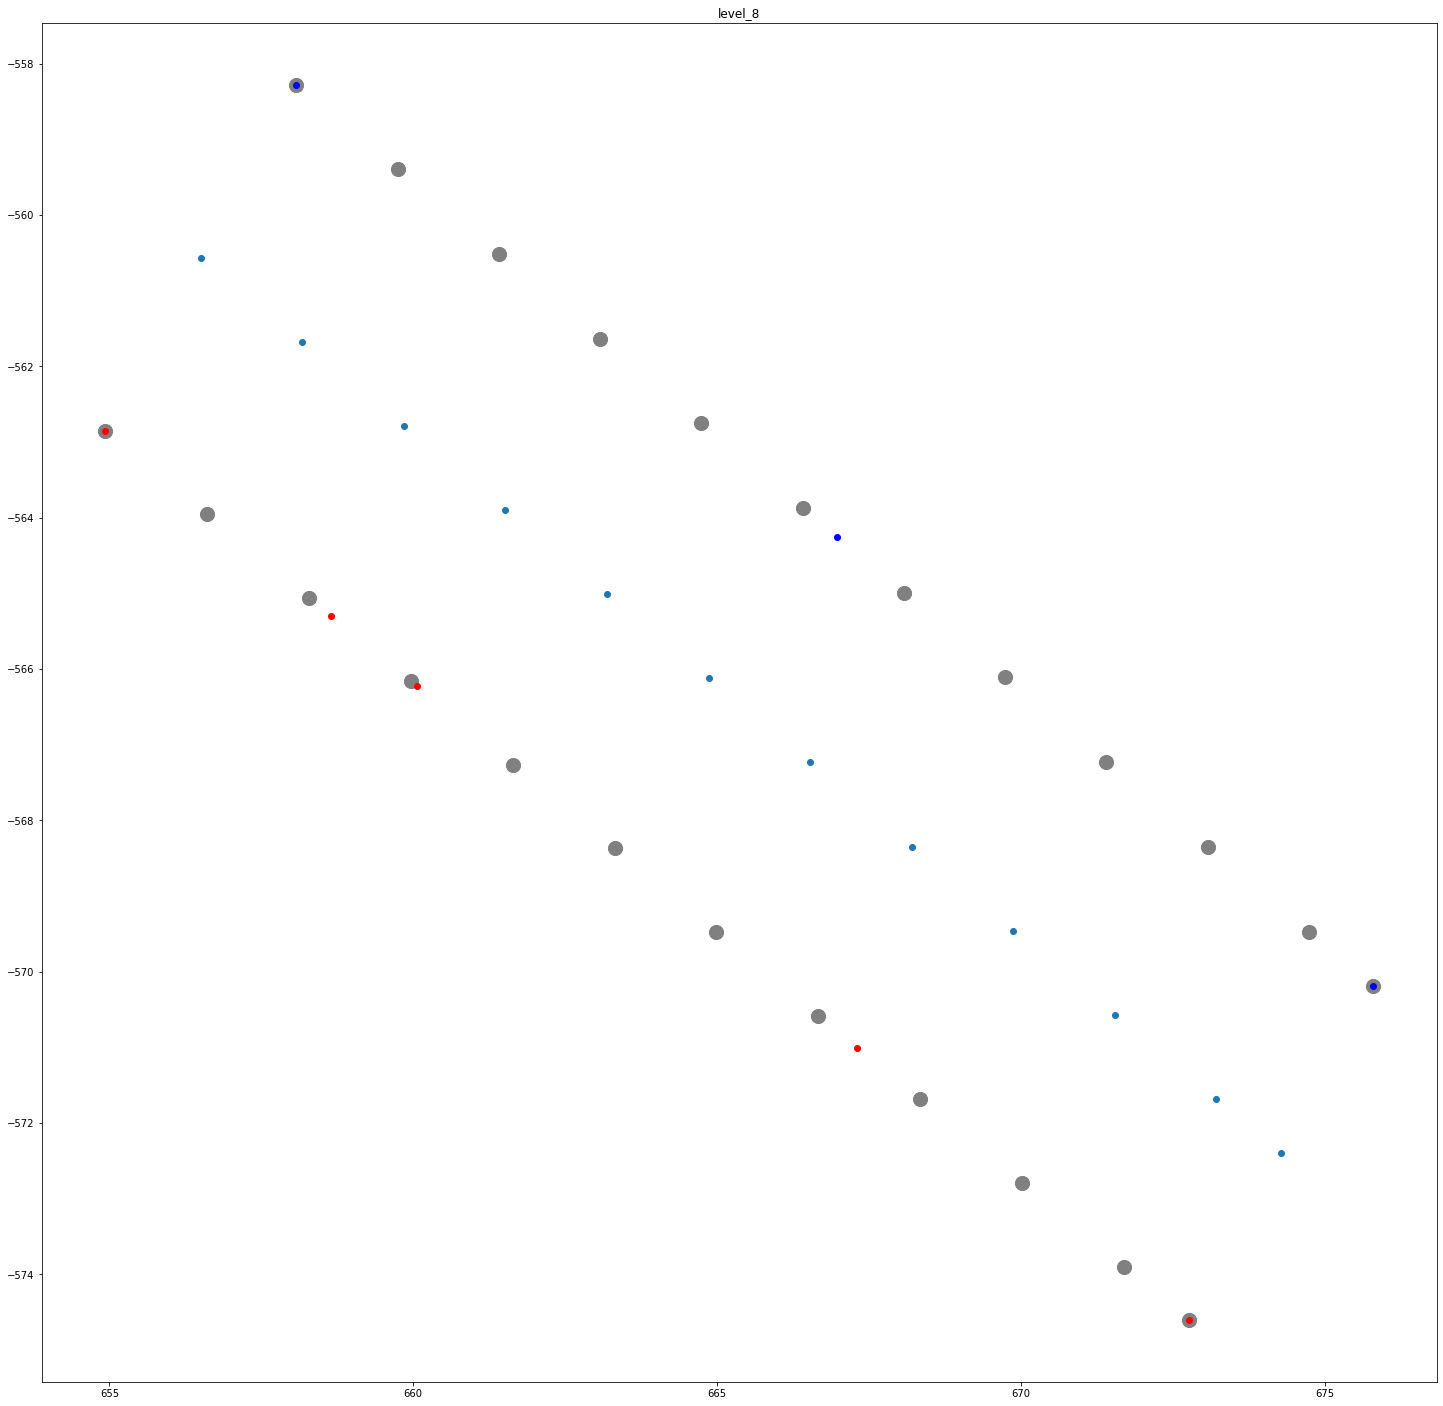

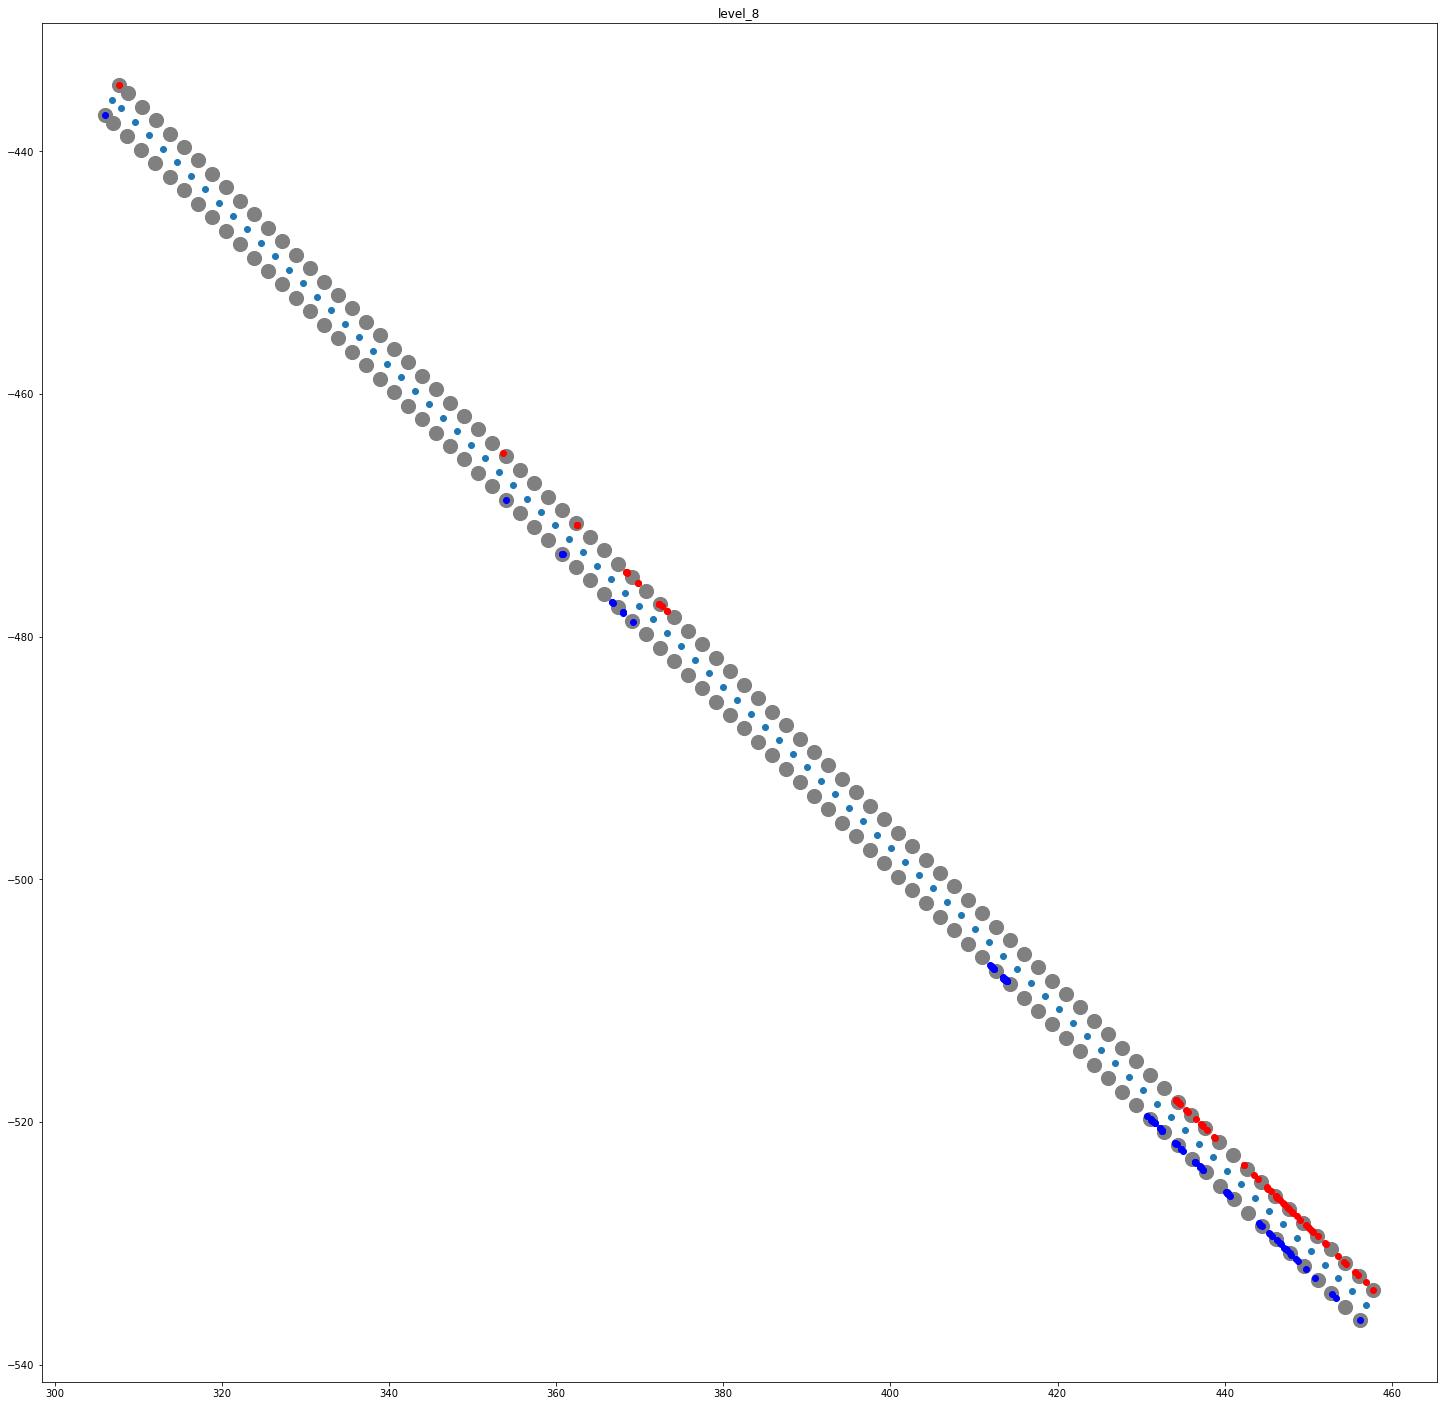

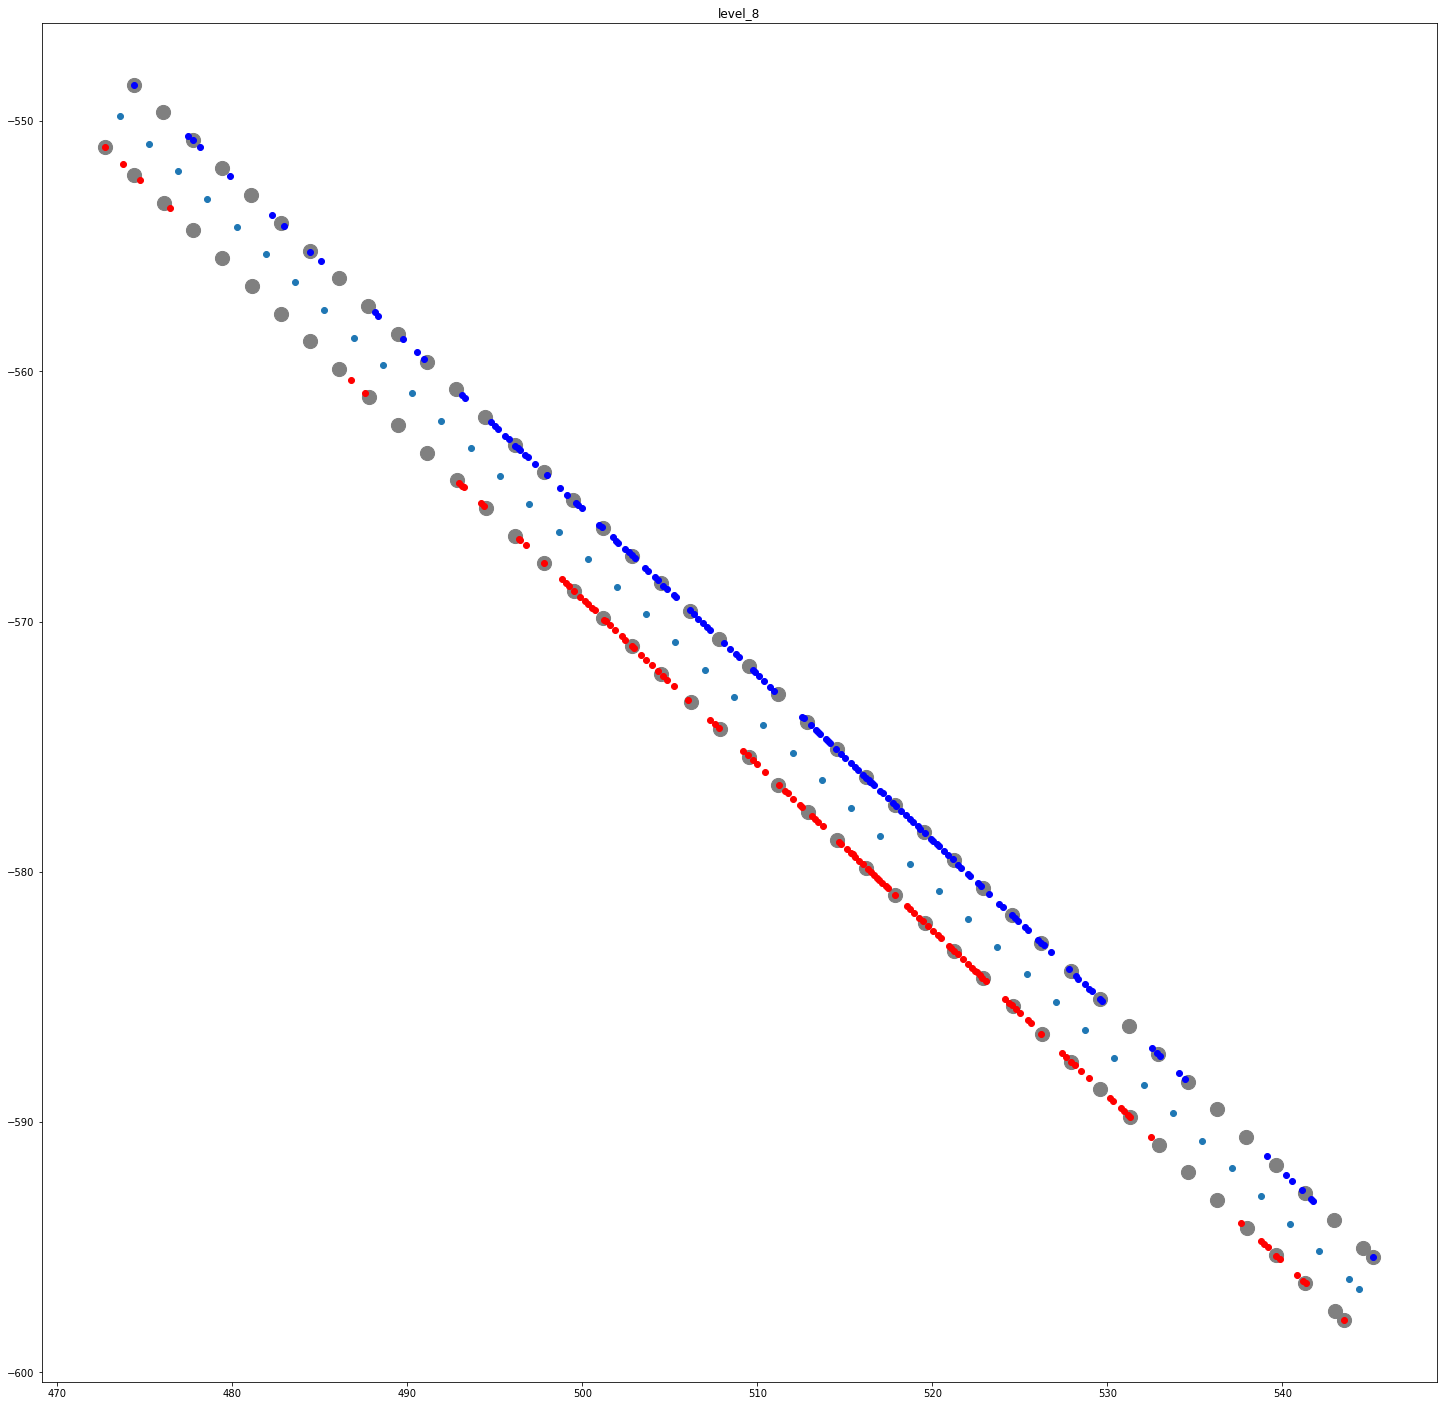

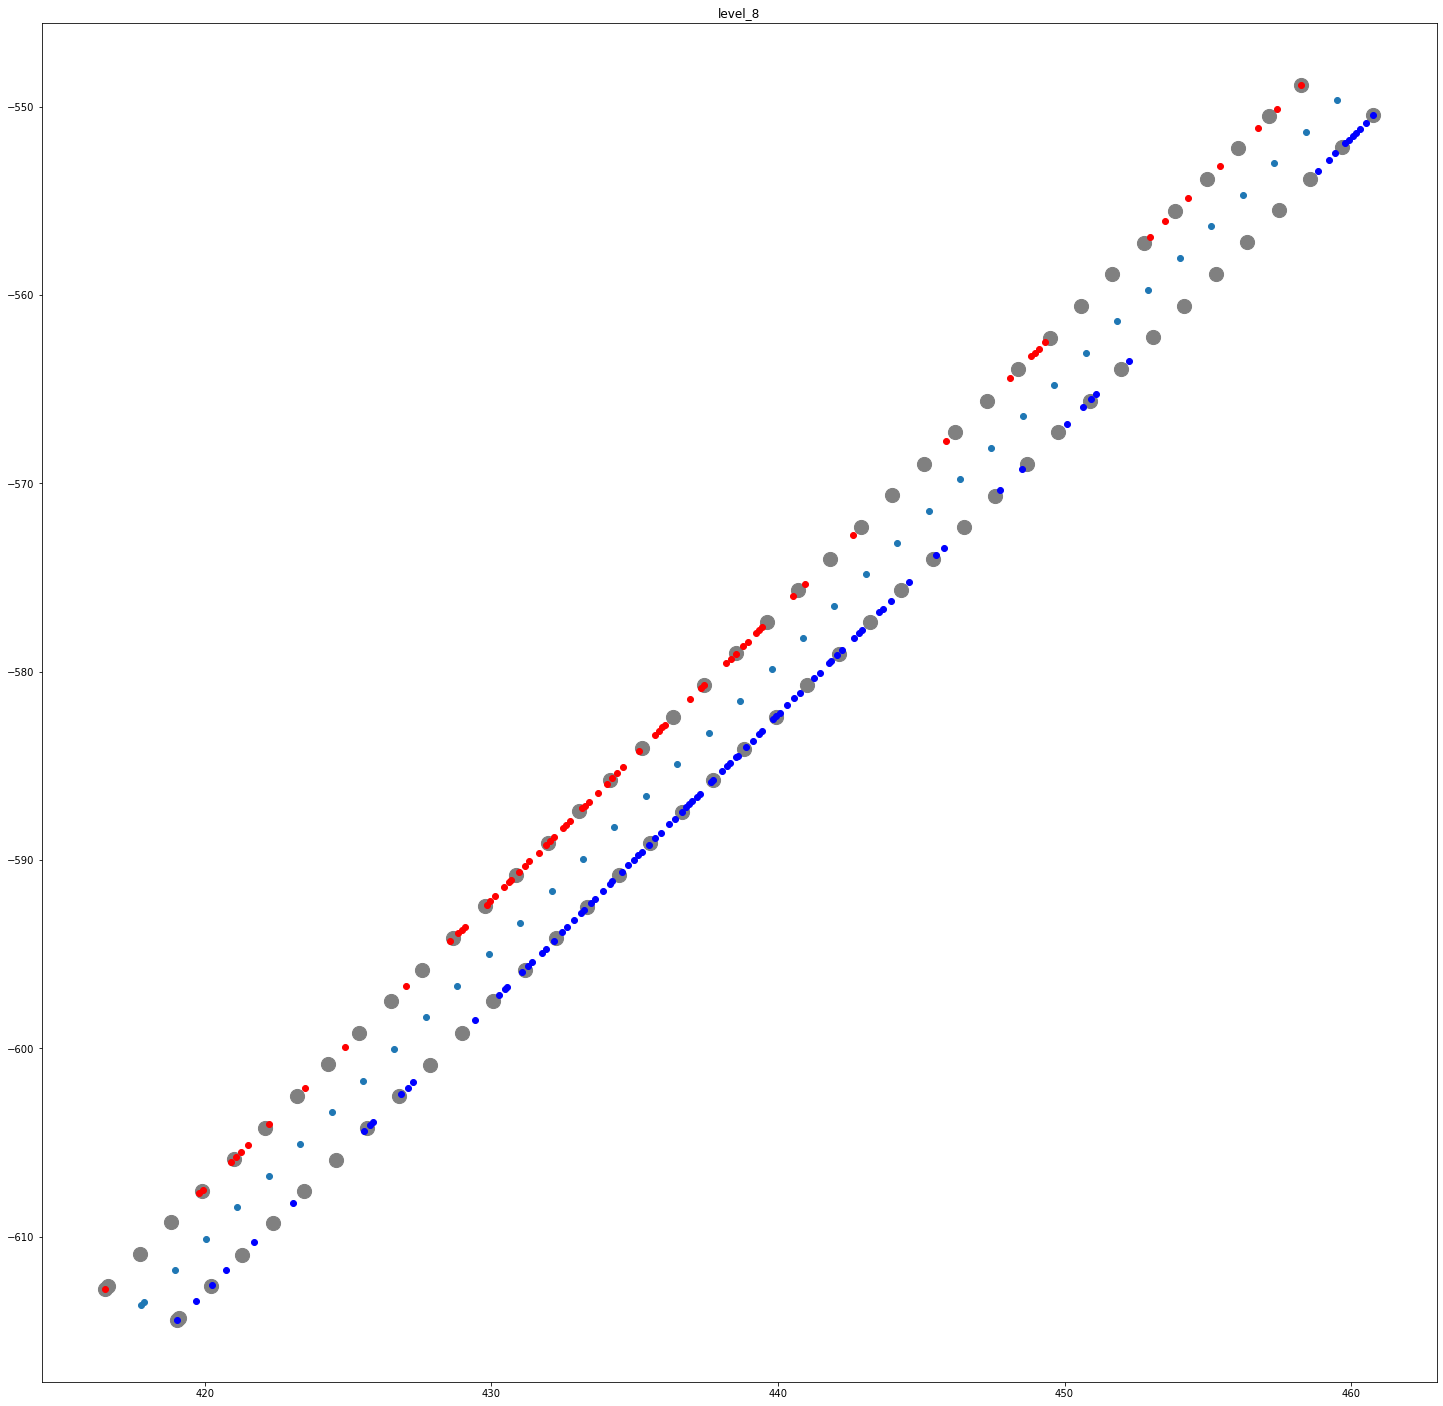

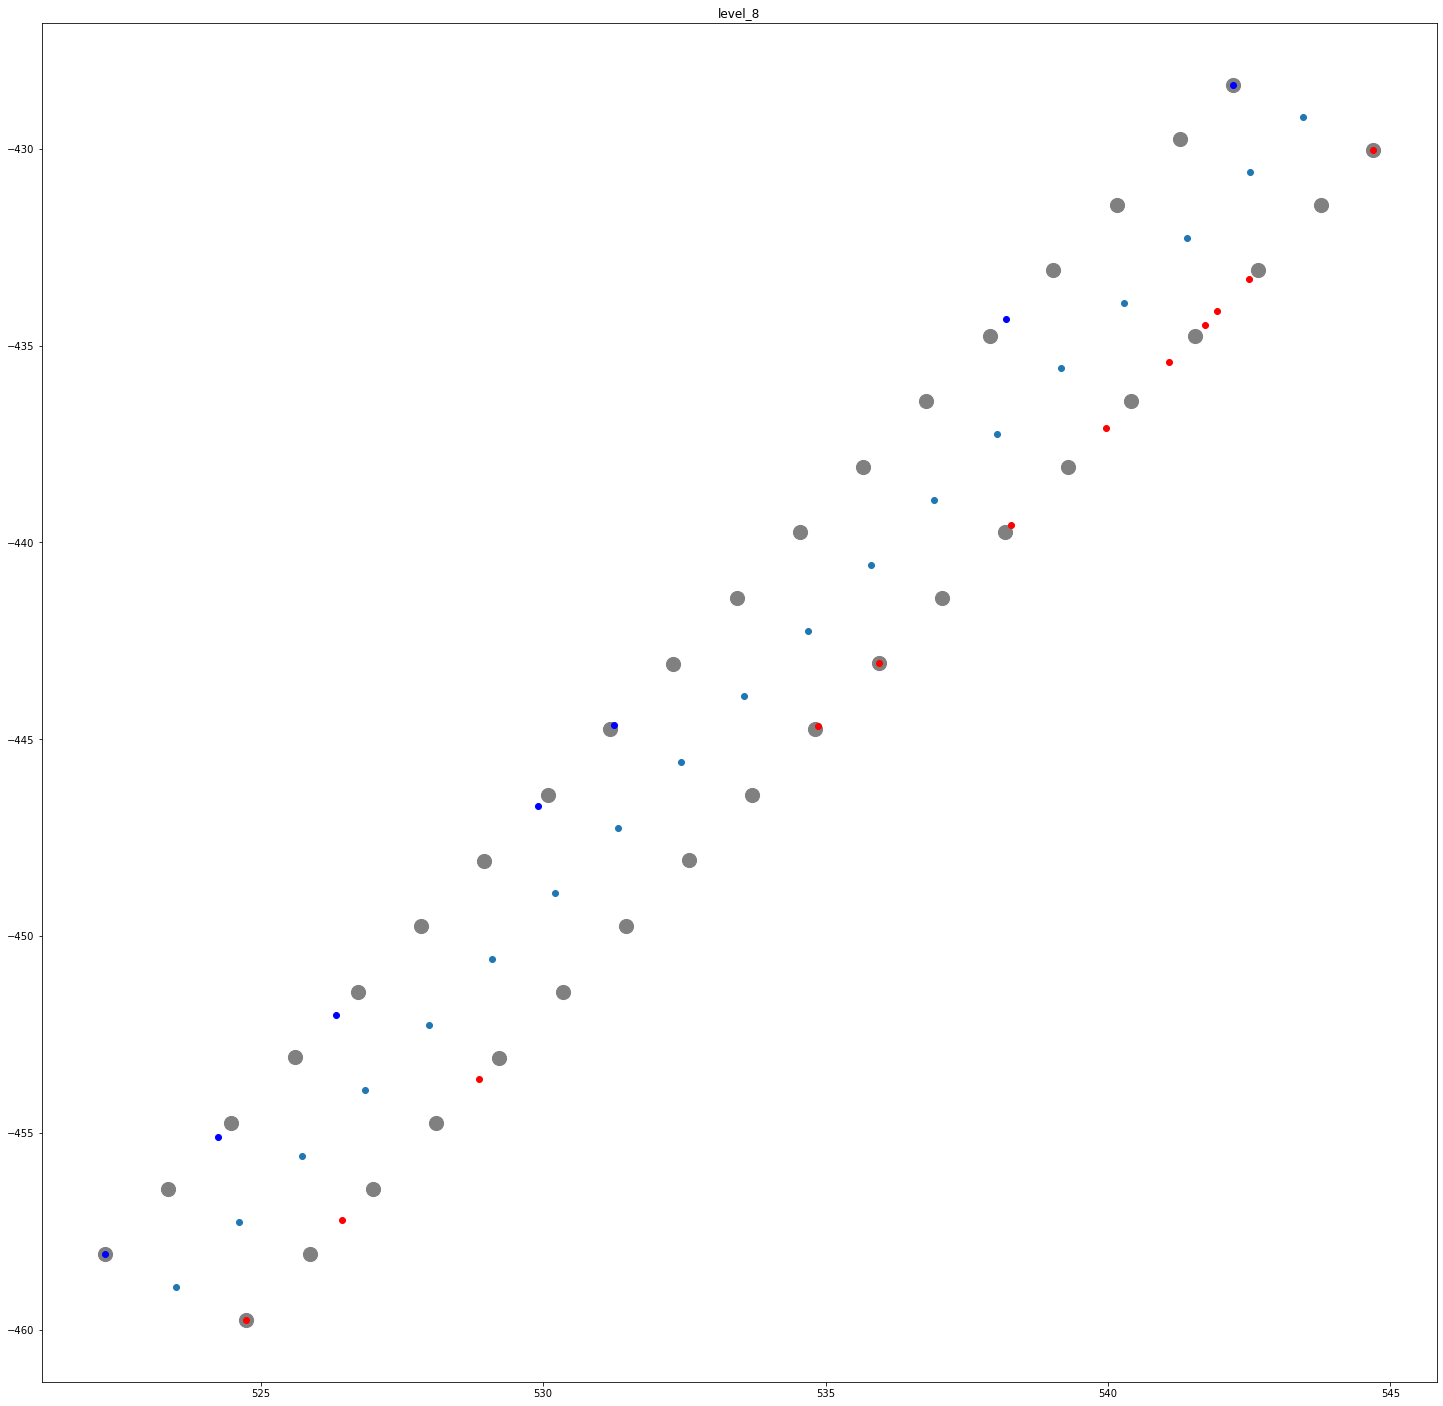

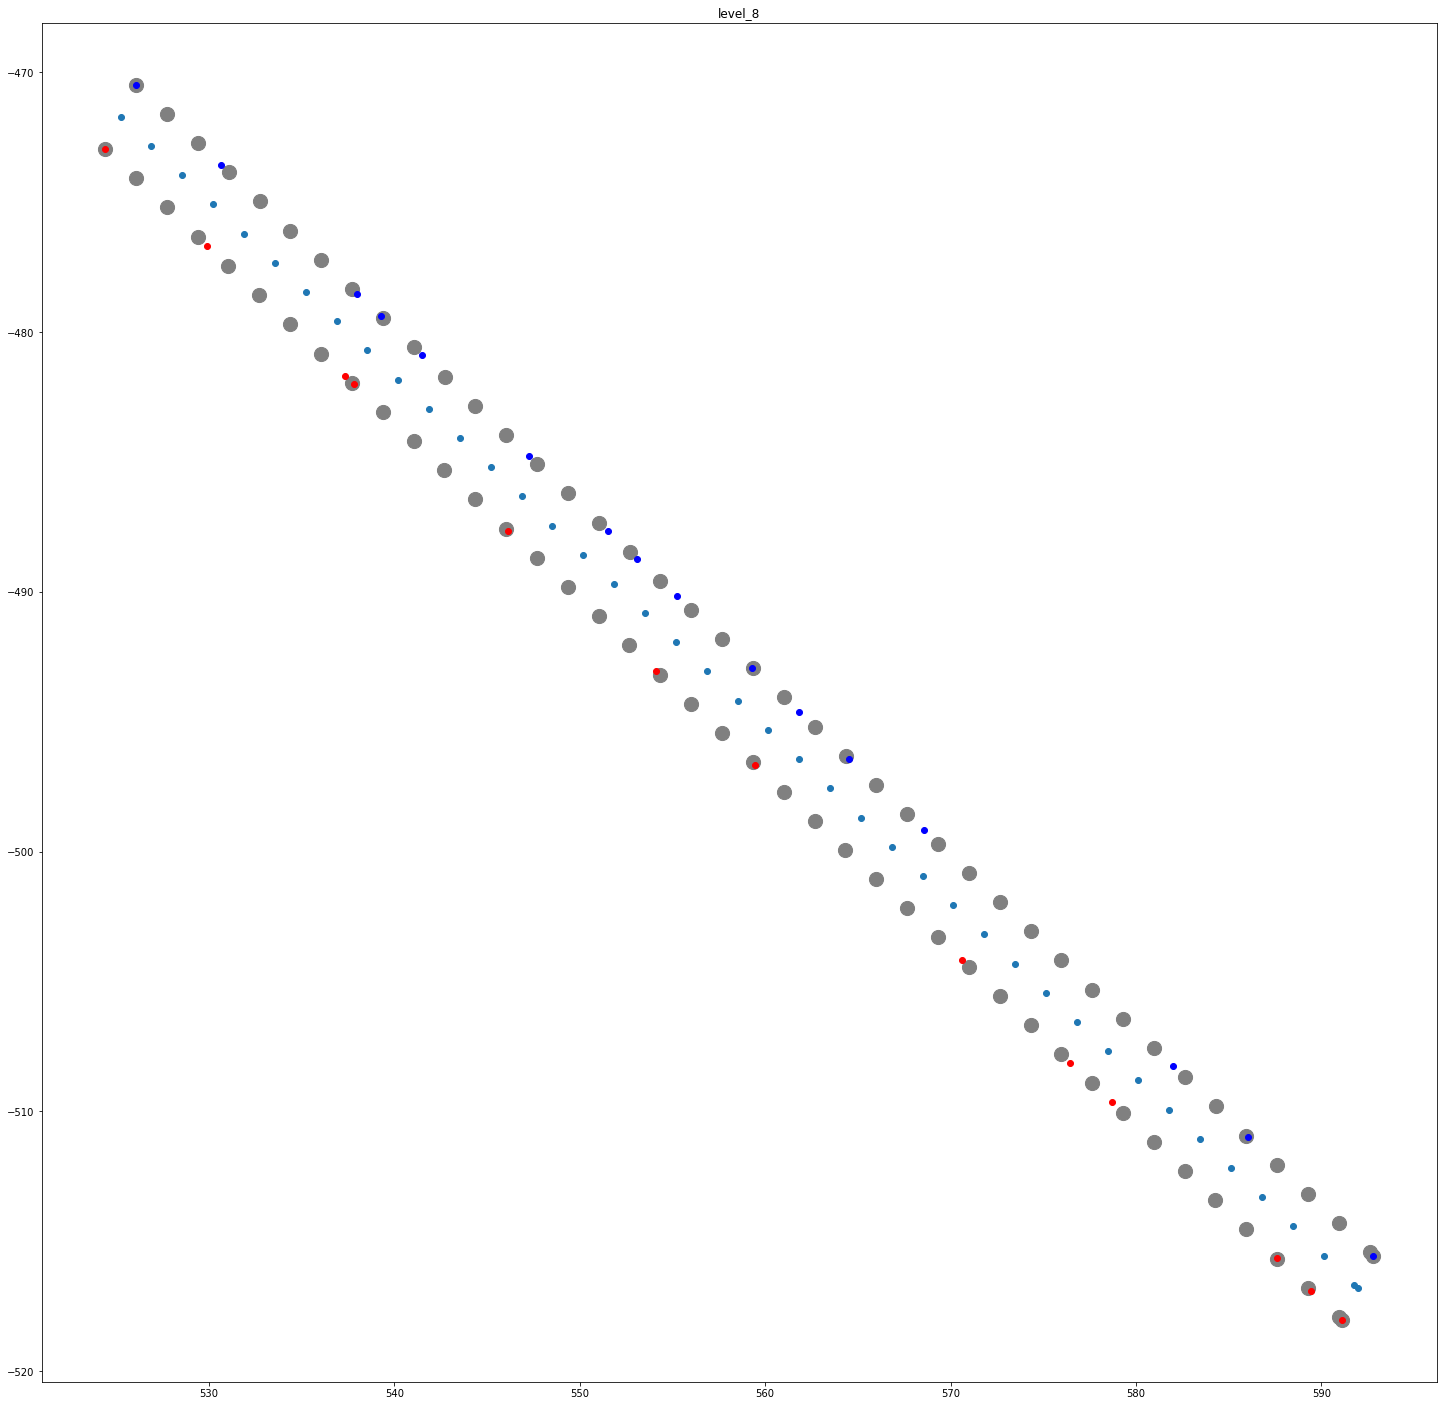

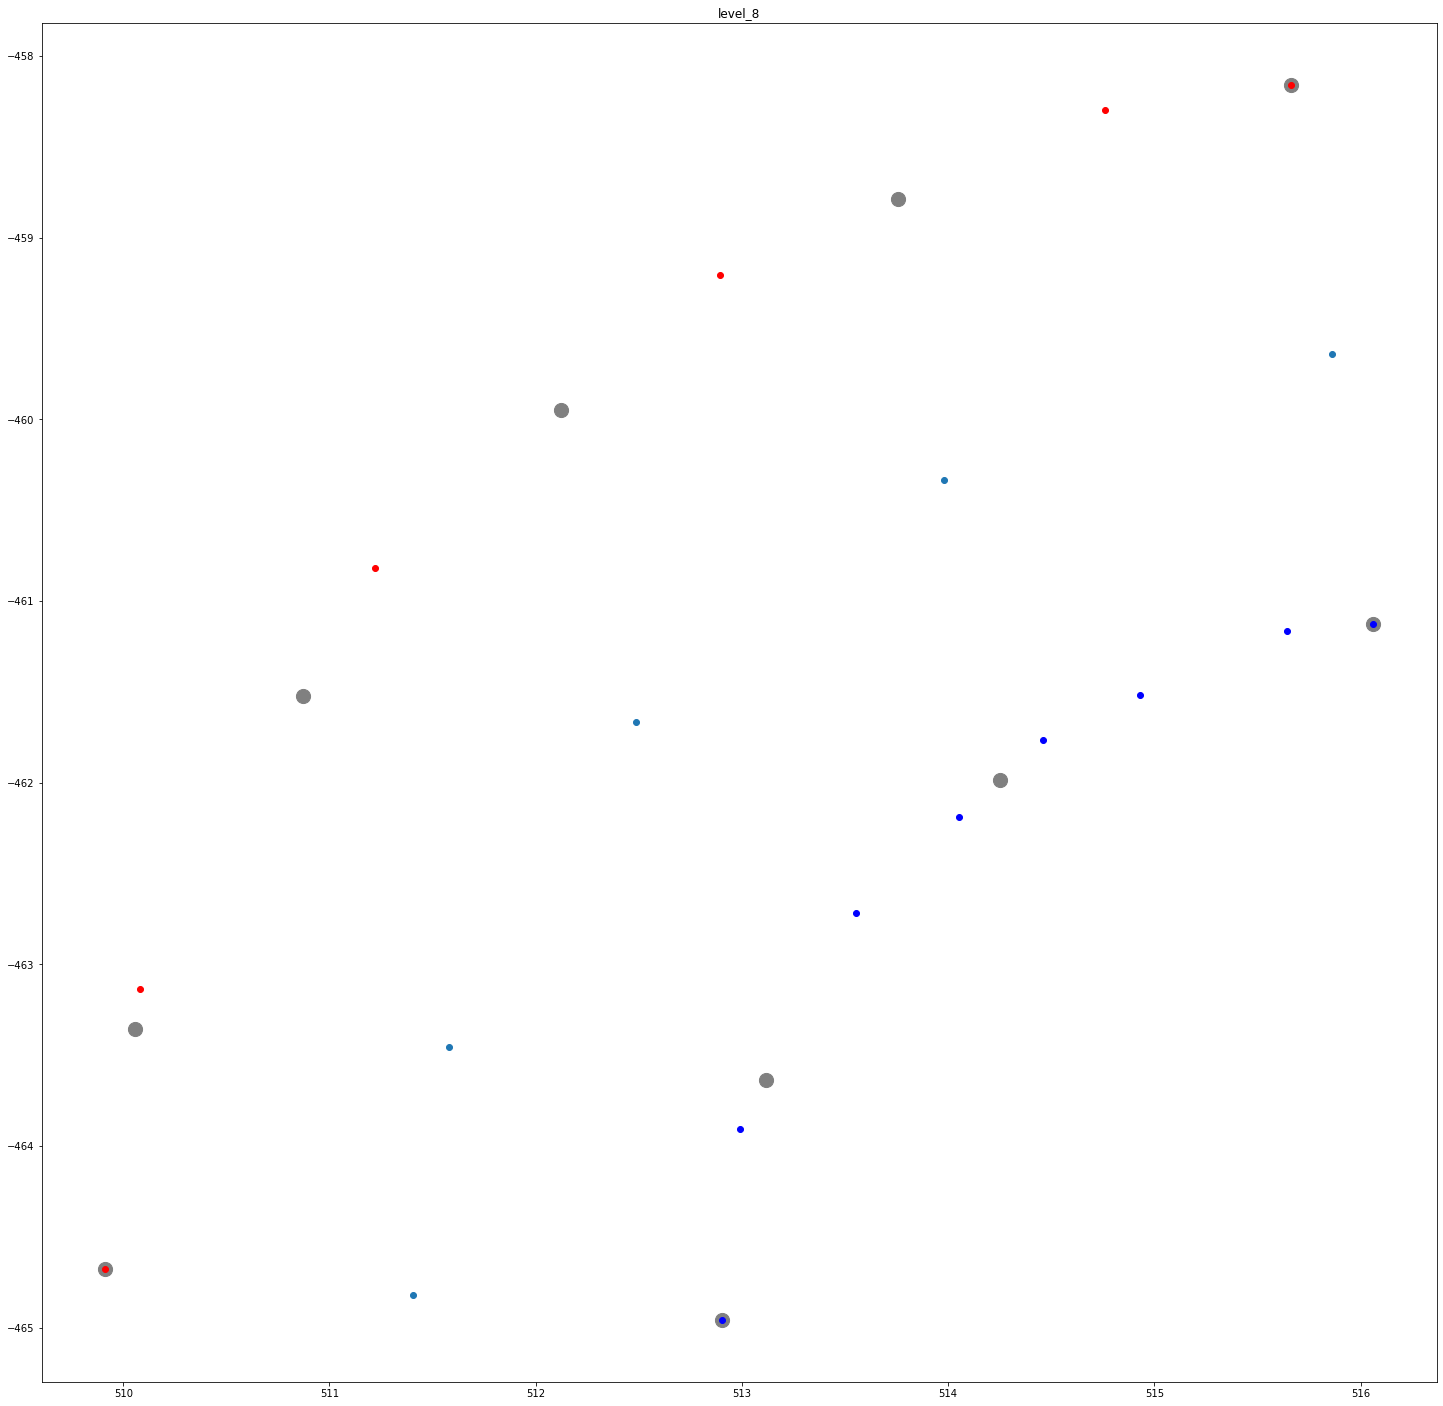

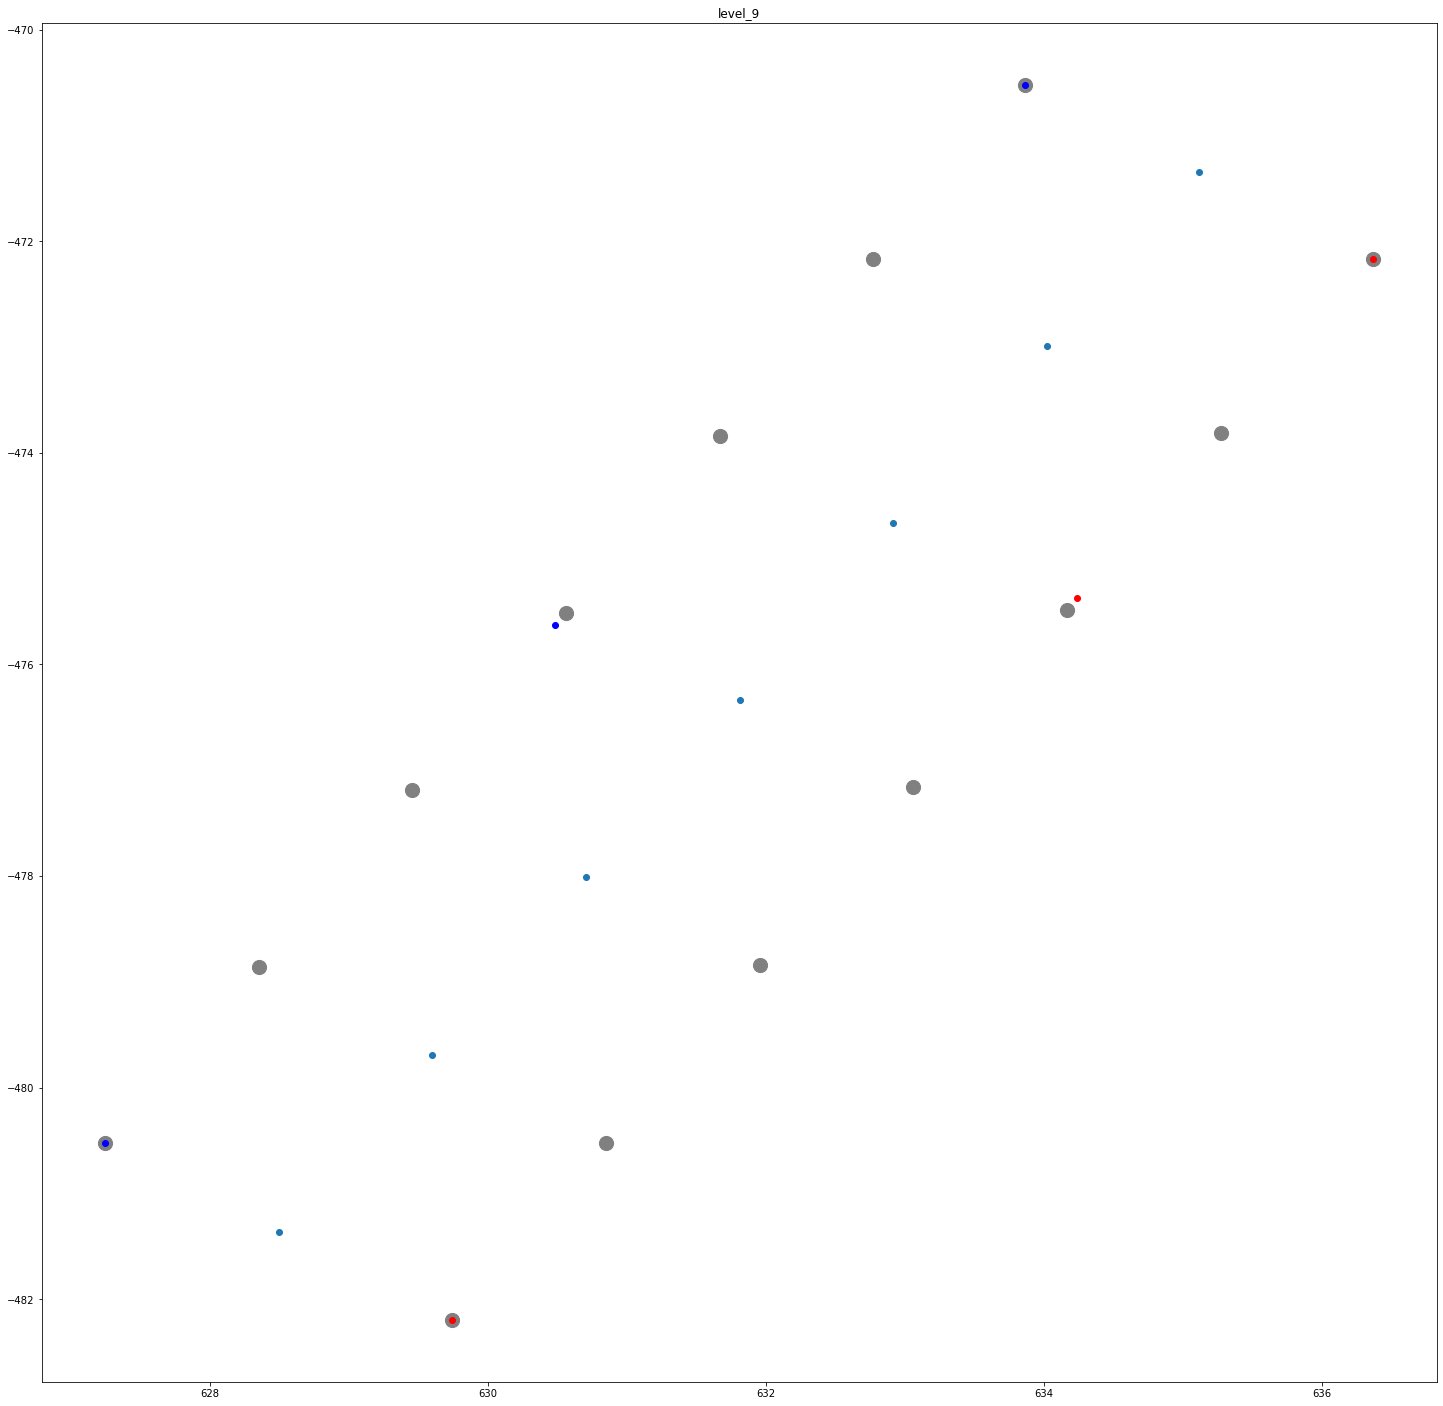

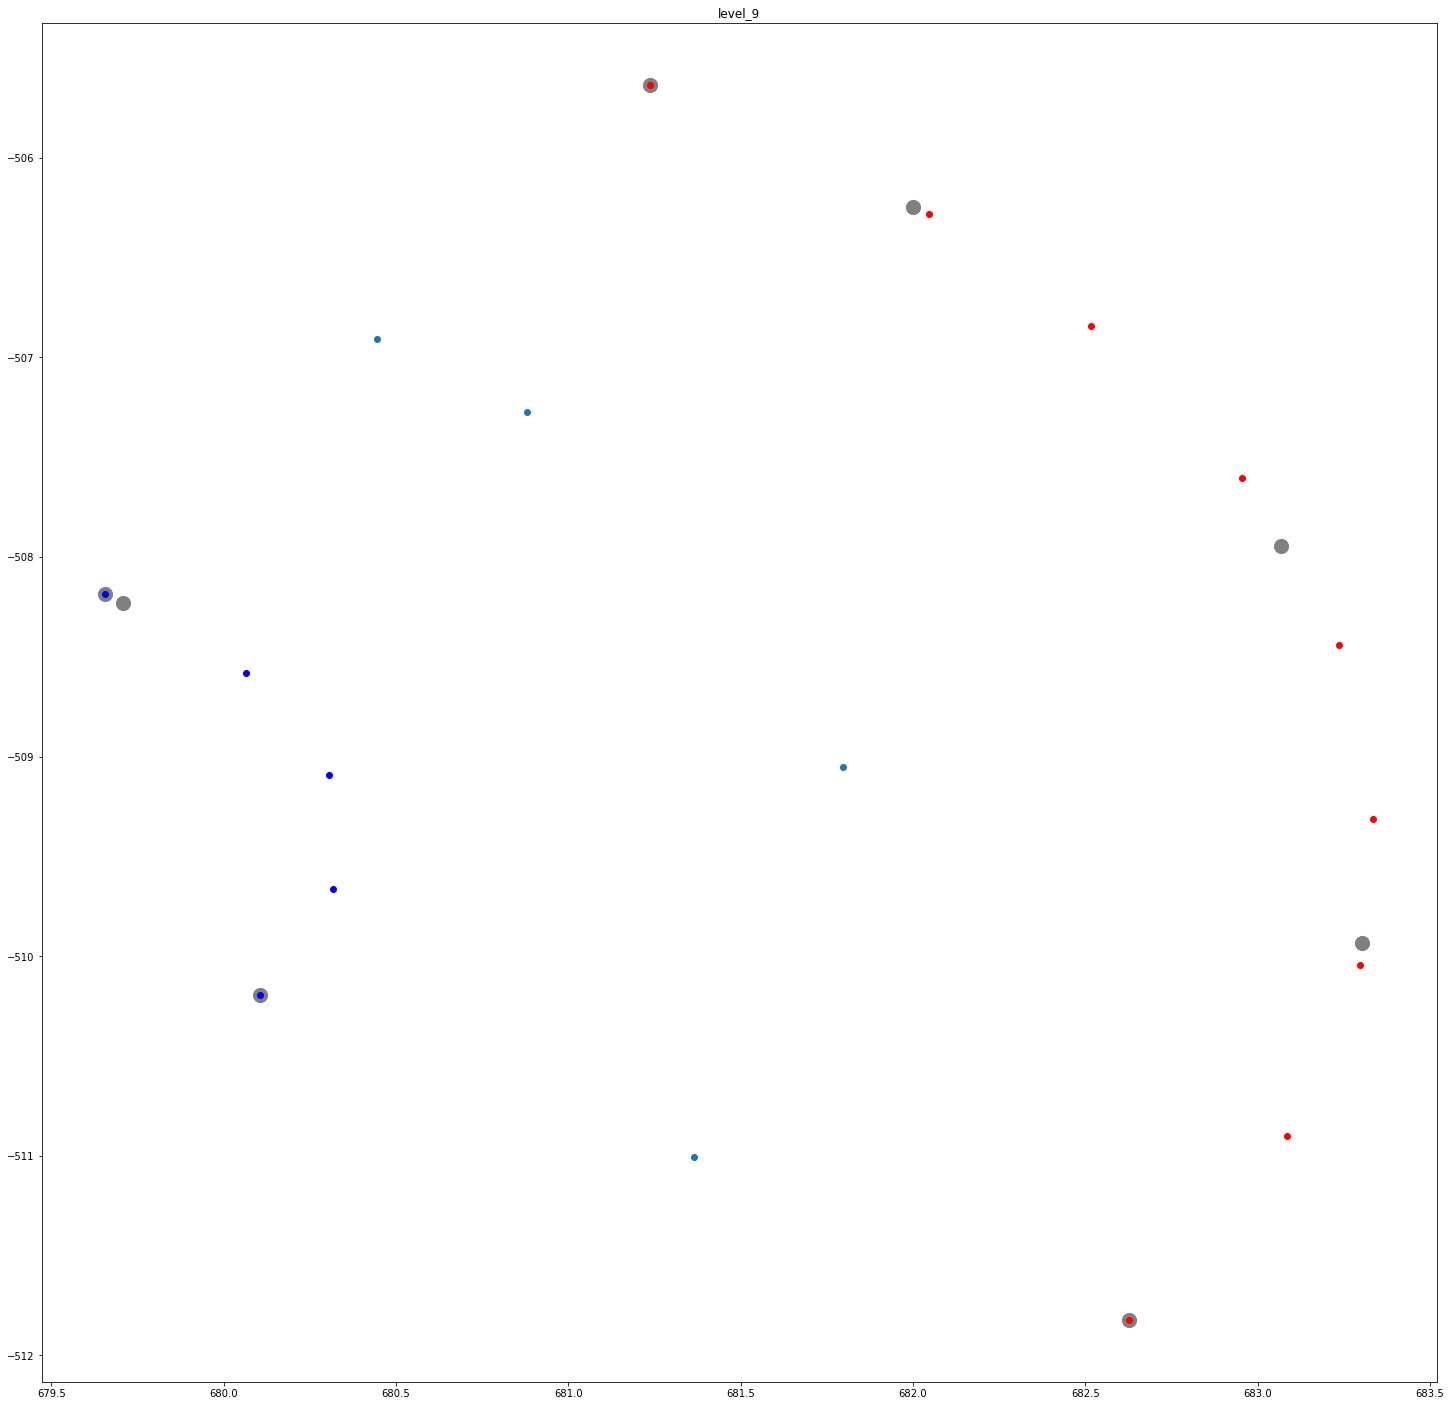

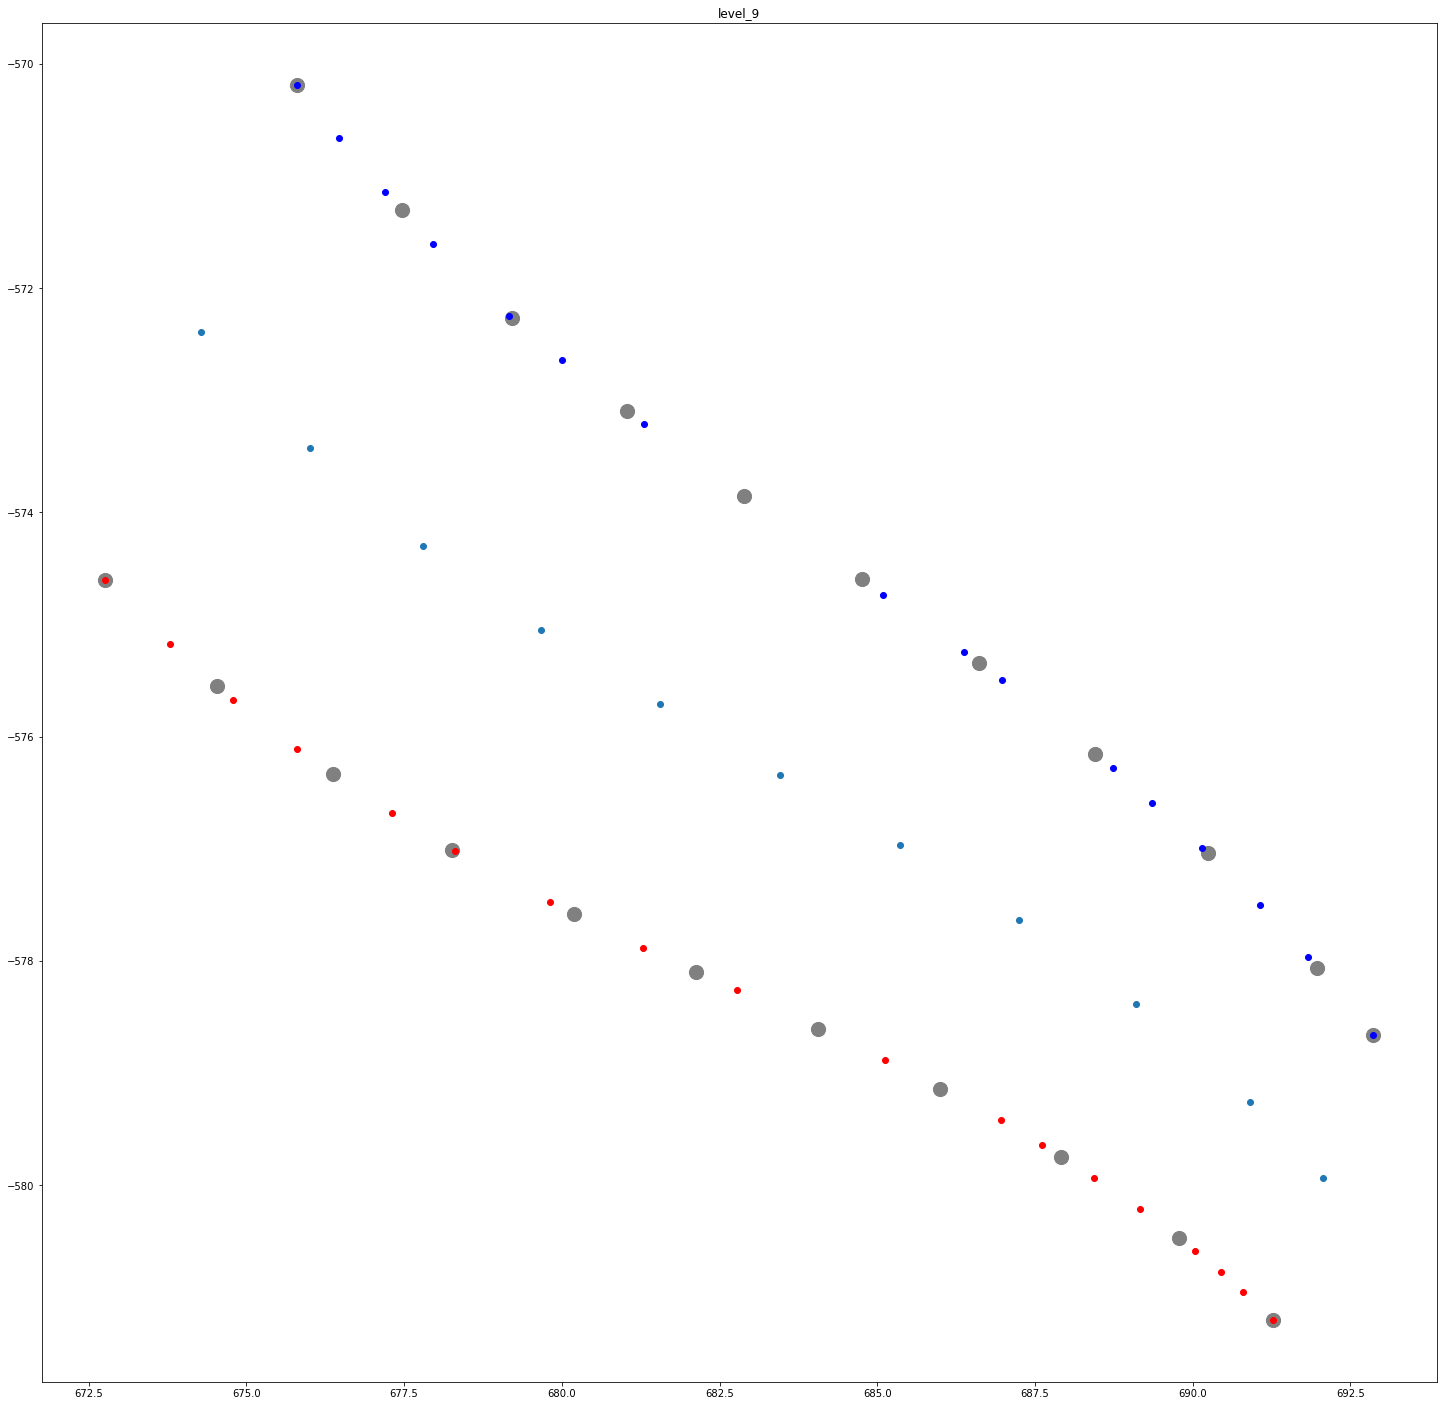

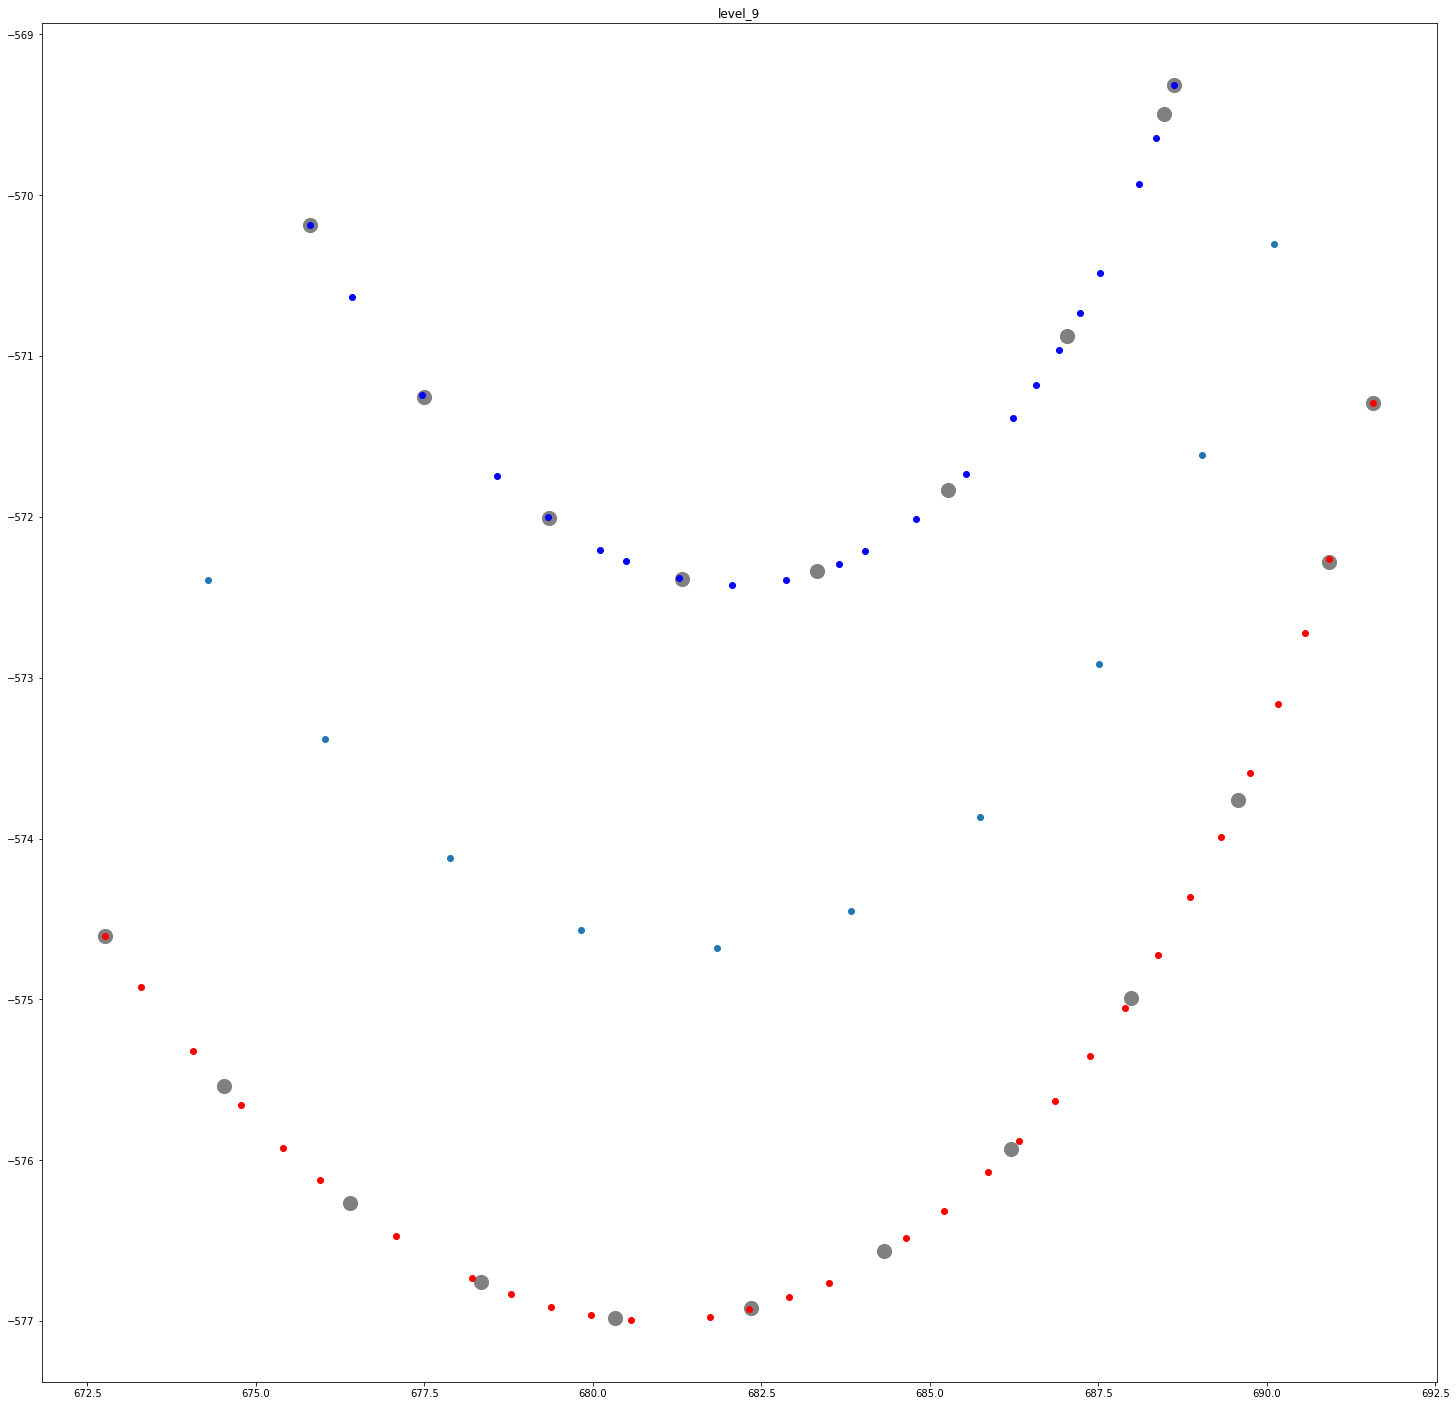

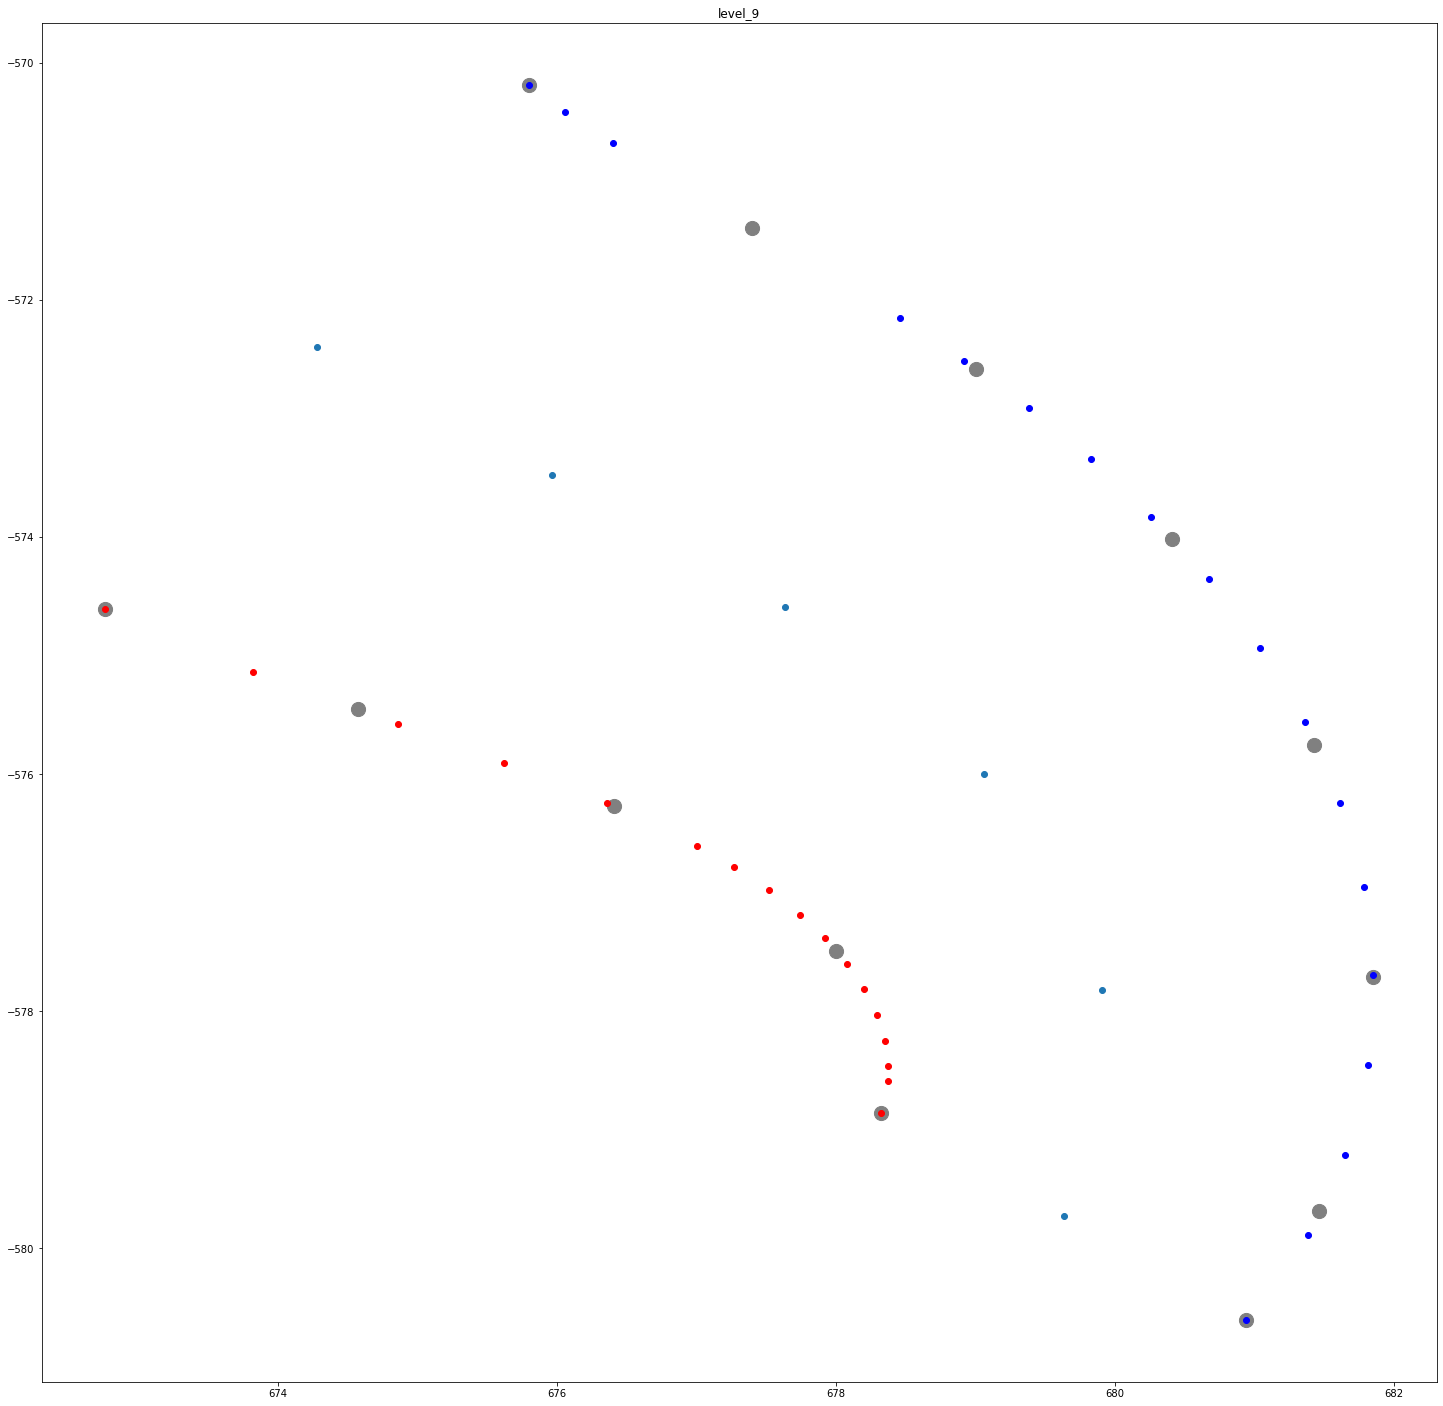

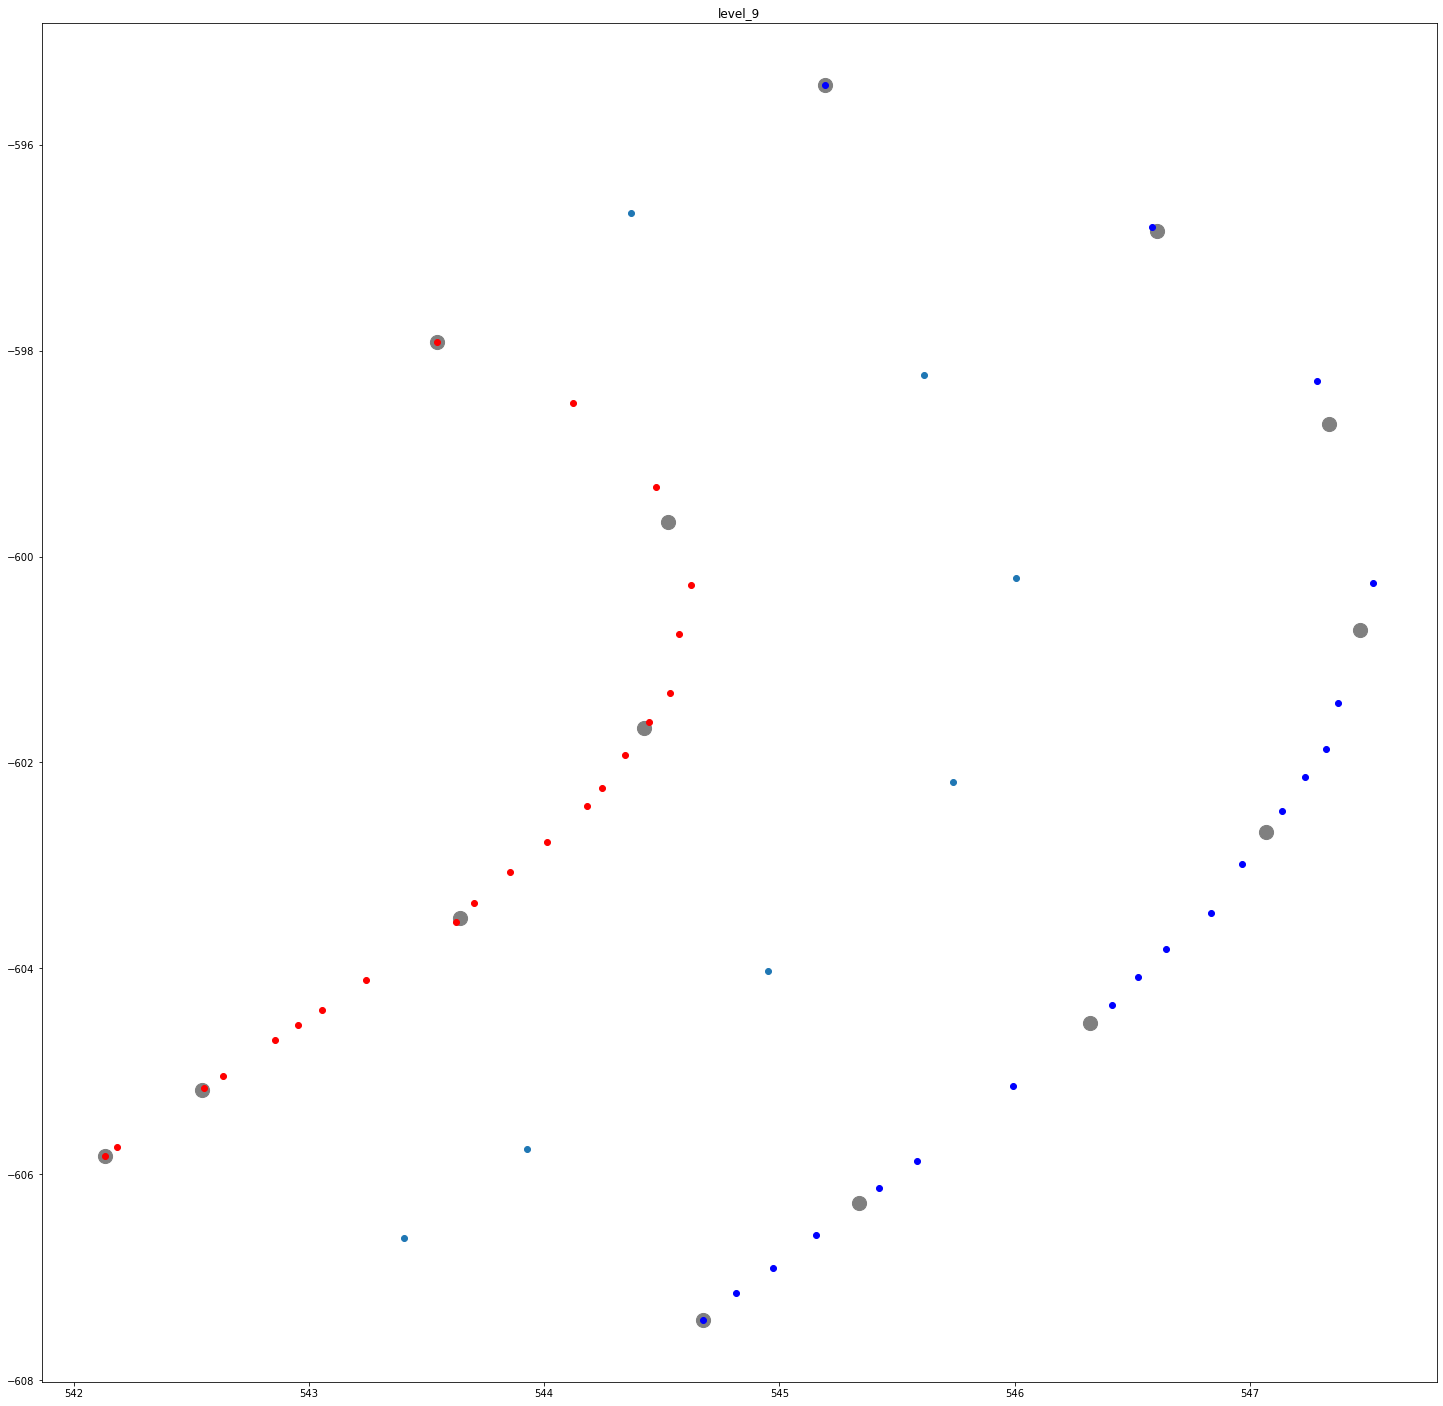

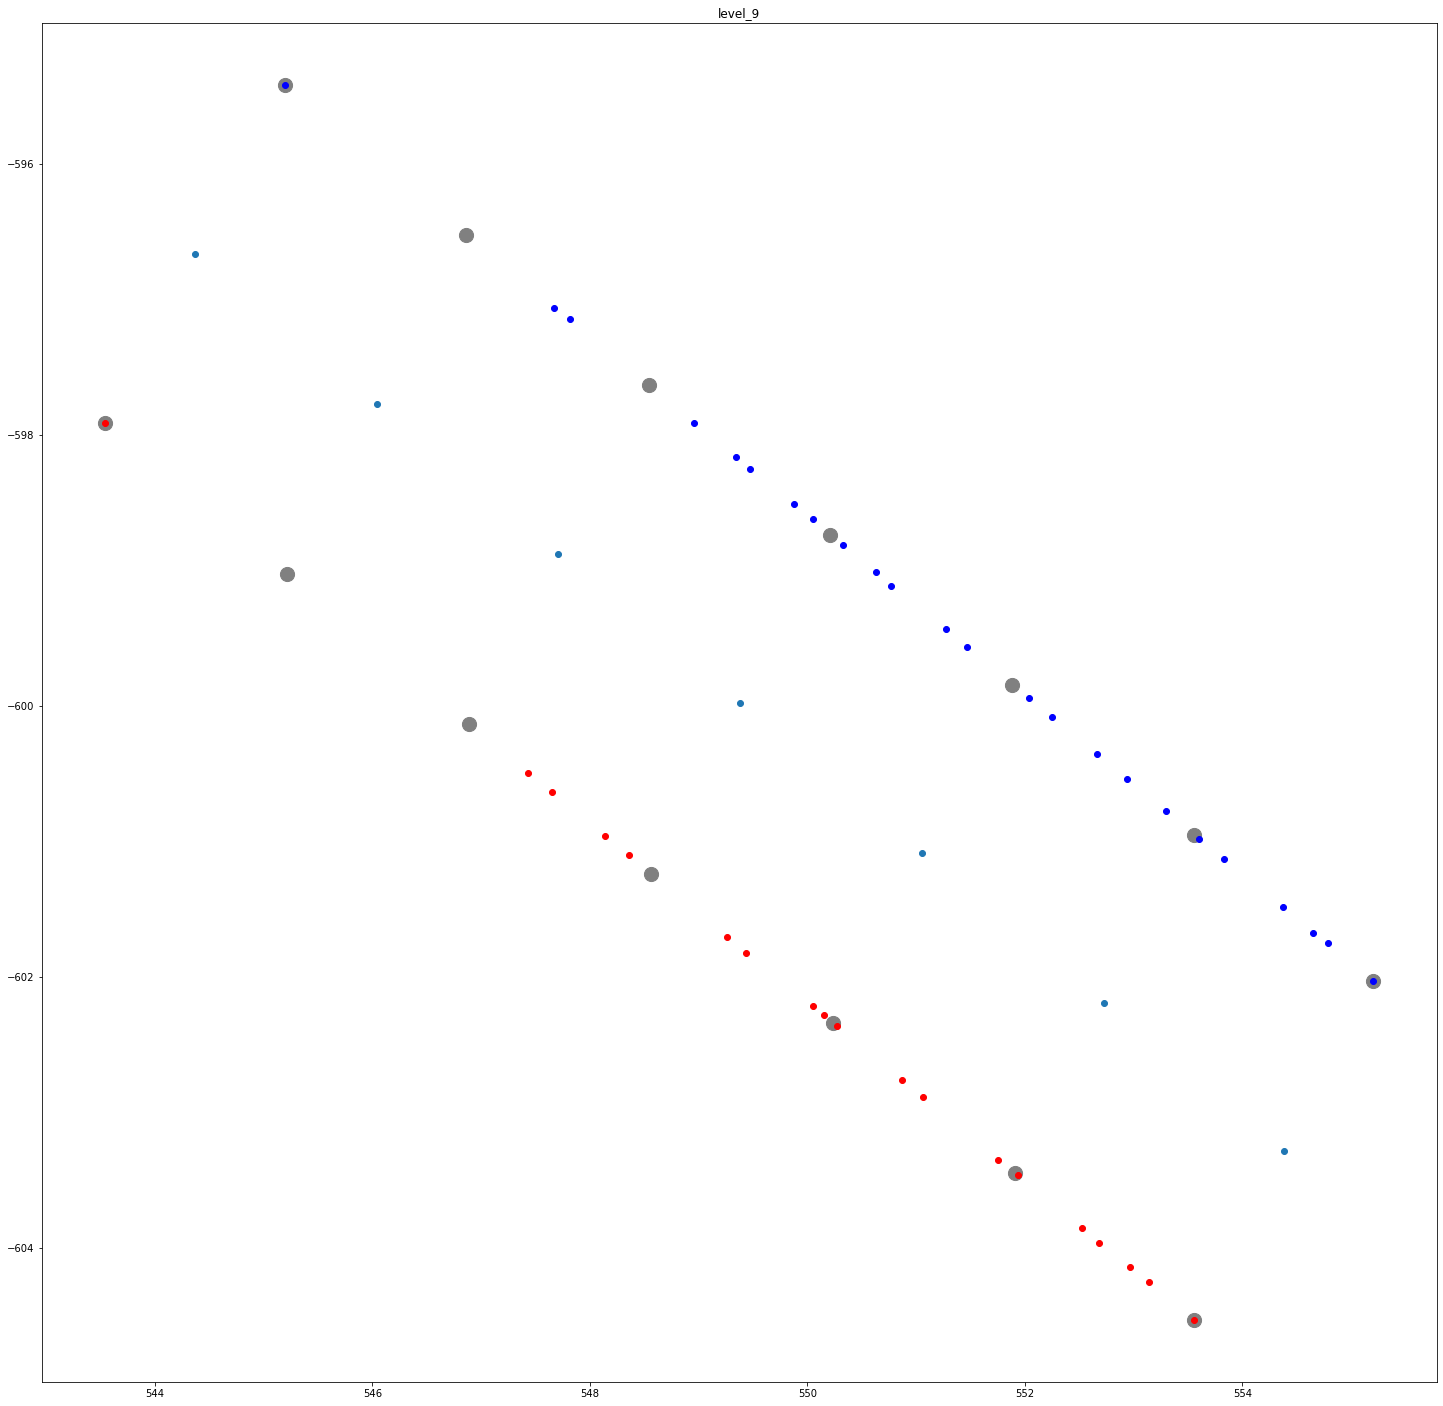

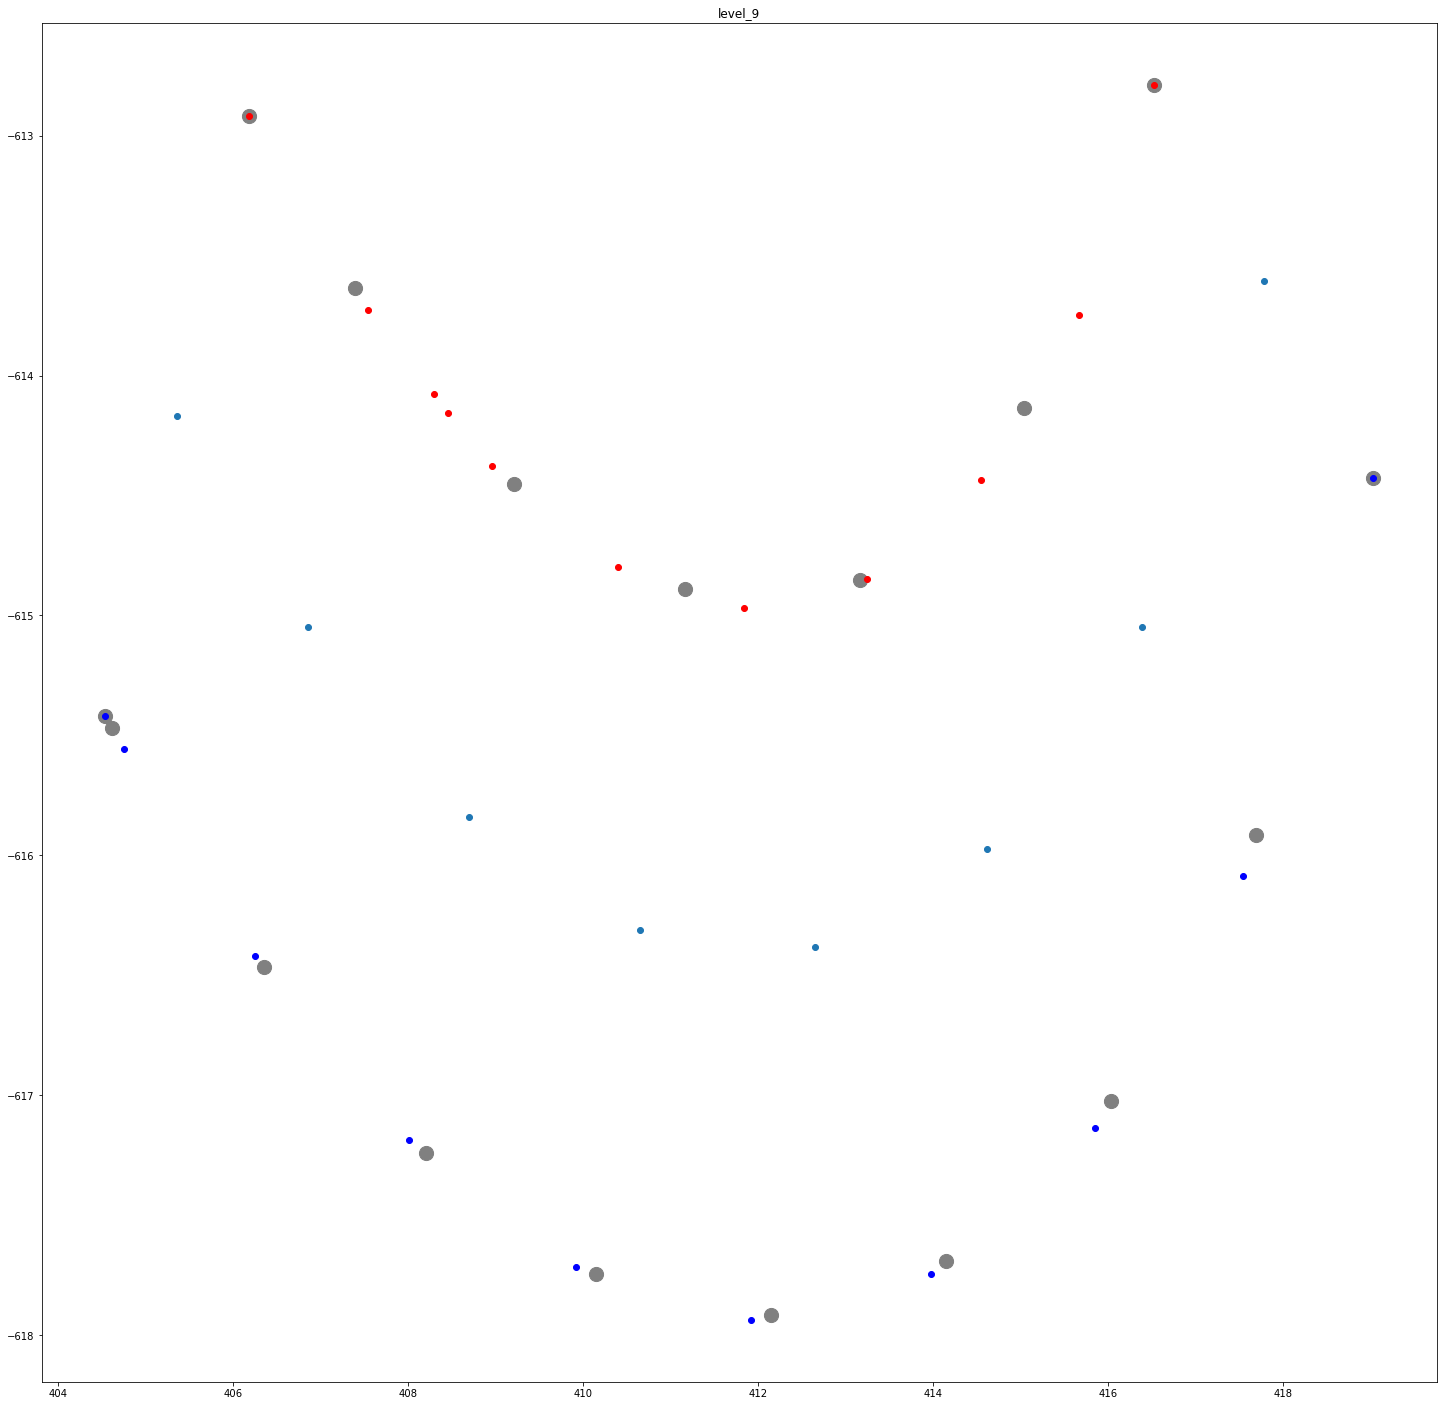

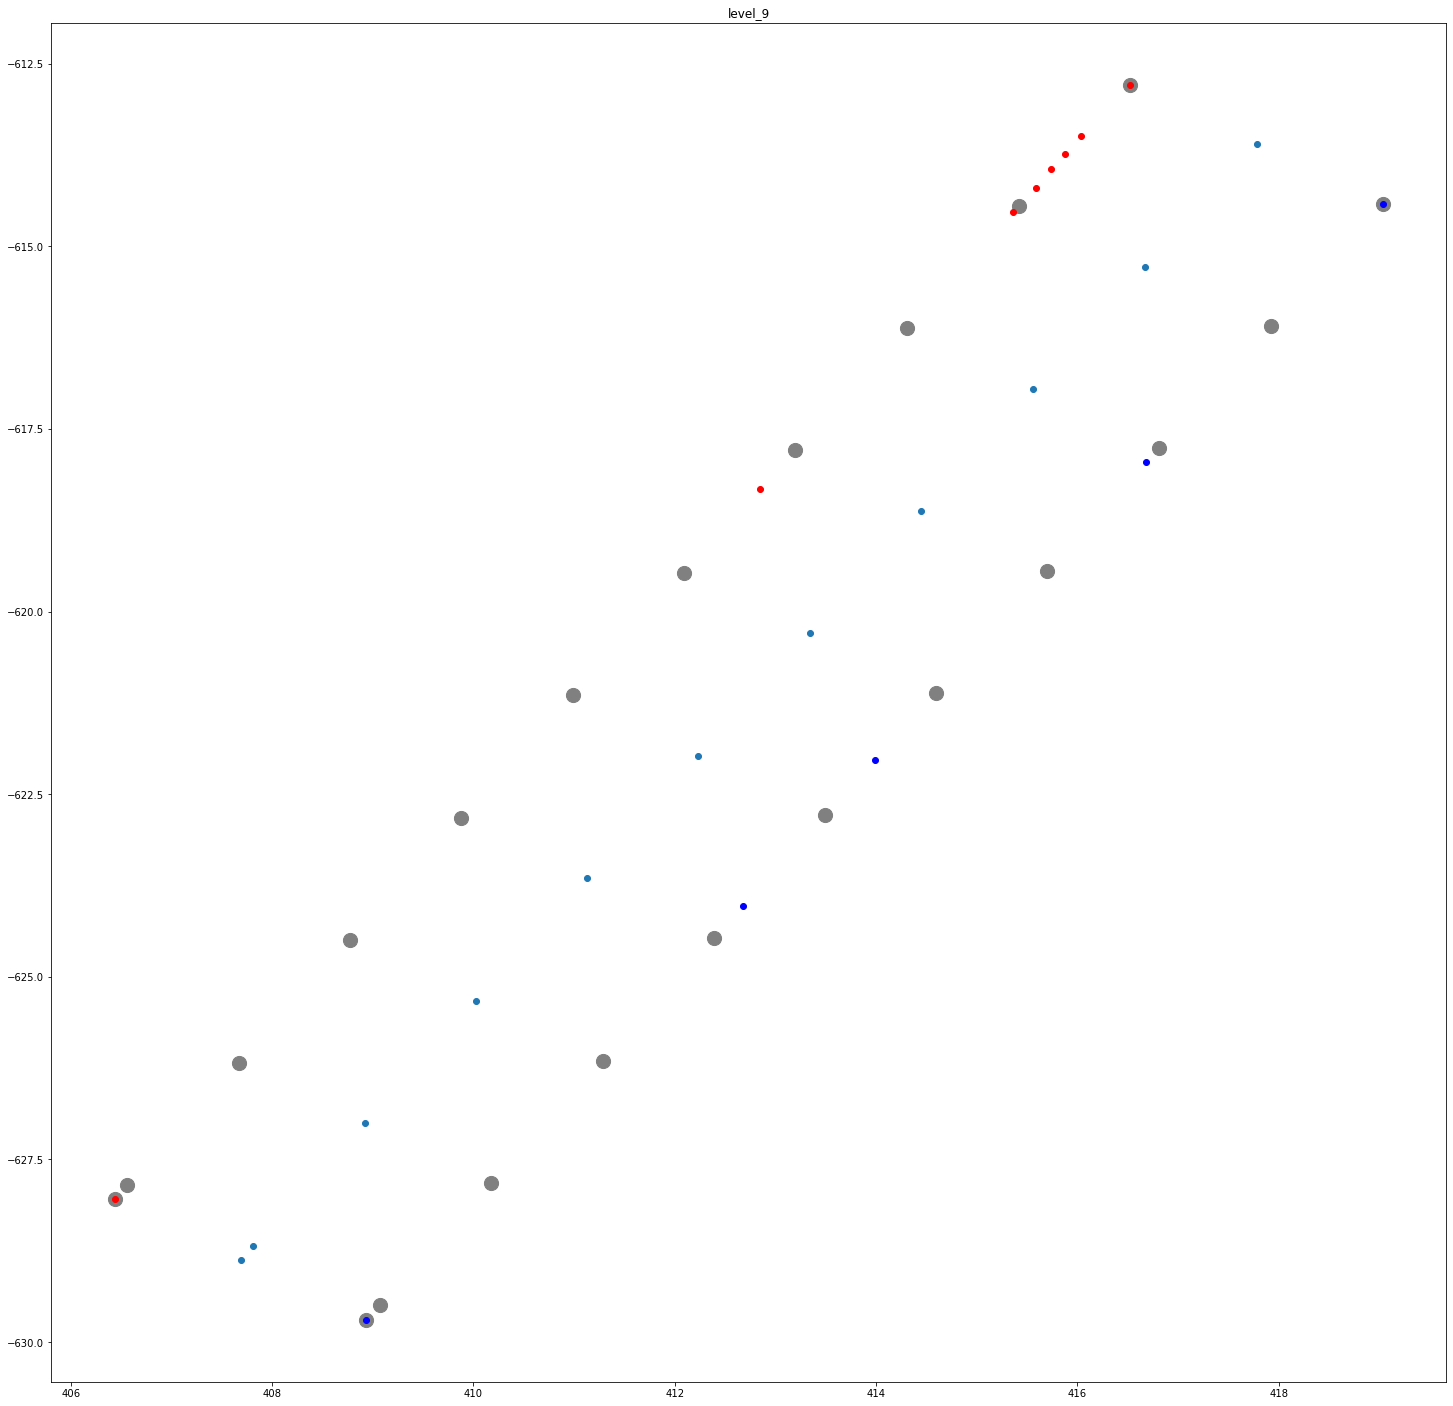

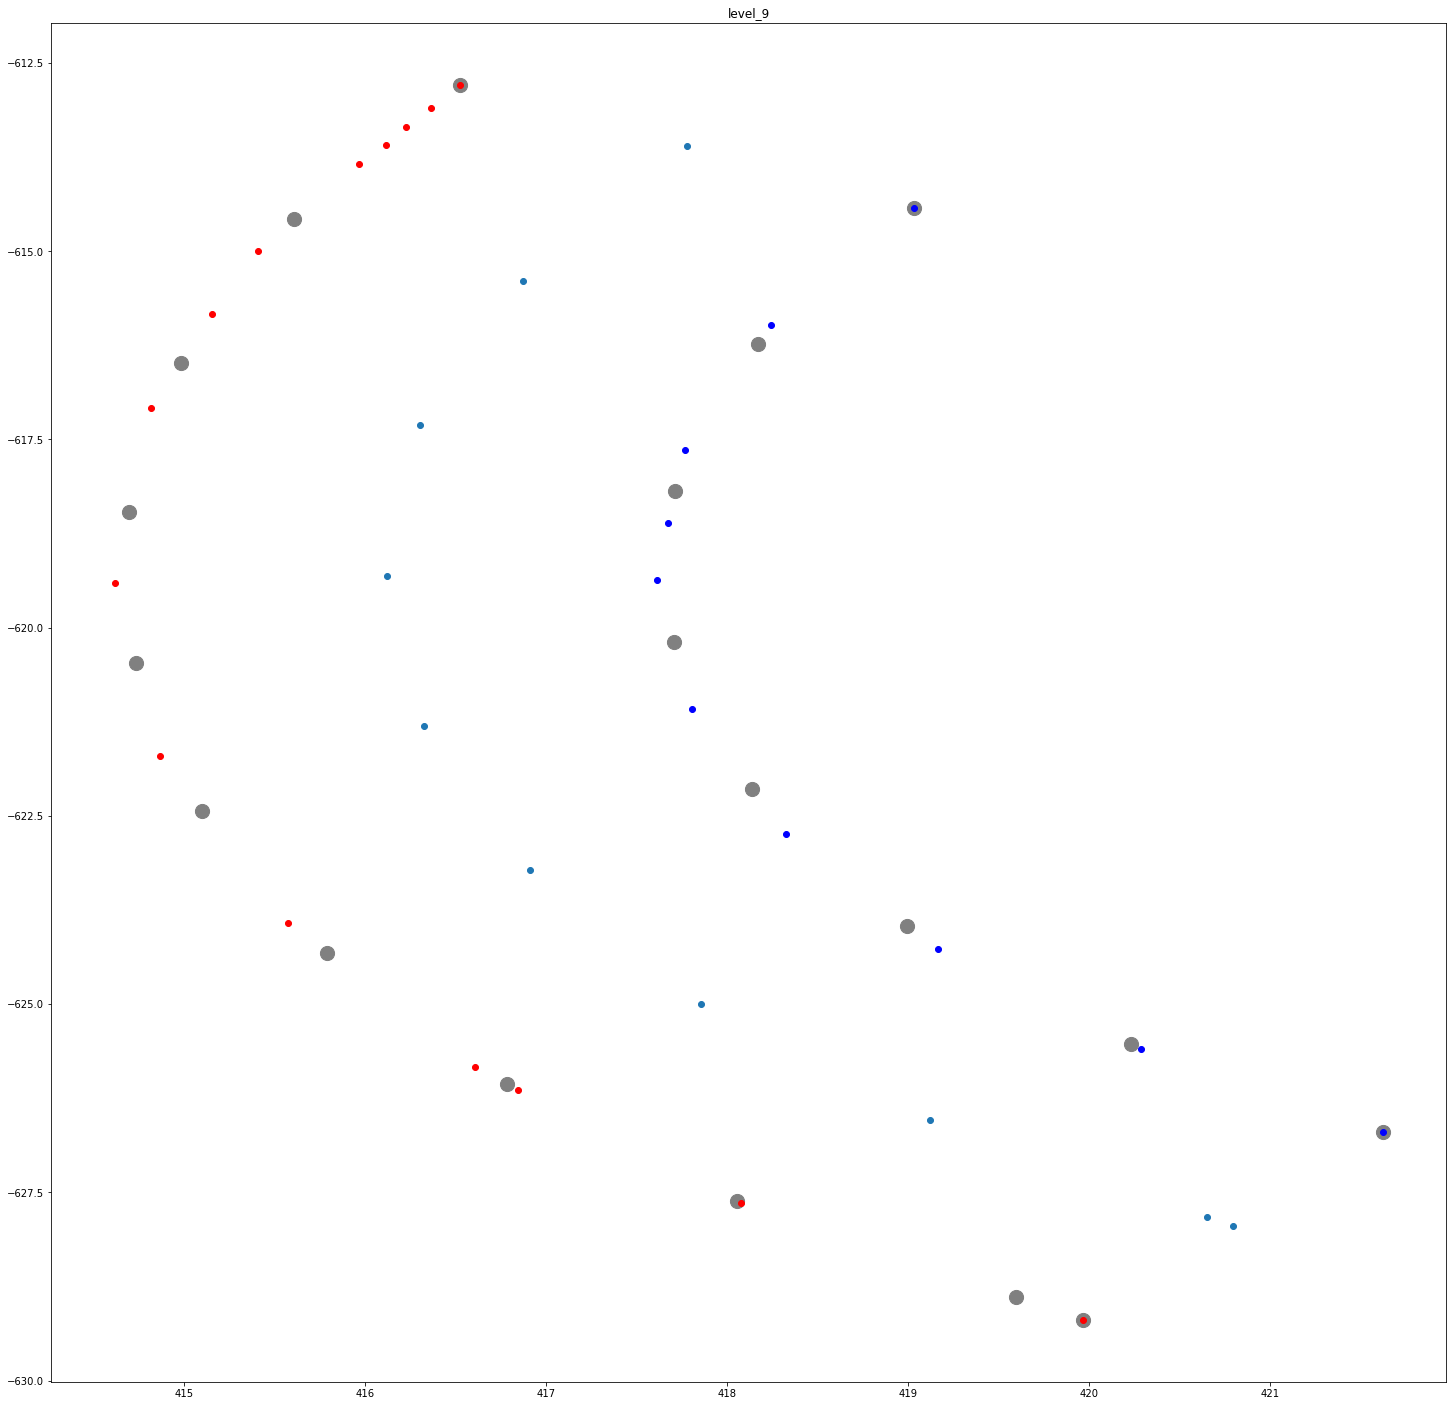

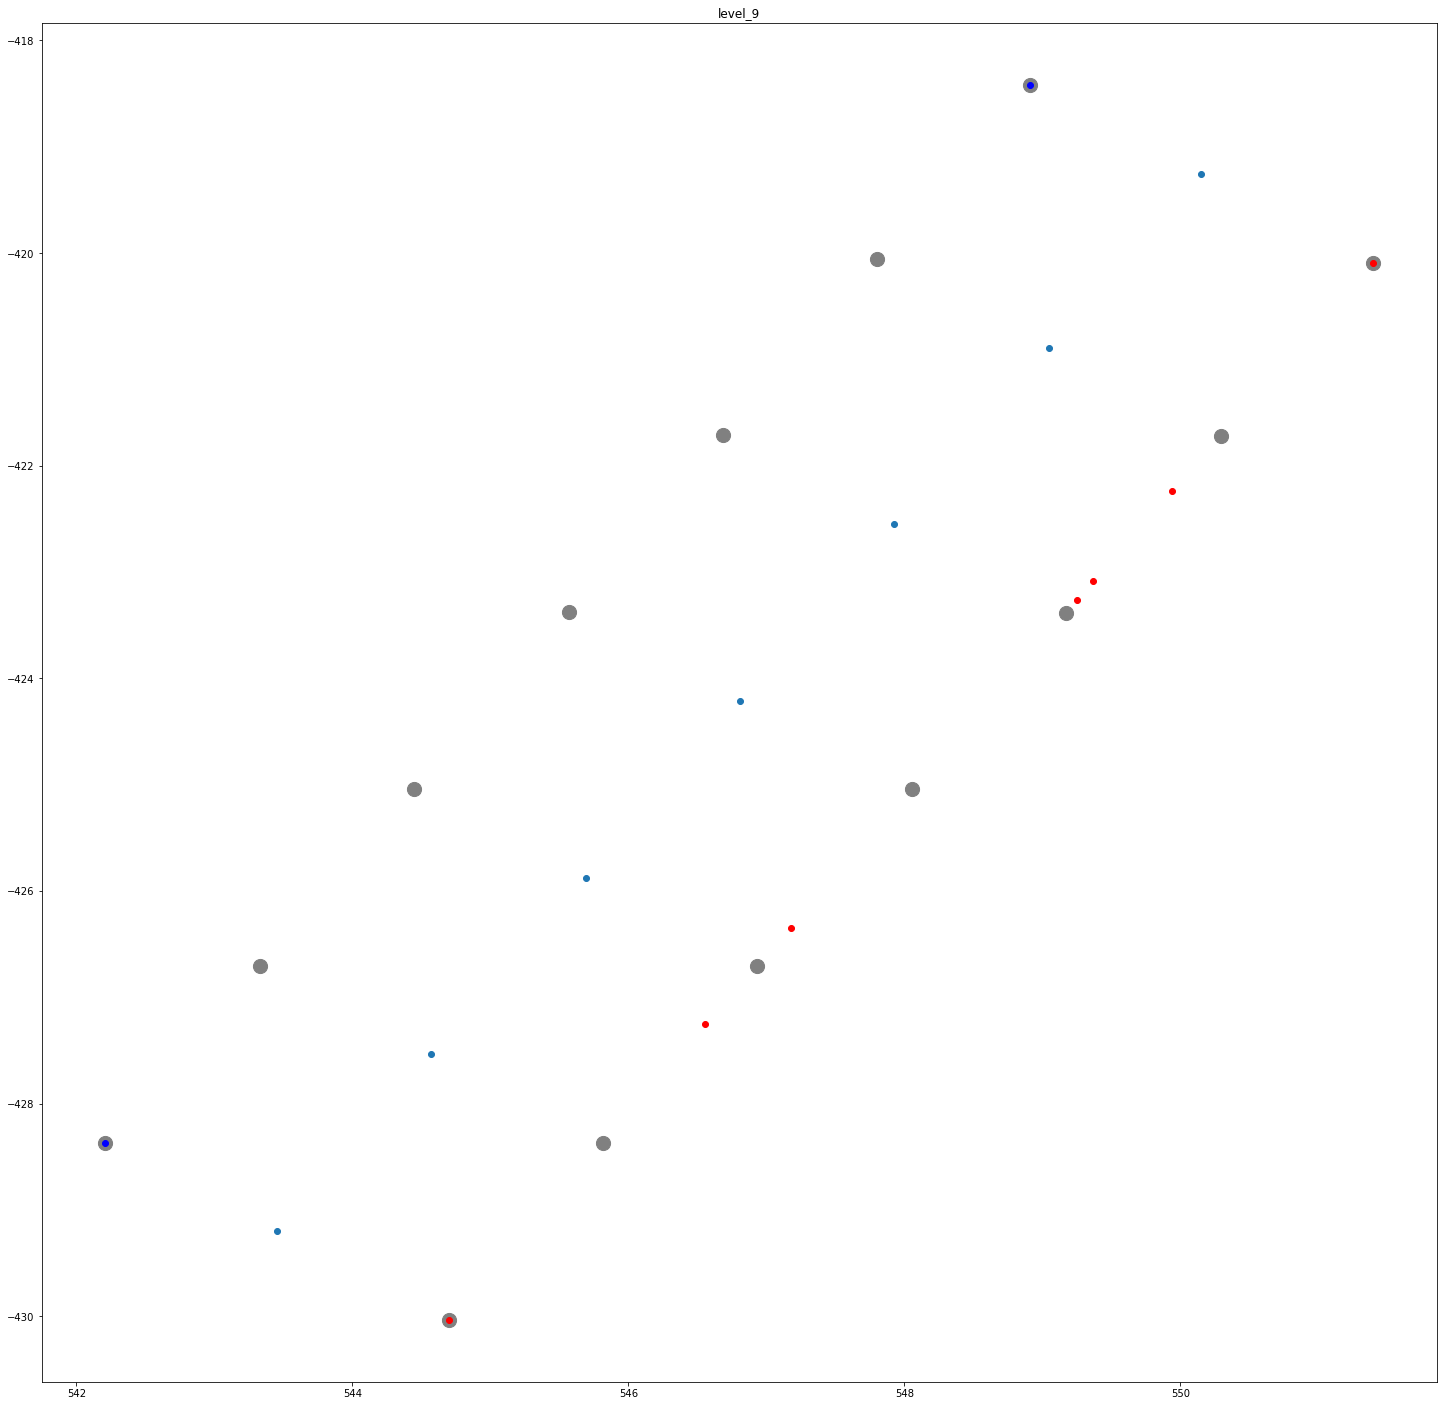

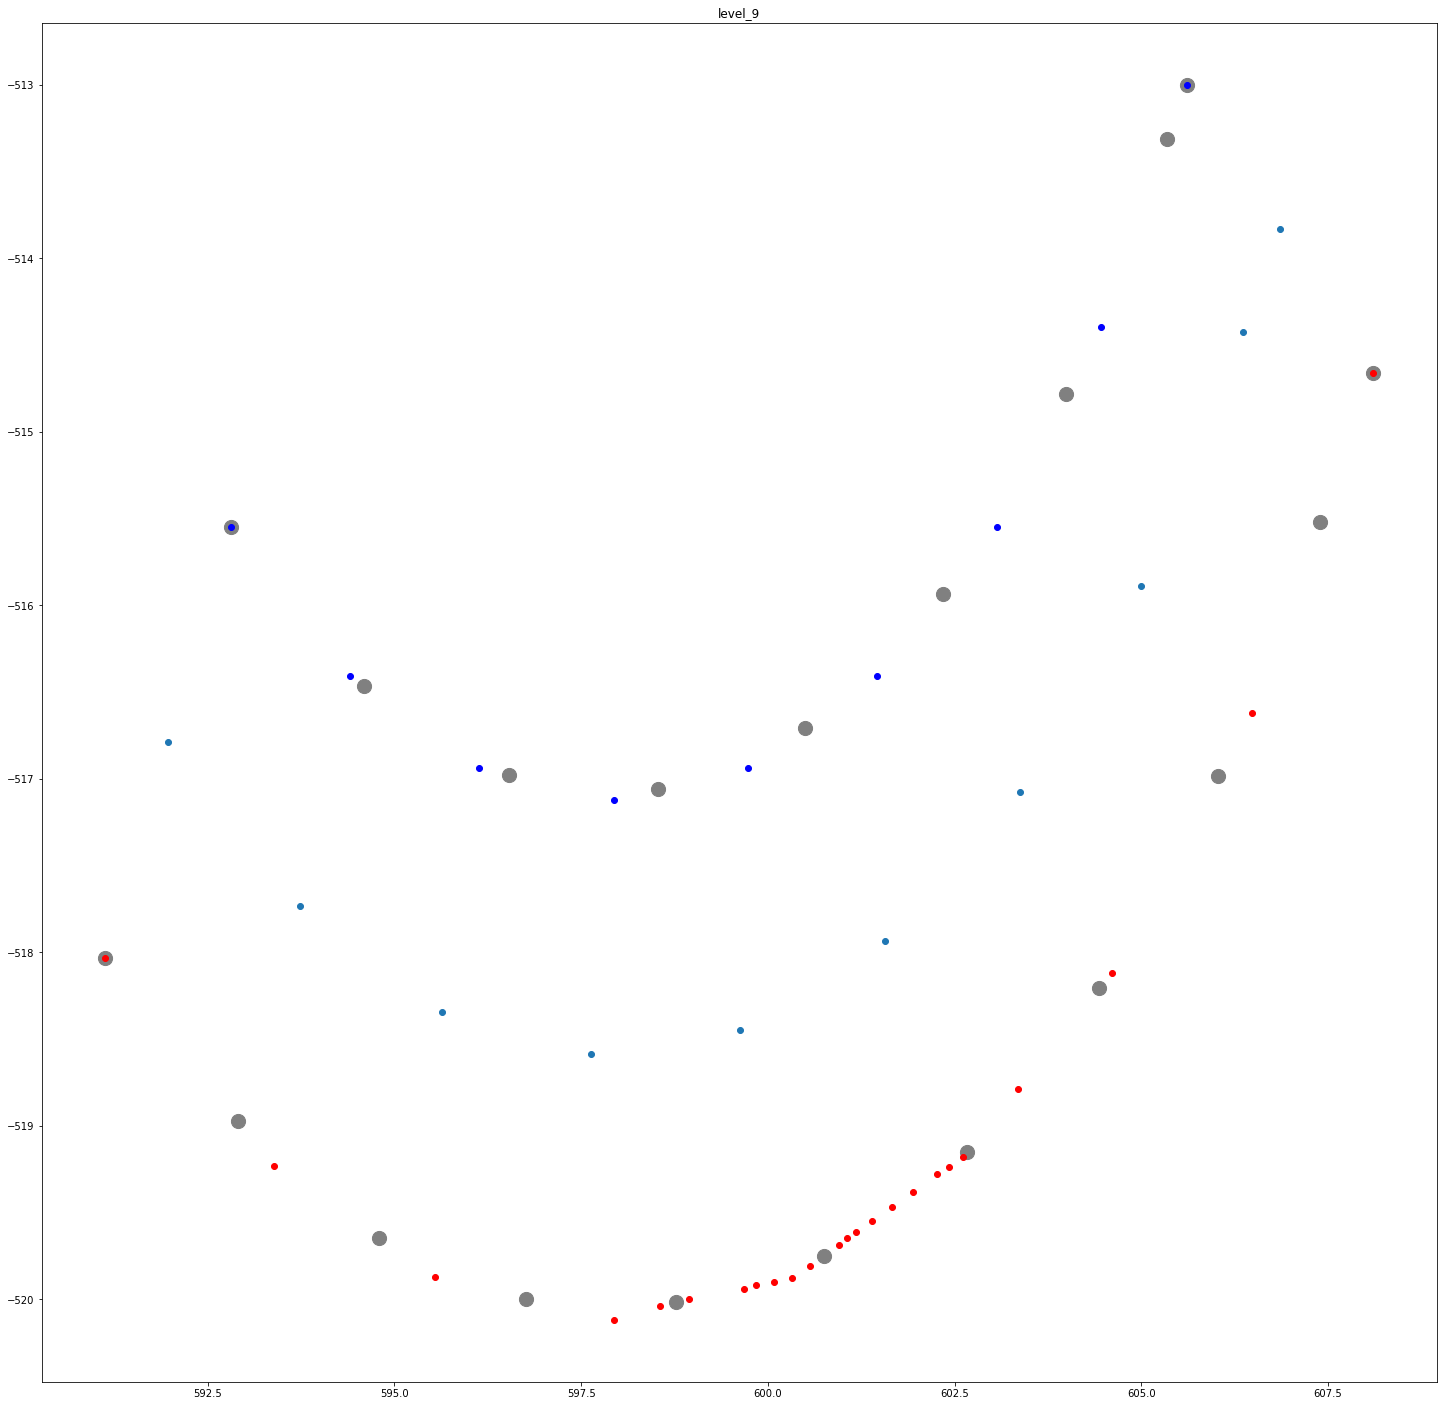

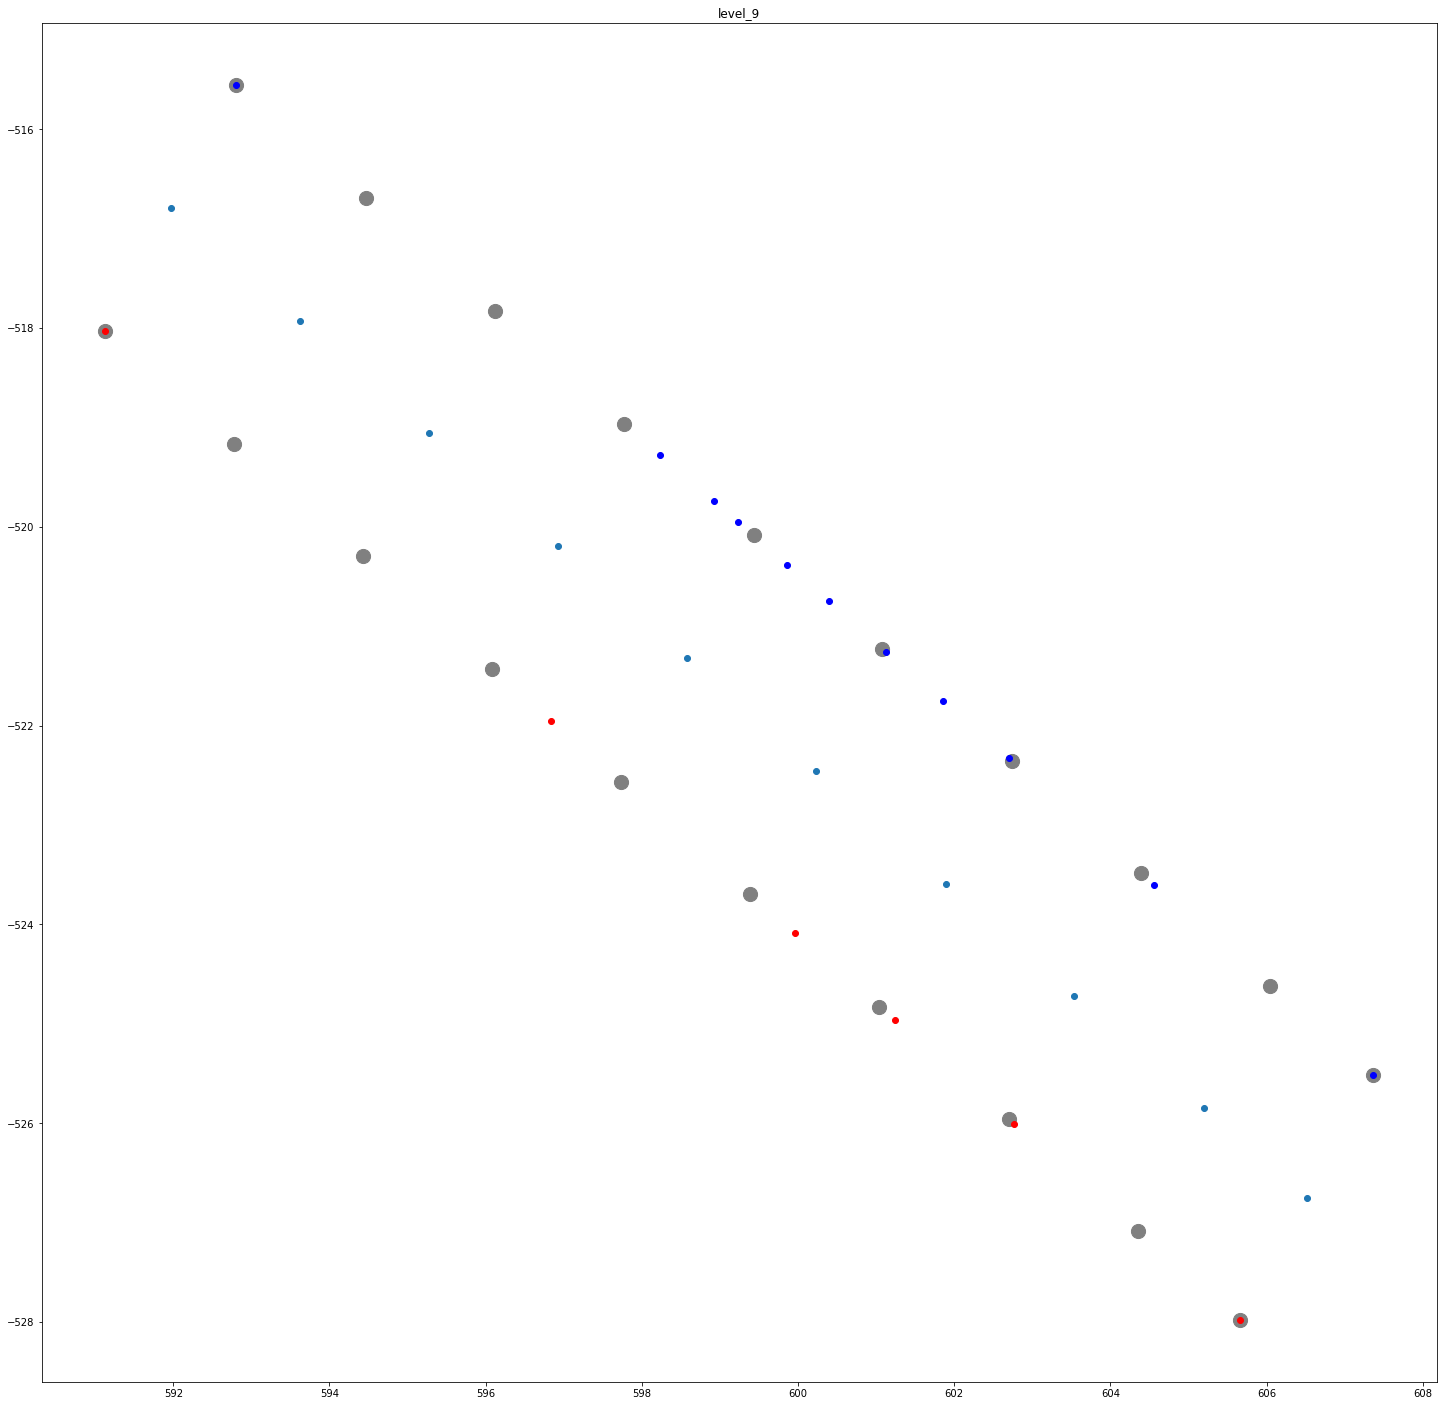

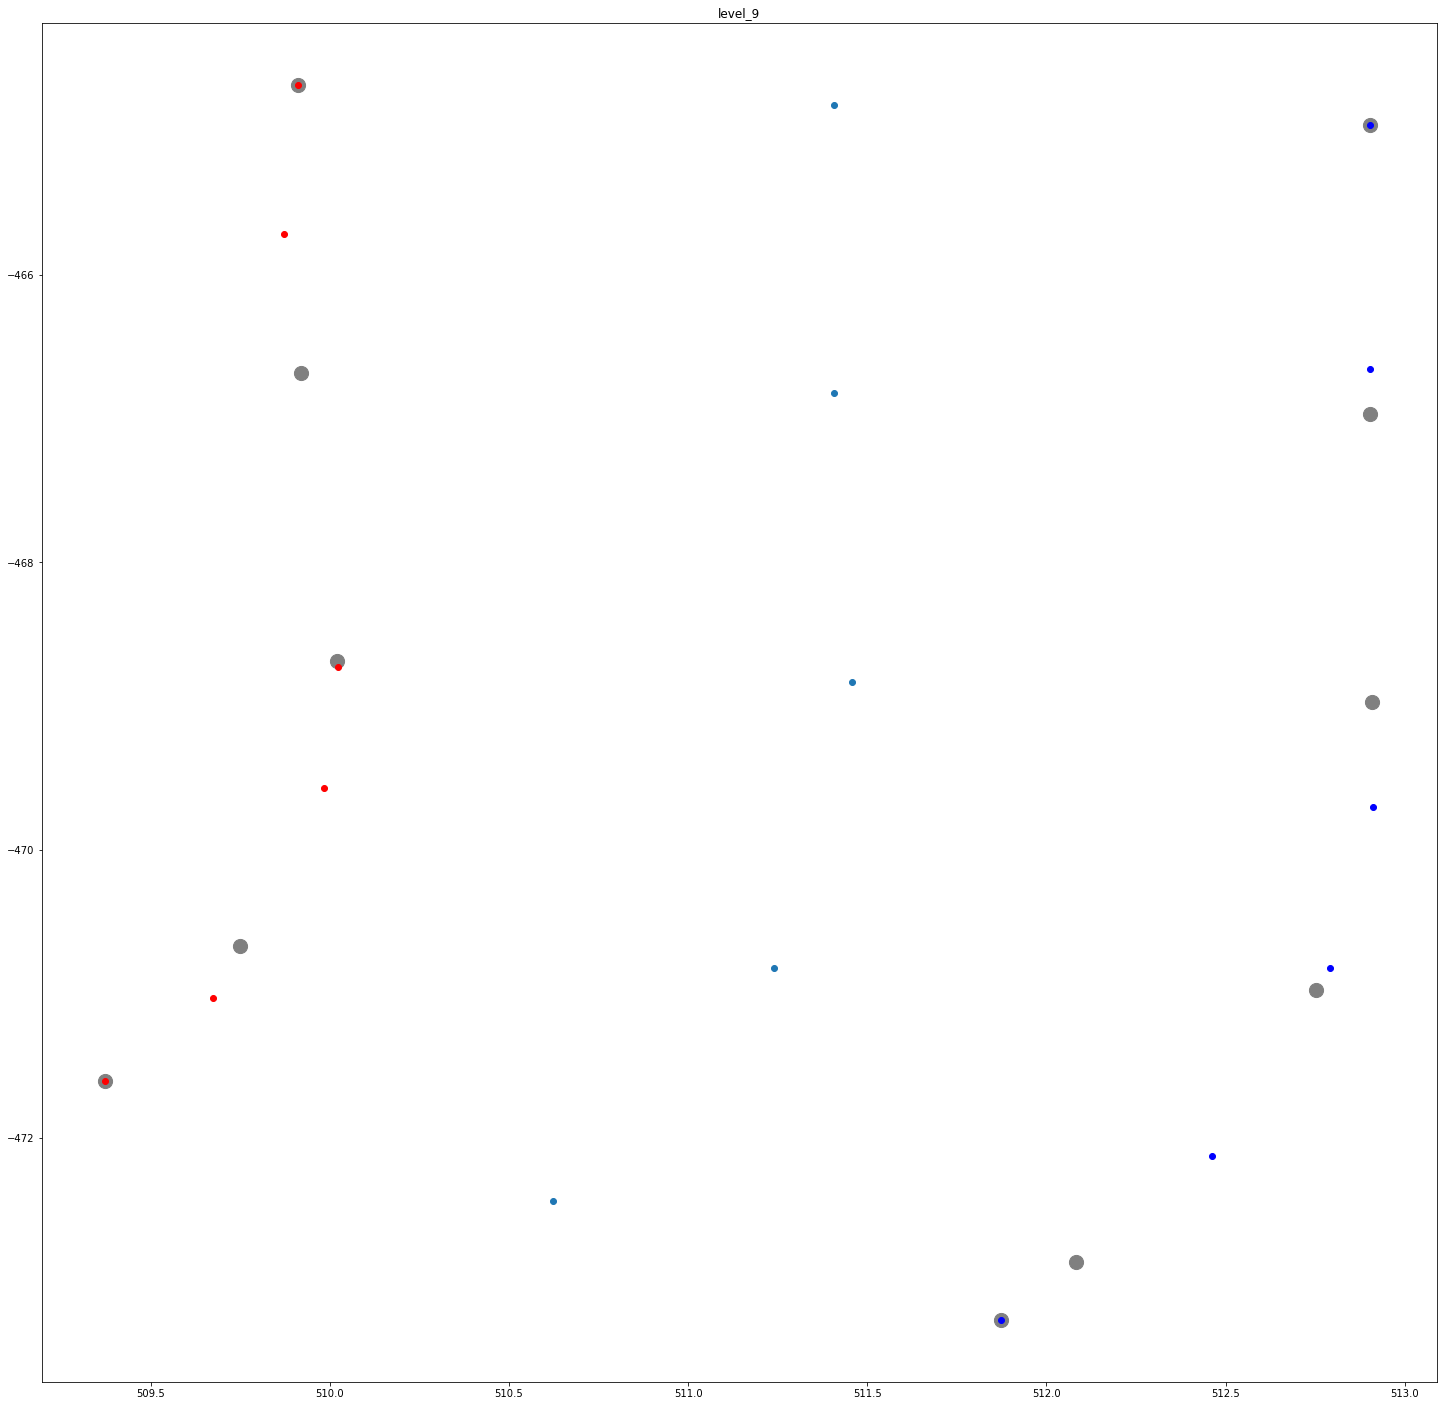

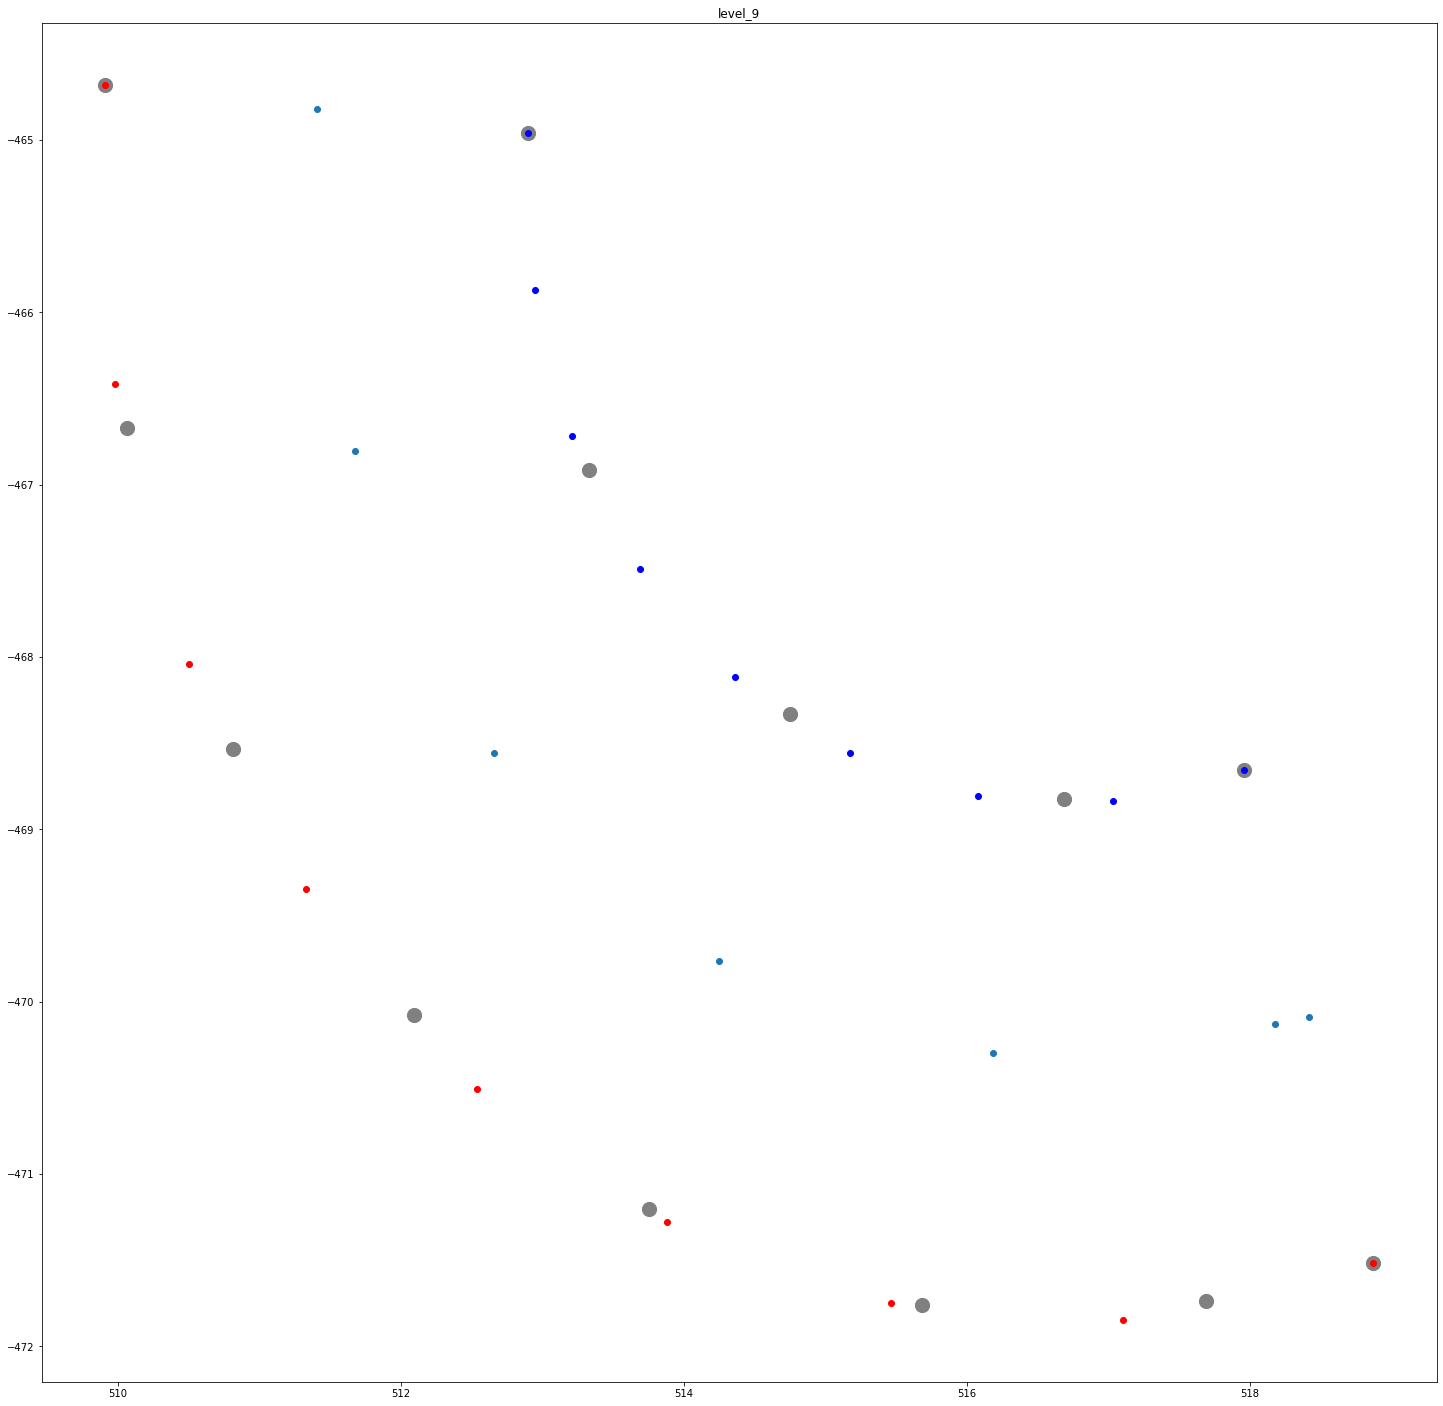

In [383]:
def plot_lane(lane_id, title):
    plt.figure(figsize=(25, 25))
    center_line = lanes_crosswalks['lanes']['center_line'][id_2_idx[lane_id]]
    xy_left = lanes_crosswalks['lanes']['xy_left'][id_2_idx[lane_id]]
    xy_right = lanes_crosswalks['lanes']['xy_right'][id_2_idx[lane_id]]
    
    xy_left_ = lanes_crosswalks['lanes']['xy_left_'][id_2_idx[lane_id]]
    xy_right_ = lanes_crosswalks['lanes']['xy_right_'][id_2_idx[lane_id]]
    
    plt.scatter(center_line[:, 0], center_line[:, 1])
    plt.scatter(xy_left_[:, 0], xy_left_[:, 1], c='grey', s=200)
    plt.scatter(xy_right_[:, 0], xy_right_[:, 1], c='grey', s=200)
    plt.scatter(xy_left[:, 0], xy_left[:, 1], c='b')
    plt.scatter(xy_right[:, 0], xy_right[:, 1], c='r')
    plt.title(title)


    
def check_conseq_lanes(start_id):
    plot_lane(start_id, 'level_0')
    q = deque()
    for element_id in [proto_API.id_as_str(x) for x in proto_API.get_lanes_ahead(start_id)]:
        q.append(element_id)
    for level_i in range(10):
        for _ in range(len(q)):
            next_el_id = q.popleft()
            plot_lane(next_el_id, f'level_{level_i}')
            for element_id in [proto_API.id_as_str(x) for x in proto_API.get_lanes_ahead(next_el_id)]:
                q.append(element_id)
        
check_conseq_lanes('coV3')
    

In [43]:
lane_orientations = []



for element in proto_API:
        element_id = MapAPI.id_as_str(element.id)

        if proto_API.is_lane(element):
            lane_orientations.append(proto_API.get_lane_orientation(element_id))

(array([0, 1, 2, 3]),
 [Text(0, 0, 'ONE_WAY_FORWARD'),
  Text(1, 0, 'UNKNOWN_TRAVEL_DIRECTION'),
  Text(2, 0, 'ONE_WAY_BACKWARD'),
  Text(3, 0, 'TWO_WAY')])

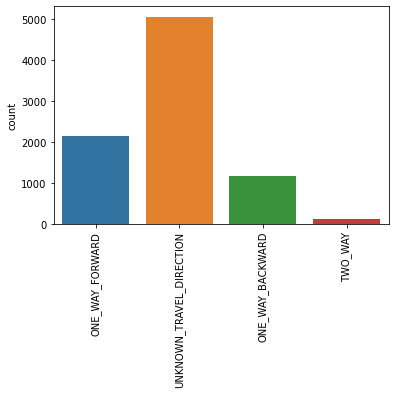

In [46]:
sns.countplot(lane_orientations)
plt.xticks(rotation=90)

In [348]:
all_center_coords = np.concatenate(lanes_crosswalks['lanes']['center_line'], axis=0)

In [528]:
idx_2_lane_id_idx = []
for lane_id, center_line in zip(lanes_crosswalks['lanes']['ids'], lanes_crosswalks['lanes']['center_line']):
    next_entries = [(lane_id, i) for i in range(len(center_line))]
    print(next_entries)
    idx_2_lane_id_idx.extend(next_entries)

[('362i', 0), ('362i', 1), ('362i', 2), ('362i', 3), ('362i', 4), ('362i', 5), ('362i', 6), ('362i', 7), ('362i', 8), ('362i', 9), ('362i', 10), ('362i', 11), ('362i', 12), ('362i', 13), ('362i', 14), ('362i', 15), ('362i', 16), ('362i', 17), ('362i', 18), ('362i', 19), ('362i', 20), ('362i', 21), ('362i', 22), ('362i', 23), ('362i', 24), ('362i', 25), ('362i', 26), ('362i', 27), ('362i', 28), ('362i', 29), ('362i', 30), ('362i', 31), ('362i', 32), ('362i', 33), ('362i', 34), ('362i', 35), ('362i', 36), ('362i', 37), ('362i', 38), ('362i', 39), ('362i', 40), ('362i', 41), ('362i', 42), ('362i', 43), ('362i', 44), ('362i', 45)]
[('TVqs', 0), ('TVqs', 1), ('TVqs', 2), ('TVqs', 3), ('TVqs', 4), ('TVqs', 5), ('TVqs', 6), ('TVqs', 7), ('TVqs', 8), ('TVqs', 9), ('TVqs', 10), ('TVqs', 11), ('TVqs', 12), ('TVqs', 13), ('TVqs', 14), ('TVqs', 15)]
[('kZV8', 0), ('kZV8', 1), ('kZV8', 2), ('kZV8', 3), ('kZV8', 4), ('kZV8', 5)]
[('ofbB', 0), ('ofbB', 1), ('ofbB', 2), ('ofbB', 3), ('ofbB', 4)]
[('v7

[('f8HH', 0), ('f8HH', 1)]
[('ZyNY', 0), ('ZyNY', 1), ('ZyNY', 2), ('ZyNY', 3), ('ZyNY', 4), ('ZyNY', 5), ('ZyNY', 6), ('ZyNY', 7), ('ZyNY', 8), ('ZyNY', 9), ('ZyNY', 10), ('ZyNY', 11), ('ZyNY', 12), ('ZyNY', 13), ('ZyNY', 14), ('ZyNY', 15), ('ZyNY', 16), ('ZyNY', 17), ('ZyNY', 18), ('ZyNY', 19), ('ZyNY', 20), ('ZyNY', 21), ('ZyNY', 22), ('ZyNY', 23), ('ZyNY', 24), ('ZyNY', 25), ('ZyNY', 26), ('ZyNY', 27), ('ZyNY', 28), ('ZyNY', 29), ('ZyNY', 30), ('ZyNY', 31), ('ZyNY', 32), ('ZyNY', 33), ('ZyNY', 34), ('ZyNY', 35), ('ZyNY', 36), ('ZyNY', 37), ('ZyNY', 38), ('ZyNY', 39), ('ZyNY', 40), ('ZyNY', 41), ('ZyNY', 42), ('ZyNY', 43), ('ZyNY', 44), ('ZyNY', 45), ('ZyNY', 46)]
[('nPcV', 0), ('nPcV', 1), ('nPcV', 2), ('nPcV', 3), ('nPcV', 4), ('nPcV', 5), ('nPcV', 6)]
[('oTFz', 0), ('oTFz', 1), ('oTFz', 2), ('oTFz', 3), ('oTFz', 4), ('oTFz', 5), ('oTFz', 6), ('oTFz', 7), ('oTFz', 8), ('oTFz', 9), ('oTFz', 10), ('oTFz', 11), ('oTFz', 12), ('oTFz', 13), ('oTFz', 14), ('oTFz', 15), ('oTFz', 16), ('o

[('XblY', 0), ('XblY', 1), ('XblY', 2), ('XblY', 3), ('XblY', 4), ('XblY', 5), ('XblY', 6), ('XblY', 7), ('XblY', 8), ('XblY', 9), ('XblY', 10), ('XblY', 11)]
[('zfNI', 0), ('zfNI', 1), ('zfNI', 2), ('zfNI', 3), ('zfNI', 4), ('zfNI', 5), ('zfNI', 6), ('zfNI', 7), ('zfNI', 8), ('zfNI', 9), ('zfNI', 10), ('zfNI', 11)]
[('GQ9s', 0), ('GQ9s', 1), ('GQ9s', 2), ('GQ9s', 3), ('GQ9s', 4), ('GQ9s', 5), ('GQ9s', 6)]
[('phot', 0), ('phot', 1)]
[('YDKe', 0), ('YDKe', 1)]
[('rMSs', 0), ('rMSs', 1), ('rMSs', 2)]
[('TyBr', 0), ('TyBr', 1), ('TyBr', 2), ('TyBr', 3), ('TyBr', 4), ('TyBr', 5), ('TyBr', 6)]
[('9H3G', 0), ('9H3G', 1), ('9H3G', 2), ('9H3G', 3), ('9H3G', 4), ('9H3G', 5), ('9H3G', 6)]
[('/K6g', 0), ('/K6g', 1), ('/K6g', 2), ('/K6g', 3), ('/K6g', 4), ('/K6g', 5), ('/K6g', 6), ('/K6g', 7), ('/K6g', 8), ('/K6g', 9)]
[('7d0D', 0), ('7d0D', 1)]
[('/JWS', 0), ('/JWS', 1), ('/JWS', 2), ('/JWS', 3), ('/JWS', 4), ('/JWS', 5), ('/JWS', 6)]
[('Cg4J', 0), ('Cg4J', 1), ('Cg4J', 2), ('Cg4J', 3), ('Cg4J', 

In [351]:
kd_tree = KDTree(all_center_coords)

In [451]:
def is_lane_direction_forward(coordinates, lane_id, lane_point_idx, speed_vector):
    lane_idx = id_2_idx[lane_id]
    center_line = lanes_crosswalks['lanes']['center_line'][lane_idx]
    if lane_point_idx < len(center_line) - 1:
        forward_point = center_line[lane_point_idx + 1]
    elif len(lane_adj_list_forward[lane_idx]):
        consecutive_lane_id = lane_adj_list_forward[lane_idx][0]
        forward_point = lanes_crosswalks['lanes']['center_line'][id_2_idx[consecutive_lane_id]][0]
    else:
        forward_point = center_line[lane_point_idx]
        
    if lane_point_idx > 0:
        backward_point = center_line[lane_point_idx - 1]
    elif len(lane_adj_list_backward[lane_idx]):
        consecutive_lane_id = lane_adj_list_backward[lane_idx][0]
        backward_point = lanes_crosswalks['lanes']['center_line'][id_2_idx[consecutive_lane_id]][-1]
    else:
        backward_point = center_line[lane_point_idx]
        
    next_point = coordinates + speed_vector*10
    diff_backward = next_point - backward_point
    diff_forward = next_point - forward_point
    print('next_point:', next_point, 'backward_point', backward_point, 'forward_point', forward_point)
    return np.hypot(diff_forward[0], diff_forward[1]) < np.hypot(diff_backward[0], diff_backward[1])
    

In [514]:
kd_tree.query(np.array([-235.78379822,  581.04144287]))

(0.14628200334253944, 33025)

In [613]:
num_kd_neighbours = 5
start_coordinates = np.array([-998.35510254, 1361.04150391])
start_speed_m_per_frame = np.array([-0.47235107, -1.2283936 ])
dists_to_start, candidate_start_indices = kd_tree.query(start_coordinates, k=num_kd_neighbours)

In [614]:
candidate_start_indices

array([53944, 92160, 94447, 94448, 53943])

In [615]:
dists_to_next_point, candidate_next_indices = kd_tree.query(start_coordinates + start_speed_m_per_frame, 
                                                            k=num_kd_neighbours)

In [616]:
from collections import defaultdict
lane_2_dist = defaultdict(list)
for dist_to_start, idx in zip(dists_to_start, candidate_start_indices):
    print(idx)
    lane_id = idx_2_lane_id_idx[idx][0]
    lane_2_dist[lane_id].append(dist_to_start)
for dist_to_next_point, idx in zip(dists_to_next_point, candidate_next_indices):
    lane_id = idx_2_lane_id_idx[idx][0]
    if lane_id in lane_2_dist:
        lane_2_dist[lane_id].append(dist_to_next_point)

53944
92160
94447
94448
53943


In [617]:
[idx_2_lane_id_idx[idx] for idx in candidate_start_indices]

[('WNum', 13), ('Gmu4', 8), ('kVZG', 0), ('kVZG', 1), ('WNum', 12)]

In [618]:
lane_2_dist

defaultdict(list,
            {'WNum': [0.6462092613735197,
              1.198240768099115,
              1.5940059733045584,
              2.3449422416415184],
             'Gmu4': [0.6462092613735197, 1.5940059733045584],
             'kVZG': [0.6462092613735197,
              0.9972572792225717,
              0.5443634897732847,
              1.5940059733045584]})

In [619]:
chosen_lane_id = min([(lane_id, np.mean(dists)) 
                      for lane_id, dists in lane_2_dist.items() if len(dists) >= 2], key=lambda x: x[1])[0]
lane_point_idx = None
i = 0
while i < num_kd_neighbours and lane_point_idx is None:
    lane_id, point_idx = idx_2_lane_id_idx[candidate_start_indices[i]]
    if lane_id == chosen_lane_id:
        lane_point_idx = point_idx
    i += 1
assert lane_point_idx is not None

In [620]:
chosen_lane_id, lane_point_idx

('kVZG', 0)

In [509]:
idx_2_lane_id_idx[19291]

('nHFO', 11)

In [ ]:
%%time
kd_tree.query(np.array([532, -320]))

In [41]:
from functools import lru_cache
from typing import Iterator, Sequence, Union, no_type_check

import numpy as np
import pymap3d as pm

from l5kit.geometry import transform_points
from l5kit.data.proto.road_network_pb2 import GeoFrame, GlobalId, MapElement, MapFragment, RoadNetworkSegment

CACHE_SIZE = int(1e5)
ENCODING = "utf-8"


class MapAPI:
    def __init__(self, protobuf_map_path: str, world_to_ecef: np.ndarray):
        """
        Interface to the raw protobuf map file with the following features:
        - access to element using ID is O(1);
        - access to coordinates in world ref system for a set of elements is O(1) after first access (lru cache)
        - object support iteration using __getitem__ protocol

        Args:
            protobuf_map_path (str): path to the protobuf file
            world_to_ecef (np.ndarray): transformation matrix from world coordinates to ECEF (dataset dependent)
        """
        self.protobuf_map_path = protobuf_map_path
        self.ecef_to_world = np.linalg.inv(world_to_ecef)

        with open(protobuf_map_path, "rb") as infile:
            mf = MapFragment()
            mf.ParseFromString(infile.read())

        self.elements = mf.elements
        self.ids_to_el = {self.id_as_str(el.id): idx for idx, el in enumerate(self.elements)}  # store a look-up table
        
        self.lane_orientation_code_2_str = {0: "UNKNOWN_TRAVEL_DIRECTION",
                                            1: "TWO_WAY",
                                            2: "ONE_WAY_FORWARD",
                                            3: "ONE_WAY_BACKWARD",
                                            4: "ONE_WAY_REVERSIBLE"}

    @staticmethod
    @no_type_check
    def id_as_str(element_id: GlobalId) -> str:
        """
        Get the element id as a string.
        Elements ids are stored as a variable len sequence of bytes in the protobuf

        Args:
            element_id (GlobalId): the GlobalId in the protobuf

        Returns:
            str: the id as a str
        """
        return element_id.id.decode(ENCODING)

    @staticmethod
    def _undo_e7(value: float) -> float:
        """
        Latitude and longitude are stored as value*1e7 in the protobuf for efficiency and guaranteed accuracy.
        Convert them back to float.

        Args:
            value (float): the scaled value

        Returns:
            float: the unscaled value
        """
        return value / 1e7

    @no_type_check
    def unpack_deltas_cm(self, dx: Sequence[int], dy: Sequence[int], dz: Sequence[int], frame: GeoFrame) -> np.ndarray:
        """
        Get coords in world reference system (local ENU->ECEF->world).
        See the protobuf annotations for additional information about how coordinates are stored

        Args:
            dx (Sequence[int]): X displacement in centimeters in local ENU
            dy (Sequence[int]): Y displacement in centimeters in local ENU
            dz (Sequence[int]): Z displacement in centimeters in local ENU
            frame (GeoFrame): geo-location information for the local ENU. It contains lat and long origin of the frame

        Returns:
            np.ndarray: array of shape (Nx3) with XYZ coordinates in world ref system

        """
        x = np.cumsum(np.asarray(dx) / 100)
        y = np.cumsum(np.asarray(dy) / 100)
        z = np.cumsum(np.asarray(dz) / 100)
        frame_lat, frame_lng = self._undo_e7(frame.origin.lat_e7), self._undo_e7(frame.origin.lng_e7)
        xyz = np.stack(pm.enu2ecef(x, y, z, frame_lat, frame_lng, 0), axis=-1)
        xyz = transform_points(xyz, self.ecef_to_world)
        return xyz

    @staticmethod
    @no_type_check
    def is_lane(element: MapElement) -> bool:
        """
        Check whether an element is a valid lane

        Args:
            element (MapElement): a proto element

        Returns:
            bool: True if the element is a valid lane
        """
        return bool(element.element.HasField("lane"))

    @staticmethod
    @no_type_check
    def is_road_network_segment(element: MapElement) -> bool:
        """
        Check whether an element is a valid RoadNetworkSegment

        Args:
            element (MapElement): a proto element

        Returns:
            bool: True if the element is a valid segment
        """
        return bool(element.element.HasField("segment"))

    @staticmethod
    @no_type_check
    def is_junction(element: MapElement) -> bool:
        """
        Check whether an element is a valid Junction

        Args:
            element (MapElement): a proto element

        Returns:
            bool: True if the element is a valid Junction
        """
        return bool(element.element.HasField("junction"))

    def is_primary_road(self, element_id: str) -> bool:
        """
        Check whether a RoadNetworkSegment is primary road

        Args:
            element_id (str): the id (utf-8 encode) of the element

        Returns:
            bool: True if the element is a primary road, False otherwise
        """
        element = self[element_id]
        if not element.element.HasField("segment"):
            return False
        segment = element.element.segment
        return bool(segment.road_class == RoadNetworkSegment.RoadClass.PRIMARY)

    def is_secondary_road(self, element_id: str) -> bool:
        """
        Check whether a RoadNetworkSegment is primary road

        Args:
            element_id (str): the id (utf-8 encode) of the element

        Returns:
            bool: True if the element is a primary road, False otherwise
        """
        element = self[element_id]
        if not element.element.HasField("segment"):
            return False
        segment = element.element.segment
        return bool(segment.road_class == RoadNetworkSegment.RoadClass.SECONDARY)

    @lru_cache(maxsize=CACHE_SIZE)
    def get_lane_coords(self, element_id: str) -> dict:
        """
        Get XYZ coordinates in world ref system for a lane given its id
        lru_cached for O(1) access

        Args:
            element_id (str): lane element id

        Returns:
            dict: a dict with the two boundaries coordinates as (Nx3) XYZ arrays
        """
        element = self[element_id]
        assert self.is_lane(element)

        lane = element.element.lane
        left_boundary = lane.left_boundary
        right_boundary = lane.right_boundary

        xyz_left = self.unpack_deltas_cm(
            left_boundary.vertex_deltas_x_cm,
            left_boundary.vertex_deltas_y_cm,
            left_boundary.vertex_deltas_z_cm,
            lane.geo_frame,
        )
        xyz_right = self.unpack_deltas_cm(
            right_boundary.vertex_deltas_x_cm,
            right_boundary.vertex_deltas_y_cm,
            right_boundary.vertex_deltas_z_cm,
            lane.geo_frame,
        )

        return {"xyz_left": xyz_left, "xyz_right": xyz_right}

    def get_lanes_ahead(self, element_id: str) -> list:
        """
        Get lanes that the follow the current one in the natural travel direction,
         i.e. without changing lanes

        Args:
            element_id (str): lane element id

        Returns:
            list: a list with element ids of consequent lanes
        """
        element = self[element_id]
        assert self.is_lane(element)

        lane = element.element.lane
        return list(lane.lanes_ahead)


    def get_lane_orientation(self, element_id: str) -> str:
        """
        Get lanes that the follow the current one in the natural travel direction,
         i.e. without changing lanes

        Args:
            element_id (str): lane element id

        Returns:
            list: a list with element ids of consequent lanes
        """
        element = self[element_id]
        assert self.is_lane(element)

        lane = element.element.lane
        return self.lane_orientation_code_2_str[lane.orientation_in_parent_segment]

    @staticmethod
    @no_type_check
    def is_crosswalk(element: MapElement) -> bool:
        """
        Check whether an element is a valid crosswalk

        Args:
            element (MapElement): a proto element

        Returns:
            bool: True if the element is a valid crosswalk
        """
        if not element.element.HasField("traffic_control_element"):
            return False
        traffic_element = element.element.traffic_control_element
        return bool(traffic_element.HasField("pedestrian_crosswalk") and traffic_element.points_x_deltas_cm)

    @lru_cache(maxsize=CACHE_SIZE)
    def get_crosswalk_coords(self, element_id: str) -> dict:
        """
        Get XYZ coordinates in world ref system for a crosswalk given its id
        lru_cached for O(1) access

        Args:
            element_id (str): crosswalk element id

        Returns:
            dict: a dict with the polygon coordinates as an (Nx3) XYZ array
        """
        element = self[element_id]
        assert self.is_crosswalk(element)
        traffic_element = element.element.traffic_control_element

        xyz = self.unpack_deltas_cm(
            traffic_element.points_x_deltas_cm,
            traffic_element.points_y_deltas_cm,
            traffic_element.points_z_deltas_cm,
            traffic_element.geo_frame,
        )

        return {"xyz": xyz}

    def is_traffic_face_colour(self, element_id: str, colour: str) -> bool:
        """
        Check if the element is a traffic light face of the given colour

        Args:
            element_id (str): the id (utf-8 encode) of the element
            colour (str): the colour to check
        Returns:
            True if the element is a traffic light with the given colour
        """
        element = self[element_id]
        if not element.element.HasField("traffic_control_element"):
            return False
        traffic_el = element.element.traffic_control_element
        if (
            traffic_el.HasField(f"signal_{colour}_face")
            or traffic_el.HasField(f"signal_left_arrow_{colour}_face")
            or traffic_el.HasField(f"signal_right_arrow_{colour}_face")
            or traffic_el.HasField(f"signal_upper_left_arrow_{colour}_face")
            or traffic_el.HasField(f"signal_upper_right_arrow_{colour}_face")
        ):
            return True
        return False

    def get_lane_parent(self, element_id: str) -> bool:
        """
        Get segment or junction, the lane belongs to

        Args:
            element_id (str): the id (utf-8 encode) of the lane element

        Returns:
            element_id of the parent
        """
        element_instance = self[element_id]
        if not element_instance.element.HasField("lane"):
            raise ValueError(f"The element {element_id} is not a lane.")
        parent_element_id = element_instance.element.lane.parent_segment_or_junction
        return parent_element_id

    @no_type_check
    def __getitem__(self, item: Union[int, str, bytes]) -> MapElement:
        if isinstance(item, str):
            return self.elements[self.ids_to_el[item]]
        elif isinstance(item, int):
            return self.elements[item]
        elif isinstance(item, bytes):
            return self.elements[self.ids_to_el[item.decode(ENCODING)]]
        else:
            raise TypeError("only str, bytes and int are allowed in API __getitem__")

    def __len__(self) -> int:
        return len(self.elements)

    def __iter__(self) -> Iterator:
        for i in range(len(self)):
            yield self[i]


In [42]:
proto_API = MapAPI(semantic_map_path, world_to_ecef)